# ***Progetto CV&DL - Alex Giacomini & Denis Bernovschi***

## IMPORT

In [183]:
import sys
import subprocess
if 'google.colab' in sys.modules:
  subprocess.call("pip install -U progress".split())

import pandas as pd
import random
import os
import os.path
from os import path
import scipy.ndimage
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision, torch 
import torch.nn as nn
import torchvision as tv
from PIL import Image

from torchvision import transforms, datasets, utils 
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torch import optim 
from torch.optim import Adam, SGD, RMSprop 
from PIL import Image, ImageOps
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from google.colab.patches import cv2_imshow

!pip install pytorch-lightning -q 
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, EarlyStopping
from pytorch_lightning import Trainer

#--- LINK UTILE PER EARLY STOPPING : https://github.com/Bjarten/early-stopping-pytorch
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#from tensorflow.keras.models import Sequential, save_model, load_model

import matplotlib.pyplot as plt
import cv2
from random import randrange
random.seed( 40 )

from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight

#LINK UTILE : https://github.com/chongwar/vgg16-pytorch/blob/master/vgg16_transfer_learning.py
#LINK UTILE : https://www.analyticsvidhya.com/blog/2019/10/how-to-master-transfer-learning-using-pytorch/ 

from torchsummary import summary
device = torch.device("cpu")

In [184]:
from torchvision.utils import save_image
#os.chdir(path_images)
import pandas
# per attuare il D.A. secondo il link di Riccardo
!pip install https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip
from torchsampler import ImbalancedDatasetSampler

  Using cached https://github.com/ufoym/imbalanced-dataset-sampler/archive/master.zip


In [185]:
import sklearn.metrics as metrics
from functools import reduce
from sklearn.metrics import ConfusionMatrixDisplay

In [186]:
from skimage import io

In [187]:
#WGAN-GP APPROACH - imports
#https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/wgan_gp/wgan_gp.py

import argparse

import torchvision.transforms as transforms

from torch.autograd import Variable

import torch.autograd as autograd


##WGAN-GP - APPOGGIO CODICE E PROVA

In [188]:
"""
#STO LAVORANDO QUA SE CI GUARDI - QUINDI NON TOCCARE NIENTE - CIT.ALEX

os.makedirs("images", exist_ok=True)

'''
parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")
parser.add_argument("--batch_size", type=int, default=64, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")
parser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")
parser.add_argument("--channels", type=int, default=1, help="number of image channels")
parser.add_argument("--n_critic", type=int, default=5, help="number of training steps for discriminator per iter")
parser.add_argument("--clip_value", type=float, default=0.01, help="lower and upper clip value for disc. weights")
parser.add_argument("--sample_interval", type=int, default=400, help="interval betwen image samples")

opt = parser.parse_args()
'''

opt = [["n_epochs", "batch_size", "lr", "b1", "b2", "n_cpu", "latent_dim", "img_size", "channels", "n_critic", "clip_value", "sample_interval"],
       [10,            64,      0.0002, 0.5,0.999,    8,        100,          28,          1,          5,         0.01,           400]]
#print(opt[0])
#print(opt[1])



img_shape = (opt[1][8], opt[1][7],  opt[1][7])

cuda = True if torch.cuda.is_available() else False


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block( opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()

#generator.to(device)
#discriminator.to(device)

#VALUTA SE CONFIGURARE ANCHE IL SALVATAGGIO DELLE IMMAGINI DIRETTAMENTE SU DRIVE PER QUELLE CHE CREA IL 'GENERATOR'
#PROBABILMENTE SERVIRÀ PERCHE A NOI SERVONO LE IMMAGINI COME DATA AUGMENTATION, QUINDI O LE SALVIAMO PRIMA E POI CI FACCIAMO IL LOAD, OPPURE PENSA COME COMBINARE INSIEME QUESTA FASE CON QUELLA DI ALLENAMENTO DELLA RETE VERA E PROPRIA

# Configure data loader
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize( opt[1][7]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size= opt[1][1],
    shuffle=True,
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor


def compute_gradient_penalty(D, real_samples, fake_samples):
    """"""Calculates the gradient penalty loss for WGAN GP""""""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


# ----------
#  Training
# ----------

batches_done = 0
for epoch in range( opt[1][0]):
    for i, (imgs, _) in enumerate(dataloader):

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()


        # Sample noise as generator input
        #-----FORSE QUESTO NON CI SERVE PERCHÈ NELLE NOSTRE IMMAGINI NON C'È RUMORE? OPPURE SERVE AL GENERATORE PER DISTORCERE L'IMMAGINE VERA?------
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0],  opt[1][6]))))

        # Generate a batch of images
        fake_imgs = generator(z)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i %  opt[1][9] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch,  opt[1][0], i, len(dataloader), d_loss.item(), g_loss.item())
            )

            if batches_done %  opt[1][11] == 0:
                save_image(fake_imgs.data[:36], "images/%d.png" % batches_done, nrow=5, normalize=True)

            batches_done +=  opt[1][9]
"""

'\n#STO LAVORANDO QUA SE CI GUARDI - QUINDI NON TOCCARE NIENTE - CIT.ALEX\n\nos.makedirs("images", exist_ok=True)\n\n\'\'\'\nparser = argparse.ArgumentParser()\nparser.add_argument("--n_epochs", type=int, default=200, help="number of epochs of training")\nparser.add_argument("--batch_size", type=int, default=64, help="size of the batches")\nparser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")\nparser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")\nparser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")\nparser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")\nparser.add_argument("--latent_dim", type=int, default=100, help="dimensionality of the latent space")\nparser.add_argument("--img_size", type=int, default=28, help="size of each image dimension")\nparser.add_argument("--channels", type=

## Custom TO CATEGORICAL

In [189]:
#from tensorflow.keras.utils import to_categorical 
# LINK UTILE : https://pytorch.org/docs/stable/distributions.html
def custom_to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

## DRIVE 

In [190]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

path_drive = '/content/drive/My Drive/'
path_progettoDL = path_drive+'ProgettoDL/'

Mounted at /content/drive


## Parametri Immagini 

In [191]:
'''DEFINE VARIABLES AND PARAMETERS TO COLLECT THE INFORMATIONS FROM GOOGLE DRIVE'''
'''define a path for the collection of informations (CSV file) for the creation of the dataframe'''
os.chdir(path_progettoDL) 

'''to have always the same sequence of randomized values (numbers)'''
random_state = 3  

'''some useful parameters and variables'''
#parte = 'CALCIO'
#tipo = 'NOCROP'
#augment = True
#metaclassi = False
cnn = "vgg16" #resnet50 

'''series of production & quality classes of the wood rifle butt'''
#classi = ['1','2','3','4']    
classi = ['1','2-','2','2+','3-','3','3+','4-','4','4+']          
serie = [2,4,8,10,6,9,3,11,12,13,14,15,7] 

'''size of the images & their paths (location) '''
#immg_rows = 270 
#immg_cols = 470
#immgs = '{}_{}'.format(parte,tipo)
#path_imgs = os.path.join(path_drive+'{}'.format(immgs))

#CSV loading (reading annotations/attributes/informations)
csv = pd.read_csv(('/content/drive/MyDrive/ProgettoDL/20201102_ExportDB.txt'), sep=";")


#CROP o NO CROP 
type_img = 'CROP' 
if type_img == 'CROP':
  path_images = '/content/drive/MyDrive/CALCIO_CROP_BASE/'
else:
  path_images = '/content/drive/MyDrive/CALCIO_NOPRE/'

## SPLIT DATA

In [192]:
'''CUSTOM SPLIT DATA INTO TRAIN/TEST/VALIDATION SETS'''
"""
NOTE
- VERSIONE CON NUMERI PRESI DIRETTAMENTE DAL BILANCIAMENTO CALCOLATO RISPETTO IL TOTALE DI 2120 (che ci sono in questo progetto), PER RENDERLO DINAMICO CALCOLARE PESI IN MODO AUTOMATICO (STUDIA ALTERNATIVA)
- UNICO PROBLEMA È CHE A VOLTE IMMAGINI CON STESSO ID HANNO IN REALTÀ DIVERSA CLASSE DI QUALITÀ, QUINDI I DATASET NON SONO PERFETTAMENTE BILANCIATI MA VARIANO LEGGERMENTE,
(perchè lo stesso ID deve stare in stesso set anche se i lati del calcio del fucile possono avere qualità differente)
"""

'''split method'''
def split_data(dataframe_result, val_size, test_size, random_state):
  #n_ immagini per ciascuna classe di qualità
  classes_count = dataframe_result.groupby(['class']).size() 
  #data = vettore di immagini rappresentate da matrici numeriche a 3 colonne - dovrebbe diventare una data frame 
  #label = vettore da 3 colonne con componenti viste in funzione preprocessing sopra
  #val_size = 0.2 scelta nel codice
  #test_size = 0.2 scelta nel codice
  #random_state = 3 (parametro impostato nel codice)

  unique_result, counts = np.unique(dataframe_result['ID'], return_counts=True)   #conto quanti ID univoci esistono nel dataset e li raccolgo tutti in vettore

  '''randomizing the order of the IDs, (to change the sequence change the random_state)'''
  #id_perm = unique_result.iloc[np.random.permutation(unique_result.index)].reset_index(drop=True)
  id_perm = np.random.RandomState(random_state).permutation(unique_result)
  #print('ID Perm : {}'.format(id_perm))

               
  '''define finals sub-sets of data'''
  column_names = ['ID','series','filename','class']
  x_train = pd.DataFrame(columns = column_names)

  x_test = pd.DataFrame(columns = column_names)

  x_val = pd.DataFrame(columns = column_names)

  '''define variables to count elements inside the sub-sets'''
  conta, conta0, conta1, conta2, conta3, conta4, conta5, conta6, conta7, conta8, conta9 = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
  class_ = 0

  """
  alternatives of programming methods

  #test_size = int(test_size*len(id_perm))   
  ##print('Test Size : {}'.format(test_size))                            
  #val_size = int(val_size*len(id_perm))   
  ##print('Val Size : {}'.format(val_size)) 


  #SPLIT INTO DATAFRAME 
  #test_id = id_perm[:test_size]                                         #tutti gli elementi fino al numero che corrisponde a 'test_size' del vettore id_perm che avevo permutato sopra
  #val_id = id_perm[test_size:(test_size+val_size)]                      #tutti gli elementi da indice 'test_size' fino alla somma di quelli scritti
  #train_id = id_perm[(test_size+val_size):]                             #tutti gli elementi da indice indicato, fino alla fine
  #print('TEST ID : {}'.format(test_id))  
  #print('VAL ID : {}'.format(val_id))  
  #print('TRAIN ID : {}'.format(train_id))                    
  """  


  '''performing cycles to divide the images into the 3 sub-sets'''
  for i in id_perm:
     result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
      #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
     if result_ID[result_ID.columns[0]].count() == 2:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       row_2=result_ID.iloc[1]
       class2_ = int(row_2['class'])
       conta = 2
       #print("ID doppio")
     else:
       row_1=result_ID.iloc[0]
       class_ = int(row_1['class'])
       conta = 1
       #print("ID singolo")

     if class_ == 0 and conta0 < int((classes_count[0]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 < int((classes_count[1]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 < int((classes_count[2]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 < int((classes_count[3]/100)*60) :
        if conta == 2 :
          x_train=x_train.append(row_1, ignore_index=True) 
          x_train=x_train.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_train=x_train.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 < int((classes_count[4]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 < int((classes_count[5]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 < int((classes_count[6]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 < int((classes_count[7]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 < int((classes_count[8]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 < int((classes_count[9]/100)*60) :
       if conta == 2 :
         x_train=x_train.append(row_1, ignore_index=True) 
         x_train=x_train.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_train=x_train.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*60) and conta0 < int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*60) and conta1 < int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*60) and conta2 < int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*60) and conta3 < int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_val=x_val.append(row_1, ignore_index=True) 
          x_val=x_val.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_val=x_val.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*60) and conta4 < int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*60) and conta5 < int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*60) and conta6 < int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*60) and conta7 < int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*60) and conta8 < int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*60) and conta9 < int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_val=x_val.append(row_1, ignore_index=True) 
         x_val=x_val.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_val=x_val.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1
     elif class_ == 0 and conta0 >= int((classes_count[0]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta0 = conta0 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta0 = conta0 + 1
     elif class_ == 1 and conta1 >= int((classes_count[1]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta1 = conta1 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta1 = conta1 + 1
     elif class_ == 2 and conta2 >= int((classes_count[2]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta2 = conta2 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta2 = conta2 + 1
     elif class_ == 3 and conta3 >= int((classes_count[3]/100)*80) :
        if conta == 2 :
          x_test=x_test.append(row_1, ignore_index=True) 
          x_test=x_test.append(row_2, ignore_index=True)
          conta3 = conta3 + 2
        else :
          x_test=x_test.append(row_1, ignore_index=True) 
          conta3 = conta3 + 1
     elif class_ == 4 and conta4 >= int((classes_count[4]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta4 = conta4 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True)
         conta4 = conta4 + 1 
     elif class_ == 5 and conta5 >= int((classes_count[5]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta5 = conta5 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta5 = conta5 + 1
     elif class_ == 6 and conta6 >= int((classes_count[6]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta6 = conta6 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta6 = conta6 + 1
     elif class_ == 7 and conta7 >= int((classes_count[7]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta7 = conta7 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta7 = conta7 + 1
     elif class_ == 8 and conta8 >= int((classes_count[8]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta8 = conta8 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta8 = conta8 + 1
     elif class_ == 9 and conta9 >= int((classes_count[9]/100)*80) :
       if conta == 2 :
         x_test=x_test.append(row_1, ignore_index=True) 
         x_test=x_test.append(row_2, ignore_index=True)
         conta9 = conta9 + 2
       else :
         x_test=x_test.append(row_1, ignore_index=True) 
         conta9 = conta9 + 1

    
  return x_train, x_test, x_val

'''
#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'
#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte
 
  for i in test_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_test=x_test.append(row_1, ignore_index=True) 
    x_test=x_test.append(row_2, ignore_index=True)
  
  for i in val_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_1=result_ID.iloc[0]
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_val=x_val.append(row_1, ignore_index=True) 
    x_val=x_val.append(row_2, ignore_index=True)
  
  for i in train_id:                                                     
    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]
    #print(type(result_ID))
    row_1=result_ID.iloc[0]
    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))
    row_2=result_ID.iloc[1]
    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))
    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))
    x_train=x_train.append(row_1, ignore_index=True) 
    x_train=x_train.append(row_2, ignore_index=True)
'''

"\n#QUESTA VERSIONE SOTTO DIVIDE BENE PER ID, MA NON FA UNO SPLIT BILANCIATO PER CLASSI DI QUALITA'\n#vado a ricavare tutte le righe per ogni sub-set basandomi sugli indici che ne devono far parte\n \n  for i in test_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n    row_1=result_ID.iloc[0]\n    row_2=result_ID.iloc[1]\n    #print('Prima Riga : {} Type : {}'.format(row_1, type(row_1)))\n    #print('Seconda Riga : {} Type : {}'.format(row_2, type(row_2)))\n    x_test=x_test.append(row_1, ignore_index=True) \n    x_test=x_test.append(row_2, ignore_index=True)\n  \n  for i in val_id:                                                     \n    result_ID = dataframe_result.loc[(dataframe_result['ID'] == i)]\n    #print(type(result_ID))\n    #print('Size : {} '.format(result_ID[result_ID.columns[0]].count()))\n   

## CUSTOM DATASET + TRANSFORMS D.A. 

#### TRANSFORMS

In [193]:
from torchvision.transforms.transforms import CenterCrop
#ESEMPI DI TRASFROMAZIONI (PER D.A.)
#https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py

#LINK DI TRASFORMAZIONI
#https://pytorch.org/vision/stable/transforms.html

#RandomPosterize
#RandomVerticalFlip
'''
_transform_1 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),            
  #T.RandomResizedCrop(image_size),
  transforms.RandomHorizontalFlip(p=1),
  transforms.ToTensor()])

_transform_3 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),  
  transforms.ColorJitter(brightness=[.7,1.3]),  
  transforms.RandomPosterize(bits=2, p=1),  #ALTERNATIVA1, bit da mantenere per ogni canale RGB, (0-8 range permesso).  -- ALTERNATIVE DA TESTARE
  #transforms.RandomRotation(degrees=(-20, 20), expand=True, PIL.Image.NEAREST ),   #ALTERNATIVA2       
  #T.RandomResizedCrop(image_size),
  #transforms.RandomHorizontalFlip(),
  transforms.ToTensor()])

_transform_2 = transforms.Compose([
  transforms.ToPILImage(),
  #transforms.CenterCrop(0.75 * 64),
  transforms.Resize((270, 470)),            
  #T.RandomResizedCrop(image_size),
  transforms.RandomVerticalFlip(p=1),
  transforms.ToTensor()])
'''

# trasform generale per fare l'allenamento (senza GAN)
_transform_ = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((270, 470)),            
        transforms.ToTensor()])

_transform_4 = transforms.Compose([                   #PER ESTRARRE patch di dimensione DIMEZZATA
        transforms.ToPILImage(),
        transforms.Resize((270, 470)), 
        transforms.CenterCrop((135,235)), 
        transforms.Grayscale(num_output_channels=1),  #VALUTA SE DIMINUIRE IL CROP A MENO PIXELS O ANCHE PER FORME RETTANGOLARI/QUADRATE
        transforms.ToTensor()])

_transform_GAN = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((135, 235)), 
        transforms.Grayscale(num_output_channels=1),  #VA TOLTO SE IMMAGINI A COLORI
        #transforms.CenterCrop((80,80)),              #VALUTA SE DIMINUIRE IL CROP A MENO PIXELS O ANCHE PER FORME RETTANGOLARI/QUADRATE
        transforms.ToTensor()])

#### CUSTOM DATASET 

In [194]:
from skimage import io
from skimage.color import rgb2gray, gray2rgb
#import matplotlib.pyplot as plt
class CustomDataset(Dataset):
  def __init__ (self, dataframe, transform_0=None, transform_1 = None, transform_2 = None, transform_3 = None, weight=None, mode = None):
    self.transform_0 = transform_0
    self.transform_1 = transform_1
    self.transform_2 = transform_2
    self.transform_3 = transform_3
    self.mode = mode
    self.weight = weight
    self.dataframe = dataframe
  def __len__(self):
    return len(self.dataframe)
  
  #ho dovuto aggiungerlo perché l'imbalance dataset sampler lo chiedeva 
  def get_labels(self):
    print(self.dataframe['class'])
    return self.dataframe['class']

  def __getitem__(self, index):
    path = self.dataframe.iloc[index, 2]
    img_path = os.path.join(path_images+path)
    image = io.imread(img_path)
    y_label_class = torch.tensor(int(self.dataframe.iloc[index, 3]))              
    y_label_series = torch.tensor(int(self.dataframe.iloc[index, 1]))

    if self.mode == 'train':
      if self.dataframe.iloc[index, 4] == 'T1': 
        #print('transform T1')
        image = self.transform_1(image)
      if self.dataframe.iloc[index, 4] == 'T2':
        #print('transform T2')
        image = self.transform_2(image)
      if self.dataframe.iloc[index, 4] == 'T3':
        #print('transform T3')
        image = self.transform_3(image)

    if self.transform_0: 
      #print('transform generale')
      image = self.transform_0(image)
      
    
    #plt.imshow(image.numpy()[0], cmap='gray')
    
    return (image, y_label_class, y_label_series)

## Vecchia roba - appoggio di alcuni metodi

In [195]:
    '''
    def __init__(self, df,
                 batch_size,  
                 X_col=None, y_col=None, 
                 input_size = (270, 470)):
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()
        self.input_size = input_size

    def __len__(self):
        return len(self.df)

    def __get_input(self, path, target_size):
      transform = transforms.Compose([
        transforms.ToPILImage(),
        #transforms.CenterCrop(0.75 * 64),
        transforms.Resize((470, 270)),
        #T.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
      
      #img = transform(path)
      #if(class) #--- if data weight applico un trasform 
      img = cv2.imread(path)
      img = cv2.resize(img, self.input_size)
      return img
    def __get_output(self, label, num_classes):
        print('calcolo categorical')
        ctc = custom_to_categorical(label, num_classes=num_classes)
        print(ctc)
        print('calcolo categorical completo')
        return custom_to_categorical(label, num_classes=num_classes)

    def __get_data(self, batches):
      # Generates data containing batch_size samples
      path_batch = batches[self.X_col['PATH_IMG']]  
      CLASSE_batch = batches[self.y_col['CLASSE']]
      X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch])
      y_batch = np.asarray([self.__get_output(y, self.n_CLASSE_CALCIO) for y in CLASSE_batch])
      return X_batch, y_batch
    
    def __getitem__(self, index):
      batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
      X, y = self.__get_data(batches)
      return X, y 
'''

"\ndef __init__(self, df,\n             batch_size,  \n             X_col=None, y_col=None, \n             input_size = (270, 470)):\n    self.df = df.copy()\n    self.X_col = X_col\n    self.y_col = y_col\n    self.batch_size = batch_size\n    self.n_CLASSE_CALCIO = df[y_col['CLASSE']].nunique()\n    self.input_size = input_size\n\ndef __len__(self):\n    return len(self.df)\n\ndef __get_input(self, path, target_size):\n  transform = transforms.Compose([\n    transforms.ToPILImage(),\n    #transforms.CenterCrop(0.75 * 64),\n    transforms.Resize((470, 270)),\n    #T.RandomResizedCrop(image_size),\n    transforms.RandomHorizontalFlip(),\n    transforms.ToTensor()])\n  \n  #img = transform(path)\n  #if(class) #--- if data weight applico un trasform \n  img = cv2.imread(path)\n  img = cv2.resize(img, self.input_size)\n  return img\ndef __get_output(self, label, num_classes):\n    print('calcolo categorical')\n    ctc = custom_to_categorical(label, num_classes=num_classes)\n    print(ctc)

## NETWORK 

### Model Custom 

In [196]:
'''
import torch.nn.functional as F
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
    
        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    
        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    
        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.conv5_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten1 = nn.Flatten()
        self.dropOut = nn.Dropout(0.5)
        self.fc1 = nn.Linear(57344, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.BatchNorm = nn.BatchNorm1d(4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = self.maxpool(x)
        
        #x = x.reshape(x.shape[0], -1)
        x = self.flatten1(x)
        x = F.relu(self.dropOut(x))  
        x = F.relu(self.fc1(x))
        x = F.dropout2d(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc2(x))
        x = F.relu(self.BatchNorm(x))
        x = F.relu(self.fc3(x))
        return x

modelX = VGG16() #Definizione del modello Custom 

'''
#Il blocco sotto serve a freezare i pesi relativi ai layer convoluzionali 
#del modello custom - non preallenato
'''

modelX.conv1_1.weight.requires_grad = False
modelX.conv1_2.weight.requires_grad = False

modelX.conv2_1.weight.requires_grad = False
modelX.conv2_2.weight.requires_grad = False

modelX.conv3_1.weight.requires_grad = False
modelX.conv3_2.weight.requires_grad = False
modelX.conv3_3.weight.requires_grad = False

modelX.conv4_1.weight.requires_grad = False
modelX.conv4_2.weight.requires_grad = False
modelX.conv4_3.weight.requires_grad = False

modelX.conv5_1.weight.requires_grad = False
modelX.conv5_2.weight.requires_grad = False
modelX = modelX.to(device) #modelX = Model Custom Definito da NOI 

summary(modelX,input_size=(3, 270,470)) #modelX = Model Custom Definito da NOI 

model = modelX
'''
print("RETE CUSTOM CREATA")

RETE CUSTOM CREATA


### Model Pre-Trained 

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 270, 470]           1,792
              ReLU-2         [-1, 64, 270, 470]               0
            Conv2d-3         [-1, 64, 270, 470]          36,928
              ReLU-4         [-1, 64, 270, 470]               0
         MaxPool2d-5         [-1, 64, 135, 235]               0
            Conv2d-6        [-1, 128, 135, 235]          73,856
              ReLU-7        [-1, 128, 135, 235]               0
            Conv2d-8        [-1, 128, 135, 235]         147,584
              ReLU-9        [-1, 128, 135, 235]               0
        MaxPool2d-10         [-1, 128, 67, 117]               0
           Conv2d-11         [-1, 256, 67, 117]         295,168
             ReLU-12         [-1, 256, 67, 117]               0
           Conv2d-13         [-1, 256, 67, 117]         590,080
             ReLU-14         [-1, 256, 

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return forward_call(*input, **kwargs)
/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_opset9.py:1630: UserWarning: Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.
  warnings.warn("Dropout is a training op and should not be exported in inference mode. "


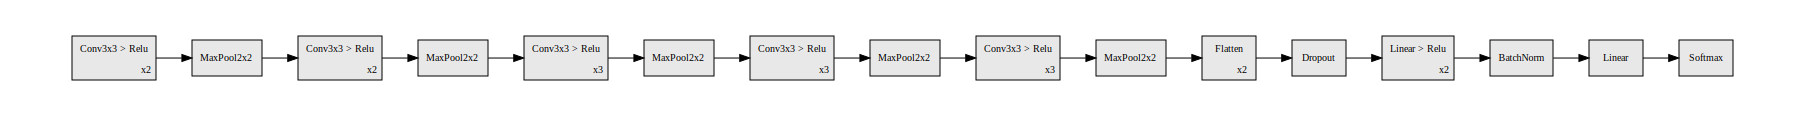

In [197]:
model = models.vgg16(pretrained=True)
#model.classifier = nn.Sequential(*[model.classifier[i] for i in range(5)])
print(model.features) # stampa tutto il modello a valle del classificatore 
#print(model)
#print(model.classifier) # stampa tutto il classificatore 
model.avgpool = nn.Identity() #sostituisco l'avg pool con un layer identità 
#print(model.avgpool) #stampo quel layer per controllo 

model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5, inplace=False),
        nn.Linear(in_features=57344, out_features=4096,bias=True),
        nn.ReLU(inplace=True),
        nn.Linear(in_features=4096, out_features=4096,bias=True), 
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(4096, affine=True),
        nn.Linear(4096, 10),
        nn.Softmax()
)
#print(model.classifier)
#model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)

#Freeze Weights Convolution Layer 
for name, layer in model.named_modules():
  #print(name)
  #conv layer 
  if name == 'features.0':
    layer.weight.requires_grad = False 
  if name == 'features.2': 
    layer.weight.requires_grad = False 
  if name == 'features.5':
    layer.weight.requires_grad = False 
  if name == 'features.7': 
    layer.weight.requires_grad = False 
  if name == 'features.10':
    layer.weight.requires_grad = False 
  if name == 'features.12': 
    layer.weight.requires_grad = False 
  if name == 'features.14':
    layer.weight.requires_grad = False 
  if name == 'features.17': 
    layer.weight.requires_grad = False 
  if name == 'features.19': 
    layer.weight.requires_grad = False
  if name == 'features.21':
    layer.weight.requires_grad = False 
  if name == 'features.24': 
    layer.weight.requires_grad = False 
  if name == 'features.26':
    layer.weight.requires_grad = False 
  if name == 'features.28':
    layer.weight.requires_grad = False 

model = model.to(device)
summary(model,input_size=(3, 270,470))

#Plot Model 
%pip install -U git+https://github.com/waleedka/hiddenlayer.git@master
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([3, 3, 270, 470]))


## Metrica Balance Accuracy 

In [198]:
import keras.backend as K
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
'''
Funzione per Balance Accuracy 
-- Link Utile : https://medium.com/@mostafa.m.ayoub/customize-your-keras-metrics-44ac2e2980bd --
-- https://medium.com/analytics-vidhya/custom-metrics-for-keras-tensorflow-ae7036654e05 --- 
-- https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score --- 
'''

'''
---- Questo caso funzione solo nel caso di classificazioni binarie ---- 
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
		fn = K.sum(K.round(K.clip(y_true, 0, 1)))
		#sensitivity = tp / (fn + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule
		sensitivity = tp / (fn + tp + K.epsilon()) #--OK

		tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
		fp = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
		#specificity = tn / (fp + K.epsilon()) #--- primo test : versione trovata sul web, ma non tornano le formule 
		specificity = tn / (fp + tn + K.epsilon()) #--OK 
	
		Balanced_Accuracy = (sensitivity+specificity)/2 #--OK
		return Balanced_Accuracy 
	return bal_acc
'''
		
'''
Funzione per Balance Accuracy 
'''
def monitor_balance_accuracy ():
	def bal_acc(y_true, y_pred):
		y_true = y_true.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		y_pred = y_pred.numpy().argmax(axis=1) #Returns the indices of the maximum values along an axis.
		Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
		Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
		return (Balanced_Accuracy) #--- capire se si può togliere il K. 
	return bal_acc

def _bal_acc_(y_true, y_pred):
	y_true = y_true.detach().numpy()
	y_pred = y_pred.detach().numpy()
#	print(y_pred)
#	print(len(y_pred))
#	print(type(y_pred))
#	print(y_true)
#	print(len(y_true))
#	print(type(y_true))
#	print('categorical')
	y_true = custom_to_categorical(y_true,10)
	y_true = y_true.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	y_pred = y_pred.argmax(axis=1) #Returns the indices of the maximum values along an axis.
	Balanced_Accuracy = balanced_accuracy_score(y_true, y_pred)
	Balanced_Accuracy = torch.tensor(Balanced_Accuracy) ##-- va trasformata in tensore (torch.tensor)
	return (Balanced_Accuracy) #--- capire se si può togliere il K. 


## Early Stopping Class

In [199]:
import numpy as np
import torch

class _EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    '''metrica di early stop = val_bal_acc'''
    def __call__(self, val_bal_acc, model):
        score = val_bal_acc
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_bal_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_bal_acc, model)
            self.counter = 0


    def save_checkpoint(self, val_bal_acc, model):
        '''Saves model when validation balance accuracy increase.'''
        if self.verbose:
            #self.trace_func(f'Val Bal Acc increase ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            self.trace_func(f'Val Balance Accuracy Increase ({self.val_loss_min:.6f} --> {val_bal_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_bal_acc

In [200]:
    """ '''------------ Metrica di early stop = val_loss-----------'''
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0


    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            #self.trace_func(f'Val Bal Acc increase ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            self.trace_func(f'Val Loss Decrease ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss
"""


" '''------------ Metrica di early stop = val_loss-----------'''\ndef __call__(self, val_loss, model):\n\n    score = -val_loss\n\n    if self.best_score is None:\n        self.best_score = score\n        self.save_checkpoint(val_loss, model)\n    elif score < self.best_score + self.delta:\n        self.counter += 1\n        self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')\n        if self.counter >= self.patience:\n            self.early_stop = True\n    else:\n        self.best_score = score\n        self.save_checkpoint(val_loss, model)\n        self.counter = 0\n\n\ndef save_checkpoint(self, val_loss, model):\n    '''Saves model when validation loss decrease.'''\n    if self.verbose:\n        #self.trace_func(f'Val Bal Acc increase ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')\n        self.trace_func(f'Val Loss Decrease ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')\n    torch.save(model.state_dict(), self.path

## PREPROCESSING & DATA FRAME 

In [201]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from pandas.compat._optional import import_optional_dependency

In [202]:
'''method for univoque sets'''
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = df1_patients_unique.intersection(df2_patients_unique)

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = len(patients_in_both_groups) >= 1 # boolean (true if there is at least 1 patient in both groups)
        
    return leakage

In [203]:
'''PREPROCESSING PHASE OF THE DATAFRAME (CREATIONS OF THE SUBSETS TRAIN/VALIDATION/TEST, CALCULATE WEIGHTS OF ELEMENTS OF THE SUBSETS, VERIFY THAT SAME IDs ARE IN THE SAME SUBSET)'''
os.chdir(path_progettoDL)
path = os.getcwd()

'''reading informations from the CSV'''
col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")

col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")

'''rename the dataframe columns'''
dataframe_sx.columns = ['ID','series', 'filename', 'class']
dataframe_dx.columns = ['ID','series', 'filename', 'class']

frames = [dataframe_sx, dataframe_dx] 
result = pd.concat(frames) #concatenate the two dataframes

print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("DATAFRAME COMPLETO INIZIALE")
print("result")
print(result)

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("STAMPO ELEMENTO/I CON INDICE 1 (elemento tutto a sinistra)")
#print(result.loc[[1]])
#print(type(result.loc[[1]]))    #STAMPO IL TIPO DELL'ELEMENTO 

#print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
#print("LUNGHEZZA DATAFRAME COMPLESSIVO : {} ".format(result[result.columns[0]].count()))


'''mapping the values used for the classification into integer values'''
#version with 10 classes
result["class"] = result["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result["series"] = result["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)}) 


'''identification of NULL values that would bring the execution on failing and eliminate those values'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Number of Null values in column 'quality_classes' : "+format(result['class'].isnull().sum()))
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")
#print(result.loc[result['class'] == '0'])
print("mostro quegli elementi che hanno valore nullo")
print(result[result['class'].isnull()])
print("- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -")

'''Remove Null elements to avoid failures during executions (data in not useful!)'''
print("Rimuovo gli elementi nulli e verifico stampando nuovamente i valori nulli:")
result['class'] = pd.to_numeric(result['class'], errors='coerce')
result = result.dropna(subset=['class'])    #rimuovo le righe con elementi nulli

print("elementi nulli rimasti: "+format(result['class'].isnull().sum()))     #stampo per verifica se ci sono elementi nulli


'''verify if images exist in the Google Drive folder, when not present it is eliminated from the dataset aswell'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("elimino i file che non sono presenti in Google Drive anche se ci sono nel CSV")
print('CHECK FILE NON PRESENTI NELLA CARTELLA')

os.chdir(path_images)
i = 0; 
for index, row in result.iterrows():
    filename = row['filename']
    if os.path.exists(path_images+filename) == False:
      print('File Non Esiste !!!')
    
    if(os.path.exists(filename) == False):
      result = result.drop(result[(result['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))
      i = i + 1             
print('File Eliminati : {} '.format(i))

print('CHECK FILE CON NaN')
print(result[result['class'].isnull()])
print(result[result['series'].isnull()])
print(result[result['filename'].isnull()])
print(result[result['ID'].isnull()])
result = result[result['class'].notna()]
result = result[result['series'].notna()]
result = result[result['filename'].notna()]
result = result[result['ID'].notna()]



#----PER FARE LE PROVE RIDUCO LA DIMENSIONE DI RESULTS#
#result = result[:,100]

'''creation of masked images (grayscale images) and save them in Google Drive'''
'''than create a second dataframe with these new images'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
'''
mask_filenames = []
IDs = []
classes = []
for index, row in result.iterrows():
    filename = row['filename']
    mask_filenames.append(str("mask_"+filename))
    IDs.append(row['ID'])
    classes.append(row['class'])

print("DATAFRAME CON MASCHERE")
result2 = result.copy()
result2['mask_filename'] = mask_filenames
result2.drop('filename', axis='columns', inplace=True)   #rimuovo colonna con path immagini normali

column_names = ["ID","series", "mask_filename", "class"]
result2 = result2.reindex(columns=column_names)

print("result2")
print(result2)
#stampa della conta delle serie dei calci presenti nel dataframe
'''

'''performing the splitting of the dataframe into sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("SPLIT DATA")
train_balance_df, test_balance_df, val_balance_df  = split_data(result, 0.2, 0.2, 3)  #CUSTOM SPLIT CON ID IN STESSO SET DI DATI
#train_mask, test_mask, validation_mask  = split_data(result2, 0.2, 0.2, 3)           #split per test con immagini con maschere

print("train_balance_df")
print(train_balance_df)
print("test_balance_df")
print(test_balance_df)
print("val_balance_df")
print(val_balance_df)


#------------------------version with 4 classes (togliere se si lavora con 10 classi)-----------------------------------
#train_balance_df["class"] = train_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#val_balance_df["class"] = val_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})
#test_balance_df["class"] = test_balance_df["class"].map({0: int(0), 1: int(1), 2: int(1), 3: int(1), 4: int(2), 5: int(2), 6: int(2), 7: int(3), 8: int(3), 9: int(3)})

"""
NOTA: versione dei metodi di tensorflow, che non divide però mantenendo stessi ID in stessi Sub-set
train_balance_df, test_balance_df = train_test_split(result, test_size=0.4, stratify=result['class'], random_state=2)
test_balance_df, val_balance_df = train_test_split(test_balance_df, test_size=0.5, stratify=test_balance_df['class'],random_state=2)
"""

'''verify distibution of classes in the sub-sets and calculate weights of the classes in each sub-set'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")
vals, counts = np.unique(train_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Train")
print(len(train_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts[i]))

vals2, counts2 = np.unique(val_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Validation")
print(len(val_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts2[i]))

vals3, counts3 = np.unique(test_balance_df['class'], return_counts=True)
print("conta del numero di immagini per speicfica classe in set Test")
print(len(test_balance_df))
for i in range(0,len(classi)):
    print('{}:{}'.format(classi[i], counts3[i]))    


class_weights_train = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(train_balance_df['class']),y = train_balance_df['class'])
weight_train = {i : round(class_weights_train[i], 2) for i in range(len(classi))} 
print('Weight train_balance_df')
print(weight_train)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(val_balance_df['class']),y = val_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight val_balance_df')
print(weight)


class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(test_balance_df['class']),y = test_balance_df['class'])
weight = {i : round(class_weights[i], 2) for i in range(len(classi))} 
print('Weight test_balance_df')
print(weight)


'''verify that same IDs are in the same sub-sets'''
print("------------------------------------------------------------------------------------------------------------------------------------------------------------")

#--------verifico che stessi ID siano in stesso set--------
print("test case 1 - train VS validation")
print(f"Stessi ID in set usati?: {check_for_leakage(train_balance_df, val_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 2 - train VS test")
print(f"Stessi ID in set usati ?: {check_for_leakage(train_balance_df, test_balance_df, 'ID')}")
print("-------------------------------------")
print("test case 3 - validation VS test")
print(f"Stessi ID in set usati?: {check_for_leakage(val_balance_df, test_balance_df, 'ID')}")


------------------------------------------------------------------------------------------------------------------------------------------------------------
DATAFRAME COMPLETO INIZIALE
result
        ID  series            filename class
0        3       2  20201 319 5323.png    3+
1        4       2  20201 3110125 .png    3+
2        5       2  20201 31101327.png    3+
3        6       2  20201 3110161 .png    3+
4        7       2  20201 3110177 .png    3+
...    ...     ...                 ...   ...
1059  2023       7  20201031090549.png    3+
1060  2024       7  20201031090855.png    3+
1061  2025       7  20201031091127.png    3+
1062  2026       7  20201031091720.png    3+
1063  2027       7  20201031091941.png    3+

[2128 rows x 4 columns]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Null values in column 'quality_classes' : 2
- - - - - - - - - - - - - - - - 

In [204]:
'''Verifica Classi Qualità per ogni Serie'''
print("Verifica Classi Qualità per ogni Serie")
result_x_ = result.groupby(['series','class']).size()
#print(result_x_)
result_class = result.groupby(['class']).size()
#print(result_class)
result_series = result.groupby(['series']).size()
#print(result_series)  
print('SOMMA IMG : {}'.format(np.sum(result_class)))


Verifica Classi Qualità per ogni Serie
SOMMA IMG : 2120


## Loss Function

In [205]:
from keras import backend as K
class weighted_categorical_crossentropy(object):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        loss = weighted_categorical_crossentropy(weights).loss
        model.compile(loss=loss,optimizer='adam')
    """
    
    def __init__(self,weights):
        self.weights = K.variable(weights)
        
    def loss(self,y_true, y_pred): 
        # scale preds so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred)
        # clip
        y_pred = K.clip(y_pred, K.epsilon(), 1)
        # calc
        
        loss = y_true*K.log(y_pred)*self.weights
        loss =-K.sum(loss,-1)
        return loss

## HYPERPARAMETERS


The **optimization algorithm** (or optimizer) is the main approach used today for training a machine learning model to minimize its error rate. There are *two metrics* to determine the efficacy of an optimizer: **speed of convergence** (the process of reaching a global optimum for gradient descent); and **generalization** (the model’s performance on new data)

***SGD*** : Stochastic Gradient Descent 

Parameters 
- Learning : learning rate is a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function. ... In setting a learning rate, there is a trade-off between the rate of convergence and overshooting
- Momentum : Momentum is method which helps accelerate gradients vectors in the right directions, thus leading to faster converging.
- Decay :  We then set our decay to be the learning rate divided by the total number of epochs we are training the network for (a common rule of thumb) ... lr = (lr_iniziale - (1.0/(1-decay*iterations)))
- Nesterov: Nesterov which is set to false by default. Nesterov momentum is a different version of the momentum method which has stronger theoretical converge guarantees for convex functions.

[1° LINK](https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1)

[2° LINK](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)


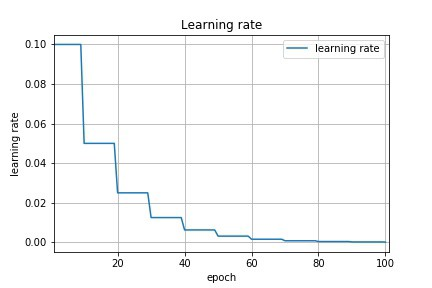

***ADAM*** :  Adaptive Moment Estimation




FONTI : Paper for ICLR 2019

In [206]:
#Definizione hyperparameters                                                                                                                        
opt = optim.SGD(model.parameters(), weight_decay=1e-5, lr=0.001, momentum=0.8)
epochs = 100 #100 
bs = 64


'''
losses = {
	"class_output": 'categorical_crossentropy'
}
lossWeights = { "class_output": 1}
'''
#hyper parametri test 

'\nlosses = {\n\t"class_output": \'categorical_crossentropy\'\n}\nlossWeights = { "class_output": 1}\n'

## CREAZIONE DATASET di TRAIN, VAL, TEST + TRANSFORM 

#### D.A. offline

In [207]:
'''
print(train_balance_df)
train_balance_df_copy = train_balance_df
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)


# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Offline - Parto dalla prima classe di qualità e genero immagini volta per volta fino ad arrivare al numero della maggioritaria
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]
          #--- D.A. offline  
          filename = row_selected['filename']
          
          img_path = os.path.join(path_images+filename)
          

          if i==0: 
            if os.path.exists(path_images+'T1_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_1(image)
              save_image(image, path_images+'T1_'+filename)
            row_selected['filename'] = 'T1_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)   
          if i==1: 
            if os.path.exists(path_images+'T2_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_2(image)
              save_image(image, path_images+'T2_'+filename)
            row_selected['filename'] = 'T2_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)
          if i==2: 
            if os.path.exists(path_images+'T3_'+filename) == False:
              image = io.imread(img_path)
              image = _transform_3(image)
              save_image(image, path_images+'T3_'+filename)
            row_selected['filename'] = 'T3_'+filename
            #print(row_selected['filename'])
            train_balance_df_copy = train_balance_df_copy.append(row_selected, ignore_index = True)    
        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)
# check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))
n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy[train_balance_df_copy['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 


train_c_dataset = CustomDataset(train_balance_df_copy, transform=_transform_)
val_c_dataset = CustomDataset(val_balance_df, transform=_transform_)
test_c_dataset = CustomDataset(test_balance_df,transform=_transform_ )
'''

"\nprint(train_balance_df)\ntrain_balance_df_copy = train_balance_df\nn_img_for_class = np.zeros(10)\nfor i in range(10):\n  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])\nprint(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe \n\nclasse_maggioritaria = np.max(n_img_for_class)\nclasse_minoritaria = np.min(n_img_for_class)\nprint(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')\nprint(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')\nindex_min = np.argmin(n_img_for_class)\nindex_max = np.argmax(n_img_for_class)\nprint(f'classe minima : ',index_min)\nprint(f'classe massima : ',index_max)\n\n\n# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente\nn_img_for_class_to_create = np.zeros(10)\nfor i in range(10):\n  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] \nprint(f'n° immagini da creare per ciascuna classe ', n_i

#### D.A.  Online

In [208]:
#CREO SOLO IL DATASET OFFLINE, CON I NOMI DEI FILE CHE DEVE GENERARE, POI IL Custom_Dataset effettua le transform direttamente quando gli servono e quindi fa augmentation online

'''
#print train balance df 
#print(train_balance_df)

#nuovo df con le transformazioni (DA CREARE)
data = train_balance_df
train_balance_df_copy = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])
train_balance_df_copy['transform'] = 'T0'
#print DF copy (BEFORE)
#print(f'train_balance_df_copy\n', train_balance_df_copy)

# N° IMG per ciascuna classe
n_img_for_class = np.zeros(10)
for i in range(10):
  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe 

# Classe maggioritaria e minoritaria 
classe_maggioritaria = np.max(n_img_for_class)
classe_minoritaria = np.min(n_img_for_class)
print(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')
print(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')
# indice classe maggioritaria e minoritaria 
index_min = np.argmin(n_img_for_class)
index_max = np.argmax(n_img_for_class)
print(f'classe minima : ',index_min)
print(f'classe massima : ',index_max)

# calcolo n° immagini da creare per ciascuna classe di qualità - non lo usiamo direttamente
n_img_for_class_to_create = np.zeros(10)
for i in range(10):
  n_img_for_class_to_create[i] = classe_maggioritaria - n_img_for_class[i] 
print(f'n° immagini da creare per ciascuna classe ', n_img_for_class_to_create) #-- il n° di img per ciascuna classe 


#Data Augmentation Offline - Parto dalla prima classe di qualità e genero immagini volta per volta fino ad arrivare al numero della maggioritaria
for k in range(10): 
  #print(k)
  actual_df = train_balance_df[train_balance_df['class']==k]
  #print(actual_df)
  if n_img_for_class_to_create[k] > 0:
    print(f'devo creare immagini della classe : ',k)
    n_img_in_actual_df = len(actual_df)
    print(f'len actual df', n_img_in_actual_df)
    count = n_img_in_actual_df
    #for row in range(int(n_img_in_actual_df)):
    for i in range(int(abs(classe_maggioritaria/classe_minoritaria))): 
      for row in range(int(n_img_in_actual_df)):
        if (count < classe_maggioritaria):
          count = count + 1
          row_selected = actual_df.iloc[row]
          #parametri nuove img
          filename_ = row_selected['filename']
          class_ = row_selected['class']
          series_ = row_selected['series']
          ID_ = row_selected['ID']
          #creo un nuovo DF con l'id di transforms 
          if i==0: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T1'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)   
          if i==1: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T2'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)   
          if i==2: 
            row = {'ID': ID_, 'series': series_, 'filename': filename_, 'class': class_ , 'transform':'T3'}
            #print(row)
            train_balance_df_copy = train_balance_df_copy.append(row, ignore_index = True)    
        else: 
          break
  else:
    print(f'non devo creare immagini della classe : ',k)

#check di verifica 
#print(f'class_weight train_balance_df',compute_sample_weight(class_weight='balanced', y=train_balance_df['class']))
#print(f'class_weight train_balance_df_copy',compute_sample_weight(class_weight='balanced', y=train_balance_df_copy['class']))

n_img_for_class_after = np.zeros(10)
for i in range(10):
  n_img_for_class_after[i] = len(train_balance_df_copy[train_balance_df_copy['class']==i])
print(f'n° immagini per ciascuna classe ', n_img_for_class_after) #-- il n° di img per ciascuna classe 


##print DF copy (AFTER)
#print(f'train_balance_df_copy\n', train_balance_df_copy)

train_c_dataset = CustomDataset(train_balance_df_copy, transform_0=_transform_, transform_1 = _transform_1, transform_2 = _transform_2, transform_3 = _transform_3, mode = 'train' )
val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None, mode = None)
test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_, transform_1 = None, transform_2 = None, transform_3 = None,  mode = None)
'''

"\n#print train balance df \n#print(train_balance_df)\n\n#nuovo df con le transformazioni (DA CREARE)\ndata = train_balance_df\ntrain_balance_df_copy = pd.DataFrame(data, columns=['ID', 'series', 'filename', 'class', 'transform'])\ntrain_balance_df_copy['transform'] = 'T0'\n#print DF copy (BEFORE)\n#print(f'train_balance_df_copy\n', train_balance_df_copy)\n\n# N° IMG per ciascuna classe\nn_img_for_class = np.zeros(10)\nfor i in range(10):\n  n_img_for_class[i] = len(train_balance_df[train_balance_df['class']==i])\nprint(f'n° immagini per ciascuna classe ', n_img_for_class) #-- il n° di img per ciascuna classe \n\n# Classe maggioritaria e minoritaria \nclasse_maggioritaria = np.max(n_img_for_class)\nclasse_minoritaria = np.min(n_img_for_class)\nprint(f'La classe maggioritaria contiene n: ',classe_maggioritaria,'immagini')\nprint(f'La classe minoritaria contiene n: ',classe_minoritaria,'immagini')\n# indice classe maggioritaria e minoritaria \nindex_min = np.argmin(n_img_for_class)\ninde

#### SETS EXTRACTION FOR DATA AUGEMNTATION WITH GANs

NOTA = per rimuovere Data Augmentation, commentare tutto il blocco e utilizzare direttamente il set 'train_balance_df'

In [209]:
#print(train_balance_df)
#print(len(train_balance_df))


#Estraggo solo le immagini di un solo lato perchè altrimenti geometrie sono opposte - SE USIAMO LE PATCH NON ABBIAMO BISOGNO DI SPEZZARE IL DATASET PERCHÈ LA GEOMETRIA NON C'È PIÙ
#-----PER IMMAGINI INTERE
#train_balance_df_lato_1 = train_balance_df[::2]

#-----PER IMMAGINI PATCH PRENDO TUTTO IL DATASET CON CLASSI DI QUALITÀ
train_balance_df_lato_1 = train_balance_df
'''
print(len(train_balance_df_lato_1))
print(train_balance_df_lato_1) #Prendo solo quelle da un lato, quindi o solo le pari o solo le dispari
'''

#Estraggo solo le immagini di stessa classe di qualità per lo stesso lato estratto in precedenza (sia per la classe migliore che quella peggiore)
df_class_0 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 0]
print(df_class_0)
print(len(df_class_0))

print("---------------------------------------------------")
df_class_9 = train_balance_df_lato_1.loc[train_balance_df_lato_1['class'] == 9]
print(df_class_9)
print(len(df_class_9))

       ID series            filename  class
22    309      3  20203 2 7 2249.png    0.0
23    309      3  20203 2 7 2239.png    0.0
24    320      3  20203 2 7 3533.png    0.0
25    320      3  20203 2 7 3521.png    0.0
26    366      3  20203 2 9 3946.png    0.0
...   ...    ...                 ...    ...
1058  278      3  20202 2716493 .png    0.0
1059  278      3  20202 27164849.png    0.0
1088  348      3  20203 2 8 2951.png    0.0
1089  348      3  20203 2 8 2938.png    0.0
1160  304      3  20203 2 7 195 .png    0.0

[95 rows x 4 columns]
95
---------------------------------------------------
        ID series            filename  class
66    1817      4  20200529172017.png    9.0
67    1817      4  20200529171958.png    9.0
70    1836     10  20200529194441.png    9.0
71    1836     10  20200529194427.png    9.0
106   1689      8  20200525181453.png    9.0
...    ...    ...                 ...    ...
1218   637      4  20200506131733.png    9.0
1244   473      4  20203 108 2449.

In [210]:
from tqdm import tqdm

#SAVE PATCHES EXTRACTED FROM IMAGES

#cartelle in cui salvare i patches : /drive/CALCIO_CROP_BASE/patches/...
os.makedirs("patches/class0.0", exist_ok=True)
os.makedirs("patches/class9.0", exist_ok=True)


#Custom dataset to SAVE PATCHES
class CustomDataset2(Dataset):
  def __init__ (self, dataframe, transform_0=None, transform_1 = None, transform_2 = None, transform_3 = None, weight=None, mode = None):
    self.transform_0 = transform_0
    self.transform_1 = transform_1
    self.transform_2 = transform_2
    self.transform_3 = transform_3
    self.mode = mode
    self.weight = weight
    self.dataframe = dataframe
  def __len__(self):
    return len(self.dataframe)
  
  #ho dovuto aggiungerlo perché l'imbalance dataset sampler lo chiedeva 
  def get_labels(self):
    print(self.dataframe['class'])
    return self.dataframe['class']

  def __getitem__(self, index):
    path = self.dataframe.iloc[index, 2]
    img_path = os.path.join(path_images+path)
    image = io.imread(img_path)
    y_label_class = torch.tensor(int(self.dataframe.iloc[index, 3]))              
    y_label_series = torch.tensor(int(self.dataframe.iloc[index, 1]))

    if self.mode == 'train':
      if self.dataframe.iloc[index, 4] == 'T1': 
        #print('transform T1')
        image = self.transform_1(image)
      if self.dataframe.iloc[index, 4] == 'T2':
        #print('transform T2')
        image = self.transform_2(image)
      if self.dataframe.iloc[index, 4] == 'T3':
        #print('transform T3')
        image = self.transform_3(image)

    if self.transform_0: 
      #print('transform generale')
      image = self.transform_0(image)
      #save_image(image, "patches/class9/patch_%s" % path, normalize=True)      #FORMA OBSOLETA
      save_image(image, "patches/class{0}.0/patch_{1}".format(y_label_class,path), normalize=True, cmap='gray')

      #ALTERNATIVA DI SALVATAGGIO IMMAGINE
      #torch.save(image, 'data_drive_path{}'.format(idx))
    
    return (image, y_label_class, y_label_series)


#---------------------------------------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------MODIFICARE SEMPRE DA QUA SOTTO---------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------------------------------------

#IN QUESTA RIGA SOTTO UTILIZZARE COME PRIMO PARAMETRO IL DATASET CHE SI VUOLE USARE PER ESTRARRE IL PATCH
train_c_dataset_patches = CustomDataset2(df_class_9, transform_0=_transform_4)                                                                                      #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO


trainloader_patches = torch.utils.data.DataLoader(dataset = train_c_dataset_patches, batch_size=bs, shuffle=True)#,num_workers=2

#ITERO GLI ELEMENTI DEL DATALOADER PER RICAVARE I PATCH
for i, (data, targets, targets2) in tqdm(enumerate(trainloader_patches)):
  print(i)


#CREO IL NUOVO DATASET DA USARE COI PATCH PER LA GAN, SENZA MODIFICARE IL PRECEDENTE
mask_filenames = []
IDs = []
classes = []
for index, row in df_class_9.iterrows():                                                                                                                            #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
    filename = row['filename']
    mask_filenames.append(str("patches/class{0}/patch_{1}".format(row['class'],filename)))

    IDs.append(row['ID'])
    classes.append(row['class'])

print("DATAFRAME CON PATCHES")
df_class_new = df_class_9.copy()                                                                                                                                  #MODIFICARE SEMPRE IL DATASET CHE SI VUOLE ITERARE DA MODIFICARE IL PERCORSO
df_class_new.drop('filename', axis='columns', inplace=True)   
df_class_new['filename'] = mask_filenames

column_names = ["ID","series", "filename", "class"]
df_class_new = df_class_new.reindex(columns=column_names)
print(df_class_new)


1it [00:01,  1.62s/it]

0
DATAFRAME CON PATCHES
        ID series                                   filename  class
66    1817      4  patches/class9.0/patch_20200529172017.png    9.0
67    1817      4  patches/class9.0/patch_20200529171958.png    9.0
70    1836     10  patches/class9.0/patch_20200529194441.png    9.0
71    1836     10  patches/class9.0/patch_20200529194427.png    9.0
106   1689      8  patches/class9.0/patch_20200525181453.png    9.0
...    ...    ...                                        ...    ...
1218   637      4  patches/class9.0/patch_20200506131733.png    9.0
1244   473      4  patches/class9.0/patch_20203 108 2449.png    9.0
1245   473      4  patches/class9.0/patch_20203 108 2438.png    9.0
1246   498      4  patches/class9.0/patch_20203 109 5735.png    9.0
1247   498      4  patches/class9.0/patch_20203 109 5720.png    9.0

[62 rows x 4 columns]


In [211]:
#QUA SOTTO SI TENGONO DA PARTE TUTTI I SET ESTRATTI VOLTA PER VOLTA SE DOVESSERO RISERVIRE PER TESTS
'''
#NO DATA AUGMENTATION
train_c_dataset = CustomDataset(train_balance_df, transform_0=_transform_)
'''

'''
#GAN DATA AUGMENTATION

#STESSO LATO E TUTTE LE CLASSI DI QUALITÀ INSIEME
train_c_dataset = CustomDataset(train_balance_df_lato_1, transform_0=_transform_)

#STESSO LATO E SOLO CLASSI DI QUALITÀ MIGLIORE E PEGGIORE PRESE SINGOLARMENTE
train_c_dataset = CustomDataset(df_class_0, transform_0=_transform_)
'''


train_c_dataset = CustomDataset(df_class_new, transform_0=_transform_GAN)                                                    #primo parametro da sostituire sempre per fare un test specifico con GAN


val_c_dataset = CustomDataset(val_balance_df, transform_0=_transform_)
test_c_dataset = CustomDataset(test_balance_df,transform_0=_transform_ )

#### Esempio di Posterize 

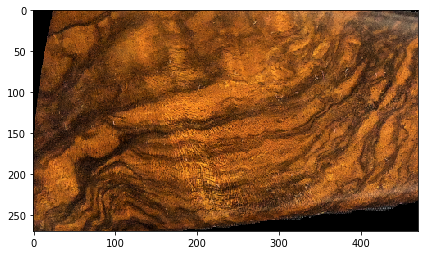

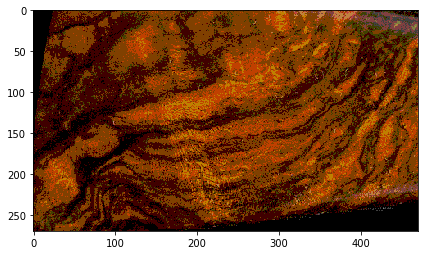

In [212]:
img_path = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/20200506124834.png') 
image = io.imread(img_path)
io.imshow(image)
plt.show()

img_path2 = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/T3_20200506124834.png') 
image2 = io.imread(img_path2)
io.imshow(image2)
plt.show()
#image = _transform_(image)
#plt.imshow(image.numpy()[0], cmap='rgb')

## SAMPLER (non usato attualmente)

#### Classe BalancedBatchSampler 

SERVE A CREARE IL BATCH RAPPRESENTATIVO

In [213]:
import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0

        #prova denis 
        self.number_of_samples = 0

        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)
        self.number_of_samples = self.balanced_max * len(self.dataset)
        
    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)


#### WeightedRandomSampler (TEST) 

You are correct regarding the transformation. The transformation will be applied on the fly on your minority class data. You are also correct regarding the WeightedRandomSampler, if you are keeping the default replacement=True argument.

https://discuss.pytorch.org/t/how-to-augment-the-minority-class-only-in-an-unbalanced-dataset/13797/2

In [214]:
'''
class_sample_counts = train_balance_df.groupby(by="series").count()
class_sample_counts = class_sample_counts['ID'].to_numpy()
print(class_sample_counts)
class_weights = torch.tensor(compute_sample_weight(class_weight='balanced', y=train_balance_df['series'])) #--- use of compute_sample_weight from sklearn 
print(class_weights)

sampler_ = torch.utils.data.sampler.WeightedRandomSampler(
    weights=class_weights,
    num_samples=len(class_weights),
    replacement=True)
'''

'\nclass_sample_counts = train_balance_df.groupby(by="series").count()\nclass_sample_counts = class_sample_counts[\'ID\'].to_numpy()\nprint(class_sample_counts)\nclass_weights = torch.tensor(compute_sample_weight(class_weight=\'balanced\', y=train_balance_df[\'series\'])) #--- use of compute_sample_weight from sklearn \nprint(class_weights)\n\nsampler_ = torch.utils.data.sampler.WeightedRandomSampler(\n    weights=class_weights,\n    num_samples=len(class_weights),\n    replacement=True)\n'

#### Imbalanced Dataset Sampler 
(LINK: https://github.com/ufoym/imbalanced-dataset-sampler) 

In [215]:
#sampler_imbalance = ImbalancedDatasetSampler(train_c_dataset)

## Creazione DataLoader TRAIN, VAL, TEST

In [216]:
'''
#QUESTA PARTE POTREMO DOVERE USARLA SE IMPLEMENTEREMO UN SAMPLER CHE ABBIAMO SOPRA PER PESCARE DAL DATASET IMMAGINI IN MODO SPECIFICO
trainloader = torch.utils.data.DataLoader(
    train_c_dataset,
    sampler=sampler_imbalance,
    batch_size=bs
)
'''
trainloader = torch.utils.data.DataLoader(dataset = train_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2
valloader = torch.utils.data.DataLoader(dataset = val_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2
testloader = torch.utils.data.DataLoader(dataset = test_c_dataset, batch_size=bs, shuffle=True)#,num_workers=2

## Testing Model

####APPOGGIO DI UNA VERSIONE DIVERSA DI WGAN-GP (ATTUALMENTE NON FUNZIONANTE)

In [217]:
'''
#VERSIONE DIVERSA DI GENERATORE E DISCRIMINATORE

# qui ci sono anche altri link con diverse architteture 
# https://github.com/EmilienDupont/wgan-gp/tree/ef82364f2a2ec452a52fbf4a739f95039ae76fe3 

class Generator(nn.Module):
    def __init__(self, img_size, latent_dim, dim):
        super(Generator, self).__init__()

        self.dim = dim
        self.latent_dim = latent_dim
        self.img_size = img_size
        self.feature_sizes = (self.img_size[0] / 1, self.img_size[1] / 1)
        
        self.latent_to_features = nn.Sequential(
            nn.Linear(latent_dim, 8 * dim * int(self.feature_sizes[0]) * int(self.feature_sizes[1])),
            nn.ReLU()
        )

        self.features_to_image = nn.Sequential(
            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(4 * dim),
            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(2 * dim),
            nn.ConvTranspose2d(2 * dim, dim, 4, 2, 1),
            nn.ReLU(),
            nn.BatchNorm2d(dim),
            nn.ConvTranspose2d(dim, self.img_size[2], 4, 2, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        # Map latent into appropriate size for transposed convolutions
        x = self.latent_to_features(input_data)
        # Reshape
        x = x.view(-1, 8 * self.dim, int(self.feature_sizes[0]), int(self.feature_sizes[1]))
        # Return generated image
        return self.features_to_image(x)

    def sample_latent(self, num_samples):
        return torch.randn((num_samples, self.latent_dim))


class Discriminator(nn.Module):
    def __init__(self, img_size, dim):
        """
        img_size : (int, int, int)
            Height and width must be powers of 2.  E.g. (32, 32, 1) or
            (64, 128, 3). Last number indicates number of channels, e.g. 1 for
            grayscale or 3 for RGB
        """
        super(Discriminator, self).__init__()

        self.img_size = img_size

        self.image_to_features = nn.Sequential(
            nn.Conv2d(self.img_size[2], dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(dim, 2 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(2 * dim, 4 * dim, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(4 * dim, 8 * dim, 4, 2, 1),
            nn.Sigmoid()
        )

        # 4 convolutions of stride 2, i.e. halving of size everytime
        # So output size will be 8 * (img_size / 2 ^ 4) * (img_size / 2 ^ 4)
        output_size = 8 * dim * int(img_size[0] / 16) * int(img_size[1] / 16)
        self.features_to_prob = nn.Sequential(
            nn.Linear(output_size, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        batch_size = input_data.size()[0]
        x = self.image_to_features(input_data)
        x = x.view(batch_size, -1)
        return self.features_to_prob(x)


  img_size = (270, 470, 3)
  generator = Generator(img_size=img_size, latent_dim=100, dim=16)
  discriminator = Discriminator(img_size=img_size, dim=16)

'''

'\n#VERSIONE DIVERSA DI GENERATORE E DISCRIMINATORE\n\n# qui ci sono anche altri link con diverse architteture \n# https://github.com/EmilienDupont/wgan-gp/tree/ef82364f2a2ec452a52fbf4a739f95039ae76fe3 \n\nclass Generator(nn.Module):\n    def __init__(self, img_size, latent_dim, dim):\n        super(Generator, self).__init__()\n\n        self.dim = dim\n        self.latent_dim = latent_dim\n        self.img_size = img_size\n        self.feature_sizes = (self.img_size[0] / 1, self.img_size[1] / 1)\n        \n        self.latent_to_features = nn.Sequential(\n            nn.Linear(latent_dim, 8 * dim * int(self.feature_sizes[0]) * int(self.feature_sizes[1])),\n            nn.ReLU()\n        )\n\n        self.features_to_image = nn.Sequential(\n            nn.ConvTranspose2d(8 * dim, 4 * dim, 4, 2, 1),\n            nn.ReLU(),\n            nn.BatchNorm2d(4 * dim),\n            nn.ConvTranspose2d(4 * dim, 2 * dim, 4, 2, 1),\n            nn.ReLU(),\n            nn.BatchNorm2d(2 * dim),\n     

### WGAN-GP

#### Generator & Descriminator 

In [218]:
opt = [["n_epochs - 0", "batch_size - 1", "lr - 2", "b1 - 3", "b2 - 4", "n_cpu - 5", "latent_dim - 6", "img_size - 7", "channels - 8", "n_critic - 9", "clip_value - 10", "sample_interval - 11"],
       [2000,            64,               0.0002,   0.5,      0.999,    8,           100,              135,             1,              4,              0.01,              200]]

img_shape = (opt[1][8], opt[1][7],  235)
#print(*img_shape)

cuda = True if torch.cuda.is_available() else False


os.makedirs("images", exist_ok=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block( opt[1][6], 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        #print(img.shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity




# Loss weight for gradient penalty
lambda_gp = 10

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()


print(generator)
print(discriminator)


if cuda:
    generator.cuda()
    discriminator.cuda()

#generator.to(device)
#discriminator.to(device)

#VALUTA SE CONFIGURARE ANCHE IL SALVATAGGIO DELLE IMMAGINI DIRETTAMENTE SU DRIVE PER QUELLE CHE CREA IL 'GENERATOR'
#PROBABILMENTE SERVIRÀ PERCHE A NOI SERVONO LE IMMAGINI COME DATA AUGMENTATION, QUINDI O LE SALVIAMO PRIMA E POI CI FACCIAMO IL LOAD, OPPURE PENSA COME COMBINARE INSIEME QUESTA FASE CON QUELLA DI ALLENAMENTO DELLA RETE VERA E PROPRIA

# Configure data loader per immagini di dataset MNIST (usato per prova)
'''
os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "../../data/mnist",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize( opt[1][7]), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size= opt[1][1],
    shuffle=True,
)
'''

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr= opt[1][2], betas=( opt[1][3],  opt[1][4]))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Linear(in_features=1024, out_features=31725, bias=True)
    (12): Tanh()
  )
)
Discriminator(
  (model): Sequential(
    (0): Linear(in_features=31725, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=T

#### Compute Gradient Penality 

In [219]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

#### Training GAN 

In [220]:
# ----------
#  Training
# ----------
gan_history = {}
gan_history['DLOSS'] = []
gan_history['GLOSS'] = []
gan_history['EPOCH'] = []

batches_done = 0
for epoch in range( opt[1][0]):
    #for i, (imgs, _) in enumerate(trainloader):
    for i, (data, targets, targets2) in tqdm(enumerate(trainloader)):#, desc = 'Epoch : {} train batch'.format(epoch+1)):
        data = data.to(device=device)
        targets = targets.to(device = device) #classes
        targets2 = targets2.to(device = device) #series

        # Configure input
        real_imgs = Variable(data.type(Tensor))
        ###print(real_imgs.shape)
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        
        z = Variable(Tensor(np.random.normal(0, 0, (data.shape[0],  opt[1][6])))) 
        #z = Variable(Tensor(np.random.normal(0, 0.5, (data.shape[0],  opt[1][6])))) #altro prova per ridurre il rumore 

        # Generate a batch of images
        fake_imgs = generator(z)
        ###print(fake_imgs.shape)

        # Real images
        real_validity = discriminator(real_imgs)
        # Fake images
        fake_validity = discriminator(fake_imgs)
        # Gradient penalty
        
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data)
        
        
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()

        # Train the generator every n_critic steps
        if i %  opt[1][9] == 0:

            # -----------------
            #  Train Generator
            # -----------------

            # Generate a batch of images
            fake_imgs = generator(z)
            # Loss measures generator's ability to fool the discriminator
            # Train on fake images
            fake_validity = discriminator(fake_imgs)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch,  opt[1][0], i, len(trainloader), d_loss.item(), g_loss.item())
            )

            if batches_done %  opt[1][11] == 0:

                save_image(fake_imgs.data[:1], "images/new_%d.png" % batches_done, nrow=1, normalize=True)
                
                
                ########################################################################            
                '''               
                img_to_save =  fake_imgs.data[:1]
                print(img_to_save.shape)   

                                
                img_to_save2 = gray2rgb(img_to_save)                             #ULTIMA PROVA FATTA PER SALVARE A COLORI - bisogna trasformarlo in tensore per poi poterlo salvare !!!
                tensor = torch.from_numpy(img_to_save2)
                print(tensor.shape)

                print(img_to_save2.shape)                                                     
                
                save_image(img_to_save, "images/new1_%d.png" % batches_done, nrow=1, normalize=True)
                save_image(tensor, "images/new2_%d.png" % batches_done, nrow=1, normalize=True)
                '''
                #########################################################################

            batches_done +=  opt[1][9]

    print('------------------------------------------------------------')
    print(
        "[Epoch %d/%d][D loss: %f] [G loss: %f]"
        % (epoch,  opt[1][0], d_loss.item(), g_loss.item())
    )
    print('------------------------------------------------------------')
    gan_history['DLOSS'].append(d_loss.item())
    gan_history['GLOSS'].append(g_loss.item()) 
    gan_history['EPOCH'].append(epoch)


1it [00:00,  1.77it/s]


[Epoch 0/2000] [Batch 0/1] [D loss: 8.075436] [G loss: 0.051195]
------------------------------------------------------------
[Epoch 0/2000][D loss: 8.075436] [G loss: 0.051195]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1/2000] [Batch 0/1] [D loss: 1.935652] [G loss: 0.056745]
------------------------------------------------------------
[Epoch 1/2000][D loss: 1.935652] [G loss: 0.056745]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 2/2000] [Batch 0/1] [D loss: -7.621725] [G loss: 0.058054]
------------------------------------------------------------
[Epoch 2/2000][D loss: -7.621725] [G loss: 0.058054]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 3/2000] [Batch 0/1] [D loss: -19.256933] [G loss: 0.042780]
------------------------------------------------------------
[Epoch 3/2000][D loss: -19.256933] [G loss: 0.042780]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 4/2000] [Batch 0/1] [D loss: -33.103004] [G loss: -0.007762]
------------------------------------------------------------
[Epoch 4/2000][D loss: -33.103004] [G loss: -0.007762]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 5/2000] [Batch 0/1] [D loss: -49.321060] [G loss: -0.117023]
------------------------------------------------------------
[Epoch 5/2000][D loss: -49.321060] [G loss: -0.117023]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 6/2000] [Batch 0/1] [D loss: -67.976082] [G loss: -0.303173]
------------------------------------------------------------
[Epoch 6/2000][D loss: -67.976082] [G loss: -0.303173]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 7/2000] [Batch 0/1] [D loss: -88.900612] [G loss: -0.596085]
------------------------------------------------------------
[Epoch 7/2000][D loss: -88.900612] [G loss: -0.596085]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 8/2000] [Batch 0/1] [D loss: -111.923508] [G loss: -1.028636]
------------------------------------------------------------
[Epoch 8/2000][D loss: -111.923508] [G loss: -1.028636]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 9/2000] [Batch 0/1] [D loss: -136.598267] [G loss: -1.665222]
------------------------------------------------------------
[Epoch 9/2000][D loss: -136.598267] [G loss: -1.665222]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 10/2000] [Batch 0/1] [D loss: -162.146149] [G loss: -2.564837]
------------------------------------------------------------
[Epoch 10/2000][D loss: -162.146149] [G loss: -2.564837]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 11/2000] [Batch 0/1] [D loss: -187.354370] [G loss: -3.792313]
------------------------------------------------------------
[Epoch 11/2000][D loss: -187.354370] [G loss: -3.792313]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 12/2000] [Batch 0/1] [D loss: -211.046875] [G loss: -5.411747]
------------------------------------------------------------
[Epoch 12/2000][D loss: -211.046875] [G loss: -5.411747]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 13/2000] [Batch 0/1] [D loss: -231.969406] [G loss: -7.470821]
------------------------------------------------------------
[Epoch 13/2000][D loss: -231.969406] [G loss: -7.470821]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 14/2000] [Batch 0/1] [D loss: -249.083405] [G loss: -9.995886]
------------------------------------------------------------
[Epoch 14/2000][D loss: -249.083405] [G loss: -9.995886]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 15/2000] [Batch 0/1] [D loss: -261.653931] [G loss: -12.962151]
------------------------------------------------------------
[Epoch 15/2000][D loss: -261.653931] [G loss: -12.962151]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 16/2000] [Batch 0/1] [D loss: -269.364380] [G loss: -16.295200]
------------------------------------------------------------
[Epoch 16/2000][D loss: -269.364380] [G loss: -16.295200]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 17/2000] [Batch 0/1] [D loss: -272.676758] [G loss: -19.872593]
------------------------------------------------------------
[Epoch 17/2000][D loss: -272.676758] [G loss: -19.872593]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 18/2000] [Batch 0/1] [D loss: -272.653595] [G loss: -23.549589]
------------------------------------------------------------
[Epoch 18/2000][D loss: -272.653595] [G loss: -23.549589]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 19/2000] [Batch 0/1] [D loss: -270.582184] [G loss: -27.195206]
------------------------------------------------------------
[Epoch 19/2000][D loss: -270.582184] [G loss: -27.195206]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 20/2000] [Batch 0/1] [D loss: -267.550995] [G loss: -30.727125]
------------------------------------------------------------
[Epoch 20/2000][D loss: -267.550995] [G loss: -30.727125]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 21/2000] [Batch 0/1] [D loss: -264.211060] [G loss: -34.123741]
------------------------------------------------------------
[Epoch 21/2000][D loss: -264.211060] [G loss: -34.123741]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 22/2000] [Batch 0/1] [D loss: -260.808899] [G loss: -37.412079]
------------------------------------------------------------
[Epoch 22/2000][D loss: -260.808899] [G loss: -37.412079]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 23/2000] [Batch 0/1] [D loss: -257.368225] [G loss: -40.643917]
------------------------------------------------------------
[Epoch 23/2000][D loss: -257.368225] [G loss: -40.643917]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 24/2000] [Batch 0/1] [D loss: -253.854523] [G loss: -43.873146]
------------------------------------------------------------
[Epoch 24/2000][D loss: -253.854523] [G loss: -43.873146]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 25/2000] [Batch 0/1] [D loss: -250.240448] [G loss: -47.141361]
------------------------------------------------------------
[Epoch 25/2000][D loss: -250.240448] [G loss: -47.141361]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 26/2000] [Batch 0/1] [D loss: -246.531662] [G loss: -50.472446]
------------------------------------------------------------
[Epoch 26/2000][D loss: -246.531662] [G loss: -50.472446]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 27/2000] [Batch 0/1] [D loss: -242.732452] [G loss: -53.873257]
------------------------------------------------------------
[Epoch 27/2000][D loss: -242.732452] [G loss: -53.873257]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 28/2000] [Batch 0/1] [D loss: -238.856674] [G loss: -57.337788]
------------------------------------------------------------
[Epoch 28/2000][D loss: -238.856674] [G loss: -57.337788]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 29/2000] [Batch 0/1] [D loss: -234.911789] [G loss: -60.852570]
------------------------------------------------------------
[Epoch 29/2000][D loss: -234.911789] [G loss: -60.852570]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 30/2000] [Batch 0/1] [D loss: -230.902664] [G loss: -64.400986]
------------------------------------------------------------
[Epoch 30/2000][D loss: -230.902664] [G loss: -64.400986]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 31/2000] [Batch 0/1] [D loss: -226.837128] [G loss: -67.967087]
------------------------------------------------------------
[Epoch 31/2000][D loss: -226.837128] [G loss: -67.967087]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 32/2000] [Batch 0/1] [D loss: -222.720444] [G loss: -71.537315]
------------------------------------------------------------
[Epoch 32/2000][D loss: -222.720444] [G loss: -71.537315]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 33/2000] [Batch 0/1] [D loss: -218.555984] [G loss: -75.101181]
------------------------------------------------------------
[Epoch 33/2000][D loss: -218.555984] [G loss: -75.101181]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 34/2000] [Batch 0/1] [D loss: -214.352310] [G loss: -78.650986]
------------------------------------------------------------
[Epoch 34/2000][D loss: -214.352310] [G loss: -78.650986]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 35/2000] [Batch 0/1] [D loss: -210.109131] [G loss: -82.181091]
------------------------------------------------------------
[Epoch 35/2000][D loss: -210.109131] [G loss: -82.181091]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 36/2000] [Batch 0/1] [D loss: -205.835510] [G loss: -85.686600]
------------------------------------------------------------
[Epoch 36/2000][D loss: -205.835510] [G loss: -85.686600]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 37/2000] [Batch 0/1] [D loss: -201.533249] [G loss: -89.163155]
------------------------------------------------------------
[Epoch 37/2000][D loss: -201.533249] [G loss: -89.163155]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 38/2000] [Batch 0/1] [D loss: -197.208420] [G loss: -92.606277]
------------------------------------------------------------
[Epoch 38/2000][D loss: -197.208420] [G loss: -92.606277]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 39/2000] [Batch 0/1] [D loss: -192.863556] [G loss: -96.011024]
------------------------------------------------------------
[Epoch 39/2000][D loss: -192.863556] [G loss: -96.011024]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 40/2000] [Batch 0/1] [D loss: -188.506317] [G loss: -99.372078]
------------------------------------------------------------
[Epoch 40/2000][D loss: -188.506317] [G loss: -99.372078]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 41/2000] [Batch 0/1] [D loss: -184.136871] [G loss: -102.683754]
------------------------------------------------------------
[Epoch 41/2000][D loss: -184.136871] [G loss: -102.683754]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 42/2000] [Batch 0/1] [D loss: -179.762573] [G loss: -105.940285]
------------------------------------------------------------
[Epoch 42/2000][D loss: -179.762573] [G loss: -105.940285]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 43/2000] [Batch 0/1] [D loss: -175.387833] [G loss: -109.136040]
------------------------------------------------------------
[Epoch 43/2000][D loss: -175.387833] [G loss: -109.136040]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 44/2000] [Batch 0/1] [D loss: -171.016556] [G loss: -112.264839]
------------------------------------------------------------
[Epoch 44/2000][D loss: -171.016556] [G loss: -112.264839]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 45/2000] [Batch 0/1] [D loss: -166.653625] [G loss: -115.321083]
------------------------------------------------------------
[Epoch 45/2000][D loss: -166.653625] [G loss: -115.321083]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 46/2000] [Batch 0/1] [D loss: -162.302475] [G loss: -118.299644]
------------------------------------------------------------
[Epoch 46/2000][D loss: -162.302475] [G loss: -118.299644]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 47/2000] [Batch 0/1] [D loss: -157.969284] [G loss: -121.195595]
------------------------------------------------------------
[Epoch 47/2000][D loss: -157.969284] [G loss: -121.195595]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 48/2000] [Batch 0/1] [D loss: -153.657059] [G loss: -124.004234]
------------------------------------------------------------
[Epoch 48/2000][D loss: -153.657059] [G loss: -124.004234]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 49/2000] [Batch 0/1] [D loss: -149.370972] [G loss: -126.721130]
------------------------------------------------------------
[Epoch 49/2000][D loss: -149.370972] [G loss: -126.721130]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 50/2000] [Batch 0/1] [D loss: -145.113495] [G loss: -129.342087]
------------------------------------------------------------
[Epoch 50/2000][D loss: -145.113495] [G loss: -129.342087]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 51/2000] [Batch 0/1] [D loss: -140.890411] [G loss: -131.863144]
------------------------------------------------------------
[Epoch 51/2000][D loss: -140.890411] [G loss: -131.863144]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 52/2000] [Batch 0/1] [D loss: -136.704483] [G loss: -134.280685]
------------------------------------------------------------
[Epoch 52/2000][D loss: -136.704483] [G loss: -134.280685]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 53/2000] [Batch 0/1] [D loss: -132.560303] [G loss: -136.591293]
------------------------------------------------------------
[Epoch 53/2000][D loss: -132.560303] [G loss: -136.591293]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 54/2000] [Batch 0/1] [D loss: -128.461075] [G loss: -138.791870]
------------------------------------------------------------
[Epoch 54/2000][D loss: -128.461075] [G loss: -138.791870]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 55/2000] [Batch 0/1] [D loss: -124.409920] [G loss: -140.879684]
------------------------------------------------------------
[Epoch 55/2000][D loss: -124.409920] [G loss: -140.879684]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 56/2000] [Batch 0/1] [D loss: -120.410683] [G loss: -142.863556]
------------------------------------------------------------
[Epoch 56/2000][D loss: -120.410683] [G loss: -142.863556]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 57/2000] [Batch 0/1] [D loss: -116.464333] [G loss: -144.732239]
------------------------------------------------------------
[Epoch 57/2000][D loss: -116.464333] [G loss: -144.732239]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 58/2000] [Batch 0/1] [D loss: -112.576332] [G loss: -146.509354]
------------------------------------------------------------
[Epoch 58/2000][D loss: -112.576332] [G loss: -146.509354]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 59/2000] [Batch 0/1] [D loss: -108.745529] [G loss: -148.150864]
------------------------------------------------------------
[Epoch 59/2000][D loss: -108.745529] [G loss: -148.150864]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 60/2000] [Batch 0/1] [D loss: -104.979134] [G loss: -149.607986]
------------------------------------------------------------
[Epoch 60/2000][D loss: -104.979134] [G loss: -149.607986]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 61/2000] [Batch 0/1] [D loss: -101.281578] [G loss: -150.957077]
------------------------------------------------------------
[Epoch 61/2000][D loss: -101.281578] [G loss: -150.957077]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 62/2000] [Batch 0/1] [D loss: -97.651489] [G loss: -152.189163]
------------------------------------------------------------
[Epoch 62/2000][D loss: -97.651489] [G loss: -152.189163]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 63/2000] [Batch 0/1] [D loss: -94.090607] [G loss: -153.301575]
------------------------------------------------------------
[Epoch 63/2000][D loss: -94.090607] [G loss: -153.301575]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 64/2000] [Batch 0/1] [D loss: -90.601456] [G loss: -154.286957]
------------------------------------------------------------
[Epoch 64/2000][D loss: -90.601456] [G loss: -154.286957]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 65/2000] [Batch 0/1] [D loss: -87.185272] [G loss: -155.144226]
------------------------------------------------------------
[Epoch 65/2000][D loss: -87.185272] [G loss: -155.144226]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 66/2000] [Batch 0/1] [D loss: -83.844070] [G loss: -155.872986]
------------------------------------------------------------
[Epoch 66/2000][D loss: -83.844070] [G loss: -155.872986]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 67/2000] [Batch 0/1] [D loss: -80.578949] [G loss: -156.473206]
------------------------------------------------------------
[Epoch 67/2000][D loss: -80.578949] [G loss: -156.473206]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 68/2000] [Batch 0/1] [D loss: -77.391228] [G loss: -156.944992]
------------------------------------------------------------
[Epoch 68/2000][D loss: -77.391228] [G loss: -156.944992]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 69/2000] [Batch 0/1] [D loss: -74.281799] [G loss: -157.291443]
------------------------------------------------------------
[Epoch 69/2000][D loss: -74.281799] [G loss: -157.291443]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 70/2000] [Batch 0/1] [D loss: -71.250992] [G loss: -157.511444]
------------------------------------------------------------
[Epoch 70/2000][D loss: -71.250992] [G loss: -157.511444]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 71/2000] [Batch 0/1] [D loss: -68.300079] [G loss: -157.604614]
------------------------------------------------------------
[Epoch 71/2000][D loss: -68.300079] [G loss: -157.604614]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 72/2000] [Batch 0/1] [D loss: -65.429138] [G loss: -157.571762]
------------------------------------------------------------
[Epoch 72/2000][D loss: -65.429138] [G loss: -157.571762]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 73/2000] [Batch 0/1] [D loss: -62.638012] [G loss: -157.383179]
------------------------------------------------------------
[Epoch 73/2000][D loss: -62.638012] [G loss: -157.383179]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 74/2000] [Batch 0/1] [D loss: -59.929893] [G loss: -157.088318]
------------------------------------------------------------
[Epoch 74/2000][D loss: -59.929893] [G loss: -157.088318]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 75/2000] [Batch 0/1] [D loss: -57.301182] [G loss: -156.685242]
------------------------------------------------------------
[Epoch 75/2000][D loss: -57.301182] [G loss: -156.685242]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 76/2000] [Batch 0/1] [D loss: -54.751114] [G loss: -156.110336]
------------------------------------------------------------
[Epoch 76/2000][D loss: -54.751114] [G loss: -156.110336]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 77/2000] [Batch 0/1] [D loss: -52.285175] [G loss: -155.455200]
------------------------------------------------------------
[Epoch 77/2000][D loss: -52.285175] [G loss: -155.455200]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 78/2000] [Batch 0/1] [D loss: -49.896378] [G loss: -154.707092]
------------------------------------------------------------
[Epoch 78/2000][D loss: -49.896378] [G loss: -154.707092]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 79/2000] [Batch 0/1] [D loss: -47.586540] [G loss: -153.910278]
------------------------------------------------------------
[Epoch 79/2000][D loss: -47.586540] [G loss: -153.910278]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 80/2000] [Batch 0/1] [D loss: -45.349274] [G loss: -152.989883]
------------------------------------------------------------
[Epoch 80/2000][D loss: -45.349274] [G loss: -152.989883]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 81/2000] [Batch 0/1] [D loss: -43.188976] [G loss: -151.895294]
------------------------------------------------------------
[Epoch 81/2000][D loss: -43.188976] [G loss: -151.895294]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 82/2000] [Batch 0/1] [D loss: -41.109123] [G loss: -150.730408]
------------------------------------------------------------
[Epoch 82/2000][D loss: -41.109123] [G loss: -150.730408]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 83/2000] [Batch 0/1] [D loss: -39.102119] [G loss: -149.513794]
------------------------------------------------------------
[Epoch 83/2000][D loss: -39.102119] [G loss: -149.513794]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 84/2000] [Batch 0/1] [D loss: -37.165386] [G loss: -148.190109]
------------------------------------------------------------
[Epoch 84/2000][D loss: -37.165386] [G loss: -148.190109]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 85/2000] [Batch 0/1] [D loss: -35.299919] [G loss: -146.605743]
------------------------------------------------------------
[Epoch 85/2000][D loss: -35.299919] [G loss: -146.605743]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 86/2000] [Batch 0/1] [D loss: -33.511719] [G loss: -144.652969]
------------------------------------------------------------
[Epoch 86/2000][D loss: -33.511719] [G loss: -144.652969]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 87/2000] [Batch 0/1] [D loss: -31.808054] [G loss: -142.790710]
------------------------------------------------------------
[Epoch 87/2000][D loss: -31.808054] [G loss: -142.790710]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 88/2000] [Batch 0/1] [D loss: -30.169504] [G loss: -141.114471]
------------------------------------------------------------
[Epoch 88/2000][D loss: -30.169504] [G loss: -141.114471]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 89/2000] [Batch 0/1] [D loss: -28.583847] [G loss: -139.453339]
------------------------------------------------------------
[Epoch 89/2000][D loss: -28.583847] [G loss: -139.453339]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 90/2000] [Batch 0/1] [D loss: -27.061756] [G loss: -137.707153]
------------------------------------------------------------
[Epoch 90/2000][D loss: -27.061756] [G loss: -137.707153]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 91/2000] [Batch 0/1] [D loss: -25.603325] [G loss: -135.831345]
------------------------------------------------------------
[Epoch 91/2000][D loss: -25.603325] [G loss: -135.831345]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 92/2000] [Batch 0/1] [D loss: -24.207687] [G loss: -133.965942]
------------------------------------------------------------
[Epoch 92/2000][D loss: -24.207687] [G loss: -133.965942]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 93/2000] [Batch 0/1] [D loss: -22.865543] [G loss: -131.945740]
------------------------------------------------------------
[Epoch 93/2000][D loss: -22.865543] [G loss: -131.945740]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 94/2000] [Batch 0/1] [D loss: -21.585384] [G loss: -129.930313]
------------------------------------------------------------
[Epoch 94/2000][D loss: -21.585384] [G loss: -129.930313]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 95/2000] [Batch 0/1] [D loss: -20.359709] [G loss: -127.896324]
------------------------------------------------------------
[Epoch 95/2000][D loss: -20.359709] [G loss: -127.896324]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 96/2000] [Batch 0/1] [D loss: -19.183193] [G loss: -125.773293]
------------------------------------------------------------
[Epoch 96/2000][D loss: -19.183193] [G loss: -125.773293]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 97/2000] [Batch 0/1] [D loss: -18.066179] [G loss: -123.754951]
------------------------------------------------------------
[Epoch 97/2000][D loss: -18.066179] [G loss: -123.754951]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 98/2000] [Batch 0/1] [D loss: -16.990162] [G loss: -120.704681]
------------------------------------------------------------
[Epoch 98/2000][D loss: -16.990162] [G loss: -120.704681]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 99/2000] [Batch 0/1] [D loss: -15.994942] [G loss: -118.365303]
------------------------------------------------------------
[Epoch 99/2000][D loss: -15.994942] [G loss: -118.365303]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 100/2000] [Batch 0/1] [D loss: -15.019036] [G loss: -115.624809]
------------------------------------------------------------
[Epoch 100/2000][D loss: -15.019036] [G loss: -115.624809]
------------------------------------------------------------


1it [00:00,  2.26it/s]


[Epoch 101/2000] [Batch 0/1] [D loss: -14.107655] [G loss: -112.914268]
------------------------------------------------------------
[Epoch 101/2000][D loss: -14.107655] [G loss: -112.914268]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 102/2000] [Batch 0/1] [D loss: -13.237986] [G loss: -110.428154]
------------------------------------------------------------
[Epoch 102/2000][D loss: -13.237986] [G loss: -110.428154]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 103/2000] [Batch 0/1] [D loss: -12.405842] [G loss: -108.130043]
------------------------------------------------------------
[Epoch 103/2000][D loss: -12.405842] [G loss: -108.130043]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 104/2000] [Batch 0/1] [D loss: -11.617643] [G loss: -106.091240]
------------------------------------------------------------
[Epoch 104/2000][D loss: -11.617643] [G loss: -106.091240]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 105/2000] [Batch 0/1] [D loss: -10.865039] [G loss: -104.475235]
------------------------------------------------------------
[Epoch 105/2000][D loss: -10.865039] [G loss: -104.475235]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 106/2000] [Batch 0/1] [D loss: -10.132582] [G loss: -102.337334]
------------------------------------------------------------
[Epoch 106/2000][D loss: -10.132582] [G loss: -102.337334]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 107/2000] [Batch 0/1] [D loss: -9.438791] [G loss: -99.731003]
------------------------------------------------------------
[Epoch 107/2000][D loss: -9.438791] [G loss: -99.731003]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 108/2000] [Batch 0/1] [D loss: -8.786551] [G loss: -96.744972]
------------------------------------------------------------
[Epoch 108/2000][D loss: -8.786551] [G loss: -96.744972]
------------------------------------------------------------


1it [00:00,  2.26it/s]


[Epoch 109/2000] [Batch 0/1] [D loss: -8.186174] [G loss: -94.148018]
------------------------------------------------------------
[Epoch 109/2000][D loss: -8.186174] [G loss: -94.148018]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 110/2000] [Batch 0/1] [D loss: -7.600111] [G loss: -91.719795]
------------------------------------------------------------
[Epoch 110/2000][D loss: -7.600111] [G loss: -91.719795]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 111/2000] [Batch 0/1] [D loss: -7.048594] [G loss: -89.132805]
------------------------------------------------------------
[Epoch 111/2000][D loss: -7.048594] [G loss: -89.132805]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 112/2000] [Batch 0/1] [D loss: -6.519467] [G loss: -85.634415]
------------------------------------------------------------
[Epoch 112/2000][D loss: -6.519467] [G loss: -85.634415]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 113/2000] [Batch 0/1] [D loss: -6.040989] [G loss: -82.089706]
------------------------------------------------------------
[Epoch 113/2000][D loss: -6.040989] [G loss: -82.089706]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 114/2000] [Batch 0/1] [D loss: -5.595955] [G loss: -79.167191]
------------------------------------------------------------
[Epoch 114/2000][D loss: -5.595955] [G loss: -79.167191]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 115/2000] [Batch 0/1] [D loss: -5.161389] [G loss: -76.193283]
------------------------------------------------------------
[Epoch 115/2000][D loss: -5.161389] [G loss: -76.193283]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 116/2000] [Batch 0/1] [D loss: -4.774940] [G loss: -73.646561]
------------------------------------------------------------
[Epoch 116/2000][D loss: -4.774940] [G loss: -73.646561]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 117/2000] [Batch 0/1] [D loss: -4.389512] [G loss: -70.284042]
------------------------------------------------------------
[Epoch 117/2000][D loss: -4.389512] [G loss: -70.284042]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 118/2000] [Batch 0/1] [D loss: -4.033124] [G loss: -67.727043]
------------------------------------------------------------
[Epoch 118/2000][D loss: -4.033124] [G loss: -67.727043]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 119/2000] [Batch 0/1] [D loss: -3.684796] [G loss: -63.684406]
------------------------------------------------------------
[Epoch 119/2000][D loss: -3.684796] [G loss: -63.684406]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 120/2000] [Batch 0/1] [D loss: -3.417370] [G loss: -62.427814]
------------------------------------------------------------
[Epoch 120/2000][D loss: -3.417370] [G loss: -62.427814]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 121/2000] [Batch 0/1] [D loss: -3.072955] [G loss: -59.447079]
------------------------------------------------------------
[Epoch 121/2000][D loss: -3.072955] [G loss: -59.447079]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 122/2000] [Batch 0/1] [D loss: -2.829286] [G loss: -56.588181]
------------------------------------------------------------
[Epoch 122/2000][D loss: -2.829286] [G loss: -56.588181]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 123/2000] [Batch 0/1] [D loss: -2.542075] [G loss: -55.177189]
------------------------------------------------------------
[Epoch 123/2000][D loss: -2.542075] [G loss: -55.177189]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 124/2000] [Batch 0/1] [D loss: -2.225367] [G loss: -51.209080]
------------------------------------------------------------
[Epoch 124/2000][D loss: -2.225367] [G loss: -51.209080]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 125/2000] [Batch 0/1] [D loss: -2.002287] [G loss: -45.551762]
------------------------------------------------------------
[Epoch 125/2000][D loss: -2.002287] [G loss: -45.551762]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 126/2000] [Batch 0/1] [D loss: -1.813680] [G loss: -41.911430]
------------------------------------------------------------
[Epoch 126/2000][D loss: -1.813680] [G loss: -41.911430]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 127/2000] [Batch 0/1] [D loss: -1.645870] [G loss: -36.838760]
------------------------------------------------------------
[Epoch 127/2000][D loss: -1.645870] [G loss: -36.838760]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 128/2000] [Batch 0/1] [D loss: -1.511186] [G loss: -33.774864]
------------------------------------------------------------
[Epoch 128/2000][D loss: -1.511186] [G loss: -33.774864]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 129/2000] [Batch 0/1] [D loss: -1.348651] [G loss: -29.690393]
------------------------------------------------------------
[Epoch 129/2000][D loss: -1.348651] [G loss: -29.690393]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 130/2000] [Batch 0/1] [D loss: -1.240770] [G loss: -26.586102]
------------------------------------------------------------
[Epoch 130/2000][D loss: -1.240770] [G loss: -26.586102]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 131/2000] [Batch 0/1] [D loss: -1.044412] [G loss: -23.247002]
------------------------------------------------------------
[Epoch 131/2000][D loss: -1.044412] [G loss: -23.247002]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 132/2000] [Batch 0/1] [D loss: -0.916322] [G loss: -18.312363]
------------------------------------------------------------
[Epoch 132/2000][D loss: -0.916322] [G loss: -18.312363]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 133/2000] [Batch 0/1] [D loss: -0.774148] [G loss: -13.962420]
------------------------------------------------------------
[Epoch 133/2000][D loss: -0.774148] [G loss: -13.962420]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 134/2000] [Batch 0/1] [D loss: -0.618893] [G loss: -10.479956]
------------------------------------------------------------
[Epoch 134/2000][D loss: -0.618893] [G loss: -10.479956]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 135/2000] [Batch 0/1] [D loss: -0.499478] [G loss: -5.178313]
------------------------------------------------------------
[Epoch 135/2000][D loss: -0.499478] [G loss: -5.178313]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 136/2000] [Batch 0/1] [D loss: -0.404542] [G loss: -2.385698]
------------------------------------------------------------
[Epoch 136/2000][D loss: -0.404542] [G loss: -2.385698]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 137/2000] [Batch 0/1] [D loss: -0.293547] [G loss: 0.783058]
------------------------------------------------------------
[Epoch 137/2000][D loss: -0.293547] [G loss: 0.783058]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 138/2000] [Batch 0/1] [D loss: -0.132916] [G loss: 4.615294]
------------------------------------------------------------
[Epoch 138/2000][D loss: -0.132916] [G loss: 4.615294]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 139/2000] [Batch 0/1] [D loss: 0.002985] [G loss: 8.768973]
------------------------------------------------------------
[Epoch 139/2000][D loss: 0.002985] [G loss: 8.768973]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 140/2000] [Batch 0/1] [D loss: 0.191788] [G loss: 11.234536]
------------------------------------------------------------
[Epoch 140/2000][D loss: 0.191788] [G loss: 11.234536]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 141/2000] [Batch 0/1] [D loss: 0.335771] [G loss: 13.296264]
------------------------------------------------------------
[Epoch 141/2000][D loss: 0.335771] [G loss: 13.296264]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 142/2000] [Batch 0/1] [D loss: 0.395350] [G loss: 16.552666]
------------------------------------------------------------
[Epoch 142/2000][D loss: 0.395350] [G loss: 16.552666]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 143/2000] [Batch 0/1] [D loss: 0.622593] [G loss: 19.253765]
------------------------------------------------------------
[Epoch 143/2000][D loss: 0.622593] [G loss: 19.253765]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 144/2000] [Batch 0/1] [D loss: 0.752590] [G loss: 22.262783]
------------------------------------------------------------
[Epoch 144/2000][D loss: 0.752590] [G loss: 22.262783]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 145/2000] [Batch 0/1] [D loss: 0.948273] [G loss: 24.613934]
------------------------------------------------------------
[Epoch 145/2000][D loss: 0.948273] [G loss: 24.613934]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 146/2000] [Batch 0/1] [D loss: 1.134625] [G loss: 27.714663]
------------------------------------------------------------
[Epoch 146/2000][D loss: 1.134625] [G loss: 27.714663]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 147/2000] [Batch 0/1] [D loss: 1.333943] [G loss: 29.129360]
------------------------------------------------------------
[Epoch 147/2000][D loss: 1.333943] [G loss: 29.129360]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 148/2000] [Batch 0/1] [D loss: 1.487470] [G loss: 31.346960]
------------------------------------------------------------
[Epoch 148/2000][D loss: 1.487470] [G loss: 31.346960]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 149/2000] [Batch 0/1] [D loss: 1.653416] [G loss: 32.407616]
------------------------------------------------------------
[Epoch 149/2000][D loss: 1.653416] [G loss: 32.407616]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 150/2000] [Batch 0/1] [D loss: 1.792083] [G loss: 32.716080]
------------------------------------------------------------
[Epoch 150/2000][D loss: 1.792083] [G loss: 32.716080]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 151/2000] [Batch 0/1] [D loss: 1.950234] [G loss: 34.515102]
------------------------------------------------------------
[Epoch 151/2000][D loss: 1.950234] [G loss: 34.515102]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 152/2000] [Batch 0/1] [D loss: 2.222913] [G loss: 34.546371]
------------------------------------------------------------
[Epoch 152/2000][D loss: 2.222913] [G loss: 34.546371]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 153/2000] [Batch 0/1] [D loss: 2.425137] [G loss: 34.026852]
------------------------------------------------------------
[Epoch 153/2000][D loss: 2.425137] [G loss: 34.026852]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 154/2000] [Batch 0/1] [D loss: 2.586361] [G loss: 33.011349]
------------------------------------------------------------
[Epoch 154/2000][D loss: 2.586361] [G loss: 33.011349]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 155/2000] [Batch 0/1] [D loss: 2.703318] [G loss: 31.122274]
------------------------------------------------------------
[Epoch 155/2000][D loss: 2.703318] [G loss: 31.122274]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 156/2000] [Batch 0/1] [D loss: 2.841378] [G loss: 29.064939]
------------------------------------------------------------
[Epoch 156/2000][D loss: 2.841378] [G loss: 29.064939]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 157/2000] [Batch 0/1] [D loss: 2.935270] [G loss: 27.374445]
------------------------------------------------------------
[Epoch 157/2000][D loss: 2.935270] [G loss: 27.374445]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 158/2000] [Batch 0/1] [D loss: 2.970510] [G loss: 25.027517]
------------------------------------------------------------
[Epoch 158/2000][D loss: 2.970510] [G loss: 25.027517]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 159/2000] [Batch 0/1] [D loss: 3.044265] [G loss: 23.833153]
------------------------------------------------------------
[Epoch 159/2000][D loss: 3.044265] [G loss: 23.833153]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 160/2000] [Batch 0/1] [D loss: 3.143116] [G loss: 22.033340]
------------------------------------------------------------
[Epoch 160/2000][D loss: 3.143116] [G loss: 22.033340]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 161/2000] [Batch 0/1] [D loss: 3.190328] [G loss: 19.435066]
------------------------------------------------------------
[Epoch 161/2000][D loss: 3.190328] [G loss: 19.435066]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 162/2000] [Batch 0/1] [D loss: 3.155066] [G loss: 16.538891]
------------------------------------------------------------
[Epoch 162/2000][D loss: 3.155066] [G loss: 16.538891]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 163/2000] [Batch 0/1] [D loss: 3.064409] [G loss: 13.073889]
------------------------------------------------------------
[Epoch 163/2000][D loss: 3.064409] [G loss: 13.073889]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 164/2000] [Batch 0/1] [D loss: 2.945336] [G loss: 9.652348]
------------------------------------------------------------
[Epoch 164/2000][D loss: 2.945336] [G loss: 9.652348]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 165/2000] [Batch 0/1] [D loss: 2.802230] [G loss: 6.783831]
------------------------------------------------------------
[Epoch 165/2000][D loss: 2.802230] [G loss: 6.783831]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 166/2000] [Batch 0/1] [D loss: 2.620755] [G loss: 3.800944]
------------------------------------------------------------
[Epoch 166/2000][D loss: 2.620755] [G loss: 3.800944]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 167/2000] [Batch 0/1] [D loss: 2.505084] [G loss: 1.191720]
------------------------------------------------------------
[Epoch 167/2000][D loss: 2.505084] [G loss: 1.191720]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 168/2000] [Batch 0/1] [D loss: 2.396377] [G loss: -1.679625]
------------------------------------------------------------
[Epoch 168/2000][D loss: 2.396377] [G loss: -1.679625]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 169/2000] [Batch 0/1] [D loss: 2.226125] [G loss: -6.147784]
------------------------------------------------------------
[Epoch 169/2000][D loss: 2.226125] [G loss: -6.147784]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 170/2000] [Batch 0/1] [D loss: 1.976989] [G loss: -8.789049]
------------------------------------------------------------
[Epoch 170/2000][D loss: 1.976989] [G loss: -8.789049]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 171/2000] [Batch 0/1] [D loss: 1.784942] [G loss: -12.661002]
------------------------------------------------------------
[Epoch 171/2000][D loss: 1.784942] [G loss: -12.661002]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 172/2000] [Batch 0/1] [D loss: 1.536768] [G loss: -17.742264]
------------------------------------------------------------
[Epoch 172/2000][D loss: 1.536768] [G loss: -17.742264]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 173/2000] [Batch 0/1] [D loss: 1.223099] [G loss: -22.767279]
------------------------------------------------------------
[Epoch 173/2000][D loss: 1.223099] [G loss: -22.767279]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 174/2000] [Batch 0/1] [D loss: 1.007723] [G loss: -25.382521]
------------------------------------------------------------
[Epoch 174/2000][D loss: 1.007723] [G loss: -25.382521]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 175/2000] [Batch 0/1] [D loss: 0.733297] [G loss: -27.980858]
------------------------------------------------------------
[Epoch 175/2000][D loss: 0.733297] [G loss: -27.980858]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 176/2000] [Batch 0/1] [D loss: 0.586158] [G loss: -32.288631]
------------------------------------------------------------
[Epoch 176/2000][D loss: 0.586158] [G loss: -32.288631]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 177/2000] [Batch 0/1] [D loss: 0.368126] [G loss: -35.637711]
------------------------------------------------------------
[Epoch 177/2000][D loss: 0.368126] [G loss: -35.637711]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 178/2000] [Batch 0/1] [D loss: 0.132618] [G loss: -38.575775]
------------------------------------------------------------
[Epoch 178/2000][D loss: 0.132618] [G loss: -38.575775]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 179/2000] [Batch 0/1] [D loss: -0.089915] [G loss: -43.727535]
------------------------------------------------------------
[Epoch 179/2000][D loss: -0.089915] [G loss: -43.727535]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 180/2000] [Batch 0/1] [D loss: -0.330604] [G loss: -47.090908]
------------------------------------------------------------
[Epoch 180/2000][D loss: -0.330604] [G loss: -47.090908]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 181/2000] [Batch 0/1] [D loss: -0.472941] [G loss: -50.969215]
------------------------------------------------------------
[Epoch 181/2000][D loss: -0.472941] [G loss: -50.969215]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 182/2000] [Batch 0/1] [D loss: -0.532858] [G loss: -54.584324]
------------------------------------------------------------
[Epoch 182/2000][D loss: -0.532858] [G loss: -54.584324]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 183/2000] [Batch 0/1] [D loss: -0.563205] [G loss: -57.070976]
------------------------------------------------------------
[Epoch 183/2000][D loss: -0.563205] [G loss: -57.070976]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 184/2000] [Batch 0/1] [D loss: -0.660072] [G loss: -59.783379]
------------------------------------------------------------
[Epoch 184/2000][D loss: -0.660072] [G loss: -59.783379]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 185/2000] [Batch 0/1] [D loss: -0.633534] [G loss: -61.433907]
------------------------------------------------------------
[Epoch 185/2000][D loss: -0.633534] [G loss: -61.433907]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 186/2000] [Batch 0/1] [D loss: -0.618038] [G loss: -62.726002]
------------------------------------------------------------
[Epoch 186/2000][D loss: -0.618038] [G loss: -62.726002]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 187/2000] [Batch 0/1] [D loss: -0.567732] [G loss: -63.512627]
------------------------------------------------------------
[Epoch 187/2000][D loss: -0.567732] [G loss: -63.512627]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 188/2000] [Batch 0/1] [D loss: -0.476579] [G loss: -63.386227]
------------------------------------------------------------
[Epoch 188/2000][D loss: -0.476579] [G loss: -63.386227]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 189/2000] [Batch 0/1] [D loss: -0.416084] [G loss: -62.835503]
------------------------------------------------------------
[Epoch 189/2000][D loss: -0.416084] [G loss: -62.835503]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 190/2000] [Batch 0/1] [D loss: -0.325258] [G loss: -61.561249]
------------------------------------------------------------
[Epoch 190/2000][D loss: -0.325258] [G loss: -61.561249]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 191/2000] [Batch 0/1] [D loss: -0.237838] [G loss: -59.045734]
------------------------------------------------------------
[Epoch 191/2000][D loss: -0.237838] [G loss: -59.045734]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 192/2000] [Batch 0/1] [D loss: -0.207927] [G loss: -55.831356]
------------------------------------------------------------
[Epoch 192/2000][D loss: -0.207927] [G loss: -55.831356]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 193/2000] [Batch 0/1] [D loss: -0.166800] [G loss: -52.775566]
------------------------------------------------------------
[Epoch 193/2000][D loss: -0.166800] [G loss: -52.775566]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 194/2000] [Batch 0/1] [D loss: -0.200631] [G loss: -48.388027]
------------------------------------------------------------
[Epoch 194/2000][D loss: -0.200631] [G loss: -48.388027]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 195/2000] [Batch 0/1] [D loss: -0.249835] [G loss: -42.908722]
------------------------------------------------------------
[Epoch 195/2000][D loss: -0.249835] [G loss: -42.908722]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 196/2000] [Batch 0/1] [D loss: -0.324269] [G loss: -37.549435]
------------------------------------------------------------
[Epoch 196/2000][D loss: -0.324269] [G loss: -37.549435]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 197/2000] [Batch 0/1] [D loss: -0.356646] [G loss: -32.555058]
------------------------------------------------------------
[Epoch 197/2000][D loss: -0.356646] [G loss: -32.555058]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 198/2000] [Batch 0/1] [D loss: -0.563668] [G loss: -26.564856]
------------------------------------------------------------
[Epoch 198/2000][D loss: -0.563668] [G loss: -26.564856]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 199/2000] [Batch 0/1] [D loss: -0.638466] [G loss: -22.589466]
------------------------------------------------------------
[Epoch 199/2000][D loss: -0.638466] [G loss: -22.589466]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 200/2000] [Batch 0/1] [D loss: -0.753946] [G loss: -15.872512]
------------------------------------------------------------
[Epoch 200/2000][D loss: -0.753946] [G loss: -15.872512]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 201/2000] [Batch 0/1] [D loss: -0.869676] [G loss: -9.126041]
------------------------------------------------------------
[Epoch 201/2000][D loss: -0.869676] [G loss: -9.126041]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 202/2000] [Batch 0/1] [D loss: -1.130755] [G loss: -3.756581]
------------------------------------------------------------
[Epoch 202/2000][D loss: -1.130755] [G loss: -3.756581]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 203/2000] [Batch 0/1] [D loss: -1.245814] [G loss: 1.151012]
------------------------------------------------------------
[Epoch 203/2000][D loss: -1.245814] [G loss: 1.151012]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 204/2000] [Batch 0/1] [D loss: -1.065720] [G loss: 6.317419]
------------------------------------------------------------
[Epoch 204/2000][D loss: -1.065720] [G loss: 6.317419]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 205/2000] [Batch 0/1] [D loss: -1.515284] [G loss: 13.116961]
------------------------------------------------------------
[Epoch 205/2000][D loss: -1.515284] [G loss: 13.116961]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 206/2000] [Batch 0/1] [D loss: -1.673889] [G loss: 20.634321]
------------------------------------------------------------
[Epoch 206/2000][D loss: -1.673889] [G loss: 20.634321]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 207/2000] [Batch 0/1] [D loss: -1.885470] [G loss: 28.754213]
------------------------------------------------------------
[Epoch 207/2000][D loss: -1.885470] [G loss: 28.754213]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 208/2000] [Batch 0/1] [D loss: -1.723192] [G loss: 34.683365]
------------------------------------------------------------
[Epoch 208/2000][D loss: -1.723192] [G loss: 34.683365]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 209/2000] [Batch 0/1] [D loss: -1.946537] [G loss: 39.627121]
------------------------------------------------------------
[Epoch 209/2000][D loss: -1.946537] [G loss: 39.627121]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 210/2000] [Batch 0/1] [D loss: -2.119677] [G loss: 43.778282]
------------------------------------------------------------
[Epoch 210/2000][D loss: -2.119677] [G loss: 43.778282]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 211/2000] [Batch 0/1] [D loss: -2.061238] [G loss: 47.298653]
------------------------------------------------------------
[Epoch 211/2000][D loss: -2.061238] [G loss: 47.298653]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 212/2000] [Batch 0/1] [D loss: -2.044963] [G loss: 50.443546]
------------------------------------------------------------
[Epoch 212/2000][D loss: -2.044963] [G loss: 50.443546]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 213/2000] [Batch 0/1] [D loss: -1.740166] [G loss: 53.042965]
------------------------------------------------------------
[Epoch 213/2000][D loss: -1.740166] [G loss: 53.042965]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 214/2000] [Batch 0/1] [D loss: -1.698026] [G loss: 54.929340]
------------------------------------------------------------
[Epoch 214/2000][D loss: -1.698026] [G loss: 54.929340]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 215/2000] [Batch 0/1] [D loss: -1.583670] [G loss: 57.688789]
------------------------------------------------------------
[Epoch 215/2000][D loss: -1.583670] [G loss: 57.688789]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 216/2000] [Batch 0/1] [D loss: -1.564305] [G loss: 60.551651]
------------------------------------------------------------
[Epoch 216/2000][D loss: -1.564305] [G loss: 60.551651]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 217/2000] [Batch 0/1] [D loss: -1.317416] [G loss: 63.021336]
------------------------------------------------------------
[Epoch 217/2000][D loss: -1.317416] [G loss: 63.021336]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 218/2000] [Batch 0/1] [D loss: -1.187225] [G loss: 65.561699]
------------------------------------------------------------
[Epoch 218/2000][D loss: -1.187225] [G loss: 65.561699]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 219/2000] [Batch 0/1] [D loss: -1.109804] [G loss: 67.432724]
------------------------------------------------------------
[Epoch 219/2000][D loss: -1.109804] [G loss: 67.432724]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 220/2000] [Batch 0/1] [D loss: -0.831548] [G loss: 69.034416]
------------------------------------------------------------
[Epoch 220/2000][D loss: -0.831548] [G loss: 69.034416]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 221/2000] [Batch 0/1] [D loss: -0.596896] [G loss: 70.014236]
------------------------------------------------------------
[Epoch 221/2000][D loss: -0.596896] [G loss: 70.014236]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 222/2000] [Batch 0/1] [D loss: -0.363730] [G loss: 70.351501]
------------------------------------------------------------
[Epoch 222/2000][D loss: -0.363730] [G loss: 70.351501]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 223/2000] [Batch 0/1] [D loss: 0.029750] [G loss: 70.042244]
------------------------------------------------------------
[Epoch 223/2000][D loss: 0.029750] [G loss: 70.042244]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 224/2000] [Batch 0/1] [D loss: 0.106490] [G loss: 68.589973]
------------------------------------------------------------
[Epoch 224/2000][D loss: 0.106490] [G loss: 68.589973]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 225/2000] [Batch 0/1] [D loss: 0.422727] [G loss: 66.936287]
------------------------------------------------------------
[Epoch 225/2000][D loss: 0.422727] [G loss: 66.936287]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 226/2000] [Batch 0/1] [D loss: 0.656386] [G loss: 64.992157]
------------------------------------------------------------
[Epoch 226/2000][D loss: 0.656386] [G loss: 64.992157]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 227/2000] [Batch 0/1] [D loss: 0.843656] [G loss: 62.736359]
------------------------------------------------------------
[Epoch 227/2000][D loss: 0.843656] [G loss: 62.736359]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 228/2000] [Batch 0/1] [D loss: 1.071686] [G loss: 60.185757]
------------------------------------------------------------
[Epoch 228/2000][D loss: 1.071686] [G loss: 60.185757]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 229/2000] [Batch 0/1] [D loss: 1.200590] [G loss: 57.269291]
------------------------------------------------------------
[Epoch 229/2000][D loss: 1.200590] [G loss: 57.269291]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 230/2000] [Batch 0/1] [D loss: 1.263546] [G loss: 53.837971]
------------------------------------------------------------
[Epoch 230/2000][D loss: 1.263546] [G loss: 53.837971]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 231/2000] [Batch 0/1] [D loss: 1.250043] [G loss: 49.522953]
------------------------------------------------------------
[Epoch 231/2000][D loss: 1.250043] [G loss: 49.522953]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 232/2000] [Batch 0/1] [D loss: 1.366711] [G loss: 44.885078]
------------------------------------------------------------
[Epoch 232/2000][D loss: 1.366711] [G loss: 44.885078]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 233/2000] [Batch 0/1] [D loss: 1.237225] [G loss: 39.831543]
------------------------------------------------------------
[Epoch 233/2000][D loss: 1.237225] [G loss: 39.831543]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 234/2000] [Batch 0/1] [D loss: 1.049269] [G loss: 34.048458]
------------------------------------------------------------
[Epoch 234/2000][D loss: 1.049269] [G loss: 34.048458]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 235/2000] [Batch 0/1] [D loss: 0.779652] [G loss: 26.799192]
------------------------------------------------------------
[Epoch 235/2000][D loss: 0.779652] [G loss: 26.799192]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 236/2000] [Batch 0/1] [D loss: 0.437748] [G loss: 19.213486]
------------------------------------------------------------
[Epoch 236/2000][D loss: 0.437748] [G loss: 19.213486]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 237/2000] [Batch 0/1] [D loss: 0.033813] [G loss: 10.381628]
------------------------------------------------------------
[Epoch 237/2000][D loss: 0.033813] [G loss: 10.381628]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 238/2000] [Batch 0/1] [D loss: -0.362578] [G loss: 1.845963]
------------------------------------------------------------
[Epoch 238/2000][D loss: -0.362578] [G loss: 1.845963]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 239/2000] [Batch 0/1] [D loss: -0.833316] [G loss: -7.086835]
------------------------------------------------------------
[Epoch 239/2000][D loss: -0.833316] [G loss: -7.086835]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 240/2000] [Batch 0/1] [D loss: -1.301668] [G loss: -16.907228]
------------------------------------------------------------
[Epoch 240/2000][D loss: -1.301668] [G loss: -16.907228]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 241/2000] [Batch 0/1] [D loss: -1.456806] [G loss: -25.449234]
------------------------------------------------------------
[Epoch 241/2000][D loss: -1.456806] [G loss: -25.449234]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 242/2000] [Batch 0/1] [D loss: -1.830765] [G loss: -33.390865]
------------------------------------------------------------
[Epoch 242/2000][D loss: -1.830765] [G loss: -33.390865]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 243/2000] [Batch 0/1] [D loss: -2.124678] [G loss: -40.568027]
------------------------------------------------------------
[Epoch 243/2000][D loss: -2.124678] [G loss: -40.568027]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 244/2000] [Batch 0/1] [D loss: -2.420794] [G loss: -46.701534]
------------------------------------------------------------
[Epoch 244/2000][D loss: -2.420794] [G loss: -46.701534]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 245/2000] [Batch 0/1] [D loss: -2.506195] [G loss: -52.396404]
------------------------------------------------------------
[Epoch 245/2000][D loss: -2.506195] [G loss: -52.396404]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 246/2000] [Batch 0/1] [D loss: -2.470869] [G loss: -57.001534]
------------------------------------------------------------
[Epoch 246/2000][D loss: -2.470869] [G loss: -57.001534]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 247/2000] [Batch 0/1] [D loss: -2.300578] [G loss: -59.654133]
------------------------------------------------------------
[Epoch 247/2000][D loss: -2.300578] [G loss: -59.654133]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 248/2000] [Batch 0/1] [D loss: -2.269800] [G loss: -62.045654]
------------------------------------------------------------
[Epoch 248/2000][D loss: -2.269800] [G loss: -62.045654]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 249/2000] [Batch 0/1] [D loss: -2.056137] [G loss: -63.850094]
------------------------------------------------------------
[Epoch 249/2000][D loss: -2.056137] [G loss: -63.850094]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 250/2000] [Batch 0/1] [D loss: -1.793796] [G loss: -64.076859]
------------------------------------------------------------
[Epoch 250/2000][D loss: -1.793796] [G loss: -64.076859]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 251/2000] [Batch 0/1] [D loss: -1.556506] [G loss: -65.647675]
------------------------------------------------------------
[Epoch 251/2000][D loss: -1.556506] [G loss: -65.647675]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 252/2000] [Batch 0/1] [D loss: -1.278011] [G loss: -65.678986]
------------------------------------------------------------
[Epoch 252/2000][D loss: -1.278011] [G loss: -65.678986]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 253/2000] [Batch 0/1] [D loss: -1.015806] [G loss: -64.494240]
------------------------------------------------------------
[Epoch 253/2000][D loss: -1.015806] [G loss: -64.494240]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 254/2000] [Batch 0/1] [D loss: -0.656584] [G loss: -62.540806]
------------------------------------------------------------
[Epoch 254/2000][D loss: -0.656584] [G loss: -62.540806]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 255/2000] [Batch 0/1] [D loss: -0.370805] [G loss: -59.728275]
------------------------------------------------------------
[Epoch 255/2000][D loss: -0.370805] [G loss: -59.728275]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 256/2000] [Batch 0/1] [D loss: -0.133113] [G loss: -56.304859]
------------------------------------------------------------
[Epoch 256/2000][D loss: -0.133113] [G loss: -56.304859]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 257/2000] [Batch 0/1] [D loss: 0.062059] [G loss: -52.689163]
------------------------------------------------------------
[Epoch 257/2000][D loss: 0.062059] [G loss: -52.689163]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 258/2000] [Batch 0/1] [D loss: 0.196102] [G loss: -49.381428]
------------------------------------------------------------
[Epoch 258/2000][D loss: 0.196102] [G loss: -49.381428]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 259/2000] [Batch 0/1] [D loss: 0.398724] [G loss: -45.099644]
------------------------------------------------------------
[Epoch 259/2000][D loss: 0.398724] [G loss: -45.099644]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 260/2000] [Batch 0/1] [D loss: 0.511250] [G loss: -40.097382]
------------------------------------------------------------
[Epoch 260/2000][D loss: 0.511250] [G loss: -40.097382]
------------------------------------------------------------


1it [00:00,  2.16it/s]


[Epoch 261/2000] [Batch 0/1] [D loss: 0.530185] [G loss: -35.608131]
------------------------------------------------------------
[Epoch 261/2000][D loss: 0.530185] [G loss: -35.608131]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 262/2000] [Batch 0/1] [D loss: 0.537922] [G loss: -30.832682]
------------------------------------------------------------
[Epoch 262/2000][D loss: 0.537922] [G loss: -30.832682]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 263/2000] [Batch 0/1] [D loss: 0.567181] [G loss: -26.902111]
------------------------------------------------------------
[Epoch 263/2000][D loss: 0.567181] [G loss: -26.902111]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 264/2000] [Batch 0/1] [D loss: 0.582952] [G loss: -21.391087]
------------------------------------------------------------
[Epoch 264/2000][D loss: 0.582952] [G loss: -21.391087]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 265/2000] [Batch 0/1] [D loss: 0.736939] [G loss: -15.407665]
------------------------------------------------------------
[Epoch 265/2000][D loss: 0.736939] [G loss: -15.407665]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 266/2000] [Batch 0/1] [D loss: 0.603265] [G loss: -9.366851]
------------------------------------------------------------
[Epoch 266/2000][D loss: 0.603265] [G loss: -9.366851]
------------------------------------------------------------


1it [00:00,  2.16it/s]


[Epoch 267/2000] [Batch 0/1] [D loss: 0.459351] [G loss: -3.275596]
------------------------------------------------------------
[Epoch 267/2000][D loss: 0.459351] [G loss: -3.275596]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 268/2000] [Batch 0/1] [D loss: 0.234056] [G loss: 3.444362]
------------------------------------------------------------
[Epoch 268/2000][D loss: 0.234056] [G loss: 3.444362]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 269/2000] [Batch 0/1] [D loss: 0.143943] [G loss: 10.177987]
------------------------------------------------------------
[Epoch 269/2000][D loss: 0.143943] [G loss: 10.177987]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 270/2000] [Batch 0/1] [D loss: -0.049352] [G loss: 16.095240]
------------------------------------------------------------
[Epoch 270/2000][D loss: -0.049352] [G loss: 16.095240]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 271/2000] [Batch 0/1] [D loss: -0.189520] [G loss: 22.016653]
------------------------------------------------------------
[Epoch 271/2000][D loss: -0.189520] [G loss: 22.016653]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 272/2000] [Batch 0/1] [D loss: -0.207898] [G loss: 28.576990]
------------------------------------------------------------
[Epoch 272/2000][D loss: -0.207898] [G loss: 28.576990]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 273/2000] [Batch 0/1] [D loss: -0.360808] [G loss: 34.754379]
------------------------------------------------------------
[Epoch 273/2000][D loss: -0.360808] [G loss: 34.754379]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 274/2000] [Batch 0/1] [D loss: -0.477855] [G loss: 39.108437]
------------------------------------------------------------
[Epoch 274/2000][D loss: -0.477855] [G loss: 39.108437]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 275/2000] [Batch 0/1] [D loss: -0.400121] [G loss: 43.040920]
------------------------------------------------------------
[Epoch 275/2000][D loss: -0.400121] [G loss: 43.040920]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 276/2000] [Batch 0/1] [D loss: -0.336771] [G loss: 47.156197]
------------------------------------------------------------
[Epoch 276/2000][D loss: -0.336771] [G loss: 47.156197]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 277/2000] [Batch 0/1] [D loss: -0.321477] [G loss: 51.533936]
------------------------------------------------------------
[Epoch 277/2000][D loss: -0.321477] [G loss: 51.533936]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 278/2000] [Batch 0/1] [D loss: -0.276991] [G loss: 54.725712]
------------------------------------------------------------
[Epoch 278/2000][D loss: -0.276991] [G loss: 54.725712]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 279/2000] [Batch 0/1] [D loss: -0.252588] [G loss: 57.535213]
------------------------------------------------------------
[Epoch 279/2000][D loss: -0.252588] [G loss: 57.535213]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 280/2000] [Batch 0/1] [D loss: -0.065175] [G loss: 59.977959]
------------------------------------------------------------
[Epoch 280/2000][D loss: -0.065175] [G loss: 59.977959]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 281/2000] [Batch 0/1] [D loss: 0.144578] [G loss: 61.950191]
------------------------------------------------------------
[Epoch 281/2000][D loss: 0.144578] [G loss: 61.950191]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 282/2000] [Batch 0/1] [D loss: 0.309732] [G loss: 63.685966]
------------------------------------------------------------
[Epoch 282/2000][D loss: 0.309732] [G loss: 63.685966]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 283/2000] [Batch 0/1] [D loss: 0.636401] [G loss: 63.901043]
------------------------------------------------------------
[Epoch 283/2000][D loss: 0.636401] [G loss: 63.901043]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 284/2000] [Batch 0/1] [D loss: 0.834153] [G loss: 63.652454]
------------------------------------------------------------
[Epoch 284/2000][D loss: 0.834153] [G loss: 63.652454]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 285/2000] [Batch 0/1] [D loss: 1.072646] [G loss: 62.216766]
------------------------------------------------------------
[Epoch 285/2000][D loss: 1.072646] [G loss: 62.216766]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 286/2000] [Batch 0/1] [D loss: 1.416483] [G loss: 60.273239]
------------------------------------------------------------
[Epoch 286/2000][D loss: 1.416483] [G loss: 60.273239]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 287/2000] [Batch 0/1] [D loss: 1.564035] [G loss: 58.327549]
------------------------------------------------------------
[Epoch 287/2000][D loss: 1.564035] [G loss: 58.327549]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 288/2000] [Batch 0/1] [D loss: 1.738283] [G loss: 56.403030]
------------------------------------------------------------
[Epoch 288/2000][D loss: 1.738283] [G loss: 56.403030]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 289/2000] [Batch 0/1] [D loss: 1.938341] [G loss: 53.266300]
------------------------------------------------------------
[Epoch 289/2000][D loss: 1.938341] [G loss: 53.266300]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 290/2000] [Batch 0/1] [D loss: 2.026544] [G loss: 49.994698]
------------------------------------------------------------
[Epoch 290/2000][D loss: 2.026544] [G loss: 49.994698]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 291/2000] [Batch 0/1] [D loss: 2.079396] [G loss: 46.467155]
------------------------------------------------------------
[Epoch 291/2000][D loss: 2.079396] [G loss: 46.467155]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 292/2000] [Batch 0/1] [D loss: 2.053129] [G loss: 42.667553]
------------------------------------------------------------
[Epoch 292/2000][D loss: 2.053129] [G loss: 42.667553]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 293/2000] [Batch 0/1] [D loss: 1.964426] [G loss: 38.057621]
------------------------------------------------------------
[Epoch 293/2000][D loss: 1.964426] [G loss: 38.057621]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 294/2000] [Batch 0/1] [D loss: 1.664220] [G loss: 32.420063]
------------------------------------------------------------
[Epoch 294/2000][D loss: 1.664220] [G loss: 32.420063]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 295/2000] [Batch 0/1] [D loss: 1.367139] [G loss: 26.214327]
------------------------------------------------------------
[Epoch 295/2000][D loss: 1.367139] [G loss: 26.214327]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 296/2000] [Batch 0/1] [D loss: 1.054741] [G loss: 19.103559]
------------------------------------------------------------
[Epoch 296/2000][D loss: 1.054741] [G loss: 19.103559]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 297/2000] [Batch 0/1] [D loss: 0.658498] [G loss: 11.035775]
------------------------------------------------------------
[Epoch 297/2000][D loss: 0.658498] [G loss: 11.035775]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 298/2000] [Batch 0/1] [D loss: 0.107366] [G loss: 1.627437]
------------------------------------------------------------
[Epoch 298/2000][D loss: 0.107366] [G loss: 1.627437]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 299/2000] [Batch 0/1] [D loss: -0.450175] [G loss: -7.989328]
------------------------------------------------------------
[Epoch 299/2000][D loss: -0.450175] [G loss: -7.989328]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 300/2000] [Batch 0/1] [D loss: -0.973552] [G loss: -17.454109]
------------------------------------------------------------
[Epoch 300/2000][D loss: -0.973552] [G loss: -17.454109]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 301/2000] [Batch 0/1] [D loss: -1.434220] [G loss: -27.142595]
------------------------------------------------------------
[Epoch 301/2000][D loss: -1.434220] [G loss: -27.142595]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 302/2000] [Batch 0/1] [D loss: -1.728289] [G loss: -35.424385]
------------------------------------------------------------
[Epoch 302/2000][D loss: -1.728289] [G loss: -35.424385]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 303/2000] [Batch 0/1] [D loss: -1.987948] [G loss: -43.471439]
------------------------------------------------------------
[Epoch 303/2000][D loss: -1.987948] [G loss: -43.471439]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 304/2000] [Batch 0/1] [D loss: -2.008805] [G loss: -50.139194]
------------------------------------------------------------
[Epoch 304/2000][D loss: -2.008805] [G loss: -50.139194]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 305/2000] [Batch 0/1] [D loss: -2.085879] [G loss: -55.018936]
------------------------------------------------------------
[Epoch 305/2000][D loss: -2.085879] [G loss: -55.018936]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 306/2000] [Batch 0/1] [D loss: -2.254092] [G loss: -59.416256]
------------------------------------------------------------
[Epoch 306/2000][D loss: -2.254092] [G loss: -59.416256]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 307/2000] [Batch 0/1] [D loss: -2.236152] [G loss: -63.089848]
------------------------------------------------------------
[Epoch 307/2000][D loss: -2.236152] [G loss: -63.089848]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 308/2000] [Batch 0/1] [D loss: -2.163388] [G loss: -66.130402]
------------------------------------------------------------
[Epoch 308/2000][D loss: -2.163388] [G loss: -66.130402]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 309/2000] [Batch 0/1] [D loss: -2.016141] [G loss: -68.040558]
------------------------------------------------------------
[Epoch 309/2000][D loss: -2.016141] [G loss: -68.040558]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 310/2000] [Batch 0/1] [D loss: -1.866751] [G loss: -69.029083]
------------------------------------------------------------
[Epoch 310/2000][D loss: -1.866751] [G loss: -69.029083]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 311/2000] [Batch 0/1] [D loss: -1.679292] [G loss: -69.393417]
------------------------------------------------------------
[Epoch 311/2000][D loss: -1.679292] [G loss: -69.393417]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 312/2000] [Batch 0/1] [D loss: -1.575832] [G loss: -69.036926]
------------------------------------------------------------
[Epoch 312/2000][D loss: -1.575832] [G loss: -69.036926]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 313/2000] [Batch 0/1] [D loss: -1.413475] [G loss: -67.534576]
------------------------------------------------------------
[Epoch 313/2000][D loss: -1.413475] [G loss: -67.534576]
------------------------------------------------------------


1it [00:00,  2.25it/s]


[Epoch 314/2000] [Batch 0/1] [D loss: -1.308464] [G loss: -65.017120]
------------------------------------------------------------
[Epoch 314/2000][D loss: -1.308464] [G loss: -65.017120]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 315/2000] [Batch 0/1] [D loss: -1.353931] [G loss: -62.484783]
------------------------------------------------------------
[Epoch 315/2000][D loss: -1.353931] [G loss: -62.484783]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 316/2000] [Batch 0/1] [D loss: -1.450410] [G loss: -60.363495]
------------------------------------------------------------
[Epoch 316/2000][D loss: -1.450410] [G loss: -60.363495]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 317/2000] [Batch 0/1] [D loss: -1.203293] [G loss: -57.930210]
------------------------------------------------------------
[Epoch 317/2000][D loss: -1.203293] [G loss: -57.930210]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 318/2000] [Batch 0/1] [D loss: -1.041251] [G loss: -54.400333]
------------------------------------------------------------
[Epoch 318/2000][D loss: -1.041251] [G loss: -54.400333]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 319/2000] [Batch 0/1] [D loss: -0.964863] [G loss: -50.877312]
------------------------------------------------------------
[Epoch 319/2000][D loss: -0.964863] [G loss: -50.877312]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 320/2000] [Batch 0/1] [D loss: -0.881373] [G loss: -45.553059]
------------------------------------------------------------
[Epoch 320/2000][D loss: -0.881373] [G loss: -45.553059]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 321/2000] [Batch 0/1] [D loss: -0.869357] [G loss: -39.110874]
------------------------------------------------------------
[Epoch 321/2000][D loss: -0.869357] [G loss: -39.110874]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 322/2000] [Batch 0/1] [D loss: -0.867311] [G loss: -32.378414]
------------------------------------------------------------
[Epoch 322/2000][D loss: -0.867311] [G loss: -32.378414]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 323/2000] [Batch 0/1] [D loss: -0.927241] [G loss: -25.091978]
------------------------------------------------------------
[Epoch 323/2000][D loss: -0.927241] [G loss: -25.091978]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 324/2000] [Batch 0/1] [D loss: -1.037029] [G loss: -19.556231]
------------------------------------------------------------
[Epoch 324/2000][D loss: -1.037029] [G loss: -19.556231]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 325/2000] [Batch 0/1] [D loss: -1.089099] [G loss: -13.316371]
------------------------------------------------------------
[Epoch 325/2000][D loss: -1.089099] [G loss: -13.316371]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 326/2000] [Batch 0/1] [D loss: -0.943330] [G loss: -5.527810]
------------------------------------------------------------
[Epoch 326/2000][D loss: -0.943330] [G loss: -5.527810]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 327/2000] [Batch 0/1] [D loss: -0.842797] [G loss: -0.012275]
------------------------------------------------------------
[Epoch 327/2000][D loss: -0.842797] [G loss: -0.012275]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 328/2000] [Batch 0/1] [D loss: -0.744545] [G loss: 6.148265]
------------------------------------------------------------
[Epoch 328/2000][D loss: -0.744545] [G loss: 6.148265]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 329/2000] [Batch 0/1] [D loss: -0.847555] [G loss: 13.048886]
------------------------------------------------------------
[Epoch 329/2000][D loss: -0.847555] [G loss: 13.048886]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 330/2000] [Batch 0/1] [D loss: -1.025012] [G loss: 19.833117]
------------------------------------------------------------
[Epoch 330/2000][D loss: -1.025012] [G loss: 19.833117]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 331/2000] [Batch 0/1] [D loss: -0.933231] [G loss: 27.354126]
------------------------------------------------------------
[Epoch 331/2000][D loss: -0.933231] [G loss: 27.354126]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 332/2000] [Batch 0/1] [D loss: -1.084092] [G loss: 34.601669]
------------------------------------------------------------
[Epoch 332/2000][D loss: -1.084092] [G loss: 34.601669]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 333/2000] [Batch 0/1] [D loss: -0.960687] [G loss: 40.959469]
------------------------------------------------------------
[Epoch 333/2000][D loss: -0.960687] [G loss: 40.959469]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 334/2000] [Batch 0/1] [D loss: -0.863080] [G loss: 46.732452]
------------------------------------------------------------
[Epoch 334/2000][D loss: -0.863080] [G loss: 46.732452]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 335/2000] [Batch 0/1] [D loss: -0.753276] [G loss: 51.621014]
------------------------------------------------------------
[Epoch 335/2000][D loss: -0.753276] [G loss: 51.621014]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 336/2000] [Batch 0/1] [D loss: -0.720255] [G loss: 55.465530]
------------------------------------------------------------
[Epoch 336/2000][D loss: -0.720255] [G loss: 55.465530]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 337/2000] [Batch 0/1] [D loss: -0.550131] [G loss: 58.975937]
------------------------------------------------------------
[Epoch 337/2000][D loss: -0.550131] [G loss: 58.975937]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 338/2000] [Batch 0/1] [D loss: -0.220392] [G loss: 62.413090]
------------------------------------------------------------
[Epoch 338/2000][D loss: -0.220392] [G loss: 62.413090]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 339/2000] [Batch 0/1] [D loss: 0.052587] [G loss: 66.505798]
------------------------------------------------------------
[Epoch 339/2000][D loss: 0.052587] [G loss: 66.505798]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 340/2000] [Batch 0/1] [D loss: 0.334983] [G loss: 69.726898]
------------------------------------------------------------
[Epoch 340/2000][D loss: 0.334983] [G loss: 69.726898]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 341/2000] [Batch 0/1] [D loss: 0.627367] [G loss: 70.649017]
------------------------------------------------------------
[Epoch 341/2000][D loss: 0.627367] [G loss: 70.649017]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 342/2000] [Batch 0/1] [D loss: 1.051940] [G loss: 70.926300]
------------------------------------------------------------
[Epoch 342/2000][D loss: 1.051940] [G loss: 70.926300]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 343/2000] [Batch 0/1] [D loss: 1.704450] [G loss: 70.045441]
------------------------------------------------------------
[Epoch 343/2000][D loss: 1.704450] [G loss: 70.045441]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 344/2000] [Batch 0/1] [D loss: 2.138984] [G loss: 67.675964]
------------------------------------------------------------
[Epoch 344/2000][D loss: 2.138984] [G loss: 67.675964]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 345/2000] [Batch 0/1] [D loss: 2.303304] [G loss: 64.953964]
------------------------------------------------------------
[Epoch 345/2000][D loss: 2.303304] [G loss: 64.953964]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 346/2000] [Batch 0/1] [D loss: 2.579881] [G loss: 63.083088]
------------------------------------------------------------
[Epoch 346/2000][D loss: 2.579881] [G loss: 63.083088]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 347/2000] [Batch 0/1] [D loss: 2.748018] [G loss: 59.612442]
------------------------------------------------------------
[Epoch 347/2000][D loss: 2.748018] [G loss: 59.612442]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 348/2000] [Batch 0/1] [D loss: 3.306252] [G loss: 56.602085]
------------------------------------------------------------
[Epoch 348/2000][D loss: 3.306252] [G loss: 56.602085]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 349/2000] [Batch 0/1] [D loss: 3.462602] [G loss: 53.816406]
------------------------------------------------------------
[Epoch 349/2000][D loss: 3.462602] [G loss: 53.816406]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 350/2000] [Batch 0/1] [D loss: 3.413649] [G loss: 50.936901]
------------------------------------------------------------
[Epoch 350/2000][D loss: 3.413649] [G loss: 50.936901]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 351/2000] [Batch 0/1] [D loss: 3.731303] [G loss: 48.210209]
------------------------------------------------------------
[Epoch 351/2000][D loss: 3.731303] [G loss: 48.210209]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 352/2000] [Batch 0/1] [D loss: 3.733824] [G loss: 46.214695]
------------------------------------------------------------
[Epoch 352/2000][D loss: 3.733824] [G loss: 46.214695]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 353/2000] [Batch 0/1] [D loss: 3.890006] [G loss: 44.145103]
------------------------------------------------------------
[Epoch 353/2000][D loss: 3.890006] [G loss: 44.145103]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 354/2000] [Batch 0/1] [D loss: 3.893206] [G loss: 41.684566]
------------------------------------------------------------
[Epoch 354/2000][D loss: 3.893206] [G loss: 41.684566]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 355/2000] [Batch 0/1] [D loss: 3.765244] [G loss: 38.699425]
------------------------------------------------------------
[Epoch 355/2000][D loss: 3.765244] [G loss: 38.699425]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 356/2000] [Batch 0/1] [D loss: 3.502549] [G loss: 35.205757]
------------------------------------------------------------
[Epoch 356/2000][D loss: 3.502549] [G loss: 35.205757]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 357/2000] [Batch 0/1] [D loss: 3.164200] [G loss: 31.504080]
------------------------------------------------------------
[Epoch 357/2000][D loss: 3.164200] [G loss: 31.504080]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 358/2000] [Batch 0/1] [D loss: 2.903065] [G loss: 26.587767]
------------------------------------------------------------
[Epoch 358/2000][D loss: 2.903065] [G loss: 26.587767]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 359/2000] [Batch 0/1] [D loss: 2.320427] [G loss: 20.726669]
------------------------------------------------------------
[Epoch 359/2000][D loss: 2.320427] [G loss: 20.726669]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 360/2000] [Batch 0/1] [D loss: 1.660740] [G loss: 13.941511]
------------------------------------------------------------
[Epoch 360/2000][D loss: 1.660740] [G loss: 13.941511]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 361/2000] [Batch 0/1] [D loss: 0.921296] [G loss: 6.260952]
------------------------------------------------------------
[Epoch 361/2000][D loss: 0.921296] [G loss: 6.260952]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 362/2000] [Batch 0/1] [D loss: 0.043774] [G loss: -2.741733]
------------------------------------------------------------
[Epoch 362/2000][D loss: 0.043774] [G loss: -2.741733]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 363/2000] [Batch 0/1] [D loss: -1.127020] [G loss: -13.946785]
------------------------------------------------------------
[Epoch 363/2000][D loss: -1.127020] [G loss: -13.946785]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 364/2000] [Batch 0/1] [D loss: -2.249088] [G loss: -25.733118]
------------------------------------------------------------
[Epoch 364/2000][D loss: -2.249088] [G loss: -25.733118]
------------------------------------------------------------


1it [00:00,  2.20it/s]


[Epoch 365/2000] [Batch 0/1] [D loss: -3.220773] [G loss: -37.265434]
------------------------------------------------------------
[Epoch 365/2000][D loss: -3.220773] [G loss: -37.265434]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 366/2000] [Batch 0/1] [D loss: -3.968192] [G loss: -48.392910]
------------------------------------------------------------
[Epoch 366/2000][D loss: -3.968192] [G loss: -48.392910]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 367/2000] [Batch 0/1] [D loss: -4.593311] [G loss: -58.996151]
------------------------------------------------------------
[Epoch 367/2000][D loss: -4.593311] [G loss: -58.996151]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 368/2000] [Batch 0/1] [D loss: -4.660513] [G loss: -68.669861]
------------------------------------------------------------
[Epoch 368/2000][D loss: -4.660513] [G loss: -68.669861]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 369/2000] [Batch 0/1] [D loss: -4.617036] [G loss: -76.726013]
------------------------------------------------------------
[Epoch 369/2000][D loss: -4.617036] [G loss: -76.726013]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 370/2000] [Batch 0/1] [D loss: -3.775827] [G loss: -79.114182]
------------------------------------------------------------
[Epoch 370/2000][D loss: -3.775827] [G loss: -79.114182]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 371/2000] [Batch 0/1] [D loss: -3.650794] [G loss: -78.826797]
------------------------------------------------------------
[Epoch 371/2000][D loss: -3.650794] [G loss: -78.826797]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 372/2000] [Batch 0/1] [D loss: -3.589724] [G loss: -78.084328]
------------------------------------------------------------
[Epoch 372/2000][D loss: -3.589724] [G loss: -78.084328]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 373/2000] [Batch 0/1] [D loss: -3.635805] [G loss: -79.776917]
------------------------------------------------------------
[Epoch 373/2000][D loss: -3.635805] [G loss: -79.776917]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 374/2000] [Batch 0/1] [D loss: -3.087503] [G loss: -79.826027]
------------------------------------------------------------
[Epoch 374/2000][D loss: -3.087503] [G loss: -79.826027]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 375/2000] [Batch 0/1] [D loss: -2.755543] [G loss: -78.342194]
------------------------------------------------------------
[Epoch 375/2000][D loss: -2.755543] [G loss: -78.342194]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 376/2000] [Batch 0/1] [D loss: -2.555671] [G loss: -76.044006]
------------------------------------------------------------
[Epoch 376/2000][D loss: -2.555671] [G loss: -76.044006]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 377/2000] [Batch 0/1] [D loss: -2.259280] [G loss: -73.225800]
------------------------------------------------------------
[Epoch 377/2000][D loss: -2.259280] [G loss: -73.225800]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 378/2000] [Batch 0/1] [D loss: -1.710528] [G loss: -67.572456]
------------------------------------------------------------
[Epoch 378/2000][D loss: -1.710528] [G loss: -67.572456]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 379/2000] [Batch 0/1] [D loss: -1.621001] [G loss: -60.589359]
------------------------------------------------------------
[Epoch 379/2000][D loss: -1.621001] [G loss: -60.589359]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 380/2000] [Batch 0/1] [D loss: -1.586337] [G loss: -57.045559]
------------------------------------------------------------
[Epoch 380/2000][D loss: -1.586337] [G loss: -57.045559]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 381/2000] [Batch 0/1] [D loss: -1.614852] [G loss: -54.158340]
------------------------------------------------------------
[Epoch 381/2000][D loss: -1.614852] [G loss: -54.158340]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 382/2000] [Batch 0/1] [D loss: -1.308910] [G loss: -51.688175]
------------------------------------------------------------
[Epoch 382/2000][D loss: -1.308910] [G loss: -51.688175]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 383/2000] [Batch 0/1] [D loss: -1.336435] [G loss: -46.398190]
------------------------------------------------------------
[Epoch 383/2000][D loss: -1.336435] [G loss: -46.398190]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 384/2000] [Batch 0/1] [D loss: -1.272031] [G loss: -41.559322]
------------------------------------------------------------
[Epoch 384/2000][D loss: -1.272031] [G loss: -41.559322]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 385/2000] [Batch 0/1] [D loss: -1.116066] [G loss: -36.102467]
------------------------------------------------------------
[Epoch 385/2000][D loss: -1.116066] [G loss: -36.102467]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 386/2000] [Batch 0/1] [D loss: -1.286378] [G loss: -28.576067]
------------------------------------------------------------
[Epoch 386/2000][D loss: -1.286378] [G loss: -28.576067]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 387/2000] [Batch 0/1] [D loss: -0.893891] [G loss: -21.587925]
------------------------------------------------------------
[Epoch 387/2000][D loss: -0.893891] [G loss: -21.587925]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 388/2000] [Batch 0/1] [D loss: -1.060897] [G loss: -14.059936]
------------------------------------------------------------
[Epoch 388/2000][D loss: -1.060897] [G loss: -14.059936]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 389/2000] [Batch 0/1] [D loss: -1.301198] [G loss: -8.831387]
------------------------------------------------------------
[Epoch 389/2000][D loss: -1.301198] [G loss: -8.831387]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 390/2000] [Batch 0/1] [D loss: -1.326273] [G loss: -2.937437]
------------------------------------------------------------
[Epoch 390/2000][D loss: -1.326273] [G loss: -2.937437]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 391/2000] [Batch 0/1] [D loss: -1.701773] [G loss: 2.396322]
------------------------------------------------------------
[Epoch 391/2000][D loss: -1.701773] [G loss: 2.396322]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 392/2000] [Batch 0/1] [D loss: -1.759002] [G loss: 9.172306]
------------------------------------------------------------
[Epoch 392/2000][D loss: -1.759002] [G loss: 9.172306]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 393/2000] [Batch 0/1] [D loss: -1.604011] [G loss: 15.916402]
------------------------------------------------------------
[Epoch 393/2000][D loss: -1.604011] [G loss: 15.916402]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 394/2000] [Batch 0/1] [D loss: -1.782242] [G loss: 21.970892]
------------------------------------------------------------
[Epoch 394/2000][D loss: -1.782242] [G loss: 21.970892]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 395/2000] [Batch 0/1] [D loss: -1.492195] [G loss: 28.446831]
------------------------------------------------------------
[Epoch 395/2000][D loss: -1.492195] [G loss: 28.446831]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 396/2000] [Batch 0/1] [D loss: -2.072568] [G loss: 34.825653]
------------------------------------------------------------
[Epoch 396/2000][D loss: -2.072568] [G loss: 34.825653]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 397/2000] [Batch 0/1] [D loss: -2.015088] [G loss: 41.020035]
------------------------------------------------------------
[Epoch 397/2000][D loss: -2.015088] [G loss: 41.020035]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 398/2000] [Batch 0/1] [D loss: -1.602917] [G loss: 47.915329]
------------------------------------------------------------
[Epoch 398/2000][D loss: -1.602917] [G loss: 47.915329]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 399/2000] [Batch 0/1] [D loss: -1.683654] [G loss: 53.677433]
------------------------------------------------------------
[Epoch 399/2000][D loss: -1.683654] [G loss: 53.677433]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 400/2000] [Batch 0/1] [D loss: -1.611583] [G loss: 56.749172]
------------------------------------------------------------
[Epoch 400/2000][D loss: -1.611583] [G loss: 56.749172]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 401/2000] [Batch 0/1] [D loss: -1.300012] [G loss: 60.683372]
------------------------------------------------------------
[Epoch 401/2000][D loss: -1.300012] [G loss: 60.683372]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 402/2000] [Batch 0/1] [D loss: -1.155529] [G loss: 64.575142]
------------------------------------------------------------
[Epoch 402/2000][D loss: -1.155529] [G loss: 64.575142]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 403/2000] [Batch 0/1] [D loss: -0.759756] [G loss: 68.103615]
------------------------------------------------------------
[Epoch 403/2000][D loss: -0.759756] [G loss: 68.103615]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 404/2000] [Batch 0/1] [D loss: -0.210099] [G loss: 69.938583]
------------------------------------------------------------
[Epoch 404/2000][D loss: -0.210099] [G loss: 69.938583]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 405/2000] [Batch 0/1] [D loss: 0.197888] [G loss: 70.652618]
------------------------------------------------------------
[Epoch 405/2000][D loss: 0.197888] [G loss: 70.652618]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 406/2000] [Batch 0/1] [D loss: 0.509750] [G loss: 70.294708]
------------------------------------------------------------
[Epoch 406/2000][D loss: 0.509750] [G loss: 70.294708]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 407/2000] [Batch 0/1] [D loss: 1.109703] [G loss: 68.956360]
------------------------------------------------------------
[Epoch 407/2000][D loss: 1.109703] [G loss: 68.956360]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 408/2000] [Batch 0/1] [D loss: 1.864808] [G loss: 67.870125]
------------------------------------------------------------
[Epoch 408/2000][D loss: 1.864808] [G loss: 67.870125]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 409/2000] [Batch 0/1] [D loss: 2.226833] [G loss: 67.021408]
------------------------------------------------------------
[Epoch 409/2000][D loss: 2.226833] [G loss: 67.021408]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 410/2000] [Batch 0/1] [D loss: 2.497987] [G loss: 64.598732]
------------------------------------------------------------
[Epoch 410/2000][D loss: 2.497987] [G loss: 64.598732]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 411/2000] [Batch 0/1] [D loss: 2.823482] [G loss: 62.004677]
------------------------------------------------------------
[Epoch 411/2000][D loss: 2.823482] [G loss: 62.004677]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 412/2000] [Batch 0/1] [D loss: 3.209422] [G loss: 58.790562]
------------------------------------------------------------
[Epoch 412/2000][D loss: 3.209422] [G loss: 58.790562]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 413/2000] [Batch 0/1] [D loss: 3.384876] [G loss: 55.786457]
------------------------------------------------------------
[Epoch 413/2000][D loss: 3.384876] [G loss: 55.786457]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 414/2000] [Batch 0/1] [D loss: 3.598891] [G loss: 52.178490]
------------------------------------------------------------
[Epoch 414/2000][D loss: 3.598891] [G loss: 52.178490]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 415/2000] [Batch 0/1] [D loss: 3.972331] [G loss: 49.350658]
------------------------------------------------------------
[Epoch 415/2000][D loss: 3.972331] [G loss: 49.350658]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 416/2000] [Batch 0/1] [D loss: 3.969962] [G loss: 46.897587]
------------------------------------------------------------
[Epoch 416/2000][D loss: 3.969962] [G loss: 46.897587]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 417/2000] [Batch 0/1] [D loss: 3.913462] [G loss: 42.976841]
------------------------------------------------------------
[Epoch 417/2000][D loss: 3.913462] [G loss: 42.976841]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 418/2000] [Batch 0/1] [D loss: 3.990373] [G loss: 39.390244]
------------------------------------------------------------
[Epoch 418/2000][D loss: 3.990373] [G loss: 39.390244]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 419/2000] [Batch 0/1] [D loss: 3.734231] [G loss: 34.386909]
------------------------------------------------------------
[Epoch 419/2000][D loss: 3.734231] [G loss: 34.386909]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 420/2000] [Batch 0/1] [D loss: 3.468602] [G loss: 29.407372]
------------------------------------------------------------
[Epoch 420/2000][D loss: 3.468602] [G loss: 29.407372]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 421/2000] [Batch 0/1] [D loss: 2.974782] [G loss: 23.346750]
------------------------------------------------------------
[Epoch 421/2000][D loss: 2.974782] [G loss: 23.346750]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 422/2000] [Batch 0/1] [D loss: 2.410206] [G loss: 15.662258]
------------------------------------------------------------
[Epoch 422/2000][D loss: 2.410206] [G loss: 15.662258]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 423/2000] [Batch 0/1] [D loss: 1.403183] [G loss: 6.105294]
------------------------------------------------------------
[Epoch 423/2000][D loss: 1.403183] [G loss: 6.105294]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 424/2000] [Batch 0/1] [D loss: 0.468918] [G loss: -5.156463]
------------------------------------------------------------
[Epoch 424/2000][D loss: 0.468918] [G loss: -5.156463]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 425/2000] [Batch 0/1] [D loss: -0.266326] [G loss: -15.220364]
------------------------------------------------------------
[Epoch 425/2000][D loss: -0.266326] [G loss: -15.220364]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 426/2000] [Batch 0/1] [D loss: -2.089467] [G loss: -27.835100]
------------------------------------------------------------
[Epoch 426/2000][D loss: -2.089467] [G loss: -27.835100]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 427/2000] [Batch 0/1] [D loss: -3.410573] [G loss: -42.365288]
------------------------------------------------------------
[Epoch 427/2000][D loss: -3.410573] [G loss: -42.365288]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 428/2000] [Batch 0/1] [D loss: -3.876020] [G loss: -56.369038]
------------------------------------------------------------
[Epoch 428/2000][D loss: -3.876020] [G loss: -56.369038]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 429/2000] [Batch 0/1] [D loss: -5.299734] [G loss: -70.319389]
------------------------------------------------------------
[Epoch 429/2000][D loss: -5.299734] [G loss: -70.319389]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 430/2000] [Batch 0/1] [D loss: -5.640084] [G loss: -82.515198]
------------------------------------------------------------
[Epoch 430/2000][D loss: -5.640084] [G loss: -82.515198]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 431/2000] [Batch 0/1] [D loss: -5.955104] [G loss: -91.294724]
------------------------------------------------------------
[Epoch 431/2000][D loss: -5.955104] [G loss: -91.294724]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 432/2000] [Batch 0/1] [D loss: -5.930011] [G loss: -96.154366]
------------------------------------------------------------
[Epoch 432/2000][D loss: -5.930011] [G loss: -96.154366]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 433/2000] [Batch 0/1] [D loss: -5.563220] [G loss: -96.333755]
------------------------------------------------------------
[Epoch 433/2000][D loss: -5.563220] [G loss: -96.333755]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 434/2000] [Batch 0/1] [D loss: -5.448709] [G loss: -95.540970]
------------------------------------------------------------
[Epoch 434/2000][D loss: -5.448709] [G loss: -95.540970]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 435/2000] [Batch 0/1] [D loss: -4.776207] [G loss: -95.607796]
------------------------------------------------------------
[Epoch 435/2000][D loss: -4.776207] [G loss: -95.607796]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 436/2000] [Batch 0/1] [D loss: -4.354421] [G loss: -95.472092]
------------------------------------------------------------
[Epoch 436/2000][D loss: -4.354421] [G loss: -95.472092]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 437/2000] [Batch 0/1] [D loss: -3.403312] [G loss: -90.448738]
------------------------------------------------------------
[Epoch 437/2000][D loss: -3.403312] [G loss: -90.448738]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 438/2000] [Batch 0/1] [D loss: -2.766821] [G loss: -84.021309]
------------------------------------------------------------
[Epoch 438/2000][D loss: -2.766821] [G loss: -84.021309]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 439/2000] [Batch 0/1] [D loss: -2.242436] [G loss: -78.957283]
------------------------------------------------------------
[Epoch 439/2000][D loss: -2.242436] [G loss: -78.957283]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 440/2000] [Batch 0/1] [D loss: -1.799514] [G loss: -75.169724]
------------------------------------------------------------
[Epoch 440/2000][D loss: -1.799514] [G loss: -75.169724]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 441/2000] [Batch 0/1] [D loss: -1.528278] [G loss: -71.564201]
------------------------------------------------------------
[Epoch 441/2000][D loss: -1.528278] [G loss: -71.564201]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 442/2000] [Batch 0/1] [D loss: -0.796763] [G loss: -66.794891]
------------------------------------------------------------
[Epoch 442/2000][D loss: -0.796763] [G loss: -66.794891]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 443/2000] [Batch 0/1] [D loss: -0.572182] [G loss: -62.993511]
------------------------------------------------------------
[Epoch 443/2000][D loss: -0.572182] [G loss: -62.993511]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 444/2000] [Batch 0/1] [D loss: -0.354182] [G loss: -55.713181]
------------------------------------------------------------
[Epoch 444/2000][D loss: -0.354182] [G loss: -55.713181]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 445/2000] [Batch 0/1] [D loss: -0.212080] [G loss: -45.380947]
------------------------------------------------------------
[Epoch 445/2000][D loss: -0.212080] [G loss: -45.380947]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 446/2000] [Batch 0/1] [D loss: -0.146773] [G loss: -36.446457]
------------------------------------------------------------
[Epoch 446/2000][D loss: -0.146773] [G loss: -36.446457]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 447/2000] [Batch 0/1] [D loss: 0.027128] [G loss: -28.644802]
------------------------------------------------------------
[Epoch 447/2000][D loss: 0.027128] [G loss: -28.644802]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 448/2000] [Batch 0/1] [D loss: -0.097306] [G loss: -24.900528]
------------------------------------------------------------
[Epoch 448/2000][D loss: -0.097306] [G loss: -24.900528]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 449/2000] [Batch 0/1] [D loss: -0.541886] [G loss: -16.408838]
------------------------------------------------------------
[Epoch 449/2000][D loss: -0.541886] [G loss: -16.408838]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 450/2000] [Batch 0/1] [D loss: -0.597138] [G loss: -10.030952]
------------------------------------------------------------
[Epoch 450/2000][D loss: -0.597138] [G loss: -10.030952]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 451/2000] [Batch 0/1] [D loss: -0.868942] [G loss: -0.326068]
------------------------------------------------------------
[Epoch 451/2000][D loss: -0.868942] [G loss: -0.326068]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 452/2000] [Batch 0/1] [D loss: -1.232256] [G loss: 10.227007]
------------------------------------------------------------
[Epoch 452/2000][D loss: -1.232256] [G loss: 10.227007]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 453/2000] [Batch 0/1] [D loss: -1.546966] [G loss: 21.704542]
------------------------------------------------------------
[Epoch 453/2000][D loss: -1.546966] [G loss: 21.704542]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 454/2000] [Batch 0/1] [D loss: -1.904776] [G loss: 33.173985]
------------------------------------------------------------
[Epoch 454/2000][D loss: -1.904776] [G loss: 33.173985]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 455/2000] [Batch 0/1] [D loss: -2.203005] [G loss: 46.206764]
------------------------------------------------------------
[Epoch 455/2000][D loss: -2.203005] [G loss: 46.206764]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 456/2000] [Batch 0/1] [D loss: -2.852501] [G loss: 59.848392]
------------------------------------------------------------
[Epoch 456/2000][D loss: -2.852501] [G loss: 59.848392]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 457/2000] [Batch 0/1] [D loss: -3.415322] [G loss: 76.818146]
------------------------------------------------------------
[Epoch 457/2000][D loss: -3.415322] [G loss: 76.818146]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 458/2000] [Batch 0/1] [D loss: -3.386541] [G loss: 94.046829]
------------------------------------------------------------
[Epoch 458/2000][D loss: -3.386541] [G loss: 94.046829]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 459/2000] [Batch 0/1] [D loss: -3.322190] [G loss: 105.431099]
------------------------------------------------------------
[Epoch 459/2000][D loss: -3.322190] [G loss: 105.431099]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 460/2000] [Batch 0/1] [D loss: -3.295037] [G loss: 107.337959]
------------------------------------------------------------
[Epoch 460/2000][D loss: -3.295037] [G loss: 107.337959]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 461/2000] [Batch 0/1] [D loss: -3.336556] [G loss: 102.340141]
------------------------------------------------------------
[Epoch 461/2000][D loss: -3.336556] [G loss: 102.340141]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 462/2000] [Batch 0/1] [D loss: -2.937307] [G loss: 96.650505]
------------------------------------------------------------
[Epoch 462/2000][D loss: -2.937307] [G loss: 96.650505]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 463/2000] [Batch 0/1] [D loss: -2.369996] [G loss: 88.188408]
------------------------------------------------------------
[Epoch 463/2000][D loss: -2.369996] [G loss: 88.188408]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 464/2000] [Batch 0/1] [D loss: -1.433751] [G loss: 85.998756]
------------------------------------------------------------
[Epoch 464/2000][D loss: -1.433751] [G loss: 85.998756]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 465/2000] [Batch 0/1] [D loss: -0.814415] [G loss: 80.438141]
------------------------------------------------------------
[Epoch 465/2000][D loss: -0.814415] [G loss: 80.438141]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 466/2000] [Batch 0/1] [D loss: -0.638987] [G loss: 74.568497]
------------------------------------------------------------
[Epoch 466/2000][D loss: -0.638987] [G loss: 74.568497]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 467/2000] [Batch 0/1] [D loss: -0.410474] [G loss: 68.297295]
------------------------------------------------------------
[Epoch 467/2000][D loss: -0.410474] [G loss: 68.297295]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 468/2000] [Batch 0/1] [D loss: 0.358196] [G loss: 61.411591]
------------------------------------------------------------
[Epoch 468/2000][D loss: 0.358196] [G loss: 61.411591]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 469/2000] [Batch 0/1] [D loss: 0.563087] [G loss: 56.423771]
------------------------------------------------------------
[Epoch 469/2000][D loss: 0.563087] [G loss: 56.423771]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 470/2000] [Batch 0/1] [D loss: 0.473042] [G loss: 51.370502]
------------------------------------------------------------
[Epoch 470/2000][D loss: 0.473042] [G loss: 51.370502]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 471/2000] [Batch 0/1] [D loss: 0.792954] [G loss: 45.246960]
------------------------------------------------------------
[Epoch 471/2000][D loss: 0.792954] [G loss: 45.246960]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 472/2000] [Batch 0/1] [D loss: 0.554996] [G loss: 40.765167]
------------------------------------------------------------
[Epoch 472/2000][D loss: 0.554996] [G loss: 40.765167]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 473/2000] [Batch 0/1] [D loss: 0.624725] [G loss: 32.618233]
------------------------------------------------------------
[Epoch 473/2000][D loss: 0.624725] [G loss: 32.618233]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 474/2000] [Batch 0/1] [D loss: 0.490166] [G loss: 30.870485]
------------------------------------------------------------
[Epoch 474/2000][D loss: 0.490166] [G loss: 30.870485]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 475/2000] [Batch 0/1] [D loss: 0.610713] [G loss: 21.996605]
------------------------------------------------------------
[Epoch 475/2000][D loss: 0.610713] [G loss: 21.996605]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 476/2000] [Batch 0/1] [D loss: 0.449225] [G loss: 15.050103]
------------------------------------------------------------
[Epoch 476/2000][D loss: 0.449225] [G loss: 15.050103]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 477/2000] [Batch 0/1] [D loss: 0.115537] [G loss: 6.803787]
------------------------------------------------------------
[Epoch 477/2000][D loss: 0.115537] [G loss: 6.803787]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 478/2000] [Batch 0/1] [D loss: -0.231446] [G loss: -2.819003]
------------------------------------------------------------
[Epoch 478/2000][D loss: -0.231446] [G loss: -2.819003]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 479/2000] [Batch 0/1] [D loss: -0.055254] [G loss: -15.321682]
------------------------------------------------------------
[Epoch 479/2000][D loss: -0.055254] [G loss: -15.321682]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 480/2000] [Batch 0/1] [D loss: -1.004242] [G loss: -29.988317]
------------------------------------------------------------
[Epoch 480/2000][D loss: -1.004242] [G loss: -29.988317]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 481/2000] [Batch 0/1] [D loss: -2.230950] [G loss: -44.559063]
------------------------------------------------------------
[Epoch 481/2000][D loss: -2.230950] [G loss: -44.559063]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 482/2000] [Batch 0/1] [D loss: -3.583649] [G loss: -59.838032]
------------------------------------------------------------
[Epoch 482/2000][D loss: -3.583649] [G loss: -59.838032]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 483/2000] [Batch 0/1] [D loss: -4.388745] [G loss: -75.762154]
------------------------------------------------------------
[Epoch 483/2000][D loss: -4.388745] [G loss: -75.762154]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 484/2000] [Batch 0/1] [D loss: -4.615889] [G loss: -88.164062]
------------------------------------------------------------
[Epoch 484/2000][D loss: -4.615889] [G loss: -88.164062]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 485/2000] [Batch 0/1] [D loss: -3.587207] [G loss: -93.090912]
------------------------------------------------------------
[Epoch 485/2000][D loss: -3.587207] [G loss: -93.090912]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 486/2000] [Batch 0/1] [D loss: -3.132544] [G loss: -94.698616]
------------------------------------------------------------
[Epoch 486/2000][D loss: -3.132544] [G loss: -94.698616]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 487/2000] [Batch 0/1] [D loss: -2.760072] [G loss: -95.035164]
------------------------------------------------------------
[Epoch 487/2000][D loss: -2.760072] [G loss: -95.035164]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 488/2000] [Batch 0/1] [D loss: -1.937278] [G loss: -90.274277]
------------------------------------------------------------
[Epoch 488/2000][D loss: -1.937278] [G loss: -90.274277]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 489/2000] [Batch 0/1] [D loss: -1.596550] [G loss: -85.768837]
------------------------------------------------------------
[Epoch 489/2000][D loss: -1.596550] [G loss: -85.768837]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 490/2000] [Batch 0/1] [D loss: -1.334327] [G loss: -80.755791]
------------------------------------------------------------
[Epoch 490/2000][D loss: -1.334327] [G loss: -80.755791]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 491/2000] [Batch 0/1] [D loss: -0.661878] [G loss: -77.448418]
------------------------------------------------------------
[Epoch 491/2000][D loss: -0.661878] [G loss: -77.448418]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 492/2000] [Batch 0/1] [D loss: -0.267495] [G loss: -73.933830]
------------------------------------------------------------
[Epoch 492/2000][D loss: -0.267495] [G loss: -73.933830]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 493/2000] [Batch 0/1] [D loss: 0.051561] [G loss: -72.435608]
------------------------------------------------------------
[Epoch 493/2000][D loss: 0.051561] [G loss: -72.435608]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 494/2000] [Batch 0/1] [D loss: 0.717970] [G loss: -67.713531]
------------------------------------------------------------
[Epoch 494/2000][D loss: 0.717970] [G loss: -67.713531]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 495/2000] [Batch 0/1] [D loss: 0.759978] [G loss: -63.397659]
------------------------------------------------------------
[Epoch 495/2000][D loss: 0.759978] [G loss: -63.397659]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 496/2000] [Batch 0/1] [D loss: 1.255663] [G loss: -59.364353]
------------------------------------------------------------
[Epoch 496/2000][D loss: 1.255663] [G loss: -59.364353]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 497/2000] [Batch 0/1] [D loss: 1.468775] [G loss: -55.162796]
------------------------------------------------------------
[Epoch 497/2000][D loss: 1.468775] [G loss: -55.162796]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 498/2000] [Batch 0/1] [D loss: 1.242030] [G loss: -48.405449]
------------------------------------------------------------
[Epoch 498/2000][D loss: 1.242030] [G loss: -48.405449]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 499/2000] [Batch 0/1] [D loss: 1.356482] [G loss: -42.616913]
------------------------------------------------------------
[Epoch 499/2000][D loss: 1.356482] [G loss: -42.616913]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 500/2000] [Batch 0/1] [D loss: 1.153172] [G loss: -37.522923]
------------------------------------------------------------
[Epoch 500/2000][D loss: 1.153172] [G loss: -37.522923]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 501/2000] [Batch 0/1] [D loss: 0.965333] [G loss: -30.714634]
------------------------------------------------------------
[Epoch 501/2000][D loss: 0.965333] [G loss: -30.714634]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 502/2000] [Batch 0/1] [D loss: 0.435247] [G loss: -20.667763]
------------------------------------------------------------
[Epoch 502/2000][D loss: 0.435247] [G loss: -20.667763]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 503/2000] [Batch 0/1] [D loss: 0.149163] [G loss: -12.118207]
------------------------------------------------------------
[Epoch 503/2000][D loss: 0.149163] [G loss: -12.118207]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 504/2000] [Batch 0/1] [D loss: -0.459787] [G loss: -0.406384]
------------------------------------------------------------
[Epoch 504/2000][D loss: -0.459787] [G loss: -0.406384]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 505/2000] [Batch 0/1] [D loss: -1.531446] [G loss: 12.096593]
------------------------------------------------------------
[Epoch 505/2000][D loss: -1.531446] [G loss: 12.096593]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 506/2000] [Batch 0/1] [D loss: -2.279349] [G loss: 24.967014]
------------------------------------------------------------
[Epoch 506/2000][D loss: -2.279349] [G loss: 24.967014]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 507/2000] [Batch 0/1] [D loss: -3.059194] [G loss: 42.107334]
------------------------------------------------------------
[Epoch 507/2000][D loss: -3.059194] [G loss: 42.107334]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 508/2000] [Batch 0/1] [D loss: -4.324009] [G loss: 60.328339]
------------------------------------------------------------
[Epoch 508/2000][D loss: -4.324009] [G loss: 60.328339]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 509/2000] [Batch 0/1] [D loss: -5.161748] [G loss: 79.442665]
------------------------------------------------------------
[Epoch 509/2000][D loss: -5.161748] [G loss: 79.442665]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 510/2000] [Batch 0/1] [D loss: -5.324992] [G loss: 91.025185]
------------------------------------------------------------
[Epoch 510/2000][D loss: -5.324992] [G loss: 91.025185]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 511/2000] [Batch 0/1] [D loss: -5.131905] [G loss: 97.791565]
------------------------------------------------------------
[Epoch 511/2000][D loss: -5.131905] [G loss: 97.791565]
------------------------------------------------------------


1it [00:00,  1.95it/s]


[Epoch 512/2000] [Batch 0/1] [D loss: -4.896229] [G loss: 99.792854]
------------------------------------------------------------
[Epoch 512/2000][D loss: -4.896229] [G loss: 99.792854]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 513/2000] [Batch 0/1] [D loss: -4.341103] [G loss: 99.041367]
------------------------------------------------------------
[Epoch 513/2000][D loss: -4.341103] [G loss: 99.041367]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 514/2000] [Batch 0/1] [D loss: -3.264452] [G loss: 94.130974]
------------------------------------------------------------
[Epoch 514/2000][D loss: -3.264452] [G loss: 94.130974]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 515/2000] [Batch 0/1] [D loss: -3.018347] [G loss: 86.430862]
------------------------------------------------------------
[Epoch 515/2000][D loss: -3.018347] [G loss: 86.430862]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 516/2000] [Batch 0/1] [D loss: -2.375746] [G loss: 81.110420]
------------------------------------------------------------
[Epoch 516/2000][D loss: -2.375746] [G loss: 81.110420]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 517/2000] [Batch 0/1] [D loss: -1.889951] [G loss: 77.055756]
------------------------------------------------------------
[Epoch 517/2000][D loss: -1.889951] [G loss: 77.055756]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 518/2000] [Batch 0/1] [D loss: -1.778646] [G loss: 72.365646]
------------------------------------------------------------
[Epoch 518/2000][D loss: -1.778646] [G loss: 72.365646]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 519/2000] [Batch 0/1] [D loss: -0.863048] [G loss: 66.393417]
------------------------------------------------------------
[Epoch 519/2000][D loss: -0.863048] [G loss: 66.393417]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 520/2000] [Batch 0/1] [D loss: -0.594668] [G loss: 60.559624]
------------------------------------------------------------
[Epoch 520/2000][D loss: -0.594668] [G loss: 60.559624]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 521/2000] [Batch 0/1] [D loss: -0.828647] [G loss: 55.052280]
------------------------------------------------------------
[Epoch 521/2000][D loss: -0.828647] [G loss: 55.052280]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 522/2000] [Batch 0/1] [D loss: -0.791307] [G loss: 45.548687]
------------------------------------------------------------
[Epoch 522/2000][D loss: -0.791307] [G loss: 45.548687]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 523/2000] [Batch 0/1] [D loss: -0.397873] [G loss: 39.882671]
------------------------------------------------------------
[Epoch 523/2000][D loss: -0.397873] [G loss: 39.882671]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 524/2000] [Batch 0/1] [D loss: -0.473904] [G loss: 32.610722]
------------------------------------------------------------
[Epoch 524/2000][D loss: -0.473904] [G loss: 32.610722]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 525/2000] [Batch 0/1] [D loss: -0.904027] [G loss: 23.757147]
------------------------------------------------------------
[Epoch 525/2000][D loss: -0.904027] [G loss: 23.757147]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 526/2000] [Batch 0/1] [D loss: -0.696535] [G loss: 14.623788]
------------------------------------------------------------
[Epoch 526/2000][D loss: -0.696535] [G loss: 14.623788]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 527/2000] [Batch 0/1] [D loss: -1.230063] [G loss: 2.798385]
------------------------------------------------------------
[Epoch 527/2000][D loss: -1.230063] [G loss: 2.798385]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 528/2000] [Batch 0/1] [D loss: -1.803288] [G loss: -4.685150]
------------------------------------------------------------
[Epoch 528/2000][D loss: -1.803288] [G loss: -4.685150]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 529/2000] [Batch 0/1] [D loss: -2.286632] [G loss: -13.990211]
------------------------------------------------------------
[Epoch 529/2000][D loss: -2.286632] [G loss: -13.990211]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 530/2000] [Batch 0/1] [D loss: -2.754744] [G loss: -27.049700]
------------------------------------------------------------
[Epoch 530/2000][D loss: -2.754744] [G loss: -27.049700]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 531/2000] [Batch 0/1] [D loss: -3.452650] [G loss: -33.949039]
------------------------------------------------------------
[Epoch 531/2000][D loss: -3.452650] [G loss: -33.949039]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 532/2000] [Batch 0/1] [D loss: -3.615196] [G loss: -46.880825]
------------------------------------------------------------
[Epoch 532/2000][D loss: -3.615196] [G loss: -46.880825]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 533/2000] [Batch 0/1] [D loss: -4.191504] [G loss: -57.187222]
------------------------------------------------------------
[Epoch 533/2000][D loss: -4.191504] [G loss: -57.187222]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 534/2000] [Batch 0/1] [D loss: -4.430674] [G loss: -68.551323]
------------------------------------------------------------
[Epoch 534/2000][D loss: -4.430674] [G loss: -68.551323]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 535/2000] [Batch 0/1] [D loss: -4.549376] [G loss: -76.532776]
------------------------------------------------------------
[Epoch 535/2000][D loss: -4.549376] [G loss: -76.532776]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 536/2000] [Batch 0/1] [D loss: -4.128234] [G loss: -78.290550]
------------------------------------------------------------
[Epoch 536/2000][D loss: -4.128234] [G loss: -78.290550]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 537/2000] [Batch 0/1] [D loss: -4.134718] [G loss: -77.978447]
------------------------------------------------------------
[Epoch 537/2000][D loss: -4.134718] [G loss: -77.978447]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 538/2000] [Batch 0/1] [D loss: -3.006773] [G loss: -74.380913]
------------------------------------------------------------
[Epoch 538/2000][D loss: -3.006773] [G loss: -74.380913]
------------------------------------------------------------


1it [00:00,  2.21it/s]


[Epoch 539/2000] [Batch 0/1] [D loss: -2.753846] [G loss: -68.553078]
------------------------------------------------------------
[Epoch 539/2000][D loss: -2.753846] [G loss: -68.553078]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 540/2000] [Batch 0/1] [D loss: -3.036027] [G loss: -61.940285]
------------------------------------------------------------
[Epoch 540/2000][D loss: -3.036027] [G loss: -61.940285]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 541/2000] [Batch 0/1] [D loss: -1.843416] [G loss: -54.012882]
------------------------------------------------------------
[Epoch 541/2000][D loss: -1.843416] [G loss: -54.012882]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 542/2000] [Batch 0/1] [D loss: -1.513177] [G loss: -45.540497]
------------------------------------------------------------
[Epoch 542/2000][D loss: -1.513177] [G loss: -45.540497]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 543/2000] [Batch 0/1] [D loss: -1.636801] [G loss: -37.567616]
------------------------------------------------------------
[Epoch 543/2000][D loss: -1.636801] [G loss: -37.567616]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 544/2000] [Batch 0/1] [D loss: -2.195669] [G loss: -32.842392]
------------------------------------------------------------
[Epoch 544/2000][D loss: -2.195669] [G loss: -32.842392]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 545/2000] [Batch 0/1] [D loss: -1.427391] [G loss: -21.798826]
------------------------------------------------------------
[Epoch 545/2000][D loss: -1.427391] [G loss: -21.798826]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 546/2000] [Batch 0/1] [D loss: -1.516094] [G loss: -8.470162]
------------------------------------------------------------
[Epoch 546/2000][D loss: -1.516094] [G loss: -8.470162]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 547/2000] [Batch 0/1] [D loss: -2.477646] [G loss: 8.274117]
------------------------------------------------------------
[Epoch 547/2000][D loss: -2.477646] [G loss: 8.274117]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 548/2000] [Batch 0/1] [D loss: -2.327707] [G loss: 23.995501]
------------------------------------------------------------
[Epoch 548/2000][D loss: -2.327707] [G loss: 23.995501]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 549/2000] [Batch 0/1] [D loss: -2.637429] [G loss: 39.658085]
------------------------------------------------------------
[Epoch 549/2000][D loss: -2.637429] [G loss: 39.658085]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 550/2000] [Batch 0/1] [D loss: -3.197187] [G loss: 50.899555]
------------------------------------------------------------
[Epoch 550/2000][D loss: -3.197187] [G loss: 50.899555]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 551/2000] [Batch 0/1] [D loss: -2.943946] [G loss: 60.483326]
------------------------------------------------------------
[Epoch 551/2000][D loss: -2.943946] [G loss: 60.483326]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 552/2000] [Batch 0/1] [D loss: -2.860737] [G loss: 66.009460]
------------------------------------------------------------
[Epoch 552/2000][D loss: -2.860737] [G loss: 66.009460]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 553/2000] [Batch 0/1] [D loss: -2.770838] [G loss: 66.693504]
------------------------------------------------------------
[Epoch 553/2000][D loss: -2.770838] [G loss: 66.693504]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 554/2000] [Batch 0/1] [D loss: -2.753125] [G loss: 63.129711]
------------------------------------------------------------
[Epoch 554/2000][D loss: -2.753125] [G loss: 63.129711]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 555/2000] [Batch 0/1] [D loss: -2.060312] [G loss: 62.051342]
------------------------------------------------------------
[Epoch 555/2000][D loss: -2.060312] [G loss: 62.051342]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 556/2000] [Batch 0/1] [D loss: -1.857275] [G loss: 62.116142]
------------------------------------------------------------
[Epoch 556/2000][D loss: -1.857275] [G loss: 62.116142]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 557/2000] [Batch 0/1] [D loss: -2.181561] [G loss: 60.648159]
------------------------------------------------------------
[Epoch 557/2000][D loss: -2.181561] [G loss: 60.648159]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 558/2000] [Batch 0/1] [D loss: -1.142438] [G loss: 57.178013]
------------------------------------------------------------
[Epoch 558/2000][D loss: -1.142438] [G loss: 57.178013]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 559/2000] [Batch 0/1] [D loss: -0.985953] [G loss: 52.966900]
------------------------------------------------------------
[Epoch 559/2000][D loss: -0.985953] [G loss: 52.966900]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 560/2000] [Batch 0/1] [D loss: -1.389941] [G loss: 44.682560]
------------------------------------------------------------
[Epoch 560/2000][D loss: -1.389941] [G loss: 44.682560]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 561/2000] [Batch 0/1] [D loss: -1.263998] [G loss: 37.713551]
------------------------------------------------------------
[Epoch 561/2000][D loss: -1.263998] [G loss: 37.713551]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 562/2000] [Batch 0/1] [D loss: -1.415213] [G loss: 30.518173]
------------------------------------------------------------
[Epoch 562/2000][D loss: -1.415213] [G loss: 30.518173]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 563/2000] [Batch 0/1] [D loss: -2.092311] [G loss: 20.646570]
------------------------------------------------------------
[Epoch 563/2000][D loss: -2.092311] [G loss: 20.646570]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 564/2000] [Batch 0/1] [D loss: -1.884837] [G loss: 7.670975]
------------------------------------------------------------
[Epoch 564/2000][D loss: -1.884837] [G loss: 7.670975]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 565/2000] [Batch 0/1] [D loss: -2.657412] [G loss: -7.666489]
------------------------------------------------------------
[Epoch 565/2000][D loss: -2.657412] [G loss: -7.666489]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 566/2000] [Batch 0/1] [D loss: -3.666847] [G loss: -24.101528]
------------------------------------------------------------
[Epoch 566/2000][D loss: -3.666847] [G loss: -24.101528]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 567/2000] [Batch 0/1] [D loss: -4.088708] [G loss: -38.408012]
------------------------------------------------------------
[Epoch 567/2000][D loss: -4.088708] [G loss: -38.408012]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 568/2000] [Batch 0/1] [D loss: -3.849386] [G loss: -48.226208]
------------------------------------------------------------
[Epoch 568/2000][D loss: -3.849386] [G loss: -48.226208]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 569/2000] [Batch 0/1] [D loss: -4.167380] [G loss: -57.836250]
------------------------------------------------------------
[Epoch 569/2000][D loss: -4.167380] [G loss: -57.836250]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 570/2000] [Batch 0/1] [D loss: -3.646742] [G loss: -60.719341]
------------------------------------------------------------
[Epoch 570/2000][D loss: -3.646742] [G loss: -60.719341]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 571/2000] [Batch 0/1] [D loss: -3.528192] [G loss: -60.473003]
------------------------------------------------------------
[Epoch 571/2000][D loss: -3.528192] [G loss: -60.473003]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 572/2000] [Batch 0/1] [D loss: -3.358394] [G loss: -60.482906]
------------------------------------------------------------
[Epoch 572/2000][D loss: -3.358394] [G loss: -60.482906]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 573/2000] [Batch 0/1] [D loss: -3.343992] [G loss: -61.608395]
------------------------------------------------------------
[Epoch 573/2000][D loss: -3.343992] [G loss: -61.608395]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 574/2000] [Batch 0/1] [D loss: -2.600448] [G loss: -59.044548]
------------------------------------------------------------
[Epoch 574/2000][D loss: -2.600448] [G loss: -59.044548]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 575/2000] [Batch 0/1] [D loss: -2.569102] [G loss: -55.045467]
------------------------------------------------------------
[Epoch 575/2000][D loss: -2.569102] [G loss: -55.045467]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 576/2000] [Batch 0/1] [D loss: -2.546077] [G loss: -50.278389]
------------------------------------------------------------
[Epoch 576/2000][D loss: -2.546077] [G loss: -50.278389]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 577/2000] [Batch 0/1] [D loss: -2.594903] [G loss: -47.088001]
------------------------------------------------------------
[Epoch 577/2000][D loss: -2.594903] [G loss: -47.088001]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 578/2000] [Batch 0/1] [D loss: -2.170485] [G loss: -40.420616]
------------------------------------------------------------
[Epoch 578/2000][D loss: -2.170485] [G loss: -40.420616]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 579/2000] [Batch 0/1] [D loss: -2.525024] [G loss: -32.296837]
------------------------------------------------------------
[Epoch 579/2000][D loss: -2.525024] [G loss: -32.296837]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 580/2000] [Batch 0/1] [D loss: -2.364646] [G loss: -22.530413]
------------------------------------------------------------
[Epoch 580/2000][D loss: -2.364646] [G loss: -22.530413]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 581/2000] [Batch 0/1] [D loss: -2.625431] [G loss: -11.283257]
------------------------------------------------------------
[Epoch 581/2000][D loss: -2.625431] [G loss: -11.283257]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 582/2000] [Batch 0/1] [D loss: -3.452247] [G loss: -1.192357]
------------------------------------------------------------
[Epoch 582/2000][D loss: -3.452247] [G loss: -1.192357]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 583/2000] [Batch 0/1] [D loss: -3.004557] [G loss: 12.106304]
------------------------------------------------------------
[Epoch 583/2000][D loss: -3.004557] [G loss: 12.106304]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 584/2000] [Batch 0/1] [D loss: -3.523371] [G loss: 26.908756]
------------------------------------------------------------
[Epoch 584/2000][D loss: -3.523371] [G loss: 26.908756]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 585/2000] [Batch 0/1] [D loss: -4.245634] [G loss: 38.453613]
------------------------------------------------------------
[Epoch 585/2000][D loss: -4.245634] [G loss: 38.453613]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 586/2000] [Batch 0/1] [D loss: -4.446700] [G loss: 48.933952]
------------------------------------------------------------
[Epoch 586/2000][D loss: -4.446700] [G loss: 48.933952]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 587/2000] [Batch 0/1] [D loss: -3.632264] [G loss: 53.928188]
------------------------------------------------------------
[Epoch 587/2000][D loss: -3.632264] [G loss: 53.928188]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 588/2000] [Batch 0/1] [D loss: -3.381782] [G loss: 55.043724]
------------------------------------------------------------
[Epoch 588/2000][D loss: -3.381782] [G loss: 55.043724]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 589/2000] [Batch 0/1] [D loss: -3.597454] [G loss: 54.347458]
------------------------------------------------------------
[Epoch 589/2000][D loss: -3.597454] [G loss: 54.347458]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 590/2000] [Batch 0/1] [D loss: -3.288962] [G loss: 50.871243]
------------------------------------------------------------
[Epoch 590/2000][D loss: -3.288962] [G loss: 50.871243]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 591/2000] [Batch 0/1] [D loss: -3.063355] [G loss: 49.151493]
------------------------------------------------------------
[Epoch 591/2000][D loss: -3.063355] [G loss: 49.151493]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 592/2000] [Batch 0/1] [D loss: -2.944994] [G loss: 43.772778]
------------------------------------------------------------
[Epoch 592/2000][D loss: -2.944994] [G loss: 43.772778]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 593/2000] [Batch 0/1] [D loss: -2.842473] [G loss: 40.419277]
------------------------------------------------------------
[Epoch 593/2000][D loss: -2.842473] [G loss: 40.419277]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 594/2000] [Batch 0/1] [D loss: -2.804379] [G loss: 34.510818]
------------------------------------------------------------
[Epoch 594/2000][D loss: -2.804379] [G loss: 34.510818]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 595/2000] [Batch 0/1] [D loss: -2.815269] [G loss: 30.055401]
------------------------------------------------------------
[Epoch 595/2000][D loss: -2.815269] [G loss: 30.055401]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 596/2000] [Batch 0/1] [D loss: -3.034412] [G loss: 22.384199]
------------------------------------------------------------
[Epoch 596/2000][D loss: -3.034412] [G loss: 22.384199]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 597/2000] [Batch 0/1] [D loss: -3.010089] [G loss: 15.088291]
------------------------------------------------------------
[Epoch 597/2000][D loss: -3.010089] [G loss: 15.088291]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 598/2000] [Batch 0/1] [D loss: -3.661383] [G loss: 2.526067]
------------------------------------------------------------
[Epoch 598/2000][D loss: -3.661383] [G loss: 2.526067]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 599/2000] [Batch 0/1] [D loss: -3.486958] [G loss: -8.023903]
------------------------------------------------------------
[Epoch 599/2000][D loss: -3.486958] [G loss: -8.023903]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 600/2000] [Batch 0/1] [D loss: -4.083736] [G loss: -18.927580]
------------------------------------------------------------
[Epoch 600/2000][D loss: -4.083736] [G loss: -18.927580]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 601/2000] [Batch 0/1] [D loss: -4.250890] [G loss: -31.215628]
------------------------------------------------------------
[Epoch 601/2000][D loss: -4.250890] [G loss: -31.215628]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 602/2000] [Batch 0/1] [D loss: -4.621804] [G loss: -43.631866]
------------------------------------------------------------
[Epoch 602/2000][D loss: -4.621804] [G loss: -43.631866]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 603/2000] [Batch 0/1] [D loss: -3.993508] [G loss: -49.284496]
------------------------------------------------------------
[Epoch 603/2000][D loss: -3.993508] [G loss: -49.284496]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 604/2000] [Batch 0/1] [D loss: -3.755274] [G loss: -49.268589]
------------------------------------------------------------
[Epoch 604/2000][D loss: -3.755274] [G loss: -49.268589]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 605/2000] [Batch 0/1] [D loss: -3.992780] [G loss: -49.045509]
------------------------------------------------------------
[Epoch 605/2000][D loss: -3.992780] [G loss: -49.045509]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 606/2000] [Batch 0/1] [D loss: -3.701092] [G loss: -44.740181]
------------------------------------------------------------
[Epoch 606/2000][D loss: -3.701092] [G loss: -44.740181]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 607/2000] [Batch 0/1] [D loss: -3.331633] [G loss: -40.009064]
------------------------------------------------------------
[Epoch 607/2000][D loss: -3.331633] [G loss: -40.009064]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 608/2000] [Batch 0/1] [D loss: -3.633651] [G loss: -37.198589]
------------------------------------------------------------
[Epoch 608/2000][D loss: -3.633651] [G loss: -37.198589]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 609/2000] [Batch 0/1] [D loss: -2.614343] [G loss: -30.097639]
------------------------------------------------------------
[Epoch 609/2000][D loss: -2.614343] [G loss: -30.097639]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 610/2000] [Batch 0/1] [D loss: -2.701527] [G loss: -19.404438]
------------------------------------------------------------
[Epoch 610/2000][D loss: -2.701527] [G loss: -19.404438]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 611/2000] [Batch 0/1] [D loss: -3.626624] [G loss: -9.897992]
------------------------------------------------------------
[Epoch 611/2000][D loss: -3.626624] [G loss: -9.897992]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 612/2000] [Batch 0/1] [D loss: -3.000343] [G loss: -1.612011]
------------------------------------------------------------
[Epoch 612/2000][D loss: -3.000343] [G loss: -1.612011]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 613/2000] [Batch 0/1] [D loss: -3.088006] [G loss: 7.436934]
------------------------------------------------------------
[Epoch 613/2000][D loss: -3.088006] [G loss: 7.436934]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 614/2000] [Batch 0/1] [D loss: -3.816277] [G loss: 15.777409]
------------------------------------------------------------
[Epoch 614/2000][D loss: -3.816277] [G loss: 15.777409]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 615/2000] [Batch 0/1] [D loss: -4.395696] [G loss: 27.217861]
------------------------------------------------------------
[Epoch 615/2000][D loss: -4.395696] [G loss: 27.217861]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 616/2000] [Batch 0/1] [D loss: -4.831522] [G loss: 37.417267]
------------------------------------------------------------
[Epoch 616/2000][D loss: -4.831522] [G loss: 37.417267]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 617/2000] [Batch 0/1] [D loss: -4.223314] [G loss: 44.419708]
------------------------------------------------------------
[Epoch 617/2000][D loss: -4.223314] [G loss: 44.419708]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 618/2000] [Batch 0/1] [D loss: -4.235585] [G loss: 46.340664]
------------------------------------------------------------
[Epoch 618/2000][D loss: -4.235585] [G loss: 46.340664]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 619/2000] [Batch 0/1] [D loss: -4.823315] [G loss: 46.294155]
------------------------------------------------------------
[Epoch 619/2000][D loss: -4.823315] [G loss: 46.294155]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 620/2000] [Batch 0/1] [D loss: -4.128470] [G loss: 43.090805]
------------------------------------------------------------
[Epoch 620/2000][D loss: -4.128470] [G loss: 43.090805]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 621/2000] [Batch 0/1] [D loss: -4.224203] [G loss: 37.940678]
------------------------------------------------------------
[Epoch 621/2000][D loss: -4.224203] [G loss: 37.940678]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 622/2000] [Batch 0/1] [D loss: -3.853983] [G loss: 30.533689]
------------------------------------------------------------
[Epoch 622/2000][D loss: -3.853983] [G loss: 30.533689]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 623/2000] [Batch 0/1] [D loss: -3.925656] [G loss: 25.047850]
------------------------------------------------------------
[Epoch 623/2000][D loss: -3.925656] [G loss: 25.047850]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 624/2000] [Batch 0/1] [D loss: -3.912135] [G loss: 16.518372]
------------------------------------------------------------
[Epoch 624/2000][D loss: -3.912135] [G loss: 16.518372]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 625/2000] [Batch 0/1] [D loss: -3.800118] [G loss: 10.183607]
------------------------------------------------------------
[Epoch 625/2000][D loss: -3.800118] [G loss: 10.183607]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 626/2000] [Batch 0/1] [D loss: -4.305732] [G loss: 0.215043]
------------------------------------------------------------
[Epoch 626/2000][D loss: -4.305732] [G loss: 0.215043]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 627/2000] [Batch 0/1] [D loss: -3.824768] [G loss: -6.707028]
------------------------------------------------------------
[Epoch 627/2000][D loss: -3.824768] [G loss: -6.707028]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 628/2000] [Batch 0/1] [D loss: -4.100324] [G loss: -13.975078]
------------------------------------------------------------
[Epoch 628/2000][D loss: -4.100324] [G loss: -13.975078]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 629/2000] [Batch 0/1] [D loss: -4.283878] [G loss: -23.516420]
------------------------------------------------------------
[Epoch 629/2000][D loss: -4.283878] [G loss: -23.516420]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 630/2000] [Batch 0/1] [D loss: -4.631053] [G loss: -32.633636]
------------------------------------------------------------
[Epoch 630/2000][D loss: -4.631053] [G loss: -32.633636]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 631/2000] [Batch 0/1] [D loss: -4.098033] [G loss: -37.313683]
------------------------------------------------------------
[Epoch 631/2000][D loss: -4.098033] [G loss: -37.313683]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 632/2000] [Batch 0/1] [D loss: -4.157750] [G loss: -38.598618]
------------------------------------------------------------
[Epoch 632/2000][D loss: -4.157750] [G loss: -38.598618]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 633/2000] [Batch 0/1] [D loss: -4.636966] [G loss: -38.898739]
------------------------------------------------------------
[Epoch 633/2000][D loss: -4.636966] [G loss: -38.898739]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 634/2000] [Batch 0/1] [D loss: -4.596233] [G loss: -36.168217]
------------------------------------------------------------
[Epoch 634/2000][D loss: -4.596233] [G loss: -36.168217]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 635/2000] [Batch 0/1] [D loss: -4.246633] [G loss: -32.610767]
------------------------------------------------------------
[Epoch 635/2000][D loss: -4.246633] [G loss: -32.610767]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 636/2000] [Batch 0/1] [D loss: -4.647646] [G loss: -29.752754]
------------------------------------------------------------
[Epoch 636/2000][D loss: -4.647646] [G loss: -29.752754]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 637/2000] [Batch 0/1] [D loss: -3.673334] [G loss: -22.578249]
------------------------------------------------------------
[Epoch 637/2000][D loss: -3.673334] [G loss: -22.578249]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 638/2000] [Batch 0/1] [D loss: -3.861098] [G loss: -13.144148]
------------------------------------------------------------
[Epoch 638/2000][D loss: -3.861098] [G loss: -13.144148]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 639/2000] [Batch 0/1] [D loss: -4.891976] [G loss: -6.874123]
------------------------------------------------------------
[Epoch 639/2000][D loss: -4.891976] [G loss: -6.874123]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 640/2000] [Batch 0/1] [D loss: -4.864196] [G loss: 2.668196]
------------------------------------------------------------
[Epoch 640/2000][D loss: -4.864196] [G loss: 2.668196]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 641/2000] [Batch 0/1] [D loss: -4.536294] [G loss: 11.387170]
------------------------------------------------------------
[Epoch 641/2000][D loss: -4.536294] [G loss: 11.387170]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 642/2000] [Batch 0/1] [D loss: -4.883837] [G loss: 16.025843]
------------------------------------------------------------
[Epoch 642/2000][D loss: -4.883837] [G loss: 16.025843]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 643/2000] [Batch 0/1] [D loss: -4.717130] [G loss: 22.828772]
------------------------------------------------------------
[Epoch 643/2000][D loss: -4.717130] [G loss: 22.828772]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 644/2000] [Batch 0/1] [D loss: -4.964202] [G loss: 26.809116]
------------------------------------------------------------
[Epoch 644/2000][D loss: -4.964202] [G loss: 26.809116]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 645/2000] [Batch 0/1] [D loss: -4.331641] [G loss: 28.308693]
------------------------------------------------------------
[Epoch 645/2000][D loss: -4.331641] [G loss: 28.308693]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 646/2000] [Batch 0/1] [D loss: -4.263334] [G loss: 27.279480]
------------------------------------------------------------
[Epoch 646/2000][D loss: -4.263334] [G loss: 27.279480]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 647/2000] [Batch 0/1] [D loss: -4.769840] [G loss: 27.040615]
------------------------------------------------------------
[Epoch 647/2000][D loss: -4.769840] [G loss: 27.040615]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 648/2000] [Batch 0/1] [D loss: -4.665140] [G loss: 23.028427]
------------------------------------------------------------
[Epoch 648/2000][D loss: -4.665140] [G loss: 23.028427]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 649/2000] [Batch 0/1] [D loss: -4.412613] [G loss: 21.170029]
------------------------------------------------------------
[Epoch 649/2000][D loss: -4.412613] [G loss: 21.170029]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 650/2000] [Batch 0/1] [D loss: -4.852171] [G loss: 15.269382]
------------------------------------------------------------
[Epoch 650/2000][D loss: -4.852171] [G loss: 15.269382]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 651/2000] [Batch 0/1] [D loss: -4.161300] [G loss: 11.351073]
------------------------------------------------------------
[Epoch 651/2000][D loss: -4.161300] [G loss: 11.351073]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 652/2000] [Batch 0/1] [D loss: -4.489813] [G loss: 7.201535]
------------------------------------------------------------
[Epoch 652/2000][D loss: -4.489813] [G loss: 7.201535]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 653/2000] [Batch 0/1] [D loss: -4.291308] [G loss: 0.837487]
------------------------------------------------------------
[Epoch 653/2000][D loss: -4.291308] [G loss: 0.837487]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 654/2000] [Batch 0/1] [D loss: -4.471543] [G loss: -5.808248]
------------------------------------------------------------
[Epoch 654/2000][D loss: -4.471543] [G loss: -5.808248]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 655/2000] [Batch 0/1] [D loss: -4.777251] [G loss: -8.837462]
------------------------------------------------------------
[Epoch 655/2000][D loss: -4.777251] [G loss: -8.837462]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 656/2000] [Batch 0/1] [D loss: -4.905017] [G loss: -11.976652]
------------------------------------------------------------
[Epoch 656/2000][D loss: -4.905017] [G loss: -11.976652]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 657/2000] [Batch 0/1] [D loss: -4.526713] [G loss: -16.253481]
------------------------------------------------------------
[Epoch 657/2000][D loss: -4.526713] [G loss: -16.253481]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 658/2000] [Batch 0/1] [D loss: -4.747269] [G loss: -21.503300]
------------------------------------------------------------
[Epoch 658/2000][D loss: -4.747269] [G loss: -21.503300]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 659/2000] [Batch 0/1] [D loss: -4.906106] [G loss: -20.933601]
------------------------------------------------------------
[Epoch 659/2000][D loss: -4.906106] [G loss: -20.933601]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 660/2000] [Batch 0/1] [D loss: -5.091837] [G loss: -17.872551]
------------------------------------------------------------
[Epoch 660/2000][D loss: -5.091837] [G loss: -17.872551]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 661/2000] [Batch 0/1] [D loss: -4.493349] [G loss: -16.364231]
------------------------------------------------------------
[Epoch 661/2000][D loss: -4.493349] [G loss: -16.364231]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 662/2000] [Batch 0/1] [D loss: -4.568364] [G loss: -15.093945]
------------------------------------------------------------
[Epoch 662/2000][D loss: -4.568364] [G loss: -15.093945]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 663/2000] [Batch 0/1] [D loss: -5.022735] [G loss: -11.005008]
------------------------------------------------------------
[Epoch 663/2000][D loss: -5.022735] [G loss: -11.005008]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 664/2000] [Batch 0/1] [D loss: -5.144009] [G loss: -7.150614]
------------------------------------------------------------
[Epoch 664/2000][D loss: -5.144009] [G loss: -7.150614]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 665/2000] [Batch 0/1] [D loss: -4.846356] [G loss: 0.398989]
------------------------------------------------------------
[Epoch 665/2000][D loss: -4.846356] [G loss: 0.398989]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 666/2000] [Batch 0/1] [D loss: -5.452679] [G loss: 2.683104]
------------------------------------------------------------
[Epoch 666/2000][D loss: -5.452679] [G loss: 2.683104]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 667/2000] [Batch 0/1] [D loss: -4.839972] [G loss: 9.186245]
------------------------------------------------------------
[Epoch 667/2000][D loss: -4.839972] [G loss: 9.186245]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 668/2000] [Batch 0/1] [D loss: -5.300007] [G loss: 13.290345]
------------------------------------------------------------
[Epoch 668/2000][D loss: -5.300007] [G loss: 13.290345]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 669/2000] [Batch 0/1] [D loss: -4.363796] [G loss: 16.435703]
------------------------------------------------------------
[Epoch 669/2000][D loss: -4.363796] [G loss: 16.435703]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 670/2000] [Batch 0/1] [D loss: -4.406836] [G loss: 16.339357]
------------------------------------------------------------
[Epoch 670/2000][D loss: -4.406836] [G loss: 16.339357]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 671/2000] [Batch 0/1] [D loss: -5.098520] [G loss: 12.920211]
------------------------------------------------------------
[Epoch 671/2000][D loss: -5.098520] [G loss: 12.920211]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 672/2000] [Batch 0/1] [D loss: -4.291218] [G loss: 12.467181]
------------------------------------------------------------
[Epoch 672/2000][D loss: -4.291218] [G loss: 12.467181]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 673/2000] [Batch 0/1] [D loss: -4.108047] [G loss: 12.093760]
------------------------------------------------------------
[Epoch 673/2000][D loss: -4.108047] [G loss: 12.093760]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 674/2000] [Batch 0/1] [D loss: -4.804034] [G loss: 9.946163]
------------------------------------------------------------
[Epoch 674/2000][D loss: -4.804034] [G loss: 9.946163]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 675/2000] [Batch 0/1] [D loss: -4.381817] [G loss: 7.658674]
------------------------------------------------------------
[Epoch 675/2000][D loss: -4.381817] [G loss: 7.658674]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 676/2000] [Batch 0/1] [D loss: -4.485055] [G loss: 4.870055]
------------------------------------------------------------
[Epoch 676/2000][D loss: -4.485055] [G loss: 4.870055]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 677/2000] [Batch 0/1] [D loss: -5.238904] [G loss: 1.616039]
------------------------------------------------------------
[Epoch 677/2000][D loss: -5.238904] [G loss: 1.616039]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 678/2000] [Batch 0/1] [D loss: -5.228799] [G loss: -2.799520]
------------------------------------------------------------
[Epoch 678/2000][D loss: -5.228799] [G loss: -2.799520]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 679/2000] [Batch 0/1] [D loss: -4.985505] [G loss: -3.537094]
------------------------------------------------------------
[Epoch 679/2000][D loss: -4.985505] [G loss: -3.537094]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 680/2000] [Batch 0/1] [D loss: -5.501402] [G loss: -8.732374]
------------------------------------------------------------
[Epoch 680/2000][D loss: -5.501402] [G loss: -8.732374]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 681/2000] [Batch 0/1] [D loss: -4.962165] [G loss: -8.631661]
------------------------------------------------------------
[Epoch 681/2000][D loss: -4.962165] [G loss: -8.631661]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 682/2000] [Batch 0/1] [D loss: -5.378760] [G loss: -7.296266]
------------------------------------------------------------
[Epoch 682/2000][D loss: -5.378760] [G loss: -7.296266]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 683/2000] [Batch 0/1] [D loss: -4.495109] [G loss: -7.960291]
------------------------------------------------------------
[Epoch 683/2000][D loss: -4.495109] [G loss: -7.960291]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 684/2000] [Batch 0/1] [D loss: -4.398224] [G loss: -7.416956]
------------------------------------------------------------
[Epoch 684/2000][D loss: -4.398224] [G loss: -7.416956]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 685/2000] [Batch 0/1] [D loss: -5.152142] [G loss: -9.360406]
------------------------------------------------------------
[Epoch 685/2000][D loss: -5.152142] [G loss: -9.360406]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 686/2000] [Batch 0/1] [D loss: -4.322559] [G loss: -9.264424]
------------------------------------------------------------
[Epoch 686/2000][D loss: -4.322559] [G loss: -9.264424]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 687/2000] [Batch 0/1] [D loss: -4.429662] [G loss: -4.849543]
------------------------------------------------------------
[Epoch 687/2000][D loss: -4.429662] [G loss: -4.849543]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 688/2000] [Batch 0/1] [D loss: -5.164701] [G loss: -2.151222]
------------------------------------------------------------
[Epoch 688/2000][D loss: -5.164701] [G loss: -2.151222]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 689/2000] [Batch 0/1] [D loss: -4.273541] [G loss: 1.321362]
------------------------------------------------------------
[Epoch 689/2000][D loss: -4.273541] [G loss: 1.321362]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 690/2000] [Batch 0/1] [D loss: -4.362425] [G loss: 4.178155]
------------------------------------------------------------
[Epoch 690/2000][D loss: -4.362425] [G loss: 4.178155]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 691/2000] [Batch 0/1] [D loss: -5.135135] [G loss: 3.404258]
------------------------------------------------------------
[Epoch 691/2000][D loss: -5.135135] [G loss: 3.404258]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 692/2000] [Batch 0/1] [D loss: -4.310427] [G loss: 3.126903]
------------------------------------------------------------
[Epoch 692/2000][D loss: -4.310427] [G loss: 3.126903]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 693/2000] [Batch 0/1] [D loss: -4.488317] [G loss: 3.603092]
------------------------------------------------------------
[Epoch 693/2000][D loss: -4.488317] [G loss: 3.603092]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 694/2000] [Batch 0/1] [D loss: -5.197061] [G loss: 5.294246]
------------------------------------------------------------
[Epoch 694/2000][D loss: -5.197061] [G loss: 5.294246]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 695/2000] [Batch 0/1] [D loss: -4.311044] [G loss: 6.449558]
------------------------------------------------------------
[Epoch 695/2000][D loss: -4.311044] [G loss: 6.449558]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 696/2000] [Batch 0/1] [D loss: -4.318824] [G loss: 6.643154]
------------------------------------------------------------
[Epoch 696/2000][D loss: -4.318824] [G loss: 6.643154]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 697/2000] [Batch 0/1] [D loss: -5.069551] [G loss: 3.559531]
------------------------------------------------------------
[Epoch 697/2000][D loss: -5.069551] [G loss: 3.559531]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 698/2000] [Batch 0/1] [D loss: -4.586342] [G loss: 3.149273]
------------------------------------------------------------
[Epoch 698/2000][D loss: -4.586342] [G loss: 3.149273]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 699/2000] [Batch 0/1] [D loss: -4.518777] [G loss: 2.513153]
------------------------------------------------------------
[Epoch 699/2000][D loss: -4.518777] [G loss: 2.513153]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 700/2000] [Batch 0/1] [D loss: -5.351097] [G loss: 2.853775]
------------------------------------------------------------
[Epoch 700/2000][D loss: -5.351097] [G loss: 2.853775]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 701/2000] [Batch 0/1] [D loss: -4.407373] [G loss: 3.189172]
------------------------------------------------------------
[Epoch 701/2000][D loss: -4.407373] [G loss: 3.189172]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 702/2000] [Batch 0/1] [D loss: -4.358367] [G loss: 1.626353]
------------------------------------------------------------
[Epoch 702/2000][D loss: -4.358367] [G loss: 1.626353]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 703/2000] [Batch 0/1] [D loss: -5.028723] [G loss: -3.118515]
------------------------------------------------------------
[Epoch 703/2000][D loss: -5.028723] [G loss: -3.118515]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 704/2000] [Batch 0/1] [D loss: -4.783434] [G loss: -5.381039]
------------------------------------------------------------
[Epoch 704/2000][D loss: -4.783434] [G loss: -5.381039]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 705/2000] [Batch 0/1] [D loss: -4.813084] [G loss: -3.656058]
------------------------------------------------------------
[Epoch 705/2000][D loss: -4.813084] [G loss: -3.656058]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 706/2000] [Batch 0/1] [D loss: -5.598129] [G loss: -3.629994]
------------------------------------------------------------
[Epoch 706/2000][D loss: -5.598129] [G loss: -3.629994]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 707/2000] [Batch 0/1] [D loss: -5.214004] [G loss: -1.968318]
------------------------------------------------------------
[Epoch 707/2000][D loss: -5.214004] [G loss: -1.968318]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 708/2000] [Batch 0/1] [D loss: -5.376543] [G loss: -2.875440]
------------------------------------------------------------
[Epoch 708/2000][D loss: -5.376543] [G loss: -2.875440]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 709/2000] [Batch 0/1] [D loss: -5.354968] [G loss: -2.085082]
------------------------------------------------------------
[Epoch 709/2000][D loss: -5.354968] [G loss: -2.085082]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 710/2000] [Batch 0/1] [D loss: -5.278358] [G loss: -1.458622]
------------------------------------------------------------
[Epoch 710/2000][D loss: -5.278358] [G loss: -1.458622]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 711/2000] [Batch 0/1] [D loss: -5.462179] [G loss: -1.005378]
------------------------------------------------------------
[Epoch 711/2000][D loss: -5.462179] [G loss: -1.005378]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 712/2000] [Batch 0/1] [D loss: -5.210875] [G loss: -0.480958]
------------------------------------------------------------
[Epoch 712/2000][D loss: -5.210875] [G loss: -0.480958]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 713/2000] [Batch 0/1] [D loss: -5.523816] [G loss: 1.964220]
------------------------------------------------------------
[Epoch 713/2000][D loss: -5.523816] [G loss: 1.964220]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 714/2000] [Batch 0/1] [D loss: -5.208560] [G loss: 3.353536]
------------------------------------------------------------
[Epoch 714/2000][D loss: -5.208560] [G loss: 3.353536]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 715/2000] [Batch 0/1] [D loss: -5.527115] [G loss: 3.862514]
------------------------------------------------------------
[Epoch 715/2000][D loss: -5.527115] [G loss: 3.862514]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 716/2000] [Batch 0/1] [D loss: -5.148190] [G loss: 2.654783]
------------------------------------------------------------
[Epoch 716/2000][D loss: -5.148190] [G loss: 2.654783]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 717/2000] [Batch 0/1] [D loss: -5.465962] [G loss: -1.645026]
------------------------------------------------------------
[Epoch 717/2000][D loss: -5.465962] [G loss: -1.645026]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 718/2000] [Batch 0/1] [D loss: -4.765168] [G loss: -2.880088]
------------------------------------------------------------
[Epoch 718/2000][D loss: -4.765168] [G loss: -2.880088]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 719/2000] [Batch 0/1] [D loss: -4.773694] [G loss: -0.118256]
------------------------------------------------------------
[Epoch 719/2000][D loss: -4.773694] [G loss: -0.118256]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 720/2000] [Batch 0/1] [D loss: -5.474886] [G loss: 2.752322]
------------------------------------------------------------
[Epoch 720/2000][D loss: -5.474886] [G loss: 2.752322]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 721/2000] [Batch 0/1] [D loss: -4.559727] [G loss: 2.420777]
------------------------------------------------------------
[Epoch 721/2000][D loss: -4.559727] [G loss: 2.420777]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 722/2000] [Batch 0/1] [D loss: -4.327354] [G loss: 2.564125]
------------------------------------------------------------
[Epoch 722/2000][D loss: -4.327354] [G loss: 2.564125]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 723/2000] [Batch 0/1] [D loss: -4.915359] [G loss: 1.063901]
------------------------------------------------------------
[Epoch 723/2000][D loss: -4.915359] [G loss: 1.063901]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 724/2000] [Batch 0/1] [D loss: -4.987674] [G loss: -0.378927]
------------------------------------------------------------
[Epoch 724/2000][D loss: -4.987674] [G loss: -0.378927]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 725/2000] [Batch 0/1] [D loss: -5.234043] [G loss: 0.528610]
------------------------------------------------------------
[Epoch 725/2000][D loss: -5.234043] [G loss: 0.528610]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 726/2000] [Batch 0/1] [D loss: -5.121537] [G loss: -0.387270]
------------------------------------------------------------
[Epoch 726/2000][D loss: -5.121537] [G loss: -0.387270]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 727/2000] [Batch 0/1] [D loss: -5.228329] [G loss: -3.272510]
------------------------------------------------------------
[Epoch 727/2000][D loss: -5.228329] [G loss: -3.272510]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 728/2000] [Batch 0/1] [D loss: -5.211100] [G loss: -1.518489]
------------------------------------------------------------
[Epoch 728/2000][D loss: -5.211100] [G loss: -1.518489]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 729/2000] [Batch 0/1] [D loss: -5.190970] [G loss: -0.074589]
------------------------------------------------------------
[Epoch 729/2000][D loss: -5.190970] [G loss: -0.074589]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 730/2000] [Batch 0/1] [D loss: -5.241907] [G loss: -1.245607]
------------------------------------------------------------
[Epoch 730/2000][D loss: -5.241907] [G loss: -1.245607]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 731/2000] [Batch 0/1] [D loss: -5.289259] [G loss: -2.480566]
------------------------------------------------------------
[Epoch 731/2000][D loss: -5.289259] [G loss: -2.480566]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 732/2000] [Batch 0/1] [D loss: -5.100261] [G loss: -0.290229]
------------------------------------------------------------
[Epoch 732/2000][D loss: -5.100261] [G loss: -0.290229]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 733/2000] [Batch 0/1] [D loss: -5.041004] [G loss: 1.087042]
------------------------------------------------------------
[Epoch 733/2000][D loss: -5.041004] [G loss: 1.087042]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 734/2000] [Batch 0/1] [D loss: -5.346861] [G loss: -0.218449]
------------------------------------------------------------
[Epoch 734/2000][D loss: -5.346861] [G loss: -0.218449]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 735/2000] [Batch 0/1] [D loss: -5.356408] [G loss: -1.709221]
------------------------------------------------------------
[Epoch 735/2000][D loss: -5.356408] [G loss: -1.709221]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 736/2000] [Batch 0/1] [D loss: -4.994107] [G loss: 0.241864]
------------------------------------------------------------
[Epoch 736/2000][D loss: -4.994107] [G loss: 0.241864]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 737/2000] [Batch 0/1] [D loss: -5.031906] [G loss: 3.306378]
------------------------------------------------------------
[Epoch 737/2000][D loss: -5.031906] [G loss: 3.306378]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 738/2000] [Batch 0/1] [D loss: -5.506560] [G loss: 2.745475]
------------------------------------------------------------
[Epoch 738/2000][D loss: -5.506560] [G loss: 2.745475]
------------------------------------------------------------


1it [00:00,  2.16it/s]


[Epoch 739/2000] [Batch 0/1] [D loss: -5.662216] [G loss: 2.541617]
------------------------------------------------------------
[Epoch 739/2000][D loss: -5.662216] [G loss: 2.541617]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 740/2000] [Batch 0/1] [D loss: -5.070301] [G loss: 3.001871]
------------------------------------------------------------
[Epoch 740/2000][D loss: -5.070301] [G loss: 3.001871]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 741/2000] [Batch 0/1] [D loss: -5.387921] [G loss: -0.446998]
------------------------------------------------------------
[Epoch 741/2000][D loss: -5.387921] [G loss: -0.446998]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 742/2000] [Batch 0/1] [D loss: -5.110302] [G loss: 0.006676]
------------------------------------------------------------
[Epoch 742/2000][D loss: -5.110302] [G loss: 0.006676]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 743/2000] [Batch 0/1] [D loss: -5.067250] [G loss: 0.189450]
------------------------------------------------------------
[Epoch 743/2000][D loss: -5.067250] [G loss: 0.189450]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 744/2000] [Batch 0/1] [D loss: -5.334049] [G loss: 0.744640]
------------------------------------------------------------
[Epoch 744/2000][D loss: -5.334049] [G loss: 0.744640]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 745/2000] [Batch 0/1] [D loss: -5.514577] [G loss: -2.197331]
------------------------------------------------------------
[Epoch 745/2000][D loss: -5.514577] [G loss: -2.197331]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 746/2000] [Batch 0/1] [D loss: -5.003265] [G loss: -3.450398]
------------------------------------------------------------
[Epoch 746/2000][D loss: -5.003265] [G loss: -3.450398]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 747/2000] [Batch 0/1] [D loss: -5.004380] [G loss: -1.183115]
------------------------------------------------------------
[Epoch 747/2000][D loss: -5.004380] [G loss: -1.183115]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 748/2000] [Batch 0/1] [D loss: -5.557072] [G loss: -0.421487]
------------------------------------------------------------
[Epoch 748/2000][D loss: -5.557072] [G loss: -0.421487]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 749/2000] [Batch 0/1] [D loss: -5.587293] [G loss: 2.122484]
------------------------------------------------------------
[Epoch 749/2000][D loss: -5.587293] [G loss: 2.122484]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 750/2000] [Batch 0/1] [D loss: -5.296715] [G loss: 3.267458]
------------------------------------------------------------
[Epoch 750/2000][D loss: -5.296715] [G loss: 3.267458]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 751/2000] [Batch 0/1] [D loss: -5.578049] [G loss: -0.303945]
------------------------------------------------------------
[Epoch 751/2000][D loss: -5.578049] [G loss: -0.303945]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 752/2000] [Batch 0/1] [D loss: -4.830042] [G loss: -2.083270]
------------------------------------------------------------
[Epoch 752/2000][D loss: -4.830042] [G loss: -2.083270]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 753/2000] [Batch 0/1] [D loss: -4.955882] [G loss: 0.422188]
------------------------------------------------------------
[Epoch 753/2000][D loss: -4.955882] [G loss: 0.422188]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 754/2000] [Batch 0/1] [D loss: -5.684505] [G loss: 1.243121]
------------------------------------------------------------
[Epoch 754/2000][D loss: -5.684505] [G loss: 1.243121]
------------------------------------------------------------


1it [00:00,  2.16it/s]


[Epoch 755/2000] [Batch 0/1] [D loss: -5.436242] [G loss: 2.372236]
------------------------------------------------------------
[Epoch 755/2000][D loss: -5.436242] [G loss: 2.372236]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 756/2000] [Batch 0/1] [D loss: -5.564127] [G loss: 0.099704]
------------------------------------------------------------
[Epoch 756/2000][D loss: -5.564127] [G loss: 0.099704]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 757/2000] [Batch 0/1] [D loss: -5.604692] [G loss: 1.165384]
------------------------------------------------------------
[Epoch 757/2000][D loss: -5.604692] [G loss: 1.165384]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 758/2000] [Batch 0/1] [D loss: -5.383150] [G loss: 2.010381]
------------------------------------------------------------
[Epoch 758/2000][D loss: -5.383150] [G loss: 2.010381]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 759/2000] [Batch 0/1] [D loss: -5.623768] [G loss: 1.136972]
------------------------------------------------------------
[Epoch 759/2000][D loss: -5.623768] [G loss: 1.136972]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 760/2000] [Batch 0/1] [D loss: -5.349332] [G loss: 0.623267]
------------------------------------------------------------
[Epoch 760/2000][D loss: -5.349332] [G loss: 0.623267]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 761/2000] [Batch 0/1] [D loss: -5.613501] [G loss: -1.639705]
------------------------------------------------------------
[Epoch 761/2000][D loss: -5.613501] [G loss: -1.639705]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 762/2000] [Batch 0/1] [D loss: -4.837514] [G loss: -2.570973]
------------------------------------------------------------
[Epoch 762/2000][D loss: -4.837514] [G loss: -2.570973]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 763/2000] [Batch 0/1] [D loss: -4.916116] [G loss: -2.543319]
------------------------------------------------------------
[Epoch 763/2000][D loss: -4.916116] [G loss: -2.543319]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 764/2000] [Batch 0/1] [D loss: -5.436909] [G loss: -0.358533]
------------------------------------------------------------
[Epoch 764/2000][D loss: -5.436909] [G loss: -0.358533]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 765/2000] [Batch 0/1] [D loss: -4.617872] [G loss: 1.893463]
------------------------------------------------------------
[Epoch 765/2000][D loss: -4.617872] [G loss: 1.893463]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 766/2000] [Batch 0/1] [D loss: -4.645392] [G loss: 3.225751]
------------------------------------------------------------
[Epoch 766/2000][D loss: -4.645392] [G loss: 3.225751]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 767/2000] [Batch 0/1] [D loss: -5.219664] [G loss: 1.790722]
------------------------------------------------------------
[Epoch 767/2000][D loss: -5.219664] [G loss: 1.790722]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 768/2000] [Batch 0/1] [D loss: -4.654984] [G loss: -0.411628]
------------------------------------------------------------
[Epoch 768/2000][D loss: -4.654984] [G loss: -0.411628]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 769/2000] [Batch 0/1] [D loss: -5.132140] [G loss: 0.993705]
------------------------------------------------------------
[Epoch 769/2000][D loss: -5.132140] [G loss: 0.993705]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 770/2000] [Batch 0/1] [D loss: -5.622715] [G loss: -0.213911]
------------------------------------------------------------
[Epoch 770/2000][D loss: -5.622715] [G loss: -0.213911]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 771/2000] [Batch 0/1] [D loss: -5.580510] [G loss: 0.028481]
------------------------------------------------------------
[Epoch 771/2000][D loss: -5.580510] [G loss: 0.028481]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 772/2000] [Batch 0/1] [D loss: -5.240273] [G loss: 1.174556]
------------------------------------------------------------
[Epoch 772/2000][D loss: -5.240273] [G loss: 1.174556]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 773/2000] [Batch 0/1] [D loss: -5.640395] [G loss: -2.412873]
------------------------------------------------------------
[Epoch 773/2000][D loss: -5.640395] [G loss: -2.412873]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 774/2000] [Batch 0/1] [D loss: -5.018894] [G loss: -1.965260]
------------------------------------------------------------
[Epoch 774/2000][D loss: -5.018894] [G loss: -1.965260]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 775/2000] [Batch 0/1] [D loss: -5.020059] [G loss: 0.834061]
------------------------------------------------------------
[Epoch 775/2000][D loss: -5.020059] [G loss: 0.834061]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 776/2000] [Batch 0/1] [D loss: -5.799271] [G loss: 1.625544]
------------------------------------------------------------
[Epoch 776/2000][D loss: -5.799271] [G loss: 1.625544]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 777/2000] [Batch 0/1] [D loss: -5.543417] [G loss: 2.351674]
------------------------------------------------------------
[Epoch 777/2000][D loss: -5.543417] [G loss: 2.351674]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 778/2000] [Batch 0/1] [D loss: -5.411259] [G loss: 1.436379]
------------------------------------------------------------
[Epoch 778/2000][D loss: -5.411259] [G loss: 1.436379]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 779/2000] [Batch 0/1] [D loss: -5.766067] [G loss: 1.440363]
------------------------------------------------------------
[Epoch 779/2000][D loss: -5.766067] [G loss: 1.440363]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 780/2000] [Batch 0/1] [D loss: -5.254875] [G loss: 0.390424]
------------------------------------------------------------
[Epoch 780/2000][D loss: -5.254875] [G loss: 0.390424]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 781/2000] [Batch 0/1] [D loss: -5.558220] [G loss: -4.192548]
------------------------------------------------------------
[Epoch 781/2000][D loss: -5.558220] [G loss: -4.192548]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 782/2000] [Batch 0/1] [D loss: -5.169538] [G loss: -4.187122]
------------------------------------------------------------
[Epoch 782/2000][D loss: -5.169538] [G loss: -4.187122]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 783/2000] [Batch 0/1] [D loss: -5.191288] [G loss: -1.863955]
------------------------------------------------------------
[Epoch 783/2000][D loss: -5.191288] [G loss: -1.863955]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 784/2000] [Batch 0/1] [D loss: -5.539546] [G loss: -0.299031]
------------------------------------------------------------
[Epoch 784/2000][D loss: -5.539546] [G loss: -0.299031]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 785/2000] [Batch 0/1] [D loss: -5.776302] [G loss: 2.086167]
------------------------------------------------------------
[Epoch 785/2000][D loss: -5.776302] [G loss: 2.086167]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 786/2000] [Batch 0/1] [D loss: -5.248768] [G loss: 3.652798]
------------------------------------------------------------
[Epoch 786/2000][D loss: -5.248768] [G loss: 3.652798]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 787/2000] [Batch 0/1] [D loss: -5.513929] [G loss: 0.593567]
------------------------------------------------------------
[Epoch 787/2000][D loss: -5.513929] [G loss: 0.593567]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 788/2000] [Batch 0/1] [D loss: -5.304896] [G loss: 1.070745]
------------------------------------------------------------
[Epoch 788/2000][D loss: -5.304896] [G loss: 1.070745]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 789/2000] [Batch 0/1] [D loss: -5.247376] [G loss: 1.153064]
------------------------------------------------------------
[Epoch 789/2000][D loss: -5.247376] [G loss: 1.153064]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 790/2000] [Batch 0/1] [D loss: -5.558812] [G loss: 1.594952]
------------------------------------------------------------
[Epoch 790/2000][D loss: -5.558812] [G loss: 1.594952]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 791/2000] [Batch 0/1] [D loss: -5.595845] [G loss: -1.171942]
------------------------------------------------------------
[Epoch 791/2000][D loss: -5.595845] [G loss: -1.171942]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 792/2000] [Batch 0/1] [D loss: -5.181575] [G loss: -2.126084]
------------------------------------------------------------
[Epoch 792/2000][D loss: -5.181575] [G loss: -2.126084]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 793/2000] [Batch 0/1] [D loss: -5.304795] [G loss: 0.045631]
------------------------------------------------------------
[Epoch 793/2000][D loss: -5.304795] [G loss: 0.045631]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 794/2000] [Batch 0/1] [D loss: -5.563103] [G loss: 1.555841]
------------------------------------------------------------
[Epoch 794/2000][D loss: -5.563103] [G loss: 1.555841]
------------------------------------------------------------


1it [00:00,  2.23it/s]


[Epoch 795/2000] [Batch 0/1] [D loss: -5.740164] [G loss: -0.958004]
------------------------------------------------------------
[Epoch 795/2000][D loss: -5.740164] [G loss: -0.958004]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 796/2000] [Batch 0/1] [D loss: -5.052447] [G loss: -2.195634]
------------------------------------------------------------
[Epoch 796/2000][D loss: -5.052447] [G loss: -2.195634]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 797/2000] [Batch 0/1] [D loss: -5.177166] [G loss: 0.034071]
------------------------------------------------------------
[Epoch 797/2000][D loss: -5.177166] [G loss: 0.034071]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 798/2000] [Batch 0/1] [D loss: -5.698726] [G loss: 1.402071]
------------------------------------------------------------
[Epoch 798/2000][D loss: -5.698726] [G loss: 1.402071]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 799/2000] [Batch 0/1] [D loss: -5.696213] [G loss: 1.926480]
------------------------------------------------------------
[Epoch 799/2000][D loss: -5.696213] [G loss: 1.926480]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 800/2000] [Batch 0/1] [D loss: -5.487855] [G loss: -0.066013]
------------------------------------------------------------
[Epoch 800/2000][D loss: -5.487855] [G loss: -0.066013]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 801/2000] [Batch 0/1] [D loss: -5.589872] [G loss: -2.325148]
------------------------------------------------------------
[Epoch 801/2000][D loss: -5.589872] [G loss: -2.325148]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 802/2000] [Batch 0/1] [D loss: -5.105530] [G loss: -1.713596]
------------------------------------------------------------
[Epoch 802/2000][D loss: -5.105530] [G loss: -1.713596]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 803/2000] [Batch 0/1] [D loss: -5.148865] [G loss: 0.606800]
------------------------------------------------------------
[Epoch 803/2000][D loss: -5.148865] [G loss: 0.606800]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 804/2000] [Batch 0/1] [D loss: -5.645369] [G loss: 1.829463]
------------------------------------------------------------
[Epoch 804/2000][D loss: -5.645369] [G loss: 1.829463]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 805/2000] [Batch 0/1] [D loss: -5.775852] [G loss: 4.485653]
------------------------------------------------------------
[Epoch 805/2000][D loss: -5.775852] [G loss: 4.485653]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 806/2000] [Batch 0/1] [D loss: -5.432141] [G loss: 3.453498]
------------------------------------------------------------
[Epoch 806/2000][D loss: -5.432141] [G loss: 3.453498]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 807/2000] [Batch 0/1] [D loss: -5.678548] [G loss: -1.458560]
------------------------------------------------------------
[Epoch 807/2000][D loss: -5.678548] [G loss: -1.458560]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 808/2000] [Batch 0/1] [D loss: -5.219166] [G loss: -1.845099]
------------------------------------------------------------
[Epoch 808/2000][D loss: -5.219166] [G loss: -1.845099]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 809/2000] [Batch 0/1] [D loss: -5.215980] [G loss: 0.216299]
------------------------------------------------------------
[Epoch 809/2000][D loss: -5.215980] [G loss: 0.216299]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 810/2000] [Batch 0/1] [D loss: -5.660799] [G loss: 1.402665]
------------------------------------------------------------
[Epoch 810/2000][D loss: -5.660799] [G loss: 1.402665]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 811/2000] [Batch 0/1] [D loss: -5.817104] [G loss: 0.727745]
------------------------------------------------------------
[Epoch 811/2000][D loss: -5.817104] [G loss: 0.727745]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 812/2000] [Batch 0/1] [D loss: -5.336846] [G loss: 1.096705]
------------------------------------------------------------
[Epoch 812/2000][D loss: -5.336846] [G loss: 1.096705]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 813/2000] [Batch 0/1] [D loss: -5.582224] [G loss: 0.129479]
------------------------------------------------------------
[Epoch 813/2000][D loss: -5.582224] [G loss: 0.129479]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 814/2000] [Batch 0/1] [D loss: -5.143964] [G loss: -1.016536]
------------------------------------------------------------
[Epoch 814/2000][D loss: -5.143964] [G loss: -1.016536]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 815/2000] [Batch 0/1] [D loss: -5.388489] [G loss: 0.549553]
------------------------------------------------------------
[Epoch 815/2000][D loss: -5.388489] [G loss: 0.549553]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 816/2000] [Batch 0/1] [D loss: -5.647721] [G loss: -0.063719]
------------------------------------------------------------
[Epoch 816/2000][D loss: -5.647721] [G loss: -0.063719]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 817/2000] [Batch 0/1] [D loss: -5.762923] [G loss: -3.289983]
------------------------------------------------------------
[Epoch 817/2000][D loss: -5.762923] [G loss: -3.289983]
------------------------------------------------------------


1it [00:00,  1.94it/s]


[Epoch 818/2000] [Batch 0/1] [D loss: -5.308543] [G loss: -1.756358]
------------------------------------------------------------
[Epoch 818/2000][D loss: -5.308543] [G loss: -1.756358]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 819/2000] [Batch 0/1] [D loss: -5.290281] [G loss: -1.173810]
------------------------------------------------------------
[Epoch 819/2000][D loss: -5.290281] [G loss: -1.173810]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 820/2000] [Batch 0/1] [D loss: -5.722161] [G loss: -0.279109]
------------------------------------------------------------
[Epoch 820/2000][D loss: -5.722161] [G loss: -0.279109]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 821/2000] [Batch 0/1] [D loss: -5.853363] [G loss: 2.232488]
------------------------------------------------------------
[Epoch 821/2000][D loss: -5.853363] [G loss: 2.232488]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 822/2000] [Batch 0/1] [D loss: -5.415285] [G loss: 3.729118]
------------------------------------------------------------
[Epoch 822/2000][D loss: -5.415285] [G loss: 3.729118]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 823/2000] [Batch 0/1] [D loss: -5.538688] [G loss: 1.066823]
------------------------------------------------------------
[Epoch 823/2000][D loss: -5.538688] [G loss: 1.066823]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 824/2000] [Batch 0/1] [D loss: -5.290914] [G loss: -0.350121]
------------------------------------------------------------
[Epoch 824/2000][D loss: -5.290914] [G loss: -0.350121]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 825/2000] [Batch 0/1] [D loss: -5.366437] [G loss: -1.252438]
------------------------------------------------------------
[Epoch 825/2000][D loss: -5.366437] [G loss: -1.252438]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 826/2000] [Batch 0/1] [D loss: -5.455355] [G loss: -0.286533]
------------------------------------------------------------
[Epoch 826/2000][D loss: -5.455355] [G loss: -0.286533]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 827/2000] [Batch 0/1] [D loss: -5.653695] [G loss: -0.325451]
------------------------------------------------------------
[Epoch 827/2000][D loss: -5.653695] [G loss: -0.325451]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 828/2000] [Batch 0/1] [D loss: -5.223100] [G loss: -0.809476]
------------------------------------------------------------
[Epoch 828/2000][D loss: -5.223100] [G loss: -0.809476]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 829/2000] [Batch 0/1] [D loss: -5.351868] [G loss: 1.038643]
------------------------------------------------------------
[Epoch 829/2000][D loss: -5.351868] [G loss: 1.038643]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 830/2000] [Batch 0/1] [D loss: -5.800976] [G loss: -0.618133]
------------------------------------------------------------
[Epoch 830/2000][D loss: -5.800976] [G loss: -0.618133]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 831/2000] [Batch 0/1] [D loss: -5.848703] [G loss: 0.991724]
------------------------------------------------------------
[Epoch 831/2000][D loss: -5.848703] [G loss: 0.991724]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 832/2000] [Batch 0/1] [D loss: -5.376105] [G loss: 2.523813]
------------------------------------------------------------
[Epoch 832/2000][D loss: -5.376105] [G loss: 2.523813]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 833/2000] [Batch 0/1] [D loss: -5.586892] [G loss: 1.941276]
------------------------------------------------------------
[Epoch 833/2000][D loss: -5.586892] [G loss: 1.941276]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 834/2000] [Batch 0/1] [D loss: -5.238551] [G loss: 1.189829]
------------------------------------------------------------
[Epoch 834/2000][D loss: -5.238551] [G loss: 1.189829]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 835/2000] [Batch 0/1] [D loss: -5.305469] [G loss: 0.503929]
------------------------------------------------------------
[Epoch 835/2000][D loss: -5.305469] [G loss: 0.503929]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 836/2000] [Batch 0/1] [D loss: -5.668098] [G loss: -1.269580]
------------------------------------------------------------
[Epoch 836/2000][D loss: -5.668098] [G loss: -1.269580]
------------------------------------------------------------


1it [00:00,  1.79it/s]


[Epoch 837/2000] [Batch 0/1] [D loss: -5.674552] [G loss: -2.157333]
------------------------------------------------------------
[Epoch 837/2000][D loss: -5.674552] [G loss: -2.157333]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 838/2000] [Batch 0/1] [D loss: -5.323268] [G loss: -1.923288]
------------------------------------------------------------
[Epoch 838/2000][D loss: -5.323268] [G loss: -1.923288]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 839/2000] [Batch 0/1] [D loss: -5.341943] [G loss: -1.975510]
------------------------------------------------------------
[Epoch 839/2000][D loss: -5.341943] [G loss: -1.975510]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 840/2000] [Batch 0/1] [D loss: -5.705695] [G loss: -1.233503]
------------------------------------------------------------
[Epoch 840/2000][D loss: -5.705695] [G loss: -1.233503]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 841/2000] [Batch 0/1] [D loss: -5.830473] [G loss: 1.519211]
------------------------------------------------------------
[Epoch 841/2000][D loss: -5.830473] [G loss: 1.519211]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 842/2000] [Batch 0/1] [D loss: -5.460406] [G loss: 3.233563]
------------------------------------------------------------
[Epoch 842/2000][D loss: -5.460406] [G loss: 3.233563]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 843/2000] [Batch 0/1] [D loss: -5.699952] [G loss: 0.171463]
------------------------------------------------------------
[Epoch 843/2000][D loss: -5.699952] [G loss: 0.171463]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 844/2000] [Batch 0/1] [D loss: -5.389428] [G loss: 0.225211]
------------------------------------------------------------
[Epoch 844/2000][D loss: -5.389428] [G loss: 0.225211]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 845/2000] [Batch 0/1] [D loss: -5.505127] [G loss: 2.430273]
------------------------------------------------------------
[Epoch 845/2000][D loss: -5.505127] [G loss: 2.430273]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 846/2000] [Batch 0/1] [D loss: -5.713181] [G loss: 1.868370]
------------------------------------------------------------
[Epoch 846/2000][D loss: -5.713181] [G loss: 1.868370]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 847/2000] [Batch 0/1] [D loss: -5.760942] [G loss: -1.181496]
------------------------------------------------------------
[Epoch 847/2000][D loss: -5.760942] [G loss: -1.181496]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 848/2000] [Batch 0/1] [D loss: -5.341154] [G loss: -2.534306]
------------------------------------------------------------
[Epoch 848/2000][D loss: -5.341154] [G loss: -2.534306]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 849/2000] [Batch 0/1] [D loss: -5.432235] [G loss: -0.120731]
------------------------------------------------------------
[Epoch 849/2000][D loss: -5.432235] [G loss: -0.120731]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 850/2000] [Batch 0/1] [D loss: -5.765018] [G loss: 1.705757]
------------------------------------------------------------
[Epoch 850/2000][D loss: -5.765018] [G loss: 1.705757]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 851/2000] [Batch 0/1] [D loss: -5.838785] [G loss: 2.159826]
------------------------------------------------------------
[Epoch 851/2000][D loss: -5.838785] [G loss: 2.159826]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 852/2000] [Batch 0/1] [D loss: -5.490680] [G loss: 0.776403]
------------------------------------------------------------
[Epoch 852/2000][D loss: -5.490680] [G loss: 0.776403]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 853/2000] [Batch 0/1] [D loss: -5.621844] [G loss: -0.605553]
------------------------------------------------------------
[Epoch 853/2000][D loss: -5.621844] [G loss: -0.605553]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 854/2000] [Batch 0/1] [D loss: -5.432745] [G loss: -1.481022]
------------------------------------------------------------
[Epoch 854/2000][D loss: -5.432745] [G loss: -1.481022]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 855/2000] [Batch 0/1] [D loss: -5.518696] [G loss: -2.600473]
------------------------------------------------------------
[Epoch 855/2000][D loss: -5.518696] [G loss: -2.600473]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 856/2000] [Batch 0/1] [D loss: -5.585371] [G loss: -1.917814]
------------------------------------------------------------
[Epoch 856/2000][D loss: -5.585371] [G loss: -1.917814]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 857/2000] [Batch 0/1] [D loss: -5.697808] [G loss: -2.007472]
------------------------------------------------------------
[Epoch 857/2000][D loss: -5.697808] [G loss: -2.007472]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 858/2000] [Batch 0/1] [D loss: -5.342028] [G loss: 0.090320]
------------------------------------------------------------
[Epoch 858/2000][D loss: -5.342028] [G loss: 0.090320]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 859/2000] [Batch 0/1] [D loss: -5.395862] [G loss: 3.280695]
------------------------------------------------------------
[Epoch 859/2000][D loss: -5.395862] [G loss: 3.280695]
------------------------------------------------------------


1it [00:00,  2.19it/s]


[Epoch 860/2000] [Batch 0/1] [D loss: -5.876034] [G loss: 2.295357]
------------------------------------------------------------
[Epoch 860/2000][D loss: -5.876034] [G loss: 2.295357]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 861/2000] [Batch 0/1] [D loss: -5.991300] [G loss: 3.774414]
------------------------------------------------------------
[Epoch 861/2000][D loss: -5.991300] [G loss: 3.774414]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 862/2000] [Batch 0/1] [D loss: -5.522719] [G loss: 2.747624]
------------------------------------------------------------
[Epoch 862/2000][D loss: -5.522719] [G loss: 2.747624]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 863/2000] [Batch 0/1] [D loss: -5.658294] [G loss: -1.077156]
------------------------------------------------------------
[Epoch 863/2000][D loss: -5.658294] [G loss: -1.077156]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 864/2000] [Batch 0/1] [D loss: -5.562391] [G loss: -0.871667]
------------------------------------------------------------
[Epoch 864/2000][D loss: -5.562391] [G loss: -0.871667]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 865/2000] [Batch 0/1] [D loss: -5.560037] [G loss: 1.283257]
------------------------------------------------------------
[Epoch 865/2000][D loss: -5.560037] [G loss: 1.283257]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 866/2000] [Batch 0/1] [D loss: -5.783715] [G loss: 0.135337]
------------------------------------------------------------
[Epoch 866/2000][D loss: -5.783715] [G loss: 0.135337]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 867/2000] [Batch 0/1] [D loss: -5.863114] [G loss: -1.105603]
------------------------------------------------------------
[Epoch 867/2000][D loss: -5.863114] [G loss: -1.105603]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 868/2000] [Batch 0/1] [D loss: -5.292044] [G loss: -1.716111]
------------------------------------------------------------
[Epoch 868/2000][D loss: -5.292044] [G loss: -1.716111]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 869/2000] [Batch 0/1] [D loss: -5.383749] [G loss: -1.729705]
------------------------------------------------------------
[Epoch 869/2000][D loss: -5.383749] [G loss: -1.729705]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 870/2000] [Batch 0/1] [D loss: -5.746792] [G loss: -0.551623]
------------------------------------------------------------
[Epoch 870/2000][D loss: -5.746792] [G loss: -0.551623]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 871/2000] [Batch 0/1] [D loss: -5.935908] [G loss: 2.348132]
------------------------------------------------------------
[Epoch 871/2000][D loss: -5.935908] [G loss: 2.348132]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 872/2000] [Batch 0/1] [D loss: -5.578307] [G loss: 2.070799]
------------------------------------------------------------
[Epoch 872/2000][D loss: -5.578307] [G loss: 2.070799]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 873/2000] [Batch 0/1] [D loss: -5.738709] [G loss: -1.507963]
------------------------------------------------------------
[Epoch 873/2000][D loss: -5.738709] [G loss: -1.507963]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 874/2000] [Batch 0/1] [D loss: -5.535421] [G loss: -1.073846]
------------------------------------------------------------
[Epoch 874/2000][D loss: -5.535421] [G loss: -1.073846]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 875/2000] [Batch 0/1] [D loss: -5.529194] [G loss: 1.399912]
------------------------------------------------------------
[Epoch 875/2000][D loss: -5.529194] [G loss: 1.399912]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 876/2000] [Batch 0/1] [D loss: -5.847169] [G loss: 0.816046]
------------------------------------------------------------
[Epoch 876/2000][D loss: -5.847169] [G loss: 0.816046]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 877/2000] [Batch 0/1] [D loss: -5.996763] [G loss: 0.159620]
------------------------------------------------------------
[Epoch 877/2000][D loss: -5.996763] [G loss: 0.159620]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 878/2000] [Batch 0/1] [D loss: -5.453480] [G loss: 0.939652]
------------------------------------------------------------
[Epoch 878/2000][D loss: -5.453480] [G loss: 0.939652]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 879/2000] [Batch 0/1] [D loss: -5.638686] [G loss: 0.922648]
------------------------------------------------------------
[Epoch 879/2000][D loss: -5.638686] [G loss: 0.922648]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 880/2000] [Batch 0/1] [D loss: -5.333920] [G loss: -0.019836]
------------------------------------------------------------
[Epoch 880/2000][D loss: -5.333920] [G loss: -0.019836]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 881/2000] [Batch 0/1] [D loss: -5.524093] [G loss: -1.127185]
------------------------------------------------------------
[Epoch 881/2000][D loss: -5.524093] [G loss: -1.127185]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 882/2000] [Batch 0/1] [D loss: -5.641612] [G loss: -0.266480]
------------------------------------------------------------
[Epoch 882/2000][D loss: -5.641612] [G loss: -0.266480]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 883/2000] [Batch 0/1] [D loss: -5.763493] [G loss: 0.019861]
------------------------------------------------------------
[Epoch 883/2000][D loss: -5.763493] [G loss: 0.019861]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 884/2000] [Batch 0/1] [D loss: -5.408687] [G loss: 0.128747]
------------------------------------------------------------
[Epoch 884/2000][D loss: -5.408687] [G loss: 0.128747]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 885/2000] [Batch 0/1] [D loss: -5.459085] [G loss: 0.141643]
------------------------------------------------------------
[Epoch 885/2000][D loss: -5.459085] [G loss: 0.141643]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 886/2000] [Batch 0/1] [D loss: -5.826002] [G loss: 1.105502]
------------------------------------------------------------
[Epoch 886/2000][D loss: -5.826002] [G loss: 1.105502]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 887/2000] [Batch 0/1] [D loss: -5.910700] [G loss: -1.336581]
------------------------------------------------------------
[Epoch 887/2000][D loss: -5.910700] [G loss: -1.336581]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 888/2000] [Batch 0/1] [D loss: -5.507979] [G loss: 0.251002]
------------------------------------------------------------
[Epoch 888/2000][D loss: -5.507979] [G loss: 0.251002]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 889/2000] [Batch 0/1] [D loss: -5.330693] [G loss: 0.880868]
------------------------------------------------------------
[Epoch 889/2000][D loss: -5.330693] [G loss: 0.880868]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 890/2000] [Batch 0/1] [D loss: -5.990037] [G loss: -1.529254]
------------------------------------------------------------
[Epoch 890/2000][D loss: -5.990037] [G loss: -1.529254]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 891/2000] [Batch 0/1] [D loss: -5.843123] [G loss: 0.194479]
------------------------------------------------------------
[Epoch 891/2000][D loss: -5.843123] [G loss: 0.194479]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 892/2000] [Batch 0/1] [D loss: -5.580954] [G loss: 2.094292]
------------------------------------------------------------
[Epoch 892/2000][D loss: -5.580954] [G loss: 2.094292]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 893/2000] [Batch 0/1] [D loss: -5.732030] [G loss: 1.938437]
------------------------------------------------------------
[Epoch 893/2000][D loss: -5.732030] [G loss: 1.938437]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 894/2000] [Batch 0/1] [D loss: -5.354082] [G loss: 0.831181]
------------------------------------------------------------
[Epoch 894/2000][D loss: -5.354082] [G loss: 0.831181]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 895/2000] [Batch 0/1] [D loss: -5.432855] [G loss: -0.817425]
------------------------------------------------------------
[Epoch 895/2000][D loss: -5.432855] [G loss: -0.817425]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 896/2000] [Batch 0/1] [D loss: -5.696923] [G loss: -0.322266]
------------------------------------------------------------
[Epoch 896/2000][D loss: -5.696923] [G loss: -0.322266]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 897/2000] [Batch 0/1] [D loss: -6.060484] [G loss: 2.225932]
------------------------------------------------------------
[Epoch 897/2000][D loss: -6.060484] [G loss: 2.225932]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 898/2000] [Batch 0/1] [D loss: -5.600007] [G loss: 1.315881]
------------------------------------------------------------
[Epoch 898/2000][D loss: -5.600007] [G loss: 1.315881]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 899/2000] [Batch 0/1] [D loss: -5.657137] [G loss: 0.306390]
------------------------------------------------------------
[Epoch 899/2000][D loss: -5.657137] [G loss: 0.306390]
------------------------------------------------------------


1it [00:00,  1.95it/s]


[Epoch 900/2000] [Batch 0/1] [D loss: -5.661079] [G loss: 1.194426]
------------------------------------------------------------
[Epoch 900/2000][D loss: -5.661079] [G loss: 1.194426]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 901/2000] [Batch 0/1] [D loss: -5.493216] [G loss: 1.016542]
------------------------------------------------------------
[Epoch 901/2000][D loss: -5.493216] [G loss: 1.016542]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 902/2000] [Batch 0/1] [D loss: -5.752591] [G loss: -0.599622]
------------------------------------------------------------
[Epoch 902/2000][D loss: -5.752591] [G loss: -0.599622]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 903/2000] [Batch 0/1] [D loss: -5.801672] [G loss: -3.747619]
------------------------------------------------------------
[Epoch 903/2000][D loss: -5.801672] [G loss: -3.747619]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 904/2000] [Batch 0/1] [D loss: -5.637363] [G loss: -2.107408]
------------------------------------------------------------
[Epoch 904/2000][D loss: -5.637363] [G loss: -2.107408]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 905/2000] [Batch 0/1] [D loss: -5.553550] [G loss: -1.726962]
------------------------------------------------------------
[Epoch 905/2000][D loss: -5.553550] [G loss: -1.726962]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 906/2000] [Batch 0/1] [D loss: -5.807905] [G loss: -0.156004]
------------------------------------------------------------
[Epoch 906/2000][D loss: -5.807905] [G loss: -0.156004]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 907/2000] [Batch 0/1] [D loss: -5.921445] [G loss: 0.260802]
------------------------------------------------------------
[Epoch 907/2000][D loss: -5.921445] [G loss: 0.260802]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 908/2000] [Batch 0/1] [D loss: -5.360465] [G loss: -0.538145]
------------------------------------------------------------
[Epoch 908/2000][D loss: -5.360465] [G loss: -0.538145]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 909/2000] [Batch 0/1] [D loss: -5.443027] [G loss: 1.330058]
------------------------------------------------------------
[Epoch 909/2000][D loss: -5.443027] [G loss: 1.330058]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 910/2000] [Batch 0/1] [D loss: -6.012258] [G loss: 2.601959]
------------------------------------------------------------
[Epoch 910/2000][D loss: -6.012258] [G loss: 2.601959]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 911/2000] [Batch 0/1] [D loss: -5.916749] [G loss: 3.217092]
------------------------------------------------------------
[Epoch 911/2000][D loss: -5.916749] [G loss: 3.217092]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 912/2000] [Batch 0/1] [D loss: -5.645007] [G loss: 1.964180]
------------------------------------------------------------
[Epoch 912/2000][D loss: -5.645007] [G loss: 1.964180]
------------------------------------------------------------


1it [00:00,  2.18it/s]


[Epoch 913/2000] [Batch 0/1] [D loss: -5.800113] [G loss: -1.829680]
------------------------------------------------------------
[Epoch 913/2000][D loss: -5.800113] [G loss: -1.829680]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 914/2000] [Batch 0/1] [D loss: -5.634190] [G loss: -1.272392]
------------------------------------------------------------
[Epoch 914/2000][D loss: -5.634190] [G loss: -1.272392]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 915/2000] [Batch 0/1] [D loss: -5.607165] [G loss: 1.310929]
------------------------------------------------------------
[Epoch 915/2000][D loss: -5.607165] [G loss: 1.310929]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 916/2000] [Batch 0/1] [D loss: -5.985111] [G loss: 2.591271]
------------------------------------------------------------
[Epoch 916/2000][D loss: -5.985111] [G loss: 2.591271]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 917/2000] [Batch 0/1] [D loss: -5.913163] [G loss: 2.549684]
------------------------------------------------------------
[Epoch 917/2000][D loss: -5.913163] [G loss: 2.549684]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 918/2000] [Batch 0/1] [D loss: -5.590800] [G loss: 0.901795]
------------------------------------------------------------
[Epoch 918/2000][D loss: -5.590800] [G loss: 0.901795]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 919/2000] [Batch 0/1] [D loss: -5.756639] [G loss: -2.600769]
------------------------------------------------------------
[Epoch 919/2000][D loss: -5.756639] [G loss: -2.600769]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 920/2000] [Batch 0/1] [D loss: -5.646968] [G loss: -4.368942]
------------------------------------------------------------
[Epoch 920/2000][D loss: -5.646968] [G loss: -4.368942]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 921/2000] [Batch 0/1] [D loss: -5.661849] [G loss: -2.424901]
------------------------------------------------------------
[Epoch 921/2000][D loss: -5.661849] [G loss: -2.424901]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 922/2000] [Batch 0/1] [D loss: -5.786333] [G loss: -0.101307]
------------------------------------------------------------
[Epoch 922/2000][D loss: -5.786333] [G loss: -0.101307]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 923/2000] [Batch 0/1] [D loss: -5.919652] [G loss: 0.507773]
------------------------------------------------------------
[Epoch 923/2000][D loss: -5.919652] [G loss: 0.507773]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 924/2000] [Batch 0/1] [D loss: -5.368083] [G loss: 0.467169]
------------------------------------------------------------
[Epoch 924/2000][D loss: -5.368083] [G loss: 0.467169]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 925/2000] [Batch 0/1] [D loss: -5.400796] [G loss: 0.017008]
------------------------------------------------------------
[Epoch 925/2000][D loss: -5.400796] [G loss: 0.017008]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 926/2000] [Batch 0/1] [D loss: -5.910903] [G loss: 1.132338]
------------------------------------------------------------
[Epoch 926/2000][D loss: -5.910903] [G loss: 1.132338]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 927/2000] [Batch 0/1] [D loss: -6.008187] [G loss: 1.838780]
------------------------------------------------------------
[Epoch 927/2000][D loss: -6.008187] [G loss: 1.838780]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 928/2000] [Batch 0/1] [D loss: -5.719829] [G loss: -0.226810]
------------------------------------------------------------
[Epoch 928/2000][D loss: -5.719829] [G loss: -0.226810]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 929/2000] [Batch 0/1] [D loss: -5.669508] [G loss: -1.480438]
------------------------------------------------------------
[Epoch 929/2000][D loss: -5.669508] [G loss: -1.480438]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 930/2000] [Batch 0/1] [D loss: -5.558696] [G loss: -0.685128]
------------------------------------------------------------
[Epoch 930/2000][D loss: -5.558696] [G loss: -0.685128]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 931/2000] [Batch 0/1] [D loss: -5.604492] [G loss: 1.423776]
------------------------------------------------------------
[Epoch 931/2000][D loss: -5.604492] [G loss: 1.423776]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 932/2000] [Batch 0/1] [D loss: -5.823019] [G loss: 2.993504]
------------------------------------------------------------
[Epoch 932/2000][D loss: -5.823019] [G loss: 2.993504]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 933/2000] [Batch 0/1] [D loss: -5.928012] [G loss: 2.842699]
------------------------------------------------------------
[Epoch 933/2000][D loss: -5.928012] [G loss: 2.842699]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 934/2000] [Batch 0/1] [D loss: -5.452357] [G loss: 2.126753]
------------------------------------------------------------
[Epoch 934/2000][D loss: -5.452357] [G loss: 2.126753]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 935/2000] [Batch 0/1] [D loss: -5.457071] [G loss: 1.291254]
------------------------------------------------------------
[Epoch 935/2000][D loss: -5.457071] [G loss: 1.291254]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 936/2000] [Batch 0/1] [D loss: -5.852585] [G loss: -0.694246]
------------------------------------------------------------
[Epoch 936/2000][D loss: -5.852585] [G loss: -0.694246]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 937/2000] [Batch 0/1] [D loss: -6.050856] [G loss: -2.373228]
------------------------------------------------------------
[Epoch 937/2000][D loss: -6.050856] [G loss: -2.373228]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 938/2000] [Batch 0/1] [D loss: -5.501239] [G loss: -1.929925]
------------------------------------------------------------
[Epoch 938/2000][D loss: -5.501239] [G loss: -1.929925]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 939/2000] [Batch 0/1] [D loss: -5.672621] [G loss: -2.092970]
------------------------------------------------------------
[Epoch 939/2000][D loss: -5.672621] [G loss: -2.092970]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 940/2000] [Batch 0/1] [D loss: -5.561314] [G loss: -1.073933]
------------------------------------------------------------
[Epoch 940/2000][D loss: -5.561314] [G loss: -1.073933]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 941/2000] [Batch 0/1] [D loss: -5.551608] [G loss: 0.670751]
------------------------------------------------------------
[Epoch 941/2000][D loss: -5.551608] [G loss: 0.670751]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 942/2000] [Batch 0/1] [D loss: -5.859193] [G loss: 2.155704]
------------------------------------------------------------
[Epoch 942/2000][D loss: -5.859193] [G loss: 2.155704]
------------------------------------------------------------


1it [00:00,  2.24it/s]


[Epoch 943/2000] [Batch 0/1] [D loss: -5.943708] [G loss: 2.200514]
------------------------------------------------------------
[Epoch 943/2000][D loss: -5.943708] [G loss: 2.200514]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 944/2000] [Batch 0/1] [D loss: -5.443132] [G loss: 1.762106]
------------------------------------------------------------
[Epoch 944/2000][D loss: -5.443132] [G loss: 1.762106]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 945/2000] [Batch 0/1] [D loss: -5.524508] [G loss: 1.641907]
------------------------------------------------------------
[Epoch 945/2000][D loss: -5.524508] [G loss: 1.641907]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 946/2000] [Batch 0/1] [D loss: -5.931607] [G loss: 0.046088]
------------------------------------------------------------
[Epoch 946/2000][D loss: -5.931607] [G loss: 0.046088]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 947/2000] [Batch 0/1] [D loss: -6.066411] [G loss: -1.032521]
------------------------------------------------------------
[Epoch 947/2000][D loss: -6.066411] [G loss: -1.032521]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 948/2000] [Batch 0/1] [D loss: -5.540950] [G loss: 0.085749]
------------------------------------------------------------
[Epoch 948/2000][D loss: -5.540950] [G loss: 0.085749]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 949/2000] [Batch 0/1] [D loss: -5.745099] [G loss: 0.231096]
------------------------------------------------------------
[Epoch 949/2000][D loss: -5.745099] [G loss: 0.231096]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 950/2000] [Batch 0/1] [D loss: -5.593262] [G loss: -0.852221]
------------------------------------------------------------
[Epoch 950/2000][D loss: -5.593262] [G loss: -0.852221]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 951/2000] [Batch 0/1] [D loss: -5.732464] [G loss: -2.999876]
------------------------------------------------------------
[Epoch 951/2000][D loss: -5.732464] [G loss: -2.999876]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 952/2000] [Batch 0/1] [D loss: -5.746785] [G loss: -2.588263]
------------------------------------------------------------
[Epoch 952/2000][D loss: -5.746785] [G loss: -2.588263]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 953/2000] [Batch 0/1] [D loss: -5.728031] [G loss: -1.859541]
------------------------------------------------------------
[Epoch 953/2000][D loss: -5.728031] [G loss: -1.859541]
------------------------------------------------------------


1it [00:00,  2.17it/s]


[Epoch 954/2000] [Batch 0/1] [D loss: -5.648021] [G loss: 0.523095]
------------------------------------------------------------
[Epoch 954/2000][D loss: -5.648021] [G loss: 0.523095]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 955/2000] [Batch 0/1] [D loss: -5.665556] [G loss: 3.540819]
------------------------------------------------------------
[Epoch 955/2000][D loss: -5.665556] [G loss: 3.540819]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 956/2000] [Batch 0/1] [D loss: -5.956751] [G loss: 2.749478]
------------------------------------------------------------
[Epoch 956/2000][D loss: -5.956751] [G loss: 2.749478]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 957/2000] [Batch 0/1] [D loss: -6.012447] [G loss: -0.918290]
------------------------------------------------------------
[Epoch 957/2000][D loss: -6.012447] [G loss: -0.918290]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 958/2000] [Batch 0/1] [D loss: -5.704969] [G loss: 0.071555]
------------------------------------------------------------
[Epoch 958/2000][D loss: -5.704969] [G loss: 0.071555]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 959/2000] [Batch 0/1] [D loss: -5.704758] [G loss: 2.963358]
------------------------------------------------------------
[Epoch 959/2000][D loss: -5.704758] [G loss: 2.963358]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 960/2000] [Batch 0/1] [D loss: -6.053108] [G loss: 1.831475]
------------------------------------------------------------
[Epoch 960/2000][D loss: -6.053108] [G loss: 1.831475]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 961/2000] [Batch 0/1] [D loss: -6.077580] [G loss: -0.136697]
------------------------------------------------------------
[Epoch 961/2000][D loss: -6.077580] [G loss: -0.136697]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 962/2000] [Batch 0/1] [D loss: -5.679834] [G loss: -0.022914]
------------------------------------------------------------
[Epoch 962/2000][D loss: -5.679834] [G loss: -0.022914]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 963/2000] [Batch 0/1] [D loss: -5.789364] [G loss: -0.339630]
------------------------------------------------------------
[Epoch 963/2000][D loss: -5.789364] [G loss: -0.339630]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 964/2000] [Batch 0/1] [D loss: -5.749544] [G loss: 1.145057]
------------------------------------------------------------
[Epoch 964/2000][D loss: -5.749544] [G loss: 1.145057]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 965/2000] [Batch 0/1] [D loss: -5.468472] [G loss: 0.626821]
------------------------------------------------------------
[Epoch 965/2000][D loss: -5.468472] [G loss: 0.626821]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 966/2000] [Batch 0/1] [D loss: -6.004783] [G loss: -1.664221]
------------------------------------------------------------
[Epoch 966/2000][D loss: -6.004783] [G loss: -1.664221]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 967/2000] [Batch 0/1] [D loss: -5.870257] [G loss: -2.076994]
------------------------------------------------------------
[Epoch 967/2000][D loss: -5.870257] [G loss: -2.076994]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 968/2000] [Batch 0/1] [D loss: -5.705252] [G loss: -3.017833]
------------------------------------------------------------
[Epoch 968/2000][D loss: -5.705252] [G loss: -3.017833]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 969/2000] [Batch 0/1] [D loss: -5.617062] [G loss: -0.648946]
------------------------------------------------------------
[Epoch 969/2000][D loss: -5.617062] [G loss: -0.648946]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 970/2000] [Batch 0/1] [D loss: -6.009289] [G loss: 1.523186]
------------------------------------------------------------
[Epoch 970/2000][D loss: -6.009289] [G loss: 1.523186]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 971/2000] [Batch 0/1] [D loss: -6.117153] [G loss: 1.099521]
------------------------------------------------------------
[Epoch 971/2000][D loss: -6.117153] [G loss: 1.099521]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 972/2000] [Batch 0/1] [D loss: -5.765994] [G loss: 1.809222]
------------------------------------------------------------
[Epoch 972/2000][D loss: -5.765994] [G loss: 1.809222]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 973/2000] [Batch 0/1] [D loss: -5.854627] [G loss: 1.665857]
------------------------------------------------------------
[Epoch 973/2000][D loss: -5.854627] [G loss: 1.665857]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 974/2000] [Batch 0/1] [D loss: -5.624859] [G loss: 0.148526]
------------------------------------------------------------
[Epoch 974/2000][D loss: -5.624859] [G loss: 0.148526]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 975/2000] [Batch 0/1] [D loss: -5.825903] [G loss: 1.456627]
------------------------------------------------------------
[Epoch 975/2000][D loss: -5.825903] [G loss: 1.456627]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 976/2000] [Batch 0/1] [D loss: -6.015213] [G loss: 0.158466]
------------------------------------------------------------
[Epoch 976/2000][D loss: -6.015213] [G loss: 0.158466]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 977/2000] [Batch 0/1] [D loss: -5.996740] [G loss: -3.657762]
------------------------------------------------------------
[Epoch 977/2000][D loss: -5.996740] [G loss: -3.657762]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 978/2000] [Batch 0/1] [D loss: -5.687085] [G loss: -2.417270]
------------------------------------------------------------
[Epoch 978/2000][D loss: -5.687085] [G loss: -2.417270]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 979/2000] [Batch 0/1] [D loss: -5.639511] [G loss: 0.733785]
------------------------------------------------------------
[Epoch 979/2000][D loss: -5.639511] [G loss: 0.733785]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 980/2000] [Batch 0/1] [D loss: -6.026382] [G loss: 2.717979]
------------------------------------------------------------
[Epoch 980/2000][D loss: -6.026382] [G loss: 2.717979]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 981/2000] [Batch 0/1] [D loss: -6.059165] [G loss: 1.893349]
------------------------------------------------------------
[Epoch 981/2000][D loss: -6.059165] [G loss: 1.893349]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 982/2000] [Batch 0/1] [D loss: -5.794444] [G loss: 2.385175]
------------------------------------------------------------
[Epoch 982/2000][D loss: -5.794444] [G loss: 2.385175]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 983/2000] [Batch 0/1] [D loss: -5.931089] [G loss: -0.979869]
------------------------------------------------------------
[Epoch 983/2000][D loss: -5.931089] [G loss: -0.979869]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 984/2000] [Batch 0/1] [D loss: -5.852177] [G loss: -0.252124]
------------------------------------------------------------
[Epoch 984/2000][D loss: -5.852177] [G loss: -0.252124]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 985/2000] [Batch 0/1] [D loss: -5.818042] [G loss: 1.990830]
------------------------------------------------------------
[Epoch 985/2000][D loss: -5.818042] [G loss: 1.990830]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 986/2000] [Batch 0/1] [D loss: -5.927826] [G loss: 0.977601]
------------------------------------------------------------
[Epoch 986/2000][D loss: -5.927826] [G loss: 0.977601]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 987/2000] [Batch 0/1] [D loss: -5.995391] [G loss: -2.267174]
------------------------------------------------------------
[Epoch 987/2000][D loss: -5.995391] [G loss: -2.267174]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 988/2000] [Batch 0/1] [D loss: -5.732962] [G loss: -4.534971]
------------------------------------------------------------
[Epoch 988/2000][D loss: -5.732962] [G loss: -4.534971]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 989/2000] [Batch 0/1] [D loss: -5.650102] [G loss: -2.092202]
------------------------------------------------------------
[Epoch 989/2000][D loss: -5.650102] [G loss: -2.092202]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 990/2000] [Batch 0/1] [D loss: -5.975347] [G loss: 0.440148]
------------------------------------------------------------
[Epoch 990/2000][D loss: -5.975347] [G loss: 0.440148]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 991/2000] [Batch 0/1] [D loss: -6.114814] [G loss: 3.647910]
------------------------------------------------------------
[Epoch 991/2000][D loss: -6.114814] [G loss: 3.647910]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 992/2000] [Batch 0/1] [D loss: -5.813021] [G loss: 2.446708]
------------------------------------------------------------
[Epoch 992/2000][D loss: -5.813021] [G loss: 2.446708]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 993/2000] [Batch 0/1] [D loss: -5.960414] [G loss: 1.034043]
------------------------------------------------------------
[Epoch 993/2000][D loss: -5.960414] [G loss: 1.034043]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 994/2000] [Batch 0/1] [D loss: -5.671490] [G loss: -0.397847]
------------------------------------------------------------
[Epoch 994/2000][D loss: -5.671490] [G loss: -0.397847]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 995/2000] [Batch 0/1] [D loss: -5.740397] [G loss: -1.896247]
------------------------------------------------------------
[Epoch 995/2000][D loss: -5.740397] [G loss: -1.896247]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 996/2000] [Batch 0/1] [D loss: -5.724600] [G loss: -0.470145]
------------------------------------------------------------
[Epoch 996/2000][D loss: -5.724600] [G loss: -0.470145]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 997/2000] [Batch 0/1] [D loss: -5.914068] [G loss: 0.618246]
------------------------------------------------------------
[Epoch 997/2000][D loss: -5.914068] [G loss: 0.618246]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 998/2000] [Batch 0/1] [D loss: -5.723801] [G loss: 2.557523]
------------------------------------------------------------
[Epoch 998/2000][D loss: -5.723801] [G loss: 2.557523]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 999/2000] [Batch 0/1] [D loss: -5.411713] [G loss: 2.760154]
------------------------------------------------------------
[Epoch 999/2000][D loss: -5.411713] [G loss: 2.760154]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1000/2000] [Batch 0/1] [D loss: -6.073343] [G loss: 0.741838]
------------------------------------------------------------
[Epoch 1000/2000][D loss: -6.073343] [G loss: 0.741838]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1001/2000] [Batch 0/1] [D loss: -6.030621] [G loss: -0.392202]
------------------------------------------------------------
[Epoch 1001/2000][D loss: -6.030621] [G loss: -0.392202]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1002/2000] [Batch 0/1] [D loss: -5.788188] [G loss: -2.512998]
------------------------------------------------------------
[Epoch 1002/2000][D loss: -5.788188] [G loss: -2.512998]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1003/2000] [Batch 0/1] [D loss: -5.766006] [G loss: -2.889772]
------------------------------------------------------------
[Epoch 1003/2000][D loss: -5.766006] [G loss: -2.889772]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1004/2000] [Batch 0/1] [D loss: -5.767331] [G loss: -1.143096]
------------------------------------------------------------
[Epoch 1004/2000][D loss: -5.767331] [G loss: -1.143096]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1005/2000] [Batch 0/1] [D loss: -5.679606] [G loss: 1.469975]
------------------------------------------------------------
[Epoch 1005/2000][D loss: -5.679606] [G loss: 1.469975]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1006/2000] [Batch 0/1] [D loss: -6.098728] [G loss: 3.058267]
------------------------------------------------------------
[Epoch 1006/2000][D loss: -6.098728] [G loss: 3.058267]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1007/2000] [Batch 0/1] [D loss: -6.040683] [G loss: 0.467648]
------------------------------------------------------------
[Epoch 1007/2000][D loss: -6.040683] [G loss: 0.467648]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1008/2000] [Batch 0/1] [D loss: -5.671448] [G loss: -0.841892]
------------------------------------------------------------
[Epoch 1008/2000][D loss: -5.671448] [G loss: -0.841892]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1009/2000] [Batch 0/1] [D loss: -5.791054] [G loss: 1.229825]
------------------------------------------------------------
[Epoch 1009/2000][D loss: -5.791054] [G loss: 1.229825]
------------------------------------------------------------


1it [00:00,  2.17it/s]


[Epoch 1010/2000] [Batch 0/1] [D loss: -6.112026] [G loss: 0.394645]
------------------------------------------------------------
[Epoch 1010/2000][D loss: -6.112026] [G loss: 0.394645]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1011/2000] [Batch 0/1] [D loss: -6.200939] [G loss: -1.191461]
------------------------------------------------------------
[Epoch 1011/2000][D loss: -6.200939] [G loss: -1.191461]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1012/2000] [Batch 0/1] [D loss: -5.732485] [G loss: -0.621577]
------------------------------------------------------------
[Epoch 1012/2000][D loss: -5.732485] [G loss: -0.621577]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1013/2000] [Batch 0/1] [D loss: -5.853889] [G loss: -1.028442]
------------------------------------------------------------
[Epoch 1013/2000][D loss: -5.853889] [G loss: -1.028442]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1014/2000] [Batch 0/1] [D loss: -5.641870] [G loss: 0.064597]
------------------------------------------------------------
[Epoch 1014/2000][D loss: -5.641870] [G loss: 0.064597]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1015/2000] [Batch 0/1] [D loss: -5.746882] [G loss: 2.610308]
------------------------------------------------------------
[Epoch 1015/2000][D loss: -5.746882] [G loss: 2.610308]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1016/2000] [Batch 0/1] [D loss: -6.200739] [G loss: 0.970002]
------------------------------------------------------------
[Epoch 1016/2000][D loss: -6.200739] [G loss: 0.970002]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1017/2000] [Batch 0/1] [D loss: -6.203905] [G loss: 2.475779]
------------------------------------------------------------
[Epoch 1017/2000][D loss: -6.203905] [G loss: 2.475779]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1018/2000] [Batch 0/1] [D loss: -5.951465] [G loss: 0.543434]
------------------------------------------------------------
[Epoch 1018/2000][D loss: -5.951465] [G loss: 0.543434]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1019/2000] [Batch 0/1] [D loss: -5.867094] [G loss: -0.520768]
------------------------------------------------------------
[Epoch 1019/2000][D loss: -5.867094] [G loss: -0.520768]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1020/2000] [Batch 0/1] [D loss: -5.847761] [G loss: 0.710565]
------------------------------------------------------------
[Epoch 1020/2000][D loss: -5.847761] [G loss: 0.710565]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1021/2000] [Batch 0/1] [D loss: -5.737957] [G loss: -0.556795]
------------------------------------------------------------
[Epoch 1021/2000][D loss: -5.737957] [G loss: -0.556795]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1022/2000] [Batch 0/1] [D loss: -5.993055] [G loss: 0.098752]
------------------------------------------------------------
[Epoch 1022/2000][D loss: -5.993055] [G loss: 0.098752]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1023/2000] [Batch 0/1] [D loss: -6.064840] [G loss: 0.166611]
------------------------------------------------------------
[Epoch 1023/2000][D loss: -6.064840] [G loss: 0.166611]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1024/2000] [Batch 0/1] [D loss: -5.672064] [G loss: -0.267222]
------------------------------------------------------------
[Epoch 1024/2000][D loss: -5.672064] [G loss: -0.267222]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1025/2000] [Batch 0/1] [D loss: -5.650571] [G loss: -0.930429]
------------------------------------------------------------
[Epoch 1025/2000][D loss: -5.650571] [G loss: -0.930429]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1026/2000] [Batch 0/1] [D loss: -6.115692] [G loss: -3.354400]
------------------------------------------------------------
[Epoch 1026/2000][D loss: -6.115692] [G loss: -3.354400]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1027/2000] [Batch 0/1] [D loss: -6.082417] [G loss: -1.148522]
------------------------------------------------------------
[Epoch 1027/2000][D loss: -6.082417] [G loss: -1.148522]
------------------------------------------------------------


1it [00:00,  1.94it/s]


[Epoch 1028/2000] [Batch 0/1] [D loss: -5.717416] [G loss: 1.103421]
------------------------------------------------------------
[Epoch 1028/2000][D loss: -5.717416] [G loss: 1.103421]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1029/2000] [Batch 0/1] [D loss: -5.847628] [G loss: 1.722052]
------------------------------------------------------------
[Epoch 1029/2000][D loss: -5.847628] [G loss: 1.722052]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1030/2000] [Batch 0/1] [D loss: -5.853202] [G loss: 2.786804]
------------------------------------------------------------
[Epoch 1030/2000][D loss: -5.853202] [G loss: 2.786804]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1031/2000] [Batch 0/1] [D loss: -5.598470] [G loss: 1.889560]
------------------------------------------------------------
[Epoch 1031/2000][D loss: -5.598470] [G loss: 1.889560]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1032/2000] [Batch 0/1] [D loss: -5.949866] [G loss: -0.125872]
------------------------------------------------------------
[Epoch 1032/2000][D loss: -5.949866] [G loss: -0.125872]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1033/2000] [Batch 0/1] [D loss: -5.956973] [G loss: -3.720361]
------------------------------------------------------------
[Epoch 1033/2000][D loss: -5.956973] [G loss: -3.720361]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1034/2000] [Batch 0/1] [D loss: -5.851341] [G loss: -2.279729]
------------------------------------------------------------
[Epoch 1034/2000][D loss: -5.851341] [G loss: -2.279729]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1035/2000] [Batch 0/1] [D loss: -5.813025] [G loss: 0.563644]
------------------------------------------------------------
[Epoch 1035/2000][D loss: -5.813025] [G loss: 0.563644]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1036/2000] [Batch 0/1] [D loss: -5.975926] [G loss: 2.430703]
------------------------------------------------------------
[Epoch 1036/2000][D loss: -5.975926] [G loss: 2.430703]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1037/2000] [Batch 0/1] [D loss: -6.061920] [G loss: 2.480420]
------------------------------------------------------------
[Epoch 1037/2000][D loss: -6.061920] [G loss: 2.480420]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1038/2000] [Batch 0/1] [D loss: -5.568980] [G loss: 0.795077]
------------------------------------------------------------
[Epoch 1038/2000][D loss: -5.568980] [G loss: 0.795077]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1039/2000] [Batch 0/1] [D loss: -5.840199] [G loss: -1.105279]
------------------------------------------------------------
[Epoch 1039/2000][D loss: -5.840199] [G loss: -1.105279]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1040/2000] [Batch 0/1] [D loss: -5.779934] [G loss: 0.191129]
------------------------------------------------------------
[Epoch 1040/2000][D loss: -5.779934] [G loss: 0.191129]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1041/2000] [Batch 0/1] [D loss: -5.989968] [G loss: 1.222252]
------------------------------------------------------------
[Epoch 1041/2000][D loss: -5.989968] [G loss: 1.222252]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1042/2000] [Batch 0/1] [D loss: -5.731484] [G loss: -0.160434]
------------------------------------------------------------
[Epoch 1042/2000][D loss: -5.731484] [G loss: -0.160434]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1043/2000] [Batch 0/1] [D loss: -5.892624] [G loss: 1.445815]
------------------------------------------------------------
[Epoch 1043/2000][D loss: -5.892624] [G loss: 1.445815]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1044/2000] [Batch 0/1] [D loss: -6.218451] [G loss: -0.317936]
------------------------------------------------------------
[Epoch 1044/2000][D loss: -6.218451] [G loss: -0.317936]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1045/2000] [Batch 0/1] [D loss: -6.034917] [G loss: -0.734714]
------------------------------------------------------------
[Epoch 1045/2000][D loss: -6.034917] [G loss: -0.734714]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1046/2000] [Batch 0/1] [D loss: -5.978993] [G loss: 1.058518]
------------------------------------------------------------
[Epoch 1046/2000][D loss: -5.978993] [G loss: 1.058518]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1047/2000] [Batch 0/1] [D loss: -5.666230] [G loss: 1.198576]
------------------------------------------------------------
[Epoch 1047/2000][D loss: -5.666230] [G loss: 1.198576]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1048/2000] [Batch 0/1] [D loss: -6.109427] [G loss: -0.560577]
------------------------------------------------------------
[Epoch 1048/2000][D loss: -6.109427] [G loss: -0.560577]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1049/2000] [Batch 0/1] [D loss: -6.097868] [G loss: -0.932555]
------------------------------------------------------------
[Epoch 1049/2000][D loss: -6.097868] [G loss: -0.932555]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1050/2000] [Batch 0/1] [D loss: -5.784546] [G loss: -1.562371]
------------------------------------------------------------
[Epoch 1050/2000][D loss: -5.784546] [G loss: -1.562371]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1051/2000] [Batch 0/1] [D loss: -5.875669] [G loss: 0.691617]
------------------------------------------------------------
[Epoch 1051/2000][D loss: -5.875669] [G loss: 0.691617]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1052/2000] [Batch 0/1] [D loss: -6.249463] [G loss: -0.433763]
------------------------------------------------------------
[Epoch 1052/2000][D loss: -6.249463] [G loss: -0.433763]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1053/2000] [Batch 0/1] [D loss: -6.247904] [G loss: 1.654227]
------------------------------------------------------------
[Epoch 1053/2000][D loss: -6.247904] [G loss: 1.654227]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1054/2000] [Batch 0/1] [D loss: -6.018638] [G loss: 0.792179]
------------------------------------------------------------
[Epoch 1054/2000][D loss: -6.018638] [G loss: 0.792179]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1055/2000] [Batch 0/1] [D loss: -6.119878] [G loss: 0.141959]
------------------------------------------------------------
[Epoch 1055/2000][D loss: -6.119878] [G loss: 0.141959]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1056/2000] [Batch 0/1] [D loss: -5.757701] [G loss: -1.212066]
------------------------------------------------------------
[Epoch 1056/2000][D loss: -5.757701] [G loss: -1.212066]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1057/2000] [Batch 0/1] [D loss: -5.806397] [G loss: 0.697334]
------------------------------------------------------------
[Epoch 1057/2000][D loss: -5.806397] [G loss: 0.697334]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1058/2000] [Batch 0/1] [D loss: -6.302495] [G loss: -0.696117]
------------------------------------------------------------
[Epoch 1058/2000][D loss: -6.302495] [G loss: -0.696117]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1059/2000] [Batch 0/1] [D loss: -6.306292] [G loss: 1.500073]
------------------------------------------------------------
[Epoch 1059/2000][D loss: -6.306292] [G loss: 1.500073]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1060/2000] [Batch 0/1] [D loss: -6.056299] [G loss: 0.685797]
------------------------------------------------------------
[Epoch 1060/2000][D loss: -6.056299] [G loss: 0.685797]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1061/2000] [Batch 0/1] [D loss: -6.114334] [G loss: 0.451108]
------------------------------------------------------------
[Epoch 1061/2000][D loss: -6.114334] [G loss: 0.451108]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1062/2000] [Batch 0/1] [D loss: -5.731326] [G loss: -0.790084]
------------------------------------------------------------
[Epoch 1062/2000][D loss: -5.731326] [G loss: -0.790084]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1063/2000] [Batch 0/1] [D loss: -5.888681] [G loss: 0.841842]
------------------------------------------------------------
[Epoch 1063/2000][D loss: -5.888681] [G loss: 0.841842]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1064/2000] [Batch 0/1] [D loss: -6.283359] [G loss: -0.452966]
------------------------------------------------------------
[Epoch 1064/2000][D loss: -6.283359] [G loss: -0.452966]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1065/2000] [Batch 0/1] [D loss: -6.302583] [G loss: 1.555685]
------------------------------------------------------------
[Epoch 1065/2000][D loss: -6.302583] [G loss: 1.555685]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1066/2000] [Batch 0/1] [D loss: -6.066756] [G loss: 0.480025]
------------------------------------------------------------
[Epoch 1066/2000][D loss: -6.066756] [G loss: 0.480025]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1067/2000] [Batch 0/1] [D loss: -6.114747] [G loss: -0.050622]
------------------------------------------------------------
[Epoch 1067/2000][D loss: -6.114747] [G loss: -0.050622]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1068/2000] [Batch 0/1] [D loss: -5.722050] [G loss: -1.420639]
------------------------------------------------------------
[Epoch 1068/2000][D loss: -5.722050] [G loss: -1.420639]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1069/2000] [Batch 0/1] [D loss: -5.884544] [G loss: 0.828196]
------------------------------------------------------------
[Epoch 1069/2000][D loss: -5.884544] [G loss: 0.828196]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1070/2000] [Batch 0/1] [D loss: -6.290615] [G loss: -0.333030]
------------------------------------------------------------
[Epoch 1070/2000][D loss: -6.290615] [G loss: -0.333030]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1071/2000] [Batch 0/1] [D loss: -6.278827] [G loss: 1.737789]
------------------------------------------------------------
[Epoch 1071/2000][D loss: -6.278827] [G loss: 1.737789]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1072/2000] [Batch 0/1] [D loss: -6.092143] [G loss: 0.731836]
------------------------------------------------------------
[Epoch 1072/2000][D loss: -6.092143] [G loss: 0.731836]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1073/2000] [Batch 0/1] [D loss: -6.234411] [G loss: -0.286389]
------------------------------------------------------------
[Epoch 1073/2000][D loss: -6.234411] [G loss: -0.286389]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1074/2000] [Batch 0/1] [D loss: -5.680076] [G loss: -1.507337]
------------------------------------------------------------
[Epoch 1074/2000][D loss: -5.680076] [G loss: -1.507337]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1075/2000] [Batch 0/1] [D loss: -5.750483] [G loss: -2.934421]
------------------------------------------------------------
[Epoch 1075/2000][D loss: -5.750483] [G loss: -2.934421]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1076/2000] [Batch 0/1] [D loss: -6.033088] [G loss: -0.563439]
------------------------------------------------------------
[Epoch 1076/2000][D loss: -6.033088] [G loss: -0.563439]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1077/2000] [Batch 0/1] [D loss: -5.515536] [G loss: 2.864342]
------------------------------------------------------------
[Epoch 1077/2000][D loss: -5.515536] [G loss: 2.864342]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1078/2000] [Batch 0/1] [D loss: -5.606440] [G loss: 5.073355]
------------------------------------------------------------
[Epoch 1078/2000][D loss: -5.606440] [G loss: 5.073355]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1079/2000] [Batch 0/1] [D loss: -5.800044] [G loss: 2.174395]
------------------------------------------------------------
[Epoch 1079/2000][D loss: -5.800044] [G loss: 2.174395]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1080/2000] [Batch 0/1] [D loss: -5.597975] [G loss: -1.322737]
------------------------------------------------------------
[Epoch 1080/2000][D loss: -5.597975] [G loss: -1.322737]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1081/2000] [Batch 0/1] [D loss: -5.952555] [G loss: -0.193450]
------------------------------------------------------------
[Epoch 1081/2000][D loss: -5.952555] [G loss: -0.193450]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1082/2000] [Batch 0/1] [D loss: -6.261381] [G loss: -1.569755]
------------------------------------------------------------
[Epoch 1082/2000][D loss: -6.261381] [G loss: -1.569755]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1083/2000] [Batch 0/1] [D loss: -6.206932] [G loss: 1.220412]
------------------------------------------------------------
[Epoch 1083/2000][D loss: -6.206932] [G loss: 1.220412]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1084/2000] [Batch 0/1] [D loss: -6.170554] [G loss: 0.044905]
------------------------------------------------------------
[Epoch 1084/2000][D loss: -6.170554] [G loss: 0.044905]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1085/2000] [Batch 0/1] [D loss: -6.368047] [G loss: 1.295061]
------------------------------------------------------------
[Epoch 1085/2000][D loss: -6.368047] [G loss: 1.295061]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1086/2000] [Batch 0/1] [D loss: -6.162310] [G loss: -0.352131]
------------------------------------------------------------
[Epoch 1086/2000][D loss: -6.162310] [G loss: -0.352131]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1087/2000] [Batch 0/1] [D loss: -6.465310] [G loss: 0.706382]
------------------------------------------------------------
[Epoch 1087/2000][D loss: -6.465310] [G loss: 0.706382]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1088/2000] [Batch 0/1] [D loss: -6.041399] [G loss: -0.719316]
------------------------------------------------------------
[Epoch 1088/2000][D loss: -6.041399] [G loss: -0.719316]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1089/2000] [Batch 0/1] [D loss: -6.152676] [G loss: -1.417747]
------------------------------------------------------------
[Epoch 1089/2000][D loss: -6.152676] [G loss: -1.417747]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1090/2000] [Batch 0/1] [D loss: -5.807151] [G loss: -2.132107]
------------------------------------------------------------
[Epoch 1090/2000][D loss: -5.807151] [G loss: -2.132107]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1091/2000] [Batch 0/1] [D loss: -5.908122] [G loss: -3.530240]
------------------------------------------------------------
[Epoch 1091/2000][D loss: -5.908122] [G loss: -3.530240]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1092/2000] [Batch 0/1] [D loss: -6.035581] [G loss: -2.052283]
------------------------------------------------------------
[Epoch 1092/2000][D loss: -6.035581] [G loss: -2.052283]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1093/2000] [Batch 0/1] [D loss: -6.132724] [G loss: 1.891184]
------------------------------------------------------------
[Epoch 1093/2000][D loss: -6.132724] [G loss: 1.891184]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1094/2000] [Batch 0/1] [D loss: -6.127224] [G loss: 4.418192]
------------------------------------------------------------
[Epoch 1094/2000][D loss: -6.127224] [G loss: 4.418192]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1095/2000] [Batch 0/1] [D loss: -6.152238] [G loss: 3.508467]
------------------------------------------------------------
[Epoch 1095/2000][D loss: -6.152238] [G loss: 3.508467]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1096/2000] [Batch 0/1] [D loss: -6.145415] [G loss: 0.379285]
------------------------------------------------------------
[Epoch 1096/2000][D loss: -6.145415] [G loss: 0.379285]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1097/2000] [Batch 0/1] [D loss: -6.075976] [G loss: -1.213741]
------------------------------------------------------------
[Epoch 1097/2000][D loss: -6.075976] [G loss: -1.213741]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1098/2000] [Batch 0/1] [D loss: -5.965021] [G loss: 0.588003]
------------------------------------------------------------
[Epoch 1098/2000][D loss: -5.965021] [G loss: 0.588003]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1099/2000] [Batch 0/1] [D loss: -5.751492] [G loss: 0.476937]
------------------------------------------------------------
[Epoch 1099/2000][D loss: -5.751492] [G loss: 0.476937]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1100/2000] [Batch 0/1] [D loss: -6.436283] [G loss: 0.748282]
------------------------------------------------------------
[Epoch 1100/2000][D loss: -6.436283] [G loss: 0.748282]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1101/2000] [Batch 0/1] [D loss: -6.080999] [G loss: 0.439514]
------------------------------------------------------------
[Epoch 1101/2000][D loss: -6.080999] [G loss: 0.439514]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1102/2000] [Batch 0/1] [D loss: -6.366879] [G loss: -2.692679]
------------------------------------------------------------
[Epoch 1102/2000][D loss: -6.366879] [G loss: -2.692679]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1103/2000] [Batch 0/1] [D loss: -6.166844] [G loss: -1.061396]
------------------------------------------------------------
[Epoch 1103/2000][D loss: -6.166844] [G loss: -1.061396]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1104/2000] [Batch 0/1] [D loss: -6.064191] [G loss: 0.526346]
------------------------------------------------------------
[Epoch 1104/2000][D loss: -6.064191] [G loss: 0.526346]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1105/2000] [Batch 0/1] [D loss: -6.246624] [G loss: 2.894095]
------------------------------------------------------------
[Epoch 1105/2000][D loss: -6.246624] [G loss: 2.894095]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1106/2000] [Batch 0/1] [D loss: -6.189661] [G loss: 3.669861]
------------------------------------------------------------
[Epoch 1106/2000][D loss: -6.189661] [G loss: 3.669861]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1107/2000] [Batch 0/1] [D loss: -6.017657] [G loss: -0.198947]
------------------------------------------------------------
[Epoch 1107/2000][D loss: -6.017657] [G loss: -0.198947]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1108/2000] [Batch 0/1] [D loss: -5.720485] [G loss: -2.409491]
------------------------------------------------------------
[Epoch 1108/2000][D loss: -5.720485] [G loss: -2.409491]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1109/2000] [Batch 0/1] [D loss: -5.708856] [G loss: -3.219993]
------------------------------------------------------------
[Epoch 1109/2000][D loss: -5.708856] [G loss: -3.219993]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1110/2000] [Batch 0/1] [D loss: -6.169658] [G loss: -0.162871]
------------------------------------------------------------
[Epoch 1110/2000][D loss: -6.169658] [G loss: -0.162871]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1111/2000] [Batch 0/1] [D loss: -5.912046] [G loss: -0.447614]
------------------------------------------------------------
[Epoch 1111/2000][D loss: -5.912046] [G loss: -0.447614]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1112/2000] [Batch 0/1] [D loss: -5.666786] [G loss: 0.788481]
------------------------------------------------------------
[Epoch 1112/2000][D loss: -5.666786] [G loss: 0.788481]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1113/2000] [Batch 0/1] [D loss: -6.161320] [G loss: -2.614655]
------------------------------------------------------------
[Epoch 1113/2000][D loss: -6.161320] [G loss: -2.614655]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1114/2000] [Batch 0/1] [D loss: -5.875386] [G loss: -2.007459]
------------------------------------------------------------
[Epoch 1114/2000][D loss: -5.875386] [G loss: -2.007459]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1115/2000] [Batch 0/1] [D loss: -5.821694] [G loss: 0.981055]
------------------------------------------------------------
[Epoch 1115/2000][D loss: -5.821694] [G loss: 0.981055]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1116/2000] [Batch 0/1] [D loss: -6.077787] [G loss: 2.028596]
------------------------------------------------------------
[Epoch 1116/2000][D loss: -6.077787] [G loss: 2.028596]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1117/2000] [Batch 0/1] [D loss: -5.946917] [G loss: 1.232843]
------------------------------------------------------------
[Epoch 1117/2000][D loss: -5.946917] [G loss: 1.232843]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1118/2000] [Batch 0/1] [D loss: -5.606871] [G loss: 2.579846]
------------------------------------------------------------
[Epoch 1118/2000][D loss: -5.606871] [G loss: 2.579846]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1119/2000] [Batch 0/1] [D loss: -6.122052] [G loss: 2.599724]
------------------------------------------------------------
[Epoch 1119/2000][D loss: -6.122052] [G loss: 2.599724]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1120/2000] [Batch 0/1] [D loss: -5.677525] [G loss: 0.966997]
------------------------------------------------------------
[Epoch 1120/2000][D loss: -5.677525] [G loss: 0.966997]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1121/2000] [Batch 0/1] [D loss: -5.908161] [G loss: 2.274802]
------------------------------------------------------------
[Epoch 1121/2000][D loss: -5.908161] [G loss: 2.274802]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1122/2000] [Batch 0/1] [D loss: -6.064179] [G loss: 1.190799]
------------------------------------------------------------
[Epoch 1122/2000][D loss: -6.064179] [G loss: 1.190799]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1123/2000] [Batch 0/1] [D loss: -5.869602] [G loss: -0.564674]
------------------------------------------------------------
[Epoch 1123/2000][D loss: -5.869602] [G loss: -0.564674]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1124/2000] [Batch 0/1] [D loss: -5.650089] [G loss: 0.456135]
------------------------------------------------------------
[Epoch 1124/2000][D loss: -5.650089] [G loss: 0.456135]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1125/2000] [Batch 0/1] [D loss: -6.176488] [G loss: 0.188362]
------------------------------------------------------------
[Epoch 1125/2000][D loss: -6.176488] [G loss: 0.188362]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1126/2000] [Batch 0/1] [D loss: -5.823917] [G loss: 0.879439]
------------------------------------------------------------
[Epoch 1126/2000][D loss: -5.823917] [G loss: 0.879439]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1127/2000] [Batch 0/1] [D loss: -5.129128] [G loss: -0.442089]
------------------------------------------------------------
[Epoch 1127/2000][D loss: -5.129128] [G loss: -0.442089]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1128/2000] [Batch 0/1] [D loss: -5.875448] [G loss: -0.919429]
------------------------------------------------------------
[Epoch 1128/2000][D loss: -5.875448] [G loss: -0.919429]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1129/2000] [Batch 0/1] [D loss: -5.715409] [G loss: -1.266488]
------------------------------------------------------------
[Epoch 1129/2000][D loss: -5.715409] [G loss: -1.266488]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1130/2000] [Batch 0/1] [D loss: -5.830328] [G loss: -2.598116]
------------------------------------------------------------
[Epoch 1130/2000][D loss: -5.830328] [G loss: -2.598116]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1131/2000] [Batch 0/1] [D loss: -6.288780] [G loss: -0.645407]
------------------------------------------------------------
[Epoch 1131/2000][D loss: -6.288780] [G loss: -0.645407]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1132/2000] [Batch 0/1] [D loss: -6.127837] [G loss: 0.423261]
------------------------------------------------------------
[Epoch 1132/2000][D loss: -6.127837] [G loss: 0.423261]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1133/2000] [Batch 0/1] [D loss: -6.006670] [G loss: 1.841321]
------------------------------------------------------------
[Epoch 1133/2000][D loss: -6.006670] [G loss: 1.841321]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1134/2000] [Batch 0/1] [D loss: -6.208386] [G loss: 1.987334]
------------------------------------------------------------
[Epoch 1134/2000][D loss: -6.208386] [G loss: 1.987334]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1135/2000] [Batch 0/1] [D loss: -6.308614] [G loss: 3.677363]
------------------------------------------------------------
[Epoch 1135/2000][D loss: -6.308614] [G loss: 3.677363]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1136/2000] [Batch 0/1] [D loss: -6.322839] [G loss: 1.410548]
------------------------------------------------------------
[Epoch 1136/2000][D loss: -6.322839] [G loss: 1.410548]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1137/2000] [Batch 0/1] [D loss: -6.231235] [G loss: -0.253316]
------------------------------------------------------------
[Epoch 1137/2000][D loss: -6.231235] [G loss: -0.253316]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1138/2000] [Batch 0/1] [D loss: -6.127824] [G loss: 0.362109]
------------------------------------------------------------
[Epoch 1138/2000][D loss: -6.127824] [G loss: 0.362109]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1139/2000] [Batch 0/1] [D loss: -6.459328] [G loss: 2.502264]
------------------------------------------------------------
[Epoch 1139/2000][D loss: -6.459328] [G loss: 2.502264]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1140/2000] [Batch 0/1] [D loss: -6.101620] [G loss: 0.607421]
------------------------------------------------------------
[Epoch 1140/2000][D loss: -6.101620] [G loss: 0.607421]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1141/2000] [Batch 0/1] [D loss: -6.165545] [G loss: -1.319257]
------------------------------------------------------------
[Epoch 1141/2000][D loss: -6.165545] [G loss: -1.319257]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1142/2000] [Batch 0/1] [D loss: -6.382358] [G loss: -5.046469]
------------------------------------------------------------
[Epoch 1142/2000][D loss: -6.382358] [G loss: -5.046469]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1143/2000] [Batch 0/1] [D loss: -6.189262] [G loss: -3.518775]
------------------------------------------------------------
[Epoch 1143/2000][D loss: -6.189262] [G loss: -3.518775]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1144/2000] [Batch 0/1] [D loss: -6.086662] [G loss: -1.476696]
------------------------------------------------------------
[Epoch 1144/2000][D loss: -6.086662] [G loss: -1.476696]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1145/2000] [Batch 0/1] [D loss: -6.269630] [G loss: 1.498886]
------------------------------------------------------------
[Epoch 1145/2000][D loss: -6.269630] [G loss: 1.498886]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1146/2000] [Batch 0/1] [D loss: -6.260845] [G loss: 2.764576]
------------------------------------------------------------
[Epoch 1146/2000][D loss: -6.260845] [G loss: 2.764576]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1147/2000] [Batch 0/1] [D loss: -6.147036] [G loss: 1.938542]
------------------------------------------------------------
[Epoch 1147/2000][D loss: -6.147036] [G loss: 1.938542]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1148/2000] [Batch 0/1] [D loss: -6.319299] [G loss: -0.788090]
------------------------------------------------------------
[Epoch 1148/2000][D loss: -6.319299] [G loss: -0.788090]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1149/2000] [Batch 0/1] [D loss: -6.417900] [G loss: 1.049559]
------------------------------------------------------------
[Epoch 1149/2000][D loss: -6.417900] [G loss: 1.049559]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 1150/2000] [Batch 0/1] [D loss: -6.335971] [G loss: -0.313734]
------------------------------------------------------------
[Epoch 1150/2000][D loss: -6.335971] [G loss: -0.313734]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1151/2000] [Batch 0/1] [D loss: -6.219982] [G loss: -1.417803]
------------------------------------------------------------
[Epoch 1151/2000][D loss: -6.219982] [G loss: -1.417803]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1152/2000] [Batch 0/1] [D loss: -5.890739] [G loss: -0.388958]
------------------------------------------------------------
[Epoch 1152/2000][D loss: -5.890739] [G loss: -0.388958]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1153/2000] [Batch 0/1] [D loss: -5.879441] [G loss: -0.827208]
------------------------------------------------------------
[Epoch 1153/2000][D loss: -5.879441] [G loss: -0.827208]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1154/2000] [Batch 0/1] [D loss: -6.294165] [G loss: 1.712683]
------------------------------------------------------------
[Epoch 1154/2000][D loss: -6.294165] [G loss: 1.712683]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1155/2000] [Batch 0/1] [D loss: -6.001659] [G loss: 1.501293]
------------------------------------------------------------
[Epoch 1155/2000][D loss: -6.001659] [G loss: 1.501293]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1156/2000] [Batch 0/1] [D loss: -5.748540] [G loss: 2.640495]
------------------------------------------------------------
[Epoch 1156/2000][D loss: -5.748540] [G loss: 2.640495]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1157/2000] [Batch 0/1] [D loss: -6.271177] [G loss: -1.019161]
------------------------------------------------------------
[Epoch 1157/2000][D loss: -6.271177] [G loss: -1.019161]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1158/2000] [Batch 0/1] [D loss: -6.109281] [G loss: -0.833668]
------------------------------------------------------------
[Epoch 1158/2000][D loss: -6.109281] [G loss: -0.833668]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1159/2000] [Batch 0/1] [D loss: -6.012348] [G loss: 1.311966]
------------------------------------------------------------
[Epoch 1159/2000][D loss: -6.012348] [G loss: 1.311966]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1160/2000] [Batch 0/1] [D loss: -6.498509] [G loss: -0.479268]
------------------------------------------------------------
[Epoch 1160/2000][D loss: -6.498509] [G loss: -0.479268]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1161/2000] [Batch 0/1] [D loss: -6.194423] [G loss: -1.155831]
------------------------------------------------------------
[Epoch 1161/2000][D loss: -6.194423] [G loss: -1.155831]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1162/2000] [Batch 0/1] [D loss: -6.286164] [G loss: 0.335044]
------------------------------------------------------------
[Epoch 1162/2000][D loss: -6.286164] [G loss: 0.335044]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1163/2000] [Batch 0/1] [D loss: -6.375623] [G loss: 0.115967]
------------------------------------------------------------
[Epoch 1163/2000][D loss: -6.375623] [G loss: 0.115967]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1164/2000] [Batch 0/1] [D loss: -6.307869] [G loss: 1.123435]
------------------------------------------------------------
[Epoch 1164/2000][D loss: -6.307869] [G loss: 1.123435]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1165/2000] [Batch 0/1] [D loss: -6.481426] [G loss: -0.144766]
------------------------------------------------------------
[Epoch 1165/2000][D loss: -6.481426] [G loss: -0.144766]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1166/2000] [Batch 0/1] [D loss: -6.261778] [G loss: 0.112915]
------------------------------------------------------------
[Epoch 1166/2000][D loss: -6.261778] [G loss: 0.112915]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1167/2000] [Batch 0/1] [D loss: -6.520751] [G loss: 2.208844]
------------------------------------------------------------
[Epoch 1167/2000][D loss: -6.520751] [G loss: 2.208844]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1168/2000] [Batch 0/1] [D loss: -6.268917] [G loss: 0.311369]
------------------------------------------------------------
[Epoch 1168/2000][D loss: -6.268917] [G loss: 0.311369]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1169/2000] [Batch 0/1] [D loss: -6.420208] [G loss: -1.939101]
------------------------------------------------------------
[Epoch 1169/2000][D loss: -6.420208] [G loss: -1.939101]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1170/2000] [Batch 0/1] [D loss: -6.159200] [G loss: -1.367581]
------------------------------------------------------------
[Epoch 1170/2000][D loss: -6.159200] [G loss: -1.367581]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1171/2000] [Batch 0/1] [D loss: -6.445490] [G loss: 1.605739]
------------------------------------------------------------
[Epoch 1171/2000][D loss: -6.445490] [G loss: 1.605739]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1172/2000] [Batch 0/1] [D loss: -6.448278] [G loss: -0.105087]
------------------------------------------------------------
[Epoch 1172/2000][D loss: -6.448278] [G loss: -0.105087]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1173/2000] [Batch 0/1] [D loss: -6.437042] [G loss: 1.178303]
------------------------------------------------------------
[Epoch 1173/2000][D loss: -6.437042] [G loss: 1.178303]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1174/2000] [Batch 0/1] [D loss: -6.311262] [G loss: 2.143181]
------------------------------------------------------------
[Epoch 1174/2000][D loss: -6.311262] [G loss: 2.143181]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1175/2000] [Batch 0/1] [D loss: -6.196135] [G loss: 1.135872]
------------------------------------------------------------
[Epoch 1175/2000][D loss: -6.196135] [G loss: 1.135872]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1176/2000] [Batch 0/1] [D loss: -6.336772] [G loss: -1.869089]
------------------------------------------------------------
[Epoch 1176/2000][D loss: -6.336772] [G loss: -1.869089]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1177/2000] [Batch 0/1] [D loss: -6.591709] [G loss: -0.257510]
------------------------------------------------------------
[Epoch 1177/2000][D loss: -6.591709] [G loss: -0.257510]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1178/2000] [Batch 0/1] [D loss: -6.275379] [G loss: -0.965733]
------------------------------------------------------------
[Epoch 1178/2000][D loss: -6.275379] [G loss: -0.965733]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1179/2000] [Batch 0/1] [D loss: -6.643423] [G loss: 1.132094]
------------------------------------------------------------
[Epoch 1179/2000][D loss: -6.643423] [G loss: 1.132094]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1180/2000] [Batch 0/1] [D loss: -6.291030] [G loss: -0.273623]
------------------------------------------------------------
[Epoch 1180/2000][D loss: -6.291030] [G loss: -0.273623]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1181/2000] [Batch 0/1] [D loss: -6.447374] [G loss: -1.227045]
------------------------------------------------------------
[Epoch 1181/2000][D loss: -6.447374] [G loss: -1.227045]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1182/2000] [Batch 0/1] [D loss: -6.008598] [G loss: -2.298053]
------------------------------------------------------------
[Epoch 1182/2000][D loss: -6.008598] [G loss: -2.298053]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1183/2000] [Batch 0/1] [D loss: -6.137628] [G loss: -3.727472]
------------------------------------------------------------
[Epoch 1183/2000][D loss: -6.137628] [G loss: -3.727472]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1184/2000] [Batch 0/1] [D loss: -6.226071] [G loss: -2.301826]
------------------------------------------------------------
[Epoch 1184/2000][D loss: -6.226071] [G loss: -2.301826]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1185/2000] [Batch 0/1] [D loss: -6.195658] [G loss: 1.970464]
------------------------------------------------------------
[Epoch 1185/2000][D loss: -6.195658] [G loss: 1.970464]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1186/2000] [Batch 0/1] [D loss: -6.321433] [G loss: 4.355395]
------------------------------------------------------------
[Epoch 1186/2000][D loss: -6.321433] [G loss: 4.355395]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1187/2000] [Batch 0/1] [D loss: -6.485038] [G loss: 5.894757]
------------------------------------------------------------
[Epoch 1187/2000][D loss: -6.485038] [G loss: 5.894757]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1188/2000] [Batch 0/1] [D loss: -6.086724] [G loss: 3.442688]
------------------------------------------------------------
[Epoch 1188/2000][D loss: -6.086724] [G loss: 3.442688]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1189/2000] [Batch 0/1] [D loss: -6.265719] [G loss: 1.344776]
------------------------------------------------------------
[Epoch 1189/2000][D loss: -6.265719] [G loss: 1.344776]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1190/2000] [Batch 0/1] [D loss: -6.309456] [G loss: -2.107521]
------------------------------------------------------------
[Epoch 1190/2000][D loss: -6.309456] [G loss: -2.107521]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1191/2000] [Batch 0/1] [D loss: -6.348913] [G loss: -0.219116]
------------------------------------------------------------
[Epoch 1191/2000][D loss: -6.348913] [G loss: -0.219116]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1192/2000] [Batch 0/1] [D loss: -6.272409] [G loss: 1.543707]
------------------------------------------------------------
[Epoch 1192/2000][D loss: -6.272409] [G loss: 1.543707]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1193/2000] [Batch 0/1] [D loss: -6.551386] [G loss: 2.430527]
------------------------------------------------------------
[Epoch 1193/2000][D loss: -6.551386] [G loss: 2.430527]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1194/2000] [Batch 0/1] [D loss: -6.054873] [G loss: 0.280707]
------------------------------------------------------------
[Epoch 1194/2000][D loss: -6.054873] [G loss: 0.280707]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1195/2000] [Batch 0/1] [D loss: -6.362057] [G loss: -1.383877]
------------------------------------------------------------
[Epoch 1195/2000][D loss: -6.362057] [G loss: -1.383877]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1196/2000] [Batch 0/1] [D loss: -6.220261] [G loss: -3.207849]
------------------------------------------------------------
[Epoch 1196/2000][D loss: -6.220261] [G loss: -3.207849]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1197/2000] [Batch 0/1] [D loss: -6.692139] [G loss: -1.206752]
------------------------------------------------------------
[Epoch 1197/2000][D loss: -6.692139] [G loss: -1.206752]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1198/2000] [Batch 0/1] [D loss: -6.495254] [G loss: -1.716374]
------------------------------------------------------------
[Epoch 1198/2000][D loss: -6.495254] [G loss: -1.716374]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1199/2000] [Batch 0/1] [D loss: -6.652905] [G loss: -0.023709]
------------------------------------------------------------
[Epoch 1199/2000][D loss: -6.652905] [G loss: -0.023709]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1200/2000] [Batch 0/1] [D loss: -6.456068] [G loss: 0.770877]
------------------------------------------------------------
[Epoch 1200/2000][D loss: -6.456068] [G loss: 0.770877]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1201/2000] [Batch 0/1] [D loss: -6.371031] [G loss: -1.833112]
------------------------------------------------------------
[Epoch 1201/2000][D loss: -6.371031] [G loss: -1.833112]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1202/2000] [Batch 0/1] [D loss: -6.042485] [G loss: -4.875477]
------------------------------------------------------------
[Epoch 1202/2000][D loss: -6.042485] [G loss: -4.875477]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1203/2000] [Batch 0/1] [D loss: -6.133851] [G loss: -1.704653]
------------------------------------------------------------
[Epoch 1203/2000][D loss: -6.133851] [G loss: -1.704653]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1204/2000] [Batch 0/1] [D loss: -6.400191] [G loss: 0.380432]
------------------------------------------------------------
[Epoch 1204/2000][D loss: -6.400191] [G loss: 0.380432]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1205/2000] [Batch 0/1] [D loss: -6.067001] [G loss: 3.655386]
------------------------------------------------------------
[Epoch 1205/2000][D loss: -6.067001] [G loss: 3.655386]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1206/2000] [Batch 0/1] [D loss: -6.023417] [G loss: 3.272787]
------------------------------------------------------------
[Epoch 1206/2000][D loss: -6.023417] [G loss: 3.272787]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1207/2000] [Batch 0/1] [D loss: -6.415478] [G loss: 2.076664]
------------------------------------------------------------
[Epoch 1207/2000][D loss: -6.415478] [G loss: 2.076664]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1208/2000] [Batch 0/1] [D loss: -5.854887] [G loss: 0.010904]
------------------------------------------------------------
[Epoch 1208/2000][D loss: -5.854887] [G loss: 0.010904]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1209/2000] [Batch 0/1] [D loss: -6.093485] [G loss: -2.104344]
------------------------------------------------------------
[Epoch 1209/2000][D loss: -6.093485] [G loss: -2.104344]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1210/2000] [Batch 0/1] [D loss: -6.112291] [G loss: 0.450017]
------------------------------------------------------------
[Epoch 1210/2000][D loss: -6.112291] [G loss: 0.450017]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1211/2000] [Batch 0/1] [D loss: -5.797263] [G loss: 4.158838]
------------------------------------------------------------
[Epoch 1211/2000][D loss: -5.797263] [G loss: 4.158838]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1212/2000] [Batch 0/1] [D loss: -6.007529] [G loss: 5.518180]
------------------------------------------------------------
[Epoch 1212/2000][D loss: -6.007529] [G loss: 5.518180]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1213/2000] [Batch 0/1] [D loss: -5.928323] [G loss: 1.951167]
------------------------------------------------------------
[Epoch 1213/2000][D loss: -5.928323] [G loss: 1.951167]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1214/2000] [Batch 0/1] [D loss: -5.832154] [G loss: -1.285768]
------------------------------------------------------------
[Epoch 1214/2000][D loss: -5.832154] [G loss: -1.285768]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1215/2000] [Batch 0/1] [D loss: -6.152491] [G loss: -3.627702]
------------------------------------------------------------
[Epoch 1215/2000][D loss: -6.152491] [G loss: -3.627702]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1216/2000] [Batch 0/1] [D loss: -6.156520] [G loss: -1.566357]
------------------------------------------------------------
[Epoch 1216/2000][D loss: -6.156520] [G loss: -1.566357]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1217/2000] [Batch 0/1] [D loss: -5.870020] [G loss: 1.543759]
------------------------------------------------------------
[Epoch 1217/2000][D loss: -5.870020] [G loss: 1.543759]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1218/2000] [Batch 0/1] [D loss: -6.035627] [G loss: 3.019436]
------------------------------------------------------------
[Epoch 1218/2000][D loss: -6.035627] [G loss: 3.019436]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1219/2000] [Batch 0/1] [D loss: -5.997447] [G loss: -1.101864]
------------------------------------------------------------
[Epoch 1219/2000][D loss: -5.997447] [G loss: -1.101864]
------------------------------------------------------------


1it [00:00,  2.21it/s]


[Epoch 1220/2000] [Batch 0/1] [D loss: -6.091360] [G loss: -4.394770]
------------------------------------------------------------
[Epoch 1220/2000][D loss: -6.091360] [G loss: -4.394770]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1221/2000] [Batch 0/1] [D loss: -6.229377] [G loss: -1.429777]
------------------------------------------------------------
[Epoch 1221/2000][D loss: -6.229377] [G loss: -1.429777]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1222/2000] [Batch 0/1] [D loss: -6.597101] [G loss: -0.347420]
------------------------------------------------------------
[Epoch 1222/2000][D loss: -6.597101] [G loss: -0.347420]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1223/2000] [Batch 0/1] [D loss: -6.066381] [G loss: 2.508028]
------------------------------------------------------------
[Epoch 1223/2000][D loss: -6.066381] [G loss: 2.508028]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1224/2000] [Batch 0/1] [D loss: -6.113155] [G loss: 1.908817]
------------------------------------------------------------
[Epoch 1224/2000][D loss: -6.113155] [G loss: 1.908817]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1225/2000] [Batch 0/1] [D loss: -6.413839] [G loss: 0.742247]
------------------------------------------------------------
[Epoch 1225/2000][D loss: -6.413839] [G loss: 0.742247]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1226/2000] [Batch 0/1] [D loss: -6.126565] [G loss: -3.025016]
------------------------------------------------------------
[Epoch 1226/2000][D loss: -6.126565] [G loss: -3.025016]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1227/2000] [Batch 0/1] [D loss: -6.286465] [G loss: -0.662557]
------------------------------------------------------------
[Epoch 1227/2000][D loss: -6.286465] [G loss: -0.662557]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1228/2000] [Batch 0/1] [D loss: -6.716425] [G loss: -1.445850]
------------------------------------------------------------
[Epoch 1228/2000][D loss: -6.716425] [G loss: -1.445850]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1229/2000] [Batch 0/1] [D loss: -6.661854] [G loss: 2.212875]
------------------------------------------------------------
[Epoch 1229/2000][D loss: -6.661854] [G loss: 2.212875]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1230/2000] [Batch 0/1] [D loss: -6.638821] [G loss: 1.851669]
------------------------------------------------------------
[Epoch 1230/2000][D loss: -6.638821] [G loss: 1.851669]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1231/2000] [Batch 0/1] [D loss: -6.732538] [G loss: -1.672313]
------------------------------------------------------------
[Epoch 1231/2000][D loss: -6.732538] [G loss: -1.672313]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1232/2000] [Batch 0/1] [D loss: -6.177079] [G loss: -1.220101]
------------------------------------------------------------
[Epoch 1232/2000][D loss: -6.177079] [G loss: -1.220101]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1233/2000] [Batch 0/1] [D loss: -6.385541] [G loss: 1.929052]
------------------------------------------------------------
[Epoch 1233/2000][D loss: -6.385541] [G loss: 1.929052]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1234/2000] [Batch 0/1] [D loss: -6.418967] [G loss: 3.912033]
------------------------------------------------------------
[Epoch 1234/2000][D loss: -6.418967] [G loss: 3.912033]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1235/2000] [Batch 0/1] [D loss: -6.726564] [G loss: 5.330306]
------------------------------------------------------------
[Epoch 1235/2000][D loss: -6.726564] [G loss: 5.330306]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1236/2000] [Batch 0/1] [D loss: -6.128767] [G loss: 2.595665]
------------------------------------------------------------
[Epoch 1236/2000][D loss: -6.128767] [G loss: 2.595665]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1237/2000] [Batch 0/1] [D loss: -6.205637] [G loss: 0.321640]
------------------------------------------------------------
[Epoch 1237/2000][D loss: -6.205637] [G loss: 0.321640]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1238/2000] [Batch 0/1] [D loss: -6.423177] [G loss: -3.165502]
------------------------------------------------------------
[Epoch 1238/2000][D loss: -6.423177] [G loss: -3.165502]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1239/2000] [Batch 0/1] [D loss: -6.606592] [G loss: -1.048308]
------------------------------------------------------------
[Epoch 1239/2000][D loss: -6.606592] [G loss: -1.048308]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1240/2000] [Batch 0/1] [D loss: -6.772918] [G loss: -4.592360]
------------------------------------------------------------
[Epoch 1240/2000][D loss: -6.772918] [G loss: -4.592360]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1241/2000] [Batch 0/1] [D loss: -6.520647] [G loss: -2.052938]
------------------------------------------------------------
[Epoch 1241/2000][D loss: -6.520647] [G loss: -2.052938]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1242/2000] [Batch 0/1] [D loss: -6.596502] [G loss: 0.474698]
------------------------------------------------------------
[Epoch 1242/2000][D loss: -6.596502] [G loss: 0.474698]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1243/2000] [Batch 0/1] [D loss: -6.323745] [G loss: 1.066022]
------------------------------------------------------------
[Epoch 1243/2000][D loss: -6.323745] [G loss: 1.066022]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1244/2000] [Batch 0/1] [D loss: -6.682958] [G loss: -2.115089]
------------------------------------------------------------
[Epoch 1244/2000][D loss: -6.682958] [G loss: -2.115089]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1245/2000] [Batch 0/1] [D loss: -6.618311] [G loss: 0.562683]
------------------------------------------------------------
[Epoch 1245/2000][D loss: -6.618311] [G loss: 0.562683]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1246/2000] [Batch 0/1] [D loss: -6.838331] [G loss: 1.383066]
------------------------------------------------------------
[Epoch 1246/2000][D loss: -6.838331] [G loss: 1.383066]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1247/2000] [Batch 0/1] [D loss: -6.357342] [G loss: 1.204651]
------------------------------------------------------------
[Epoch 1247/2000][D loss: -6.357342] [G loss: 1.204651]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1248/2000] [Batch 0/1] [D loss: -6.796237] [G loss: -0.309821]
------------------------------------------------------------
[Epoch 1248/2000][D loss: -6.796237] [G loss: -0.309821]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1249/2000] [Batch 0/1] [D loss: -6.751264] [G loss: 2.931337]
------------------------------------------------------------
[Epoch 1249/2000][D loss: -6.751264] [G loss: 2.931337]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1250/2000] [Batch 0/1] [D loss: -6.755225] [G loss: 0.950215]
------------------------------------------------------------
[Epoch 1250/2000][D loss: -6.755225] [G loss: 0.950215]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1251/2000] [Batch 0/1] [D loss: -6.788982] [G loss: 2.052594]
------------------------------------------------------------
[Epoch 1251/2000][D loss: -6.788982] [G loss: 2.052594]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1252/2000] [Batch 0/1] [D loss: -6.899994] [G loss: -0.276236]
------------------------------------------------------------
[Epoch 1252/2000][D loss: -6.899994] [G loss: -0.276236]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1253/2000] [Batch 0/1] [D loss: -6.747286] [G loss: 1.325397]
------------------------------------------------------------
[Epoch 1253/2000][D loss: -6.747286] [G loss: 1.325397]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1254/2000] [Batch 0/1] [D loss: -6.756349] [G loss: -1.346737]
------------------------------------------------------------
[Epoch 1254/2000][D loss: -6.756349] [G loss: -1.346737]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1255/2000] [Batch 0/1] [D loss: -6.863760] [G loss: -1.229029]
------------------------------------------------------------
[Epoch 1255/2000][D loss: -6.863760] [G loss: -1.229029]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1256/2000] [Batch 0/1] [D loss: -6.795341] [G loss: -4.216615]
------------------------------------------------------------
[Epoch 1256/2000][D loss: -6.795341] [G loss: -4.216615]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1257/2000] [Batch 0/1] [D loss: -6.699164] [G loss: -1.283186]
------------------------------------------------------------
[Epoch 1257/2000][D loss: -6.699164] [G loss: -1.283186]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1258/2000] [Batch 0/1] [D loss: -6.692899] [G loss: -1.349250]
------------------------------------------------------------
[Epoch 1258/2000][D loss: -6.692899] [G loss: -1.349250]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1259/2000] [Batch 0/1] [D loss: -6.610992] [G loss: -1.431457]
------------------------------------------------------------
[Epoch 1259/2000][D loss: -6.610992] [G loss: -1.431457]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1260/2000] [Batch 0/1] [D loss: -6.644531] [G loss: 0.002444]
------------------------------------------------------------
[Epoch 1260/2000][D loss: -6.644531] [G loss: 0.002444]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1261/2000] [Batch 0/1] [D loss: -6.798272] [G loss: 3.076342]
------------------------------------------------------------
[Epoch 1261/2000][D loss: -6.798272] [G loss: 3.076342]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1262/2000] [Batch 0/1] [D loss: -6.489757] [G loss: 1.119418]
------------------------------------------------------------
[Epoch 1262/2000][D loss: -6.489757] [G loss: 1.119418]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1263/2000] [Batch 0/1] [D loss: -6.355915] [G loss: -1.083597]
------------------------------------------------------------
[Epoch 1263/2000][D loss: -6.355915] [G loss: -1.083597]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1264/2000] [Batch 0/1] [D loss: -6.810688] [G loss: 1.664385]
------------------------------------------------------------
[Epoch 1264/2000][D loss: -6.810688] [G loss: 1.664385]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1265/2000] [Batch 0/1] [D loss: -6.442135] [G loss: 0.689008]
------------------------------------------------------------
[Epoch 1265/2000][D loss: -6.442135] [G loss: 0.689008]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1266/2000] [Batch 0/1] [D loss: -6.171771] [G loss: 2.927982]
------------------------------------------------------------
[Epoch 1266/2000][D loss: -6.171771] [G loss: 2.927982]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1267/2000] [Batch 0/1] [D loss: -6.652356] [G loss: -0.439376]
------------------------------------------------------------
[Epoch 1267/2000][D loss: -6.652356] [G loss: -0.439376]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1268/2000] [Batch 0/1] [D loss: -6.332211] [G loss: 0.114363]
------------------------------------------------------------
[Epoch 1268/2000][D loss: -6.332211] [G loss: 0.114363]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1269/2000] [Batch 0/1] [D loss: -6.294367] [G loss: -0.405661]
------------------------------------------------------------
[Epoch 1269/2000][D loss: -6.294367] [G loss: -0.405661]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1270/2000] [Batch 0/1] [D loss: -6.674056] [G loss: 1.375337]
------------------------------------------------------------
[Epoch 1270/2000][D loss: -6.674056] [G loss: 1.375337]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1271/2000] [Batch 0/1] [D loss: -6.691176] [G loss: -0.051642]
------------------------------------------------------------
[Epoch 1271/2000][D loss: -6.691176] [G loss: -0.051642]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1272/2000] [Batch 0/1] [D loss: -6.332274] [G loss: 0.482934]
------------------------------------------------------------
[Epoch 1272/2000][D loss: -6.332274] [G loss: 0.482934]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1273/2000] [Batch 0/1] [D loss: -7.146679] [G loss: 2.146661]
------------------------------------------------------------
[Epoch 1273/2000][D loss: -7.146679] [G loss: 2.146661]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1274/2000] [Batch 0/1] [D loss: -6.473347] [G loss: 1.018258]
------------------------------------------------------------
[Epoch 1274/2000][D loss: -6.473347] [G loss: 1.018258]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1275/2000] [Batch 0/1] [D loss: -6.308227] [G loss: -0.845041]
------------------------------------------------------------
[Epoch 1275/2000][D loss: -6.308227] [G loss: -0.845041]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1276/2000] [Batch 0/1] [D loss: -6.925717] [G loss: -4.070093]
------------------------------------------------------------
[Epoch 1276/2000][D loss: -6.925717] [G loss: -4.070093]
------------------------------------------------------------


1it [00:00,  2.19it/s]


[Epoch 1277/2000] [Batch 0/1] [D loss: -6.413700] [G loss: -0.097433]
------------------------------------------------------------
[Epoch 1277/2000][D loss: -6.413700] [G loss: -0.097433]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1278/2000] [Batch 0/1] [D loss: -7.031942] [G loss: 1.017857]
------------------------------------------------------------
[Epoch 1278/2000][D loss: -7.031942] [G loss: 1.017857]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1279/2000] [Batch 0/1] [D loss: -6.444836] [G loss: 1.241452]
------------------------------------------------------------
[Epoch 1279/2000][D loss: -6.444836] [G loss: 1.241452]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1280/2000] [Batch 0/1] [D loss: -6.956110] [G loss: -3.224019]
------------------------------------------------------------
[Epoch 1280/2000][D loss: -6.956110] [G loss: -3.224019]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1281/2000] [Batch 0/1] [D loss: -6.491964] [G loss: -0.845978]
------------------------------------------------------------
[Epoch 1281/2000][D loss: -6.491964] [G loss: -0.845978]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1282/2000] [Batch 0/1] [D loss: -6.701408] [G loss: 3.455918]
------------------------------------------------------------
[Epoch 1282/2000][D loss: -6.701408] [G loss: 3.455918]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1283/2000] [Batch 0/1] [D loss: -6.406820] [G loss: 2.756423]
------------------------------------------------------------
[Epoch 1283/2000][D loss: -6.406820] [G loss: 2.756423]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1284/2000] [Batch 0/1] [D loss: -6.663034] [G loss: 1.391876]
------------------------------------------------------------
[Epoch 1284/2000][D loss: -6.663034] [G loss: 1.391876]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1285/2000] [Batch 0/1] [D loss: -6.902871] [G loss: 0.155248]
------------------------------------------------------------
[Epoch 1285/2000][D loss: -6.902871] [G loss: 0.155248]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1286/2000] [Batch 0/1] [D loss: -7.004883] [G loss: -3.388470]
------------------------------------------------------------
[Epoch 1286/2000][D loss: -7.004883] [G loss: -3.388470]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1287/2000] [Batch 0/1] [D loss: -6.510130] [G loss: -1.985711]
------------------------------------------------------------
[Epoch 1287/2000][D loss: -6.510130] [G loss: -1.985711]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1288/2000] [Batch 0/1] [D loss: -6.681716] [G loss: 0.576003]
------------------------------------------------------------
[Epoch 1288/2000][D loss: -6.681716] [G loss: 0.576003]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1289/2000] [Batch 0/1] [D loss: -6.792298] [G loss: 1.698133]
------------------------------------------------------------
[Epoch 1289/2000][D loss: -6.792298] [G loss: 1.698133]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1290/2000] [Batch 0/1] [D loss: -6.624296] [G loss: -1.799346]
------------------------------------------------------------
[Epoch 1290/2000][D loss: -6.624296] [G loss: -1.799346]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1291/2000] [Batch 0/1] [D loss: -6.442226] [G loss: -2.573519]
------------------------------------------------------------
[Epoch 1291/2000][D loss: -6.442226] [G loss: -2.573519]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1292/2000] [Batch 0/1] [D loss: -6.932414] [G loss: 0.640707]
------------------------------------------------------------
[Epoch 1292/2000][D loss: -6.932414] [G loss: 0.640707]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1293/2000] [Batch 0/1] [D loss: -6.397177] [G loss: 2.038900]
------------------------------------------------------------
[Epoch 1293/2000][D loss: -6.397177] [G loss: 2.038900]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1294/2000] [Batch 0/1] [D loss: -6.600000] [G loss: 0.656736]
------------------------------------------------------------
[Epoch 1294/2000][D loss: -6.600000] [G loss: 0.656736]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1295/2000] [Batch 0/1] [D loss: -6.948908] [G loss: 2.949286]
------------------------------------------------------------
[Epoch 1295/2000][D loss: -6.948908] [G loss: 2.949286]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1296/2000] [Batch 0/1] [D loss: -6.738978] [G loss: 4.102999]
------------------------------------------------------------
[Epoch 1296/2000][D loss: -6.738978] [G loss: 4.102999]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1297/2000] [Batch 0/1] [D loss: -6.704673] [G loss: 3.478769]
------------------------------------------------------------
[Epoch 1297/2000][D loss: -6.704673] [G loss: 3.478769]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1298/2000] [Batch 0/1] [D loss: -6.396979] [G loss: 0.577187]
------------------------------------------------------------
[Epoch 1298/2000][D loss: -6.396979] [G loss: 0.577187]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1299/2000] [Batch 0/1] [D loss: -6.352094] [G loss: -0.673936]
------------------------------------------------------------
[Epoch 1299/2000][D loss: -6.352094] [G loss: -0.673936]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1300/2000] [Batch 0/1] [D loss: -6.703052] [G loss: -3.129973]
------------------------------------------------------------
[Epoch 1300/2000][D loss: -6.703052] [G loss: -3.129973]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1301/2000] [Batch 0/1] [D loss: -6.925482] [G loss: -1.078457]
------------------------------------------------------------
[Epoch 1301/2000][D loss: -6.925482] [G loss: -1.078457]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1302/2000] [Batch 0/1] [D loss: -7.006383] [G loss: -3.577377]
------------------------------------------------------------
[Epoch 1302/2000][D loss: -7.006383] [G loss: -3.577377]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1303/2000] [Batch 0/1] [D loss: -6.967881] [G loss: -2.333465]
------------------------------------------------------------
[Epoch 1303/2000][D loss: -6.967881] [G loss: -2.333465]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1304/2000] [Batch 0/1] [D loss: -7.287530] [G loss: -4.128152]
------------------------------------------------------------
[Epoch 1304/2000][D loss: -7.287530] [G loss: -4.128152]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1305/2000] [Batch 0/1] [D loss: -6.823195] [G loss: -0.843050]
------------------------------------------------------------
[Epoch 1305/2000][D loss: -6.823195] [G loss: -0.843050]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1306/2000] [Batch 0/1] [D loss: -7.272987] [G loss: 0.655294]
------------------------------------------------------------
[Epoch 1306/2000][D loss: -7.272987] [G loss: 0.655294]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1307/2000] [Batch 0/1] [D loss: -6.151144] [G loss: 1.595906]
------------------------------------------------------------
[Epoch 1307/2000][D loss: -6.151144] [G loss: 1.595906]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1308/2000] [Batch 0/1] [D loss: -6.899593] [G loss: -0.500475]
------------------------------------------------------------
[Epoch 1308/2000][D loss: -6.899593] [G loss: -0.500475]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1309/2000] [Batch 0/1] [D loss: -6.827507] [G loss: -1.162903]
------------------------------------------------------------
[Epoch 1309/2000][D loss: -6.827507] [G loss: -1.162903]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1310/2000] [Batch 0/1] [D loss: -6.173917] [G loss: 2.094049]
------------------------------------------------------------
[Epoch 1310/2000][D loss: -6.173917] [G loss: 2.094049]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1311/2000] [Batch 0/1] [D loss: -6.809305] [G loss: 6.064248]
------------------------------------------------------------
[Epoch 1311/2000][D loss: -6.809305] [G loss: 6.064248]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1312/2000] [Batch 0/1] [D loss: -7.168396] [G loss: 4.950129]
------------------------------------------------------------
[Epoch 1312/2000][D loss: -7.168396] [G loss: 4.950129]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1313/2000] [Batch 0/1] [D loss: -5.880207] [G loss: 3.312097]
------------------------------------------------------------
[Epoch 1313/2000][D loss: -5.880207] [G loss: 3.312097]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1314/2000] [Batch 0/1] [D loss: -6.774769] [G loss: 0.153485]
------------------------------------------------------------
[Epoch 1314/2000][D loss: -6.774769] [G loss: 0.153485]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1315/2000] [Batch 0/1] [D loss: -6.568835] [G loss: -2.289949]
------------------------------------------------------------
[Epoch 1315/2000][D loss: -6.568835] [G loss: -2.289949]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1316/2000] [Batch 0/1] [D loss: -6.953453] [G loss: -3.836110]
------------------------------------------------------------
[Epoch 1316/2000][D loss: -6.953453] [G loss: -3.836110]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1317/2000] [Batch 0/1] [D loss: -5.704928] [G loss: 0.544390]
------------------------------------------------------------
[Epoch 1317/2000][D loss: -5.704928] [G loss: 0.544390]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1318/2000] [Batch 0/1] [D loss: -6.470714] [G loss: 3.475595]
------------------------------------------------------------
[Epoch 1318/2000][D loss: -6.470714] [G loss: 3.475595]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1319/2000] [Batch 0/1] [D loss: -6.652678] [G loss: -0.511068]
------------------------------------------------------------
[Epoch 1319/2000][D loss: -6.652678] [G loss: -0.511068]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1320/2000] [Batch 0/1] [D loss: -6.434514] [G loss: -2.323100]
------------------------------------------------------------
[Epoch 1320/2000][D loss: -6.434514] [G loss: -2.323100]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1321/2000] [Batch 0/1] [D loss: -6.534485] [G loss: -3.058234]
------------------------------------------------------------
[Epoch 1321/2000][D loss: -6.534485] [G loss: -3.058234]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1322/2000] [Batch 0/1] [D loss: -6.851372] [G loss: -0.686547]
------------------------------------------------------------
[Epoch 1322/2000][D loss: -6.851372] [G loss: -0.686547]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1323/2000] [Batch 0/1] [D loss: -6.939610] [G loss: -0.031608]
------------------------------------------------------------
[Epoch 1323/2000][D loss: -6.939610] [G loss: -0.031608]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1324/2000] [Batch 0/1] [D loss: -6.631400] [G loss: 2.438187]
------------------------------------------------------------
[Epoch 1324/2000][D loss: -6.631400] [G loss: 2.438187]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1325/2000] [Batch 0/1] [D loss: -6.837683] [G loss: 1.033919]
------------------------------------------------------------
[Epoch 1325/2000][D loss: -6.837683] [G loss: 1.033919]
------------------------------------------------------------


1it [00:00,  1.91it/s]


[Epoch 1326/2000] [Batch 0/1] [D loss: -7.143401] [G loss: 2.823669]
------------------------------------------------------------
[Epoch 1326/2000][D loss: -7.143401] [G loss: 2.823669]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1327/2000] [Batch 0/1] [D loss: -7.090741] [G loss: -0.100899]
------------------------------------------------------------
[Epoch 1327/2000][D loss: -7.090741] [G loss: -0.100899]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1328/2000] [Batch 0/1] [D loss: -6.437586] [G loss: -0.036169]
------------------------------------------------------------
[Epoch 1328/2000][D loss: -6.437586] [G loss: -0.036169]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1329/2000] [Batch 0/1] [D loss: -7.052395] [G loss: 2.278814]
------------------------------------------------------------
[Epoch 1329/2000][D loss: -7.052395] [G loss: 2.278814]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 1330/2000] [Batch 0/1] [D loss: -6.739225] [G loss: 1.113937]
------------------------------------------------------------
[Epoch 1330/2000][D loss: -6.739225] [G loss: 1.113937]
------------------------------------------------------------


1it [00:00,  1.92it/s]


[Epoch 1331/2000] [Batch 0/1] [D loss: -7.076915] [G loss: 1.141906]
------------------------------------------------------------
[Epoch 1331/2000][D loss: -7.076915] [G loss: 1.141906]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1332/2000] [Batch 0/1] [D loss: -6.543562] [G loss: -1.020205]
------------------------------------------------------------
[Epoch 1332/2000][D loss: -6.543562] [G loss: -1.020205]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1333/2000] [Batch 0/1] [D loss: -7.029018] [G loss: -4.300325]
------------------------------------------------------------
[Epoch 1333/2000][D loss: -7.029018] [G loss: -4.300325]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1334/2000] [Batch 0/1] [D loss: -6.695516] [G loss: -1.722545]
------------------------------------------------------------
[Epoch 1334/2000][D loss: -6.695516] [G loss: -1.722545]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1335/2000] [Batch 0/1] [D loss: -6.400943] [G loss: 2.639985]
------------------------------------------------------------
[Epoch 1335/2000][D loss: -6.400943] [G loss: 2.639985]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1336/2000] [Batch 0/1] [D loss: -7.035646] [G loss: 2.242005]
------------------------------------------------------------
[Epoch 1336/2000][D loss: -7.035646] [G loss: 2.242005]
------------------------------------------------------------


1it [00:00,  1.94it/s]


[Epoch 1337/2000] [Batch 0/1] [D loss: -6.381536] [G loss: 0.293411]
------------------------------------------------------------
[Epoch 1337/2000][D loss: -6.381536] [G loss: 0.293411]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1338/2000] [Batch 0/1] [D loss: -6.572191] [G loss: -2.781195]
------------------------------------------------------------
[Epoch 1338/2000][D loss: -6.572191] [G loss: -2.781195]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1339/2000] [Batch 0/1] [D loss: -6.867755] [G loss: -7.146875]
------------------------------------------------------------
[Epoch 1339/2000][D loss: -6.867755] [G loss: -7.146875]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1340/2000] [Batch 0/1] [D loss: -5.821601] [G loss: -4.164274]
------------------------------------------------------------
[Epoch 1340/2000][D loss: -5.821601] [G loss: -4.164274]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1341/2000] [Batch 0/1] [D loss: -7.106321] [G loss: 1.642295]
------------------------------------------------------------
[Epoch 1341/2000][D loss: -7.106321] [G loss: 1.642295]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1342/2000] [Batch 0/1] [D loss: -6.994657] [G loss: 1.059988]
------------------------------------------------------------
[Epoch 1342/2000][D loss: -6.994657] [G loss: 1.059988]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1343/2000] [Batch 0/1] [D loss: -6.935406] [G loss: 1.920960]
------------------------------------------------------------
[Epoch 1343/2000][D loss: -6.935406] [G loss: 1.920960]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1344/2000] [Batch 0/1] [D loss: -6.942122] [G loss: 0.426303]
------------------------------------------------------------
[Epoch 1344/2000][D loss: -6.942122] [G loss: 0.426303]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1345/2000] [Batch 0/1] [D loss: -6.576581] [G loss: 3.296134]
------------------------------------------------------------
[Epoch 1345/2000][D loss: -6.576581] [G loss: 3.296134]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1346/2000] [Batch 0/1] [D loss: -7.269146] [G loss: 0.265651]
------------------------------------------------------------
[Epoch 1346/2000][D loss: -7.269146] [G loss: 0.265651]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1347/2000] [Batch 0/1] [D loss: -6.825645] [G loss: 2.076828]
------------------------------------------------------------
[Epoch 1347/2000][D loss: -6.825645] [G loss: 2.076828]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1348/2000] [Batch 0/1] [D loss: -7.130389] [G loss: 5.680834]
------------------------------------------------------------
[Epoch 1348/2000][D loss: -7.130389] [G loss: 5.680834]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1349/2000] [Batch 0/1] [D loss: -6.907908] [G loss: 3.135607]
------------------------------------------------------------
[Epoch 1349/2000][D loss: -6.907908] [G loss: 3.135607]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1350/2000] [Batch 0/1] [D loss: -7.162973] [G loss: 1.350992]
------------------------------------------------------------
[Epoch 1350/2000][D loss: -7.162973] [G loss: 1.350992]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1351/2000] [Batch 0/1] [D loss: -7.230702] [G loss: -2.246450]
------------------------------------------------------------
[Epoch 1351/2000][D loss: -7.230702] [G loss: -2.246450]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1352/2000] [Batch 0/1] [D loss: -7.059656] [G loss: 0.392481]
------------------------------------------------------------
[Epoch 1352/2000][D loss: -7.059656] [G loss: 0.392481]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1353/2000] [Batch 0/1] [D loss: -7.324595] [G loss: -0.202815]
------------------------------------------------------------
[Epoch 1353/2000][D loss: -7.324595] [G loss: -0.202815]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1354/2000] [Batch 0/1] [D loss: -7.027824] [G loss: -0.162239]
------------------------------------------------------------
[Epoch 1354/2000][D loss: -7.027824] [G loss: -0.162239]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1355/2000] [Batch 0/1] [D loss: -7.215261] [G loss: -1.828593]
------------------------------------------------------------
[Epoch 1355/2000][D loss: -7.215261] [G loss: -1.828593]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1356/2000] [Batch 0/1] [D loss: -7.140281] [G loss: 0.794307]
------------------------------------------------------------
[Epoch 1356/2000][D loss: -7.140281] [G loss: 0.794307]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1357/2000] [Batch 0/1] [D loss: -7.327356] [G loss: 1.175446]
------------------------------------------------------------
[Epoch 1357/2000][D loss: -7.327356] [G loss: 1.175446]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1358/2000] [Batch 0/1] [D loss: -6.958033] [G loss: -1.724602]
------------------------------------------------------------
[Epoch 1358/2000][D loss: -6.958033] [G loss: -1.724602]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1359/2000] [Batch 0/1] [D loss: -7.255260] [G loss: -4.426599]
------------------------------------------------------------
[Epoch 1359/2000][D loss: -7.255260] [G loss: -4.426599]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1360/2000] [Batch 0/1] [D loss: -6.697595] [G loss: -2.041694]
------------------------------------------------------------
[Epoch 1360/2000][D loss: -6.697595] [G loss: -2.041694]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1361/2000] [Batch 0/1] [D loss: -6.711148] [G loss: 2.688609]
------------------------------------------------------------
[Epoch 1361/2000][D loss: -6.711148] [G loss: 2.688609]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1362/2000] [Batch 0/1] [D loss: -7.471652] [G loss: 1.574755]
------------------------------------------------------------
[Epoch 1362/2000][D loss: -7.471652] [G loss: 1.574755]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1363/2000] [Batch 0/1] [D loss: -7.247652] [G loss: 2.899767]
------------------------------------------------------------
[Epoch 1363/2000][D loss: -7.247652] [G loss: 2.899767]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1364/2000] [Batch 0/1] [D loss: -6.896677] [G loss: 1.176345]
------------------------------------------------------------
[Epoch 1364/2000][D loss: -6.896677] [G loss: 1.176345]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1365/2000] [Batch 0/1] [D loss: -7.030443] [G loss: 1.921634]
------------------------------------------------------------
[Epoch 1365/2000][D loss: -7.030443] [G loss: 1.921634]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1366/2000] [Batch 0/1] [D loss: -7.261387] [G loss: 1.653631]
------------------------------------------------------------
[Epoch 1366/2000][D loss: -7.261387] [G loss: 1.653631]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1367/2000] [Batch 0/1] [D loss: -6.718053] [G loss: 0.259493]
------------------------------------------------------------
[Epoch 1367/2000][D loss: -6.718053] [G loss: 0.259493]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1368/2000] [Batch 0/1] [D loss: -7.257652] [G loss: -1.649201]
------------------------------------------------------------
[Epoch 1368/2000][D loss: -7.257652] [G loss: -1.649201]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1369/2000] [Batch 0/1] [D loss: -6.680793] [G loss: 0.825438]
------------------------------------------------------------
[Epoch 1369/2000][D loss: -6.680793] [G loss: 0.825438]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1370/2000] [Batch 0/1] [D loss: -7.288791] [G loss: 1.343463]
------------------------------------------------------------
[Epoch 1370/2000][D loss: -7.288791] [G loss: 1.343463]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1371/2000] [Batch 0/1] [D loss: -7.223258] [G loss: 0.721320]
------------------------------------------------------------
[Epoch 1371/2000][D loss: -7.223258] [G loss: 0.721320]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1372/2000] [Batch 0/1] [D loss: -7.559057] [G loss: 1.039318]
------------------------------------------------------------
[Epoch 1372/2000][D loss: -7.559057] [G loss: 1.039318]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1373/2000] [Batch 0/1] [D loss: -7.481411] [G loss: 0.075116]
------------------------------------------------------------
[Epoch 1373/2000][D loss: -7.481411] [G loss: 0.075116]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1374/2000] [Batch 0/1] [D loss: -7.545281] [G loss: -0.492361]
------------------------------------------------------------
[Epoch 1374/2000][D loss: -7.545281] [G loss: -0.492361]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1375/2000] [Batch 0/1] [D loss: -6.834570] [G loss: -1.076628]
------------------------------------------------------------
[Epoch 1375/2000][D loss: -6.834570] [G loss: -1.076628]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1376/2000] [Batch 0/1] [D loss: -7.158998] [G loss: -4.098982]
------------------------------------------------------------
[Epoch 1376/2000][D loss: -7.158998] [G loss: -4.098982]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1377/2000] [Batch 0/1] [D loss: -6.646279] [G loss: -1.670568]
------------------------------------------------------------
[Epoch 1377/2000][D loss: -6.646279] [G loss: -1.670568]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1378/2000] [Batch 0/1] [D loss: -7.192829] [G loss: -0.071402]
------------------------------------------------------------
[Epoch 1378/2000][D loss: -7.192829] [G loss: -0.071402]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1379/2000] [Batch 0/1] [D loss: -7.524558] [G loss: 1.402740]
------------------------------------------------------------
[Epoch 1379/2000][D loss: -7.524558] [G loss: 1.402740]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1380/2000] [Batch 0/1] [D loss: -6.643815] [G loss: 0.684720]
------------------------------------------------------------
[Epoch 1380/2000][D loss: -6.643815] [G loss: 0.684720]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1381/2000] [Batch 0/1] [D loss: -7.397100] [G loss: -1.728314]
------------------------------------------------------------
[Epoch 1381/2000][D loss: -7.397100] [G loss: -1.728314]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1382/2000] [Batch 0/1] [D loss: -6.589181] [G loss: -0.348586]
------------------------------------------------------------
[Epoch 1382/2000][D loss: -6.589181] [G loss: -0.348586]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1383/2000] [Batch 0/1] [D loss: -6.950243] [G loss: 4.182095]
------------------------------------------------------------
[Epoch 1383/2000][D loss: -6.950243] [G loss: 4.182095]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1384/2000] [Batch 0/1] [D loss: -7.008590] [G loss: 4.435598]
------------------------------------------------------------
[Epoch 1384/2000][D loss: -7.008590] [G loss: 4.435598]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1385/2000] [Batch 0/1] [D loss: -7.585189] [G loss: 3.872102]
------------------------------------------------------------
[Epoch 1385/2000][D loss: -7.585189] [G loss: 3.872102]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1386/2000] [Batch 0/1] [D loss: -7.476020] [G loss: 0.422912]
------------------------------------------------------------
[Epoch 1386/2000][D loss: -7.476020] [G loss: 0.422912]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1387/2000] [Batch 0/1] [D loss: -7.283745] [G loss: -2.850475]
------------------------------------------------------------
[Epoch 1387/2000][D loss: -7.283745] [G loss: -2.850475]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1388/2000] [Batch 0/1] [D loss: -7.109903] [G loss: -2.752275]
------------------------------------------------------------
[Epoch 1388/2000][D loss: -7.109903] [G loss: -2.752275]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1389/2000] [Batch 0/1] [D loss: -6.506152] [G loss: 1.380968]
------------------------------------------------------------
[Epoch 1389/2000][D loss: -6.506152] [G loss: 1.380968]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1390/2000] [Batch 0/1] [D loss: -7.441370] [G loss: 1.642134]
------------------------------------------------------------
[Epoch 1390/2000][D loss: -7.441370] [G loss: 1.642134]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1391/2000] [Batch 0/1] [D loss: -5.463208] [G loss: 0.173964]
------------------------------------------------------------
[Epoch 1391/2000][D loss: -5.463208] [G loss: 0.173964]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1392/2000] [Batch 0/1] [D loss: -7.266160] [G loss: -4.941610]
------------------------------------------------------------
[Epoch 1392/2000][D loss: -7.266160] [G loss: -4.941610]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1393/2000] [Batch 0/1] [D loss: -6.156576] [G loss: -3.414601]
------------------------------------------------------------
[Epoch 1393/2000][D loss: -6.156576] [G loss: -3.414601]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1394/2000] [Batch 0/1] [D loss: -6.476080] [G loss: 1.520886]
------------------------------------------------------------
[Epoch 1394/2000][D loss: -6.476080] [G loss: 1.520886]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1395/2000] [Batch 0/1] [D loss: -7.357899] [G loss: 4.104924]
------------------------------------------------------------
[Epoch 1395/2000][D loss: -7.357899] [G loss: 4.104924]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1396/2000] [Batch 0/1] [D loss: -6.021352] [G loss: 4.063373]
------------------------------------------------------------
[Epoch 1396/2000][D loss: -6.021352] [G loss: 4.063373]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1397/2000] [Batch 0/1] [D loss: -6.988983] [G loss: 1.442650]
------------------------------------------------------------
[Epoch 1397/2000][D loss: -6.988983] [G loss: 1.442650]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1398/2000] [Batch 0/1] [D loss: -7.477702] [G loss: -4.312374]
------------------------------------------------------------
[Epoch 1398/2000][D loss: -7.477702] [G loss: -4.312374]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1399/2000] [Batch 0/1] [D loss: -5.888288] [G loss: 1.766543]
------------------------------------------------------------
[Epoch 1399/2000][D loss: -5.888288] [G loss: 1.766543]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1400/2000] [Batch 0/1] [D loss: -6.762310] [G loss: 7.174509]
------------------------------------------------------------
[Epoch 1400/2000][D loss: -6.762310] [G loss: 7.174509]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1401/2000] [Batch 0/1] [D loss: -7.703005] [G loss: 6.318796]
------------------------------------------------------------
[Epoch 1401/2000][D loss: -7.703005] [G loss: 6.318796]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1402/2000] [Batch 0/1] [D loss: -6.388147] [G loss: 0.329151]
------------------------------------------------------------
[Epoch 1402/2000][D loss: -6.388147] [G loss: 0.329151]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1403/2000] [Batch 0/1] [D loss: -7.437144] [G loss: -6.502150]
------------------------------------------------------------
[Epoch 1403/2000][D loss: -7.437144] [G loss: -6.502150]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1404/2000] [Batch 0/1] [D loss: -7.160531] [G loss: -6.089655]
------------------------------------------------------------
[Epoch 1404/2000][D loss: -7.160531] [G loss: -6.089655]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1405/2000] [Batch 0/1] [D loss: -7.289234] [G loss: -3.572819]
------------------------------------------------------------
[Epoch 1405/2000][D loss: -7.289234] [G loss: -3.572819]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1406/2000] [Batch 0/1] [D loss: -7.955670] [G loss: -3.230639]
------------------------------------------------------------
[Epoch 1406/2000][D loss: -7.955670] [G loss: -3.230639]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1407/2000] [Batch 0/1] [D loss: -7.851878] [G loss: -3.253006]
------------------------------------------------------------
[Epoch 1407/2000][D loss: -7.851878] [G loss: -3.253006]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1408/2000] [Batch 0/1] [D loss: -7.630282] [G loss: -1.077061]
------------------------------------------------------------
[Epoch 1408/2000][D loss: -7.630282] [G loss: -1.077061]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1409/2000] [Batch 0/1] [D loss: -7.254836] [G loss: -0.569672]
------------------------------------------------------------
[Epoch 1409/2000][D loss: -7.254836] [G loss: -0.569672]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1410/2000] [Batch 0/1] [D loss: -7.831785] [G loss: 0.480670]
------------------------------------------------------------
[Epoch 1410/2000][D loss: -7.831785] [G loss: 0.480670]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1411/2000] [Batch 0/1] [D loss: -7.530048] [G loss: 1.352247]
------------------------------------------------------------
[Epoch 1411/2000][D loss: -7.530048] [G loss: 1.352247]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1412/2000] [Batch 0/1] [D loss: -7.383327] [G loss: 3.980794]
------------------------------------------------------------
[Epoch 1412/2000][D loss: -7.383327] [G loss: 3.980794]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1413/2000] [Batch 0/1] [D loss: -8.051836] [G loss: 2.303173]
------------------------------------------------------------
[Epoch 1413/2000][D loss: -8.051836] [G loss: 2.303173]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1414/2000] [Batch 0/1] [D loss: -7.399066] [G loss: 3.409018]
------------------------------------------------------------
[Epoch 1414/2000][D loss: -7.399066] [G loss: 3.409018]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1415/2000] [Batch 0/1] [D loss: -7.676686] [G loss: 4.554139]
------------------------------------------------------------
[Epoch 1415/2000][D loss: -7.676686] [G loss: 4.554139]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1416/2000] [Batch 0/1] [D loss: -6.590955] [G loss: 4.086663]
------------------------------------------------------------
[Epoch 1416/2000][D loss: -6.590955] [G loss: 4.086663]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1417/2000] [Batch 0/1] [D loss: -8.071846] [G loss: -3.131508]
------------------------------------------------------------
[Epoch 1417/2000][D loss: -8.071846] [G loss: -3.131508]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1418/2000] [Batch 0/1] [D loss: -6.471530] [G loss: -1.756943]
------------------------------------------------------------
[Epoch 1418/2000][D loss: -6.471530] [G loss: -1.756943]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1419/2000] [Batch 0/1] [D loss: -7.183614] [G loss: 1.554567]
------------------------------------------------------------
[Epoch 1419/2000][D loss: -7.183614] [G loss: 1.554567]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1420/2000] [Batch 0/1] [D loss: -7.724028] [G loss: 2.119355]
------------------------------------------------------------
[Epoch 1420/2000][D loss: -7.724028] [G loss: 2.119355]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1421/2000] [Batch 0/1] [D loss: -6.583882] [G loss: -1.290485]
------------------------------------------------------------
[Epoch 1421/2000][D loss: -6.583882] [G loss: -1.290485]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1422/2000] [Batch 0/1] [D loss: -7.767924] [G loss: -3.882222]
------------------------------------------------------------
[Epoch 1422/2000][D loss: -7.767924] [G loss: -3.882222]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1423/2000] [Batch 0/1] [D loss: -7.881130] [G loss: -1.195001]
------------------------------------------------------------
[Epoch 1423/2000][D loss: -7.881130] [G loss: -1.195001]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1424/2000] [Batch 0/1] [D loss: -8.012618] [G loss: -1.231740]
------------------------------------------------------------
[Epoch 1424/2000][D loss: -8.012618] [G loss: -1.231740]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1425/2000] [Batch 0/1] [D loss: -7.176929] [G loss: 1.430433]
------------------------------------------------------------
[Epoch 1425/2000][D loss: -7.176929] [G loss: 1.430433]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1426/2000] [Batch 0/1] [D loss: -8.118501] [G loss: -0.067359]
------------------------------------------------------------
[Epoch 1426/2000][D loss: -8.118501] [G loss: -0.067359]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1427/2000] [Batch 0/1] [D loss: -6.290536] [G loss: 1.080688]
------------------------------------------------------------
[Epoch 1427/2000][D loss: -6.290536] [G loss: 1.080688]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1428/2000] [Batch 0/1] [D loss: -7.859059] [G loss: -2.983054]
------------------------------------------------------------
[Epoch 1428/2000][D loss: -7.859059] [G loss: -2.983054]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1429/2000] [Batch 0/1] [D loss: -6.427406] [G loss: -0.613177]
------------------------------------------------------------
[Epoch 1429/2000][D loss: -6.427406] [G loss: -0.613177]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1430/2000] [Batch 0/1] [D loss: -8.178661] [G loss: 1.947256]
------------------------------------------------------------
[Epoch 1430/2000][D loss: -8.178661] [G loss: 1.947256]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1431/2000] [Batch 0/1] [D loss: -7.885890] [G loss: 1.159064]
------------------------------------------------------------
[Epoch 1431/2000][D loss: -7.885890] [G loss: 1.159064]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1432/2000] [Batch 0/1] [D loss: -8.201642] [G loss: 1.428788]
------------------------------------------------------------
[Epoch 1432/2000][D loss: -8.201642] [G loss: 1.428788]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1433/2000] [Batch 0/1] [D loss: -7.576788] [G loss: -0.565551]
------------------------------------------------------------
[Epoch 1433/2000][D loss: -7.576788] [G loss: -0.565551]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1434/2000] [Batch 0/1] [D loss: -7.691297] [G loss: 2.398564]
------------------------------------------------------------
[Epoch 1434/2000][D loss: -7.691297] [G loss: 2.398564]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1435/2000] [Batch 0/1] [D loss: -8.042207] [G loss: 1.452728]
------------------------------------------------------------
[Epoch 1435/2000][D loss: -8.042207] [G loss: 1.452728]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1436/2000] [Batch 0/1] [D loss: -8.598932] [G loss: 3.396841]
------------------------------------------------------------
[Epoch 1436/2000][D loss: -8.598932] [G loss: 3.396841]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1437/2000] [Batch 0/1] [D loss: -8.003075] [G loss: 1.525477]
------------------------------------------------------------
[Epoch 1437/2000][D loss: -8.003075] [G loss: 1.525477]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1438/2000] [Batch 0/1] [D loss: -8.144197] [G loss: 0.434064]
------------------------------------------------------------
[Epoch 1438/2000][D loss: -8.144197] [G loss: 0.434064]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1439/2000] [Batch 0/1] [D loss: -7.468340] [G loss: -2.044429]
------------------------------------------------------------
[Epoch 1439/2000][D loss: -7.468340] [G loss: -2.044429]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1440/2000] [Batch 0/1] [D loss: -8.420241] [G loss: -2.256557]
------------------------------------------------------------
[Epoch 1440/2000][D loss: -8.420241] [G loss: -2.256557]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1441/2000] [Batch 0/1] [D loss: -8.556586] [G loss: -4.624688]
------------------------------------------------------------
[Epoch 1441/2000][D loss: -8.556586] [G loss: -4.624688]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1442/2000] [Batch 0/1] [D loss: -8.251083] [G loss: -1.024341]
------------------------------------------------------------
[Epoch 1442/2000][D loss: -8.251083] [G loss: -1.024341]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1443/2000] [Batch 0/1] [D loss: -7.930687] [G loss: -3.321647]
------------------------------------------------------------
[Epoch 1443/2000][D loss: -7.930687] [G loss: -3.321647]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1444/2000] [Batch 0/1] [D loss: -8.520254] [G loss: -0.691120]
------------------------------------------------------------
[Epoch 1444/2000][D loss: -8.520254] [G loss: -0.691120]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1445/2000] [Batch 0/1] [D loss: -8.495206] [G loss: 0.322636]
------------------------------------------------------------
[Epoch 1445/2000][D loss: -8.495206] [G loss: 0.322636]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1446/2000] [Batch 0/1] [D loss: -8.469610] [G loss: -1.105624]
------------------------------------------------------------
[Epoch 1446/2000][D loss: -8.469610] [G loss: -1.105624]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1447/2000] [Batch 0/1] [D loss: -8.406889] [G loss: -0.702137]
------------------------------------------------------------
[Epoch 1447/2000][D loss: -8.406889] [G loss: -0.702137]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1448/2000] [Batch 0/1] [D loss: -6.951694] [G loss: -0.573303]
------------------------------------------------------------
[Epoch 1448/2000][D loss: -6.951694] [G loss: -0.573303]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1449/2000] [Batch 0/1] [D loss: -8.283627] [G loss: -0.729210]
------------------------------------------------------------
[Epoch 1449/2000][D loss: -8.283627] [G loss: -0.729210]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1450/2000] [Batch 0/1] [D loss: -6.927741] [G loss: 6.335671]
------------------------------------------------------------
[Epoch 1450/2000][D loss: -6.927741] [G loss: 6.335671]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1451/2000] [Batch 0/1] [D loss: -8.087532] [G loss: 8.447020]
------------------------------------------------------------
[Epoch 1451/2000][D loss: -8.087532] [G loss: 8.447020]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1452/2000] [Batch 0/1] [D loss: -6.082303] [G loss: 7.120492]
------------------------------------------------------------
[Epoch 1452/2000][D loss: -6.082303] [G loss: 7.120492]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1453/2000] [Batch 0/1] [D loss: -7.897565] [G loss: 2.100362]
------------------------------------------------------------
[Epoch 1453/2000][D loss: -7.897565] [G loss: 2.100362]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1454/2000] [Batch 0/1] [D loss: -8.527903] [G loss: -0.578664]
------------------------------------------------------------
[Epoch 1454/2000][D loss: -8.527903] [G loss: -0.578664]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1455/2000] [Batch 0/1] [D loss: -8.128096] [G loss: -0.420411]
------------------------------------------------------------
[Epoch 1455/2000][D loss: -8.128096] [G loss: -0.420411]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1456/2000] [Batch 0/1] [D loss: -7.830804] [G loss: -2.085828]
------------------------------------------------------------
[Epoch 1456/2000][D loss: -7.830804] [G loss: -2.085828]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1457/2000] [Batch 0/1] [D loss: -8.460767] [G loss: -2.422553]
------------------------------------------------------------
[Epoch 1457/2000][D loss: -8.460767] [G loss: -2.422553]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1458/2000] [Batch 0/1] [D loss: -8.606859] [G loss: -3.890867]
------------------------------------------------------------
[Epoch 1458/2000][D loss: -8.606859] [G loss: -3.890867]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1459/2000] [Batch 0/1] [D loss: -8.229577] [G loss: -1.327485]
------------------------------------------------------------
[Epoch 1459/2000][D loss: -8.229577] [G loss: -1.327485]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1460/2000] [Batch 0/1] [D loss: -8.714525] [G loss: -2.187471]
------------------------------------------------------------
[Epoch 1460/2000][D loss: -8.714525] [G loss: -2.187471]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1461/2000] [Batch 0/1] [D loss: -8.491516] [G loss: -0.827693]
------------------------------------------------------------
[Epoch 1461/2000][D loss: -8.491516] [G loss: -0.827693]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1462/2000] [Batch 0/1] [D loss: -7.915843] [G loss: -1.025090]
------------------------------------------------------------
[Epoch 1462/2000][D loss: -7.915843] [G loss: -1.025090]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1463/2000] [Batch 0/1] [D loss: -7.739405] [G loss: -0.420096]
------------------------------------------------------------
[Epoch 1463/2000][D loss: -7.739405] [G loss: -0.420096]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1464/2000] [Batch 0/1] [D loss: -8.282616] [G loss: 1.792650]
------------------------------------------------------------
[Epoch 1464/2000][D loss: -8.282616] [G loss: 1.792650]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1465/2000] [Batch 0/1] [D loss: -8.216152] [G loss: 0.552118]
------------------------------------------------------------
[Epoch 1465/2000][D loss: -8.216152] [G loss: 0.552118]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1466/2000] [Batch 0/1] [D loss: -9.120705] [G loss: 1.570204]
------------------------------------------------------------
[Epoch 1466/2000][D loss: -9.120705] [G loss: 1.570204]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1467/2000] [Batch 0/1] [D loss: -8.152049] [G loss: 1.632687]
------------------------------------------------------------
[Epoch 1467/2000][D loss: -8.152049] [G loss: 1.632687]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1468/2000] [Batch 0/1] [D loss: -8.607943] [G loss: 0.995277]
------------------------------------------------------------
[Epoch 1468/2000][D loss: -8.607943] [G loss: 0.995277]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1469/2000] [Batch 0/1] [D loss: -8.058877] [G loss: 0.879133]
------------------------------------------------------------
[Epoch 1469/2000][D loss: -8.058877] [G loss: 0.879133]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1470/2000] [Batch 0/1] [D loss: -8.091945] [G loss: -2.070861]
------------------------------------------------------------
[Epoch 1470/2000][D loss: -8.091945] [G loss: -2.070861]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1471/2000] [Batch 0/1] [D loss: -7.701252] [G loss: 1.046845]
------------------------------------------------------------
[Epoch 1471/2000][D loss: -7.701252] [G loss: 1.046845]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1472/2000] [Batch 0/1] [D loss: -9.072235] [G loss: 3.939932]
------------------------------------------------------------
[Epoch 1472/2000][D loss: -9.072235] [G loss: 3.939932]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1473/2000] [Batch 0/1] [D loss: -8.874527] [G loss: 2.641674]
------------------------------------------------------------
[Epoch 1473/2000][D loss: -8.874527] [G loss: 2.641674]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1474/2000] [Batch 0/1] [D loss: -7.711658] [G loss: 1.555376]
------------------------------------------------------------
[Epoch 1474/2000][D loss: -7.711658] [G loss: 1.555376]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1475/2000] [Batch 0/1] [D loss: -8.337669] [G loss: -2.190393]
------------------------------------------------------------
[Epoch 1475/2000][D loss: -8.337669] [G loss: -2.190393]
------------------------------------------------------------


1it [00:00,  1.39it/s]


[Epoch 1476/2000] [Batch 0/1] [D loss: -7.256337] [G loss: 0.827965]
------------------------------------------------------------
[Epoch 1476/2000][D loss: -7.256337] [G loss: 0.827965]
------------------------------------------------------------


1it [00:00,  1.29it/s]


[Epoch 1477/2000] [Batch 0/1] [D loss: -8.791878] [G loss: 1.400571]
------------------------------------------------------------
[Epoch 1477/2000][D loss: -8.791878] [G loss: 1.400571]
------------------------------------------------------------


1it [00:00,  1.39it/s]


[Epoch 1478/2000] [Batch 0/1] [D loss: -7.304305] [G loss: -0.378059]
------------------------------------------------------------
[Epoch 1478/2000][D loss: -7.304305] [G loss: -0.378059]
------------------------------------------------------------


1it [00:00,  1.44it/s]


[Epoch 1479/2000] [Batch 0/1] [D loss: -7.483718] [G loss: -2.631090]
------------------------------------------------------------
[Epoch 1479/2000][D loss: -7.483718] [G loss: -2.631090]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1480/2000] [Batch 0/1] [D loss: -8.277577] [G loss: -5.302212]
------------------------------------------------------------
[Epoch 1480/2000][D loss: -8.277577] [G loss: -5.302212]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1481/2000] [Batch 0/1] [D loss: -6.544033] [G loss: -6.579754]
------------------------------------------------------------
[Epoch 1481/2000][D loss: -6.544033] [G loss: -6.579754]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1482/2000] [Batch 0/1] [D loss: -6.784257] [G loss: -0.253910]
------------------------------------------------------------
[Epoch 1482/2000][D loss: -6.784257] [G loss: -0.253910]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1483/2000] [Batch 0/1] [D loss: -7.662046] [G loss: 2.639243]
------------------------------------------------------------
[Epoch 1483/2000][D loss: -7.662046] [G loss: 2.639243]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1484/2000] [Batch 0/1] [D loss: -6.325773] [G loss: 3.364722]
------------------------------------------------------------
[Epoch 1484/2000][D loss: -6.325773] [G loss: 3.364722]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1485/2000] [Batch 0/1] [D loss: -7.391211] [G loss: 2.185941]
------------------------------------------------------------
[Epoch 1485/2000][D loss: -7.391211] [G loss: 2.185941]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1486/2000] [Batch 0/1] [D loss: -8.493945] [G loss: -1.051376]
------------------------------------------------------------
[Epoch 1486/2000][D loss: -8.493945] [G loss: -1.051376]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1487/2000] [Batch 0/1] [D loss: -5.355899] [G loss: 2.072723]
------------------------------------------------------------
[Epoch 1487/2000][D loss: -5.355899] [G loss: 2.072723]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1488/2000] [Batch 0/1] [D loss: -8.182468] [G loss: 2.477177]
------------------------------------------------------------
[Epoch 1488/2000][D loss: -8.182468] [G loss: 2.477177]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1489/2000] [Batch 0/1] [D loss: -5.656924] [G loss: -2.181492]
------------------------------------------------------------
[Epoch 1489/2000][D loss: -5.656924] [G loss: -2.181492]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1490/2000] [Batch 0/1] [D loss: -8.885214] [G loss: -3.703948]
------------------------------------------------------------
[Epoch 1490/2000][D loss: -8.885214] [G loss: -3.703948]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1491/2000] [Batch 0/1] [D loss: -8.973014] [G loss: -4.776504]
------------------------------------------------------------
[Epoch 1491/2000][D loss: -8.973014] [G loss: -4.776504]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1492/2000] [Batch 0/1] [D loss: -8.599797] [G loss: -0.926039]
------------------------------------------------------------
[Epoch 1492/2000][D loss: -8.599797] [G loss: -0.926039]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1493/2000] [Batch 0/1] [D loss: -8.824805] [G loss: -2.201416]
------------------------------------------------------------
[Epoch 1493/2000][D loss: -8.824805] [G loss: -2.201416]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1494/2000] [Batch 0/1] [D loss: -8.091785] [G loss: 1.834913]
------------------------------------------------------------
[Epoch 1494/2000][D loss: -8.091785] [G loss: 1.834913]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1495/2000] [Batch 0/1] [D loss: -8.834091] [G loss: 5.685746]
------------------------------------------------------------
[Epoch 1495/2000][D loss: -8.834091] [G loss: 5.685746]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1496/2000] [Batch 0/1] [D loss: -7.440537] [G loss: 4.437637]
------------------------------------------------------------
[Epoch 1496/2000][D loss: -7.440537] [G loss: 4.437637]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1497/2000] [Batch 0/1] [D loss: -8.762883] [G loss: 4.297836]
------------------------------------------------------------
[Epoch 1497/2000][D loss: -8.762883] [G loss: 4.297836]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1498/2000] [Batch 0/1] [D loss: -8.912295] [G loss: 0.599789]
------------------------------------------------------------
[Epoch 1498/2000][D loss: -8.912295] [G loss: 0.599789]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1499/2000] [Batch 0/1] [D loss: -7.331464] [G loss: 1.735324]
------------------------------------------------------------
[Epoch 1499/2000][D loss: -7.331464] [G loss: 1.735324]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1500/2000] [Batch 0/1] [D loss: -8.789070] [G loss: 1.526800]
------------------------------------------------------------
[Epoch 1500/2000][D loss: -8.789070] [G loss: 1.526800]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1501/2000] [Batch 0/1] [D loss: -7.890677] [G loss: -2.327216]
------------------------------------------------------------
[Epoch 1501/2000][D loss: -7.890677] [G loss: -2.327216]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1502/2000] [Batch 0/1] [D loss: -8.211647] [G loss: 0.854876]
------------------------------------------------------------
[Epoch 1502/2000][D loss: -8.211647] [G loss: 0.854876]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1503/2000] [Batch 0/1] [D loss: -8.512889] [G loss: 3.602778]
------------------------------------------------------------
[Epoch 1503/2000][D loss: -8.512889] [G loss: 3.602778]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1504/2000] [Batch 0/1] [D loss: -9.177018] [G loss: 0.850088]
------------------------------------------------------------
[Epoch 1504/2000][D loss: -9.177018] [G loss: 0.850088]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1505/2000] [Batch 0/1] [D loss: -7.230616] [G loss: -1.013583]
------------------------------------------------------------
[Epoch 1505/2000][D loss: -7.230616] [G loss: -1.013583]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1506/2000] [Batch 0/1] [D loss: -8.178938] [G loss: -2.081131]
------------------------------------------------------------
[Epoch 1506/2000][D loss: -8.178938] [G loss: -2.081131]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1507/2000] [Batch 0/1] [D loss: -7.119023] [G loss: 0.499087]
------------------------------------------------------------
[Epoch 1507/2000][D loss: -7.119023] [G loss: 0.499087]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1508/2000] [Batch 0/1] [D loss: -9.042912] [G loss: 0.046315]
------------------------------------------------------------
[Epoch 1508/2000][D loss: -9.042912] [G loss: 0.046315]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1509/2000] [Batch 0/1] [D loss: -9.258026] [G loss: -2.585880]
------------------------------------------------------------
[Epoch 1509/2000][D loss: -9.258026] [G loss: -2.585880]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1510/2000] [Batch 0/1] [D loss: -7.813807] [G loss: -3.887755]
------------------------------------------------------------
[Epoch 1510/2000][D loss: -7.813807] [G loss: -3.887755]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1511/2000] [Batch 0/1] [D loss: -9.022498] [G loss: -1.839820]
------------------------------------------------------------
[Epoch 1511/2000][D loss: -9.022498] [G loss: -1.839820]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1512/2000] [Batch 0/1] [D loss: -9.211939] [G loss: -0.277185]
------------------------------------------------------------
[Epoch 1512/2000][D loss: -9.211939] [G loss: -0.277185]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1513/2000] [Batch 0/1] [D loss: -8.956817] [G loss: -3.791337]
------------------------------------------------------------
[Epoch 1513/2000][D loss: -8.956817] [G loss: -3.791337]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1514/2000] [Batch 0/1] [D loss: -8.049915] [G loss: -1.456119]
------------------------------------------------------------
[Epoch 1514/2000][D loss: -8.049915] [G loss: -1.456119]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1515/2000] [Batch 0/1] [D loss: -8.816624] [G loss: 0.174081]
------------------------------------------------------------
[Epoch 1515/2000][D loss: -8.816624] [G loss: 0.174081]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1516/2000] [Batch 0/1] [D loss: -8.332796] [G loss: 0.360997]
------------------------------------------------------------
[Epoch 1516/2000][D loss: -8.332796] [G loss: 0.360997]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1517/2000] [Batch 0/1] [D loss: -8.663312] [G loss: -2.333948]
------------------------------------------------------------
[Epoch 1517/2000][D loss: -8.663312] [G loss: -2.333948]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1518/2000] [Batch 0/1] [D loss: -8.369533] [G loss: -4.248398]
------------------------------------------------------------
[Epoch 1518/2000][D loss: -8.369533] [G loss: -4.248398]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1519/2000] [Batch 0/1] [D loss: -7.406053] [G loss: 1.710576]
------------------------------------------------------------
[Epoch 1519/2000][D loss: -7.406053] [G loss: 1.710576]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1520/2000] [Batch 0/1] [D loss: -9.338451] [G loss: 5.458934]
------------------------------------------------------------
[Epoch 1520/2000][D loss: -9.338451] [G loss: 5.458934]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1521/2000] [Batch 0/1] [D loss: -8.203173] [G loss: 3.148535]
------------------------------------------------------------
[Epoch 1521/2000][D loss: -8.203173] [G loss: 3.148535]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1522/2000] [Batch 0/1] [D loss: -9.251982] [G loss: 0.452438]
------------------------------------------------------------
[Epoch 1522/2000][D loss: -9.251982] [G loss: 0.452438]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1523/2000] [Batch 0/1] [D loss: -8.272795] [G loss: 3.615121]
------------------------------------------------------------
[Epoch 1523/2000][D loss: -8.272795] [G loss: 3.615121]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1524/2000] [Batch 0/1] [D loss: -8.887441] [G loss: 4.378423]
------------------------------------------------------------
[Epoch 1524/2000][D loss: -8.887441] [G loss: 4.378423]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1525/2000] [Batch 0/1] [D loss: -8.851516] [G loss: -0.641887]
------------------------------------------------------------
[Epoch 1525/2000][D loss: -8.851516] [G loss: -0.641887]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1526/2000] [Batch 0/1] [D loss: -8.913849] [G loss: -6.857901]
------------------------------------------------------------
[Epoch 1526/2000][D loss: -8.913849] [G loss: -6.857901]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1527/2000] [Batch 0/1] [D loss: -6.994935] [G loss: -3.819510]
------------------------------------------------------------
[Epoch 1527/2000][D loss: -6.994935] [G loss: -3.819510]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1528/2000] [Batch 0/1] [D loss: -7.997060] [G loss: 0.122882]
------------------------------------------------------------
[Epoch 1528/2000][D loss: -7.997060] [G loss: 0.122882]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1529/2000] [Batch 0/1] [D loss: -7.034451] [G loss: -0.240027]
------------------------------------------------------------
[Epoch 1529/2000][D loss: -7.034451] [G loss: -0.240027]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1530/2000] [Batch 0/1] [D loss: -8.635079] [G loss: -5.646248]
------------------------------------------------------------
[Epoch 1530/2000][D loss: -8.635079] [G loss: -5.646248]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1531/2000] [Batch 0/1] [D loss: -7.442430] [G loss: -2.009406]
------------------------------------------------------------
[Epoch 1531/2000][D loss: -7.442430] [G loss: -2.009406]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1532/2000] [Batch 0/1] [D loss: -7.711657] [G loss: 4.276491]
------------------------------------------------------------
[Epoch 1532/2000][D loss: -7.711657] [G loss: 4.276491]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1533/2000] [Batch 0/1] [D loss: -9.050018] [G loss: 6.903851]
------------------------------------------------------------
[Epoch 1533/2000][D loss: -9.050018] [G loss: 6.903851]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1534/2000] [Batch 0/1] [D loss: -8.749422] [G loss: 6.181271]
------------------------------------------------------------
[Epoch 1534/2000][D loss: -8.749422] [G loss: 6.181271]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1535/2000] [Batch 0/1] [D loss: -8.098639] [G loss: 3.594208]
------------------------------------------------------------
[Epoch 1535/2000][D loss: -8.098639] [G loss: 3.594208]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1536/2000] [Batch 0/1] [D loss: -8.290076] [G loss: 1.094647]
------------------------------------------------------------
[Epoch 1536/2000][D loss: -8.290076] [G loss: 1.094647]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1537/2000] [Batch 0/1] [D loss: -6.594958] [G loss: 4.268197]
------------------------------------------------------------
[Epoch 1537/2000][D loss: -6.594958] [G loss: 4.268197]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1538/2000] [Batch 0/1] [D loss: -8.559998] [G loss: 4.586371]
------------------------------------------------------------
[Epoch 1538/2000][D loss: -8.559998] [G loss: 4.586371]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1539/2000] [Batch 0/1] [D loss: -4.874804] [G loss: 5.387349]
------------------------------------------------------------
[Epoch 1539/2000][D loss: -4.874804] [G loss: 5.387349]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1540/2000] [Batch 0/1] [D loss: -7.063632] [G loss: 3.747550]
------------------------------------------------------------
[Epoch 1540/2000][D loss: -7.063632] [G loss: 3.747550]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1541/2000] [Batch 0/1] [D loss: -7.937232] [G loss: -3.119874]
------------------------------------------------------------
[Epoch 1541/2000][D loss: -7.937232] [G loss: -3.119874]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1542/2000] [Batch 0/1] [D loss: -5.903857] [G loss: -1.185603]
------------------------------------------------------------
[Epoch 1542/2000][D loss: -5.903857] [G loss: -1.185603]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1543/2000] [Batch 0/1] [D loss: -8.526402] [G loss: 3.249037]
------------------------------------------------------------
[Epoch 1543/2000][D loss: -8.526402] [G loss: 3.249037]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1544/2000] [Batch 0/1] [D loss: -8.784069] [G loss: 2.610609]
------------------------------------------------------------
[Epoch 1544/2000][D loss: -8.784069] [G loss: 2.610609]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1545/2000] [Batch 0/1] [D loss: -8.281067] [G loss: -2.358743]
------------------------------------------------------------
[Epoch 1545/2000][D loss: -8.281067] [G loss: -2.358743]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1546/2000] [Batch 0/1] [D loss: -9.121512] [G loss: -5.305546]
------------------------------------------------------------
[Epoch 1546/2000][D loss: -9.121512] [G loss: -5.305546]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1547/2000] [Batch 0/1] [D loss: -9.012779] [G loss: -3.287064]
------------------------------------------------------------
[Epoch 1547/2000][D loss: -9.012779] [G loss: -3.287064]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1548/2000] [Batch 0/1] [D loss: -8.327929] [G loss: -4.420265]
------------------------------------------------------------
[Epoch 1548/2000][D loss: -8.327929] [G loss: -4.420265]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1549/2000] [Batch 0/1] [D loss: -8.166574] [G loss: -2.859413]
------------------------------------------------------------
[Epoch 1549/2000][D loss: -8.166574] [G loss: -2.859413]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1550/2000] [Batch 0/1] [D loss: -8.799604] [G loss: -2.289890]
------------------------------------------------------------
[Epoch 1550/2000][D loss: -8.799604] [G loss: -2.289890]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1551/2000] [Batch 0/1] [D loss: -9.327559] [G loss: -5.182515]
------------------------------------------------------------
[Epoch 1551/2000][D loss: -9.327559] [G loss: -5.182515]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1552/2000] [Batch 0/1] [D loss: -8.660988] [G loss: -3.447330]
------------------------------------------------------------
[Epoch 1552/2000][D loss: -8.660988] [G loss: -3.447330]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1553/2000] [Batch 0/1] [D loss: -8.558860] [G loss: -1.360374]
------------------------------------------------------------
[Epoch 1553/2000][D loss: -8.558860] [G loss: -1.360374]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1554/2000] [Batch 0/1] [D loss: -7.831073] [G loss: -0.754212]
------------------------------------------------------------
[Epoch 1554/2000][D loss: -7.831073] [G loss: -0.754212]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1555/2000] [Batch 0/1] [D loss: -9.106916] [G loss: 3.784149]
------------------------------------------------------------
[Epoch 1555/2000][D loss: -9.106916] [G loss: 3.784149]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1556/2000] [Batch 0/1] [D loss: -8.704945] [G loss: 4.004620]
------------------------------------------------------------
[Epoch 1556/2000][D loss: -8.704945] [G loss: 4.004620]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1557/2000] [Batch 0/1] [D loss: -8.874383] [G loss: 1.900556]
------------------------------------------------------------
[Epoch 1557/2000][D loss: -8.874383] [G loss: 1.900556]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1558/2000] [Batch 0/1] [D loss: -8.602117] [G loss: 2.142578]
------------------------------------------------------------
[Epoch 1558/2000][D loss: -8.602117] [G loss: 2.142578]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1559/2000] [Batch 0/1] [D loss: -8.183639] [G loss: 2.700027]
------------------------------------------------------------
[Epoch 1559/2000][D loss: -8.183639] [G loss: 2.700027]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1560/2000] [Batch 0/1] [D loss: -7.845593] [G loss: 0.923463]
------------------------------------------------------------
[Epoch 1560/2000][D loss: -7.845593] [G loss: 0.923463]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1561/2000] [Batch 0/1] [D loss: -8.974689] [G loss: -5.154591]
------------------------------------------------------------
[Epoch 1561/2000][D loss: -8.974689] [G loss: -5.154591]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1562/2000] [Batch 0/1] [D loss: -6.133574] [G loss: -1.391437]
------------------------------------------------------------
[Epoch 1562/2000][D loss: -6.133574] [G loss: -1.391437]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1563/2000] [Batch 0/1] [D loss: -7.897218] [G loss: 3.820835]
------------------------------------------------------------
[Epoch 1563/2000][D loss: -7.897218] [G loss: 3.820835]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1564/2000] [Batch 0/1] [D loss: -8.444403] [G loss: 3.857711]
------------------------------------------------------------
[Epoch 1564/2000][D loss: -8.444403] [G loss: 3.857711]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1565/2000] [Batch 0/1] [D loss: -5.777203] [G loss: 2.598922]
------------------------------------------------------------
[Epoch 1565/2000][D loss: -5.777203] [G loss: 2.598922]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1566/2000] [Batch 0/1] [D loss: -8.364358] [G loss: -1.084512]
------------------------------------------------------------
[Epoch 1566/2000][D loss: -8.364358] [G loss: -1.084512]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1567/2000] [Batch 0/1] [D loss: -5.380387] [G loss: 2.919847]
------------------------------------------------------------
[Epoch 1567/2000][D loss: -5.380387] [G loss: 2.919847]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1568/2000] [Batch 0/1] [D loss: -9.059749] [G loss: 2.855883]
------------------------------------------------------------
[Epoch 1568/2000][D loss: -9.059749] [G loss: 2.855883]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1569/2000] [Batch 0/1] [D loss: -8.940201] [G loss: 1.230107]
------------------------------------------------------------
[Epoch 1569/2000][D loss: -8.940201] [G loss: 1.230107]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1570/2000] [Batch 0/1] [D loss: -8.267817] [G loss: 0.713952]
------------------------------------------------------------
[Epoch 1570/2000][D loss: -8.267817] [G loss: 0.713952]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1571/2000] [Batch 0/1] [D loss: -9.048119] [G loss: -2.587168]
------------------------------------------------------------
[Epoch 1571/2000][D loss: -9.048119] [G loss: -2.587168]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1572/2000] [Batch 0/1] [D loss: -8.228765] [G loss: -2.572155]
------------------------------------------------------------
[Epoch 1572/2000][D loss: -8.228765] [G loss: -2.572155]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1573/2000] [Batch 0/1] [D loss: -7.973247] [G loss: -0.310966]
------------------------------------------------------------
[Epoch 1573/2000][D loss: -7.973247] [G loss: -0.310966]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1574/2000] [Batch 0/1] [D loss: -9.098639] [G loss: 1.249230]
------------------------------------------------------------
[Epoch 1574/2000][D loss: -9.098639] [G loss: 1.249230]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1575/2000] [Batch 0/1] [D loss: -7.338175] [G loss: 0.197952]
------------------------------------------------------------
[Epoch 1575/2000][D loss: -7.338175] [G loss: 0.197952]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1576/2000] [Batch 0/1] [D loss: -8.836829] [G loss: -6.046021]
------------------------------------------------------------
[Epoch 1576/2000][D loss: -8.836829] [G loss: -6.046021]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1577/2000] [Batch 0/1] [D loss: -7.519333] [G loss: -4.349079]
------------------------------------------------------------
[Epoch 1577/2000][D loss: -7.519333] [G loss: -4.349079]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1578/2000] [Batch 0/1] [D loss: -8.152668] [G loss: 0.452359]
------------------------------------------------------------
[Epoch 1578/2000][D loss: -8.152668] [G loss: 0.452359]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1579/2000] [Batch 0/1] [D loss: -8.385782] [G loss: 1.795287]
------------------------------------------------------------
[Epoch 1579/2000][D loss: -8.385782] [G loss: 1.795287]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1580/2000] [Batch 0/1] [D loss: -8.865417] [G loss: 2.051009]
------------------------------------------------------------
[Epoch 1580/2000][D loss: -8.865417] [G loss: 2.051009]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1581/2000] [Batch 0/1] [D loss: -9.057158] [G loss: 3.991816]
------------------------------------------------------------
[Epoch 1581/2000][D loss: -9.057158] [G loss: 3.991816]
------------------------------------------------------------


1it [00:00,  2.16it/s]


[Epoch 1582/2000] [Batch 0/1] [D loss: -8.393984] [G loss: 3.139251]
------------------------------------------------------------
[Epoch 1582/2000][D loss: -8.393984] [G loss: 3.139251]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1583/2000] [Batch 0/1] [D loss: -8.979700] [G loss: 0.715337]
------------------------------------------------------------
[Epoch 1583/2000][D loss: -8.979700] [G loss: 0.715337]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1584/2000] [Batch 0/1] [D loss: -8.554287] [G loss: 2.831688]
------------------------------------------------------------
[Epoch 1584/2000][D loss: -8.554287] [G loss: 2.831688]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1585/2000] [Batch 0/1] [D loss: -9.014595] [G loss: -1.033416]
------------------------------------------------------------
[Epoch 1585/2000][D loss: -9.014595] [G loss: -1.033416]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1586/2000] [Batch 0/1] [D loss: -9.035851] [G loss: 0.490881]
------------------------------------------------------------
[Epoch 1586/2000][D loss: -9.035851] [G loss: 0.490881]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1587/2000] [Batch 0/1] [D loss: -8.579645] [G loss: 0.531813]
------------------------------------------------------------
[Epoch 1587/2000][D loss: -8.579645] [G loss: 0.531813]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1588/2000] [Batch 0/1] [D loss: -9.164366] [G loss: 1.031111]
------------------------------------------------------------
[Epoch 1588/2000][D loss: -9.164366] [G loss: 1.031111]
------------------------------------------------------------


1it [00:00,  1.85it/s]


[Epoch 1589/2000] [Batch 0/1] [D loss: -8.932527] [G loss: -2.427588]
------------------------------------------------------------
[Epoch 1589/2000][D loss: -8.932527] [G loss: -2.427588]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1590/2000] [Batch 0/1] [D loss: -8.143400] [G loss: -1.309441]
------------------------------------------------------------
[Epoch 1590/2000][D loss: -8.143400] [G loss: -1.309441]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1591/2000] [Batch 0/1] [D loss: -8.447872] [G loss: -1.553773]
------------------------------------------------------------
[Epoch 1591/2000][D loss: -8.447872] [G loss: -1.553773]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1592/2000] [Batch 0/1] [D loss: -9.130026] [G loss: -0.632813]
------------------------------------------------------------
[Epoch 1592/2000][D loss: -9.130026] [G loss: -0.632813]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1593/2000] [Batch 0/1] [D loss: -8.738583] [G loss: -2.727594]
------------------------------------------------------------
[Epoch 1593/2000][D loss: -8.738583] [G loss: -2.727594]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1594/2000] [Batch 0/1] [D loss: -9.122688] [G loss: -0.565312]
------------------------------------------------------------
[Epoch 1594/2000][D loss: -9.122688] [G loss: -0.565312]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1595/2000] [Batch 0/1] [D loss: -9.323979] [G loss: -3.225259]
------------------------------------------------------------
[Epoch 1595/2000][D loss: -9.323979] [G loss: -3.225259]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1596/2000] [Batch 0/1] [D loss: -7.695284] [G loss: 0.046847]
------------------------------------------------------------
[Epoch 1596/2000][D loss: -7.695284] [G loss: 0.046847]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1597/2000] [Batch 0/1] [D loss: -9.255405] [G loss: 1.422260]
------------------------------------------------------------
[Epoch 1597/2000][D loss: -9.255405] [G loss: 1.422260]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1598/2000] [Batch 0/1] [D loss: -7.354030] [G loss: 2.876700]
------------------------------------------------------------
[Epoch 1598/2000][D loss: -7.354030] [G loss: 2.876700]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1599/2000] [Batch 0/1] [D loss: -9.017974] [G loss: 1.159060]
------------------------------------------------------------
[Epoch 1599/2000][D loss: -9.017974] [G loss: 1.159060]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1600/2000] [Batch 0/1] [D loss: -8.878046] [G loss: 0.791842]
------------------------------------------------------------
[Epoch 1600/2000][D loss: -8.878046] [G loss: 0.791842]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1601/2000] [Batch 0/1] [D loss: -8.759039] [G loss: -0.087984]
------------------------------------------------------------
[Epoch 1601/2000][D loss: -8.759039] [G loss: -0.087984]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1602/2000] [Batch 0/1] [D loss: -8.963767] [G loss: -0.915536]
------------------------------------------------------------
[Epoch 1602/2000][D loss: -8.963767] [G loss: -0.915536]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1603/2000] [Batch 0/1] [D loss: -8.676455] [G loss: -1.675821]
------------------------------------------------------------
[Epoch 1603/2000][D loss: -8.676455] [G loss: -1.675821]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1604/2000] [Batch 0/1] [D loss: -9.213022] [G loss: 1.788251]
------------------------------------------------------------
[Epoch 1604/2000][D loss: -9.213022] [G loss: 1.788251]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1605/2000] [Batch 0/1] [D loss: -8.764413] [G loss: 0.784425]
------------------------------------------------------------
[Epoch 1605/2000][D loss: -8.764413] [G loss: 0.784425]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1606/2000] [Batch 0/1] [D loss: -8.787606] [G loss: 0.212141]
------------------------------------------------------------
[Epoch 1606/2000][D loss: -8.787606] [G loss: 0.212141]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1607/2000] [Batch 0/1] [D loss: -7.977388] [G loss: 2.209099]
------------------------------------------------------------
[Epoch 1607/2000][D loss: -7.977388] [G loss: 2.209099]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1608/2000] [Batch 0/1] [D loss: -8.752550] [G loss: -1.976450]
------------------------------------------------------------
[Epoch 1608/2000][D loss: -8.752550] [G loss: -1.976450]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1609/2000] [Batch 0/1] [D loss: -9.217525] [G loss: -5.607742]
------------------------------------------------------------
[Epoch 1609/2000][D loss: -9.217525] [G loss: -5.607742]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1610/2000] [Batch 0/1] [D loss: -8.843495] [G loss: -1.981519]
------------------------------------------------------------
[Epoch 1610/2000][D loss: -8.843495] [G loss: -1.981519]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1611/2000] [Batch 0/1] [D loss: -9.423744] [G loss: 0.526795]
------------------------------------------------------------
[Epoch 1611/2000][D loss: -9.423744] [G loss: 0.526795]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1612/2000] [Batch 0/1] [D loss: -9.039487] [G loss: -0.712446]
------------------------------------------------------------
[Epoch 1612/2000][D loss: -9.039487] [G loss: -0.712446]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1613/2000] [Batch 0/1] [D loss: -8.947984] [G loss: -0.034819]
------------------------------------------------------------
[Epoch 1613/2000][D loss: -8.947984] [G loss: -0.034819]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1614/2000] [Batch 0/1] [D loss: -9.348083] [G loss: 1.033588]
------------------------------------------------------------
[Epoch 1614/2000][D loss: -9.348083] [G loss: 1.033588]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1615/2000] [Batch 0/1] [D loss: -9.397390] [G loss: 0.030046]
------------------------------------------------------------
[Epoch 1615/2000][D loss: -9.397390] [G loss: 0.030046]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1616/2000] [Batch 0/1] [D loss: -8.885275] [G loss: 2.625906]
------------------------------------------------------------
[Epoch 1616/2000][D loss: -8.885275] [G loss: 2.625906]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1617/2000] [Batch 0/1] [D loss: -9.362560] [G loss: 1.874629]
------------------------------------------------------------
[Epoch 1617/2000][D loss: -9.362560] [G loss: 1.874629]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1618/2000] [Batch 0/1] [D loss: -8.276443] [G loss: 1.096680]
------------------------------------------------------------
[Epoch 1618/2000][D loss: -8.276443] [G loss: 1.096680]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1619/2000] [Batch 0/1] [D loss: -9.187177] [G loss: -0.775420]
------------------------------------------------------------
[Epoch 1619/2000][D loss: -9.187177] [G loss: -0.775420]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1620/2000] [Batch 0/1] [D loss: -7.631115] [G loss: 2.189118]
------------------------------------------------------------
[Epoch 1620/2000][D loss: -7.631115] [G loss: 2.189118]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1621/2000] [Batch 0/1] [D loss: -9.155787] [G loss: 2.899805]
------------------------------------------------------------
[Epoch 1621/2000][D loss: -9.155787] [G loss: 2.899805]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1622/2000] [Batch 0/1] [D loss: -8.484193] [G loss: 2.666898]
------------------------------------------------------------
[Epoch 1622/2000][D loss: -8.484193] [G loss: 2.666898]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1623/2000] [Batch 0/1] [D loss: -9.219943] [G loss: 1.723223]
------------------------------------------------------------
[Epoch 1623/2000][D loss: -9.219943] [G loss: 1.723223]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1624/2000] [Batch 0/1] [D loss: -9.491404] [G loss: -2.402867]
------------------------------------------------------------
[Epoch 1624/2000][D loss: -9.491404] [G loss: -2.402867]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1625/2000] [Batch 0/1] [D loss: -8.640412] [G loss: -2.504318]
------------------------------------------------------------
[Epoch 1625/2000][D loss: -8.640412] [G loss: -2.504318]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1626/2000] [Batch 0/1] [D loss: -8.537922] [G loss: -3.729321]
------------------------------------------------------------
[Epoch 1626/2000][D loss: -8.537922] [G loss: -3.729321]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1627/2000] [Batch 0/1] [D loss: -9.358890] [G loss: -1.306229]
------------------------------------------------------------
[Epoch 1627/2000][D loss: -9.358890] [G loss: -1.306229]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1628/2000] [Batch 0/1] [D loss: -9.368346] [G loss: -0.576852]
------------------------------------------------------------
[Epoch 1628/2000][D loss: -9.368346] [G loss: -0.576852]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1629/2000] [Batch 0/1] [D loss: -8.912605] [G loss: 2.946573]
------------------------------------------------------------
[Epoch 1629/2000][D loss: -8.912605] [G loss: 2.946573]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1630/2000] [Batch 0/1] [D loss: -8.518731] [G loss: 3.295447]
------------------------------------------------------------
[Epoch 1630/2000][D loss: -8.518731] [G loss: 3.295447]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1631/2000] [Batch 0/1] [D loss: -9.356832] [G loss: 1.870170]
------------------------------------------------------------
[Epoch 1631/2000][D loss: -9.356832] [G loss: 1.870170]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1632/2000] [Batch 0/1] [D loss: -9.202860] [G loss: -3.119118]
------------------------------------------------------------
[Epoch 1632/2000][D loss: -9.202860] [G loss: -3.119118]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1633/2000] [Batch 0/1] [D loss: -8.611692] [G loss: -0.720769]
------------------------------------------------------------
[Epoch 1633/2000][D loss: -8.611692] [G loss: -0.720769]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1634/2000] [Batch 0/1] [D loss: -9.435695] [G loss: -0.337044]
------------------------------------------------------------
[Epoch 1634/2000][D loss: -9.435695] [G loss: -0.337044]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1635/2000] [Batch 0/1] [D loss: -9.593942] [G loss: 2.118743]
------------------------------------------------------------
[Epoch 1635/2000][D loss: -9.593942] [G loss: 2.118743]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1636/2000] [Batch 0/1] [D loss: -9.181523] [G loss: -0.508064]
------------------------------------------------------------
[Epoch 1636/2000][D loss: -9.181523] [G loss: -0.508064]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1637/2000] [Batch 0/1] [D loss: -9.008819] [G loss: 0.505392]
------------------------------------------------------------
[Epoch 1637/2000][D loss: -9.008819] [G loss: 0.505392]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1638/2000] [Batch 0/1] [D loss: -9.232015] [G loss: 2.789115]
------------------------------------------------------------
[Epoch 1638/2000][D loss: -9.232015] [G loss: 2.789115]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1639/2000] [Batch 0/1] [D loss: -8.329483] [G loss: 3.829293]
------------------------------------------------------------
[Epoch 1639/2000][D loss: -8.329483] [G loss: 3.829293]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1640/2000] [Batch 0/1] [D loss: -9.512403] [G loss: 0.040995]
------------------------------------------------------------
[Epoch 1640/2000][D loss: -9.512403] [G loss: 0.040995]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1641/2000] [Batch 0/1] [D loss: -7.895786] [G loss: 2.163280]
------------------------------------------------------------
[Epoch 1641/2000][D loss: -7.895786] [G loss: 2.163280]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1642/2000] [Batch 0/1] [D loss: -9.280281] [G loss: 0.094643]
------------------------------------------------------------
[Epoch 1642/2000][D loss: -9.280281] [G loss: 0.094643]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1643/2000] [Batch 0/1] [D loss: -9.313602] [G loss: 0.513516]
------------------------------------------------------------
[Epoch 1643/2000][D loss: -9.313602] [G loss: 0.513516]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1644/2000] [Batch 0/1] [D loss: -9.350659] [G loss: 0.771608]
------------------------------------------------------------
[Epoch 1644/2000][D loss: -9.350659] [G loss: 0.771608]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1645/2000] [Batch 0/1] [D loss: -8.970573] [G loss: -0.666643]
------------------------------------------------------------
[Epoch 1645/2000][D loss: -8.970573] [G loss: -0.666643]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1646/2000] [Batch 0/1] [D loss: -9.131288] [G loss: -2.396359]
------------------------------------------------------------
[Epoch 1646/2000][D loss: -9.131288] [G loss: -2.396359]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1647/2000] [Batch 0/1] [D loss: -8.454323] [G loss: -0.272528]
------------------------------------------------------------
[Epoch 1647/2000][D loss: -8.454323] [G loss: -0.272528]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1648/2000] [Batch 0/1] [D loss: -9.025001] [G loss: -0.526762]
------------------------------------------------------------
[Epoch 1648/2000][D loss: -9.025001] [G loss: -0.526762]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1649/2000] [Batch 0/1] [D loss: -9.429698] [G loss: 1.645352]
------------------------------------------------------------
[Epoch 1649/2000][D loss: -9.429698] [G loss: 1.645352]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 1650/2000] [Batch 0/1] [D loss: -9.402952] [G loss: -1.669955]
------------------------------------------------------------
[Epoch 1650/2000][D loss: -9.402952] [G loss: -1.669955]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1651/2000] [Batch 0/1] [D loss: -9.193469] [G loss: 0.251026]
------------------------------------------------------------
[Epoch 1651/2000][D loss: -9.193469] [G loss: 0.251026]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1652/2000] [Batch 0/1] [D loss: -9.382927] [G loss: 0.320596]
------------------------------------------------------------
[Epoch 1652/2000][D loss: -9.382927] [G loss: 0.320596]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1653/2000] [Batch 0/1] [D loss: -8.645012] [G loss: 0.147830]
------------------------------------------------------------
[Epoch 1653/2000][D loss: -8.645012] [G loss: 0.147830]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1654/2000] [Batch 0/1] [D loss: -9.424016] [G loss: -3.048965]
------------------------------------------------------------
[Epoch 1654/2000][D loss: -9.424016] [G loss: -3.048965]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1655/2000] [Batch 0/1] [D loss: -9.107518] [G loss: 0.065506]
------------------------------------------------------------
[Epoch 1655/2000][D loss: -9.107518] [G loss: 0.065506]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1656/2000] [Batch 0/1] [D loss: -9.544322] [G loss: 0.755585]
------------------------------------------------------------
[Epoch 1656/2000][D loss: -9.544322] [G loss: 0.755585]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1657/2000] [Batch 0/1] [D loss: -8.139204] [G loss: 1.024457]
------------------------------------------------------------
[Epoch 1657/2000][D loss: -8.139204] [G loss: 1.024457]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1658/2000] [Batch 0/1] [D loss: -8.678487] [G loss: -1.033302]
------------------------------------------------------------
[Epoch 1658/2000][D loss: -8.678487] [G loss: -1.033302]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1659/2000] [Batch 0/1] [D loss: -9.019899] [G loss: 1.160770]
------------------------------------------------------------
[Epoch 1659/2000][D loss: -9.019899] [G loss: 1.160770]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1660/2000] [Batch 0/1] [D loss: -9.688461] [G loss: 1.628992]
------------------------------------------------------------
[Epoch 1660/2000][D loss: -9.688461] [G loss: 1.628992]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1661/2000] [Batch 0/1] [D loss: -9.623056] [G loss: 2.807471]
------------------------------------------------------------
[Epoch 1661/2000][D loss: -9.623056] [G loss: 2.807471]
------------------------------------------------------------


1it [00:00,  2.19it/s]


[Epoch 1662/2000] [Batch 0/1] [D loss: -9.583744] [G loss: -0.923775]
------------------------------------------------------------
[Epoch 1662/2000][D loss: -9.583744] [G loss: -0.923775]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1663/2000] [Batch 0/1] [D loss: -9.523656] [G loss: 0.323725]
------------------------------------------------------------
[Epoch 1663/2000][D loss: -9.523656] [G loss: 0.323725]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1664/2000] [Batch 0/1] [D loss: -9.261054] [G loss: -2.172545]
------------------------------------------------------------
[Epoch 1664/2000][D loss: -9.261054] [G loss: -2.172545]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1665/2000] [Batch 0/1] [D loss: -8.909424] [G loss: 0.018402]
------------------------------------------------------------
[Epoch 1665/2000][D loss: -8.909424] [G loss: 0.018402]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1666/2000] [Batch 0/1] [D loss: -8.777066] [G loss: 2.009273]
------------------------------------------------------------
[Epoch 1666/2000][D loss: -8.777066] [G loss: 2.009273]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1667/2000] [Batch 0/1] [D loss: -8.657766] [G loss: 0.979943]
------------------------------------------------------------
[Epoch 1667/2000][D loss: -8.657766] [G loss: 0.979943]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1668/2000] [Batch 0/1] [D loss: -9.612236] [G loss: -2.322760]
------------------------------------------------------------
[Epoch 1668/2000][D loss: -9.612236] [G loss: -2.322760]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1669/2000] [Batch 0/1] [D loss: -9.338276] [G loss: -0.433147]
------------------------------------------------------------
[Epoch 1669/2000][D loss: -9.338276] [G loss: -0.433147]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1670/2000] [Batch 0/1] [D loss: -9.445399] [G loss: -1.958151]
------------------------------------------------------------
[Epoch 1670/2000][D loss: -9.445399] [G loss: -1.958151]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1671/2000] [Batch 0/1] [D loss: -9.540937] [G loss: 0.175415]
------------------------------------------------------------
[Epoch 1671/2000][D loss: -9.540937] [G loss: 0.175415]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1672/2000] [Batch 0/1] [D loss: -9.547517] [G loss: 2.770606]
------------------------------------------------------------
[Epoch 1672/2000][D loss: -9.547517] [G loss: 2.770606]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1673/2000] [Batch 0/1] [D loss: -8.945500] [G loss: 3.255848]
------------------------------------------------------------
[Epoch 1673/2000][D loss: -8.945500] [G loss: 3.255848]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1674/2000] [Batch 0/1] [D loss: -9.388428] [G loss: 0.084480]
------------------------------------------------------------
[Epoch 1674/2000][D loss: -9.388428] [G loss: 0.084480]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1675/2000] [Batch 0/1] [D loss: -8.788369] [G loss: 3.436380]
------------------------------------------------------------
[Epoch 1675/2000][D loss: -8.788369] [G loss: 3.436380]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1676/2000] [Batch 0/1] [D loss: -9.473593] [G loss: 2.792798]
------------------------------------------------------------
[Epoch 1676/2000][D loss: -9.473593] [G loss: 2.792798]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1677/2000] [Batch 0/1] [D loss: -7.797340] [G loss: 1.506138]
------------------------------------------------------------
[Epoch 1677/2000][D loss: -7.797340] [G loss: 1.506138]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1678/2000] [Batch 0/1] [D loss: -9.687606] [G loss: -1.130580]
------------------------------------------------------------
[Epoch 1678/2000][D loss: -9.687606] [G loss: -1.130580]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1679/2000] [Batch 0/1] [D loss: -8.649717] [G loss: -1.035368]
------------------------------------------------------------
[Epoch 1679/2000][D loss: -8.649717] [G loss: -1.035368]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1680/2000] [Batch 0/1] [D loss: -9.234914] [G loss: -2.969062]
------------------------------------------------------------
[Epoch 1680/2000][D loss: -9.234914] [G loss: -2.969062]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1681/2000] [Batch 0/1] [D loss: -9.694880] [G loss: -1.823258]
------------------------------------------------------------
[Epoch 1681/2000][D loss: -9.694880] [G loss: -1.823258]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1682/2000] [Batch 0/1] [D loss: -9.519098] [G loss: -3.512365]
------------------------------------------------------------
[Epoch 1682/2000][D loss: -9.519098] [G loss: -3.512365]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1683/2000] [Batch 0/1] [D loss: -9.084996] [G loss: 0.482009]
------------------------------------------------------------
[Epoch 1683/2000][D loss: -9.084996] [G loss: 0.482009]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1684/2000] [Batch 0/1] [D loss: -9.523214] [G loss: -1.471738]
------------------------------------------------------------
[Epoch 1684/2000][D loss: -9.523214] [G loss: -1.471738]
------------------------------------------------------------


1it [00:00,  2.25it/s]


[Epoch 1685/2000] [Batch 0/1] [D loss: -9.326917] [G loss: -0.101385]
------------------------------------------------------------
[Epoch 1685/2000][D loss: -9.326917] [G loss: -0.101385]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1686/2000] [Batch 0/1] [D loss: -9.680555] [G loss: -1.663786]
------------------------------------------------------------
[Epoch 1686/2000][D loss: -9.680555] [G loss: -1.663786]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1687/2000] [Batch 0/1] [D loss: -9.413685] [G loss: 1.461211]
------------------------------------------------------------
[Epoch 1687/2000][D loss: -9.413685] [G loss: 1.461211]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1688/2000] [Batch 0/1] [D loss: -8.847075] [G loss: -0.840412]
------------------------------------------------------------
[Epoch 1688/2000][D loss: -8.847075] [G loss: -0.840412]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1689/2000] [Batch 0/1] [D loss: -8.973323] [G loss: 0.593602]
------------------------------------------------------------
[Epoch 1689/2000][D loss: -8.973323] [G loss: 0.593602]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1690/2000] [Batch 0/1] [D loss: -9.152718] [G loss: 1.076154]
------------------------------------------------------------
[Epoch 1690/2000][D loss: -9.152718] [G loss: 1.076154]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1691/2000] [Batch 0/1] [D loss: -8.113647] [G loss: 1.545066]
------------------------------------------------------------
[Epoch 1691/2000][D loss: -8.113647] [G loss: 1.545066]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1692/2000] [Batch 0/1] [D loss: -8.630692] [G loss: -1.170656]
------------------------------------------------------------
[Epoch 1692/2000][D loss: -8.630692] [G loss: -1.170656]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1693/2000] [Batch 0/1] [D loss: -9.096965] [G loss: 2.306978]
------------------------------------------------------------
[Epoch 1693/2000][D loss: -9.096965] [G loss: 2.306978]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1694/2000] [Batch 0/1] [D loss: -9.643957] [G loss: 2.640661]
------------------------------------------------------------
[Epoch 1694/2000][D loss: -9.643957] [G loss: 2.640661]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1695/2000] [Batch 0/1] [D loss: -9.482244] [G loss: 3.216444]
------------------------------------------------------------
[Epoch 1695/2000][D loss: -9.482244] [G loss: 3.216444]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1696/2000] [Batch 0/1] [D loss: -8.664738] [G loss: 0.163649]
------------------------------------------------------------
[Epoch 1696/2000][D loss: -8.664738] [G loss: 0.163649]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1697/2000] [Batch 0/1] [D loss: -9.477895] [G loss: 0.958657]
------------------------------------------------------------
[Epoch 1697/2000][D loss: -9.477895] [G loss: 0.958657]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1698/2000] [Batch 0/1] [D loss: -9.054010] [G loss: -1.350556]
------------------------------------------------------------
[Epoch 1698/2000][D loss: -9.054010] [G loss: -1.350556]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1699/2000] [Batch 0/1] [D loss: -9.303635] [G loss: -0.688068]
------------------------------------------------------------
[Epoch 1699/2000][D loss: -9.303635] [G loss: -0.688068]
------------------------------------------------------------


1it [00:00,  1.90it/s]


[Epoch 1700/2000] [Batch 0/1] [D loss: -9.383739] [G loss: -1.176943]
------------------------------------------------------------
[Epoch 1700/2000][D loss: -9.383739] [G loss: -1.176943]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1701/2000] [Batch 0/1] [D loss: -9.270912] [G loss: 0.859591]
------------------------------------------------------------
[Epoch 1701/2000][D loss: -9.270912] [G loss: 0.859591]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1702/2000] [Batch 0/1] [D loss: -8.432983] [G loss: 1.085736]
------------------------------------------------------------
[Epoch 1702/2000][D loss: -8.432983] [G loss: 1.085736]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1703/2000] [Batch 0/1] [D loss: -9.525555] [G loss: -0.337321]
------------------------------------------------------------
[Epoch 1703/2000][D loss: -9.525555] [G loss: -0.337321]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1704/2000] [Batch 0/1] [D loss: -9.377882] [G loss: -2.599740]
------------------------------------------------------------
[Epoch 1704/2000][D loss: -9.377882] [G loss: -2.599740]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1705/2000] [Batch 0/1] [D loss: -8.495254] [G loss: 0.781699]
------------------------------------------------------------
[Epoch 1705/2000][D loss: -8.495254] [G loss: 0.781699]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1706/2000] [Batch 0/1] [D loss: -9.623814] [G loss: -0.243802]
------------------------------------------------------------
[Epoch 1706/2000][D loss: -9.623814] [G loss: -0.243802]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1707/2000] [Batch 0/1] [D loss: -9.179177] [G loss: 1.267237]
------------------------------------------------------------
[Epoch 1707/2000][D loss: -9.179177] [G loss: 1.267237]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1708/2000] [Batch 0/1] [D loss: -8.556686] [G loss: -0.369433]
------------------------------------------------------------
[Epoch 1708/2000][D loss: -8.556686] [G loss: -0.369433]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1709/2000] [Batch 0/1] [D loss: -9.537969] [G loss: -0.434327]
------------------------------------------------------------
[Epoch 1709/2000][D loss: -9.537969] [G loss: -0.434327]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1710/2000] [Batch 0/1] [D loss: -9.413922] [G loss: -1.576145]
------------------------------------------------------------
[Epoch 1710/2000][D loss: -9.413922] [G loss: -1.576145]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1711/2000] [Batch 0/1] [D loss: -8.770906] [G loss: -1.820186]
------------------------------------------------------------
[Epoch 1711/2000][D loss: -8.770906] [G loss: -1.820186]
------------------------------------------------------------


1it [00:00,  1.96it/s]


[Epoch 1712/2000] [Batch 0/1] [D loss: -9.275931] [G loss: -4.147773]
------------------------------------------------------------
[Epoch 1712/2000][D loss: -9.275931] [G loss: -4.147773]
------------------------------------------------------------


1it [00:00,  1.88it/s]


[Epoch 1713/2000] [Batch 0/1] [D loss: -9.431436] [G loss: -1.015387]
------------------------------------------------------------
[Epoch 1713/2000][D loss: -9.431436] [G loss: -1.015387]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1714/2000] [Batch 0/1] [D loss: -9.124834] [G loss: -2.235254]
------------------------------------------------------------
[Epoch 1714/2000][D loss: -9.124834] [G loss: -2.235254]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1715/2000] [Batch 0/1] [D loss: -9.261912] [G loss: -0.416509]
------------------------------------------------------------
[Epoch 1715/2000][D loss: -9.261912] [G loss: -0.416509]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1716/2000] [Batch 0/1] [D loss: -9.295642] [G loss: -1.463870]
------------------------------------------------------------
[Epoch 1716/2000][D loss: -9.295642] [G loss: -1.463870]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1717/2000] [Batch 0/1] [D loss: -8.748728] [G loss: 2.589658]
------------------------------------------------------------
[Epoch 1717/2000][D loss: -8.748728] [G loss: 2.589658]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1718/2000] [Batch 0/1] [D loss: -9.207344] [G loss: 3.789825]
------------------------------------------------------------
[Epoch 1718/2000][D loss: -9.207344] [G loss: 3.789825]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1719/2000] [Batch 0/1] [D loss: -8.868785] [G loss: 2.447734]
------------------------------------------------------------
[Epoch 1719/2000][D loss: -8.868785] [G loss: 2.447734]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1720/2000] [Batch 0/1] [D loss: -9.640282] [G loss: 0.846748]
------------------------------------------------------------
[Epoch 1720/2000][D loss: -9.640282] [G loss: 0.846748]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1721/2000] [Batch 0/1] [D loss: -9.470206] [G loss: 3.718826]
------------------------------------------------------------
[Epoch 1721/2000][D loss: -9.470206] [G loss: 3.718826]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1722/2000] [Batch 0/1] [D loss: -9.415361] [G loss: 2.399643]
------------------------------------------------------------
[Epoch 1722/2000][D loss: -9.415361] [G loss: 2.399643]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1723/2000] [Batch 0/1] [D loss: -9.146229] [G loss: 3.396685]
------------------------------------------------------------
[Epoch 1723/2000][D loss: -9.146229] [G loss: 3.396685]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1724/2000] [Batch 0/1] [D loss: -9.537488] [G loss: 1.779113]
------------------------------------------------------------
[Epoch 1724/2000][D loss: -9.537488] [G loss: 1.779113]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1725/2000] [Batch 0/1] [D loss: -8.817248] [G loss: -0.017953]
------------------------------------------------------------
[Epoch 1725/2000][D loss: -8.817248] [G loss: -0.017953]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1726/2000] [Batch 0/1] [D loss: -9.575965] [G loss: -2.516093]
------------------------------------------------------------
[Epoch 1726/2000][D loss: -9.575965] [G loss: -2.516093]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1727/2000] [Batch 0/1] [D loss: -9.156481] [G loss: 0.562502]
------------------------------------------------------------
[Epoch 1727/2000][D loss: -9.156481] [G loss: 0.562502]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1728/2000] [Batch 0/1] [D loss: -9.393882] [G loss: -0.796724]
------------------------------------------------------------
[Epoch 1728/2000][D loss: -9.393882] [G loss: -0.796724]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1729/2000] [Batch 0/1] [D loss: -9.044919] [G loss: 0.680804]
------------------------------------------------------------
[Epoch 1729/2000][D loss: -9.044919] [G loss: 0.680804]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1730/2000] [Batch 0/1] [D loss: -9.367451] [G loss: -0.460372]
------------------------------------------------------------
[Epoch 1730/2000][D loss: -9.367451] [G loss: -0.460372]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1731/2000] [Batch 0/1] [D loss: -9.066757] [G loss: -3.902290]
------------------------------------------------------------
[Epoch 1731/2000][D loss: -9.066757] [G loss: -3.902290]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1732/2000] [Batch 0/1] [D loss: -9.337869] [G loss: -5.681407]
------------------------------------------------------------
[Epoch 1732/2000][D loss: -9.337869] [G loss: -5.681407]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1733/2000] [Batch 0/1] [D loss: -8.761103] [G loss: -0.807127]
------------------------------------------------------------
[Epoch 1733/2000][D loss: -8.761103] [G loss: -0.807127]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1734/2000] [Batch 0/1] [D loss: -9.327009] [G loss: 1.919365]
------------------------------------------------------------
[Epoch 1734/2000][D loss: -9.327009] [G loss: 1.919365]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1735/2000] [Batch 0/1] [D loss: -8.068577] [G loss: 1.348235]
------------------------------------------------------------
[Epoch 1735/2000][D loss: -8.068577] [G loss: 1.348235]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1736/2000] [Batch 0/1] [D loss: -8.960983] [G loss: -1.391665]
------------------------------------------------------------
[Epoch 1736/2000][D loss: -8.960983] [G loss: -1.391665]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1737/2000] [Batch 0/1] [D loss: -9.477448] [G loss: 0.868743]
------------------------------------------------------------
[Epoch 1737/2000][D loss: -9.477448] [G loss: 0.868743]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1738/2000] [Batch 0/1] [D loss: -9.678126] [G loss: -1.598749]
------------------------------------------------------------
[Epoch 1738/2000][D loss: -9.678126] [G loss: -1.598749]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1739/2000] [Batch 0/1] [D loss: -8.959370] [G loss: 2.545848]
------------------------------------------------------------
[Epoch 1739/2000][D loss: -8.959370] [G loss: 2.545848]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1740/2000] [Batch 0/1] [D loss: -9.721629] [G loss: 3.885350]
------------------------------------------------------------
[Epoch 1740/2000][D loss: -9.721629] [G loss: 3.885350]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1741/2000] [Batch 0/1] [D loss: -8.007269] [G loss: 2.963628]
------------------------------------------------------------
[Epoch 1741/2000][D loss: -8.007269] [G loss: 2.963628]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1742/2000] [Batch 0/1] [D loss: -8.643385] [G loss: -0.949769]
------------------------------------------------------------
[Epoch 1742/2000][D loss: -8.643385] [G loss: -0.949769]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1743/2000] [Batch 0/1] [D loss: -9.241090] [G loss: 0.012954]
------------------------------------------------------------
[Epoch 1743/2000][D loss: -9.241090] [G loss: 0.012954]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1744/2000] [Batch 0/1] [D loss: -9.202133] [G loss: 1.362249]
------------------------------------------------------------
[Epoch 1744/2000][D loss: -9.202133] [G loss: 1.362249]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1745/2000] [Batch 0/1] [D loss: -8.910353] [G loss: 0.725546]
------------------------------------------------------------
[Epoch 1745/2000][D loss: -8.910353] [G loss: 0.725546]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1746/2000] [Batch 0/1] [D loss: -8.942718] [G loss: -0.646820]
------------------------------------------------------------
[Epoch 1746/2000][D loss: -8.942718] [G loss: -0.646820]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1747/2000] [Batch 0/1] [D loss: -9.069067] [G loss: -0.162048]
------------------------------------------------------------
[Epoch 1747/2000][D loss: -9.069067] [G loss: -0.162048]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1748/2000] [Batch 0/1] [D loss: -9.610186] [G loss: -1.017521]
------------------------------------------------------------
[Epoch 1748/2000][D loss: -9.610186] [G loss: -1.017521]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1749/2000] [Batch 0/1] [D loss: -9.247829] [G loss: 0.567850]
------------------------------------------------------------
[Epoch 1749/2000][D loss: -9.247829] [G loss: 0.567850]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1750/2000] [Batch 0/1] [D loss: -9.286746] [G loss: -0.401962]
------------------------------------------------------------
[Epoch 1750/2000][D loss: -9.286746] [G loss: -0.401962]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1751/2000] [Batch 0/1] [D loss: -9.382578] [G loss: 0.872858]
------------------------------------------------------------
[Epoch 1751/2000][D loss: -9.382578] [G loss: 0.872858]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1752/2000] [Batch 0/1] [D loss: -9.003733] [G loss: -1.433332]
------------------------------------------------------------
[Epoch 1752/2000][D loss: -9.003733] [G loss: -1.433332]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1753/2000] [Batch 0/1] [D loss: -9.435521] [G loss: 0.331695]
------------------------------------------------------------
[Epoch 1753/2000][D loss: -9.435521] [G loss: 0.331695]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1754/2000] [Batch 0/1] [D loss: -9.604692] [G loss: -1.006065]
------------------------------------------------------------
[Epoch 1754/2000][D loss: -9.604692] [G loss: -1.006065]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1755/2000] [Batch 0/1] [D loss: -9.227512] [G loss: 0.552735]
------------------------------------------------------------
[Epoch 1755/2000][D loss: -9.227512] [G loss: 0.552735]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1756/2000] [Batch 0/1] [D loss: -9.085162] [G loss: -1.716066]
------------------------------------------------------------
[Epoch 1756/2000][D loss: -9.085162] [G loss: -1.716066]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1757/2000] [Batch 0/1] [D loss: -9.626867] [G loss: -0.173029]
------------------------------------------------------------
[Epoch 1757/2000][D loss: -9.626867] [G loss: -0.173029]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1758/2000] [Batch 0/1] [D loss: -9.389090] [G loss: -2.115470]
------------------------------------------------------------
[Epoch 1758/2000][D loss: -9.389090] [G loss: -2.115470]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1759/2000] [Batch 0/1] [D loss: -9.110709] [G loss: 0.114629]
------------------------------------------------------------
[Epoch 1759/2000][D loss: -9.110709] [G loss: 0.114629]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1760/2000] [Batch 0/1] [D loss: -9.623256] [G loss: 1.055681]
------------------------------------------------------------
[Epoch 1760/2000][D loss: -9.623256] [G loss: 1.055681]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1761/2000] [Batch 0/1] [D loss: -9.359977] [G loss: 0.063350]
------------------------------------------------------------
[Epoch 1761/2000][D loss: -9.359977] [G loss: 0.063350]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1762/2000] [Batch 0/1] [D loss: -9.294664] [G loss: 2.661252]
------------------------------------------------------------
[Epoch 1762/2000][D loss: -9.294664] [G loss: 2.661252]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1763/2000] [Batch 0/1] [D loss: -9.522032] [G loss: 2.532222]
------------------------------------------------------------
[Epoch 1763/2000][D loss: -9.522032] [G loss: 2.532222]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1764/2000] [Batch 0/1] [D loss: -9.537911] [G loss: -1.380026]
------------------------------------------------------------
[Epoch 1764/2000][D loss: -9.537911] [G loss: -1.380026]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1765/2000] [Batch 0/1] [D loss: -9.300035] [G loss: 1.375314]
------------------------------------------------------------
[Epoch 1765/2000][D loss: -9.300035] [G loss: 1.375314]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1766/2000] [Batch 0/1] [D loss: -9.571827] [G loss: 4.124568]
------------------------------------------------------------
[Epoch 1766/2000][D loss: -9.571827] [G loss: 4.124568]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1767/2000] [Batch 0/1] [D loss: -9.211004] [G loss: 1.137325]
------------------------------------------------------------
[Epoch 1767/2000][D loss: -9.211004] [G loss: 1.137325]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1768/2000] [Batch 0/1] [D loss: -9.060137] [G loss: -4.206371]
------------------------------------------------------------
[Epoch 1768/2000][D loss: -9.060137] [G loss: -4.206371]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1769/2000] [Batch 0/1] [D loss: -9.007839] [G loss: -2.262655]
------------------------------------------------------------
[Epoch 1769/2000][D loss: -9.007839] [G loss: -2.262655]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1770/2000] [Batch 0/1] [D loss: -9.404604] [G loss: 2.108962]
------------------------------------------------------------
[Epoch 1770/2000][D loss: -9.404604] [G loss: 2.108962]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1771/2000] [Batch 0/1] [D loss: -9.386235] [G loss: 1.704059]
------------------------------------------------------------
[Epoch 1771/2000][D loss: -9.386235] [G loss: 1.704059]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1772/2000] [Batch 0/1] [D loss: -9.529480] [G loss: -3.337463]
------------------------------------------------------------
[Epoch 1772/2000][D loss: -9.529480] [G loss: -3.337463]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1773/2000] [Batch 0/1] [D loss: -9.108979] [G loss: -0.739704]
------------------------------------------------------------
[Epoch 1773/2000][D loss: -9.108979] [G loss: -0.739704]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1774/2000] [Batch 0/1] [D loss: -9.329994] [G loss: 2.958509]
------------------------------------------------------------
[Epoch 1774/2000][D loss: -9.329994] [G loss: 2.958509]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1775/2000] [Batch 0/1] [D loss: -8.994377] [G loss: 2.341470]
------------------------------------------------------------
[Epoch 1775/2000][D loss: -8.994377] [G loss: 2.341470]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1776/2000] [Batch 0/1] [D loss: -9.237249] [G loss: -2.803890]
------------------------------------------------------------
[Epoch 1776/2000][D loss: -9.237249] [G loss: -2.803890]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1777/2000] [Batch 0/1] [D loss: -8.917217] [G loss: -0.337843]
------------------------------------------------------------
[Epoch 1777/2000][D loss: -8.917217] [G loss: -0.337843]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1778/2000] [Batch 0/1] [D loss: -9.282296] [G loss: 3.476645]
------------------------------------------------------------
[Epoch 1778/2000][D loss: -9.282296] [G loss: 3.476645]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1779/2000] [Batch 0/1] [D loss: -9.079514] [G loss: 1.816700]
------------------------------------------------------------
[Epoch 1779/2000][D loss: -9.079514] [G loss: 1.816700]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1780/2000] [Batch 0/1] [D loss: -9.674140] [G loss: 0.814484]
------------------------------------------------------------
[Epoch 1780/2000][D loss: -9.674140] [G loss: 0.814484]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1781/2000] [Batch 0/1] [D loss: -9.572176] [G loss: -0.608498]
------------------------------------------------------------
[Epoch 1781/2000][D loss: -9.572176] [G loss: -0.608498]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1782/2000] [Batch 0/1] [D loss: -9.438338] [G loss: 1.174635]
------------------------------------------------------------
[Epoch 1782/2000][D loss: -9.438338] [G loss: 1.174635]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1783/2000] [Batch 0/1] [D loss: -9.310144] [G loss: -1.418993]
------------------------------------------------------------
[Epoch 1783/2000][D loss: -9.310144] [G loss: -1.418993]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1784/2000] [Batch 0/1] [D loss: -9.577972] [G loss: -0.030081]
------------------------------------------------------------
[Epoch 1784/2000][D loss: -9.577972] [G loss: -0.030081]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1785/2000] [Batch 0/1] [D loss: -9.363307] [G loss: -1.474890]
------------------------------------------------------------
[Epoch 1785/2000][D loss: -9.363307] [G loss: -1.474890]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1786/2000] [Batch 0/1] [D loss: -9.226959] [G loss: 0.439401]
------------------------------------------------------------
[Epoch 1786/2000][D loss: -9.226959] [G loss: 0.439401]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1787/2000] [Batch 0/1] [D loss: -9.455815] [G loss: -0.776750]
------------------------------------------------------------
[Epoch 1787/2000][D loss: -9.455815] [G loss: -0.776750]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1788/2000] [Batch 0/1] [D loss: -9.302620] [G loss: 0.037923]
------------------------------------------------------------
[Epoch 1788/2000][D loss: -9.302620] [G loss: 0.037923]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1789/2000] [Batch 0/1] [D loss: -9.138169] [G loss: 0.350486]
------------------------------------------------------------
[Epoch 1789/2000][D loss: -9.138169] [G loss: 0.350486]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1790/2000] [Batch 0/1] [D loss: -9.770351] [G loss: 1.085602]
------------------------------------------------------------
[Epoch 1790/2000][D loss: -9.770351] [G loss: 1.085602]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1791/2000] [Batch 0/1] [D loss: -9.932435] [G loss: -1.946601]
------------------------------------------------------------
[Epoch 1791/2000][D loss: -9.932435] [G loss: -1.946601]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1792/2000] [Batch 0/1] [D loss: -8.977466] [G loss: -0.754187]
------------------------------------------------------------
[Epoch 1792/2000][D loss: -8.977466] [G loss: -0.754187]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1793/2000] [Batch 0/1] [D loss: -9.675171] [G loss: -1.542344]
------------------------------------------------------------
[Epoch 1793/2000][D loss: -9.675171] [G loss: -1.542344]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1794/2000] [Batch 0/1] [D loss: -9.531051] [G loss: 1.838816]
------------------------------------------------------------
[Epoch 1794/2000][D loss: -9.531051] [G loss: 1.838816]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1795/2000] [Batch 0/1] [D loss: -9.315144] [G loss: 0.635428]
------------------------------------------------------------
[Epoch 1795/2000][D loss: -9.315144] [G loss: 0.635428]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1796/2000] [Batch 0/1] [D loss: -9.740297] [G loss: 0.130386]
------------------------------------------------------------
[Epoch 1796/2000][D loss: -9.740297] [G loss: 0.130386]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1797/2000] [Batch 0/1] [D loss: -9.792422] [G loss: -2.767124]
------------------------------------------------------------
[Epoch 1797/2000][D loss: -9.792422] [G loss: -2.767124]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1798/2000] [Batch 0/1] [D loss: -8.991638] [G loss: 1.370135]
------------------------------------------------------------
[Epoch 1798/2000][D loss: -8.991638] [G loss: 1.370135]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1799/2000] [Batch 0/1] [D loss: -10.282905] [G loss: 1.583755]
------------------------------------------------------------
[Epoch 1799/2000][D loss: -10.282905] [G loss: 1.583755]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1800/2000] [Batch 0/1] [D loss: -9.822262] [G loss: 4.478394]
------------------------------------------------------------
[Epoch 1800/2000][D loss: -9.822262] [G loss: 4.478394]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1801/2000] [Batch 0/1] [D loss: -9.656733] [G loss: 1.264667]
------------------------------------------------------------
[Epoch 1801/2000][D loss: -9.656733] [G loss: 1.264667]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1802/2000] [Batch 0/1] [D loss: -9.690313] [G loss: 1.985775]
------------------------------------------------------------
[Epoch 1802/2000][D loss: -9.690313] [G loss: 1.985775]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1803/2000] [Batch 0/1] [D loss: -9.886425] [G loss: 0.043642]
------------------------------------------------------------
[Epoch 1803/2000][D loss: -9.886425] [G loss: 0.043642]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1804/2000] [Batch 0/1] [D loss: -9.158885] [G loss: 3.379644]
------------------------------------------------------------
[Epoch 1804/2000][D loss: -9.158885] [G loss: 3.379644]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1805/2000] [Batch 0/1] [D loss: -9.880246] [G loss: 0.719986]
------------------------------------------------------------
[Epoch 1805/2000][D loss: -9.880246] [G loss: 0.719986]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1806/2000] [Batch 0/1] [D loss: -9.589382] [G loss: 0.813906]
------------------------------------------------------------
[Epoch 1806/2000][D loss: -9.589382] [G loss: 0.813906]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1807/2000] [Batch 0/1] [D loss: -9.397413] [G loss: 0.300042]
------------------------------------------------------------
[Epoch 1807/2000][D loss: -9.397413] [G loss: 0.300042]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1808/2000] [Batch 0/1] [D loss: -7.939450] [G loss: -0.471816]
------------------------------------------------------------
[Epoch 1808/2000][D loss: -7.939450] [G loss: -0.471816]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1809/2000] [Batch 0/1] [D loss: -9.308862] [G loss: -1.604886]
------------------------------------------------------------
[Epoch 1809/2000][D loss: -9.308862] [G loss: -1.604886]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1810/2000] [Batch 0/1] [D loss: -8.428656] [G loss: 1.607016]
------------------------------------------------------------
[Epoch 1810/2000][D loss: -8.428656] [G loss: 1.607016]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1811/2000] [Batch 0/1] [D loss: -9.753819] [G loss: 0.220228]
------------------------------------------------------------
[Epoch 1811/2000][D loss: -9.753819] [G loss: 0.220228]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1812/2000] [Batch 0/1] [D loss: -9.388467] [G loss: 0.202453]
------------------------------------------------------------
[Epoch 1812/2000][D loss: -9.388467] [G loss: 0.202453]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1813/2000] [Batch 0/1] [D loss: -9.270737] [G loss: -3.183906]
------------------------------------------------------------
[Epoch 1813/2000][D loss: -9.270737] [G loss: -3.183906]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1814/2000] [Batch 0/1] [D loss: -9.276905] [G loss: 0.629655]
------------------------------------------------------------
[Epoch 1814/2000][D loss: -9.276905] [G loss: 0.629655]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1815/2000] [Batch 0/1] [D loss: -10.224722] [G loss: 0.292188]
------------------------------------------------------------
[Epoch 1815/2000][D loss: -10.224722] [G loss: 0.292188]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1816/2000] [Batch 0/1] [D loss: -9.922042] [G loss: 0.558827]
------------------------------------------------------------
[Epoch 1816/2000][D loss: -9.922042] [G loss: 0.558827]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1817/2000] [Batch 0/1] [D loss: -9.340515] [G loss: -4.873808]
------------------------------------------------------------
[Epoch 1817/2000][D loss: -9.340515] [G loss: -4.873808]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1818/2000] [Batch 0/1] [D loss: -8.645133] [G loss: -3.824834]
------------------------------------------------------------
[Epoch 1818/2000][D loss: -8.645133] [G loss: -3.824834]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1819/2000] [Batch 0/1] [D loss: -9.821834] [G loss: -1.481766]
------------------------------------------------------------
[Epoch 1819/2000][D loss: -9.821834] [G loss: -1.481766]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1820/2000] [Batch 0/1] [D loss: -9.320996] [G loss: 0.015812]
------------------------------------------------------------
[Epoch 1820/2000][D loss: -9.320996] [G loss: 0.015812]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1821/2000] [Batch 0/1] [D loss: -8.878036] [G loss: -1.222125]
------------------------------------------------------------
[Epoch 1821/2000][D loss: -8.878036] [G loss: -1.222125]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1822/2000] [Batch 0/1] [D loss: -9.138622] [G loss: 0.615660]
------------------------------------------------------------
[Epoch 1822/2000][D loss: -9.138622] [G loss: 0.615660]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1823/2000] [Batch 0/1] [D loss: -9.896711] [G loss: 2.530893]
------------------------------------------------------------
[Epoch 1823/2000][D loss: -9.896711] [G loss: 2.530893]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1824/2000] [Batch 0/1] [D loss: -9.768195] [G loss: 3.221922]
------------------------------------------------------------
[Epoch 1824/2000][D loss: -9.768195] [G loss: 3.221922]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1825/2000] [Batch 0/1] [D loss: -9.533699] [G loss: 1.009363]
------------------------------------------------------------
[Epoch 1825/2000][D loss: -9.533699] [G loss: 1.009363]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1826/2000] [Batch 0/1] [D loss: -9.674255] [G loss: 3.424810]
------------------------------------------------------------
[Epoch 1826/2000][D loss: -9.674255] [G loss: 3.424810]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1827/2000] [Batch 0/1] [D loss: -10.121260] [G loss: 1.383268]
------------------------------------------------------------
[Epoch 1827/2000][D loss: -10.121260] [G loss: 1.383268]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1828/2000] [Batch 0/1] [D loss: -9.630851] [G loss: 1.598497]
------------------------------------------------------------
[Epoch 1828/2000][D loss: -9.630851] [G loss: 1.598497]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1829/2000] [Batch 0/1] [D loss: -9.711399] [G loss: 1.519694]
------------------------------------------------------------
[Epoch 1829/2000][D loss: -9.711399] [G loss: 1.519694]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1830/2000] [Batch 0/1] [D loss: -9.781358] [G loss: 2.466610]
------------------------------------------------------------
[Epoch 1830/2000][D loss: -9.781358] [G loss: 2.466610]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1831/2000] [Batch 0/1] [D loss: -9.971859] [G loss: 0.862904]
------------------------------------------------------------
[Epoch 1831/2000][D loss: -9.971859] [G loss: 0.862904]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1832/2000] [Batch 0/1] [D loss: -9.716604] [G loss: 2.486791]
------------------------------------------------------------
[Epoch 1832/2000][D loss: -9.716604] [G loss: 2.486791]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1833/2000] [Batch 0/1] [D loss: -9.761834] [G loss: -0.567082]
------------------------------------------------------------
[Epoch 1833/2000][D loss: -9.761834] [G loss: -0.567082]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1834/2000] [Batch 0/1] [D loss: -10.019331] [G loss: 0.330101]
------------------------------------------------------------
[Epoch 1834/2000][D loss: -10.019331] [G loss: 0.330101]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1835/2000] [Batch 0/1] [D loss: -9.913681] [G loss: -1.034447]
------------------------------------------------------------
[Epoch 1835/2000][D loss: -9.913681] [G loss: -1.034447]
------------------------------------------------------------


1it [00:00,  1.95it/s]


[Epoch 1836/2000] [Batch 0/1] [D loss: -9.818570] [G loss: 0.280091]
------------------------------------------------------------
[Epoch 1836/2000][D loss: -9.818570] [G loss: 0.280091]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1837/2000] [Batch 0/1] [D loss: -10.120188] [G loss: -1.460684]
------------------------------------------------------------
[Epoch 1837/2000][D loss: -10.120188] [G loss: -1.460684]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1838/2000] [Batch 0/1] [D loss: -9.447881] [G loss: -2.427498]
------------------------------------------------------------
[Epoch 1838/2000][D loss: -9.447881] [G loss: -2.427498]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1839/2000] [Batch 0/1] [D loss: -9.519079] [G loss: -3.316188]
------------------------------------------------------------
[Epoch 1839/2000][D loss: -9.519079] [G loss: -3.316188]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1840/2000] [Batch 0/1] [D loss: -9.698284] [G loss: -2.146266]
------------------------------------------------------------
[Epoch 1840/2000][D loss: -9.698284] [G loss: -2.146266]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1841/2000] [Batch 0/1] [D loss: -9.868217] [G loss: -2.318743]
------------------------------------------------------------
[Epoch 1841/2000][D loss: -9.868217] [G loss: -2.318743]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1842/2000] [Batch 0/1] [D loss: -9.726165] [G loss: -1.039922]
------------------------------------------------------------
[Epoch 1842/2000][D loss: -9.726165] [G loss: -1.039922]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1843/2000] [Batch 0/1] [D loss: -9.924886] [G loss: -3.494206]
------------------------------------------------------------
[Epoch 1843/2000][D loss: -9.924886] [G loss: -3.494206]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1844/2000] [Batch 0/1] [D loss: -9.176289] [G loss: -1.001791]
------------------------------------------------------------
[Epoch 1844/2000][D loss: -9.176289] [G loss: -1.001791]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1845/2000] [Batch 0/1] [D loss: -9.553484] [G loss: 1.789260]
------------------------------------------------------------
[Epoch 1845/2000][D loss: -9.553484] [G loss: 1.789260]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1846/2000] [Batch 0/1] [D loss: -9.899494] [G loss: 1.681762]
------------------------------------------------------------
[Epoch 1846/2000][D loss: -9.899494] [G loss: 1.681762]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1847/2000] [Batch 0/1] [D loss: -9.641504] [G loss: -1.455593]
------------------------------------------------------------
[Epoch 1847/2000][D loss: -9.641504] [G loss: -1.455593]
------------------------------------------------------------


1it [00:00,  2.14it/s]


[Epoch 1848/2000] [Batch 0/1] [D loss: -9.403054] [G loss: 1.749461]
------------------------------------------------------------
[Epoch 1848/2000][D loss: -9.403054] [G loss: 1.749461]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1849/2000] [Batch 0/1] [D loss: -9.932884] [G loss: 4.545258]
------------------------------------------------------------
[Epoch 1849/2000][D loss: -9.932884] [G loss: 4.545258]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1850/2000] [Batch 0/1] [D loss: -9.639630] [G loss: 2.593737]
------------------------------------------------------------
[Epoch 1850/2000][D loss: -9.639630] [G loss: 2.593737]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1851/2000] [Batch 0/1] [D loss: -9.871140] [G loss: 0.186449]
------------------------------------------------------------
[Epoch 1851/2000][D loss: -9.871140] [G loss: 0.186449]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1852/2000] [Batch 0/1] [D loss: -9.669405] [G loss: 1.774850]
------------------------------------------------------------
[Epoch 1852/2000][D loss: -9.669405] [G loss: 1.774850]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1853/2000] [Batch 0/1] [D loss: -9.555637] [G loss: -0.617088]
------------------------------------------------------------
[Epoch 1853/2000][D loss: -9.555637] [G loss: -0.617088]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1854/2000] [Batch 0/1] [D loss: -10.087078] [G loss: -0.861204]
------------------------------------------------------------
[Epoch 1854/2000][D loss: -10.087078] [G loss: -0.861204]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1855/2000] [Batch 0/1] [D loss: -9.804077] [G loss: -2.228851]
------------------------------------------------------------
[Epoch 1855/2000][D loss: -9.804077] [G loss: -2.228851]
------------------------------------------------------------


1it [00:00,  2.19it/s]


[Epoch 1856/2000] [Batch 0/1] [D loss: -9.820539] [G loss: -2.005937]
------------------------------------------------------------
[Epoch 1856/2000][D loss: -9.820539] [G loss: -2.005937]
------------------------------------------------------------


1it [00:00,  2.15it/s]


[Epoch 1857/2000] [Batch 0/1] [D loss: -8.682045] [G loss: -2.424352]
------------------------------------------------------------
[Epoch 1857/2000][D loss: -8.682045] [G loss: -2.424352]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1858/2000] [Batch 0/1] [D loss: -10.053117] [G loss: -2.024688]
------------------------------------------------------------
[Epoch 1858/2000][D loss: -10.053117] [G loss: -2.024688]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1859/2000] [Batch 0/1] [D loss: -10.133216] [G loss: -1.233070]
------------------------------------------------------------
[Epoch 1859/2000][D loss: -10.133216] [G loss: -1.233070]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1860/2000] [Batch 0/1] [D loss: -9.755101] [G loss: 0.856309]
------------------------------------------------------------
[Epoch 1860/2000][D loss: -9.755101] [G loss: 0.856309]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1861/2000] [Batch 0/1] [D loss: -9.762947] [G loss: 0.037817]
------------------------------------------------------------
[Epoch 1861/2000][D loss: -9.762947] [G loss: 0.037817]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1862/2000] [Batch 0/1] [D loss: -9.804606] [G loss: 2.370450]
------------------------------------------------------------
[Epoch 1862/2000][D loss: -9.804606] [G loss: 2.370450]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1863/2000] [Batch 0/1] [D loss: -9.952165] [G loss: 0.811666]
------------------------------------------------------------
[Epoch 1863/2000][D loss: -9.952165] [G loss: 0.811666]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1864/2000] [Batch 0/1] [D loss: -9.825521] [G loss: 1.554713]
------------------------------------------------------------
[Epoch 1864/2000][D loss: -9.825521] [G loss: 1.554713]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1865/2000] [Batch 0/1] [D loss: -9.751230] [G loss: 0.656439]
------------------------------------------------------------
[Epoch 1865/2000][D loss: -9.751230] [G loss: 0.656439]
------------------------------------------------------------


1it [00:00,  2.18it/s]


[Epoch 1866/2000] [Batch 0/1] [D loss: -9.111074] [G loss: 4.408466]
------------------------------------------------------------
[Epoch 1866/2000][D loss: -9.111074] [G loss: 4.408466]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1867/2000] [Batch 0/1] [D loss: -10.259429] [G loss: 3.494160]
------------------------------------------------------------
[Epoch 1867/2000][D loss: -10.259429] [G loss: 3.494160]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1868/2000] [Batch 0/1] [D loss: -9.753695] [G loss: 3.192029]
------------------------------------------------------------
[Epoch 1868/2000][D loss: -9.753695] [G loss: 3.192029]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1869/2000] [Batch 0/1] [D loss: -9.697575] [G loss: -0.784664]
------------------------------------------------------------
[Epoch 1869/2000][D loss: -9.697575] [G loss: -0.784664]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1870/2000] [Batch 0/1] [D loss: -10.052262] [G loss: 0.562675]
------------------------------------------------------------
[Epoch 1870/2000][D loss: -10.052262] [G loss: 0.562675]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1871/2000] [Batch 0/1] [D loss: -10.184205] [G loss: 1.065898]
------------------------------------------------------------
[Epoch 1871/2000][D loss: -10.184205] [G loss: 1.065898]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1872/2000] [Batch 0/1] [D loss: -10.036979] [G loss: -1.391611]
------------------------------------------------------------
[Epoch 1872/2000][D loss: -10.036979] [G loss: -1.391611]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1873/2000] [Batch 0/1] [D loss: -9.269019] [G loss: -0.401916]
------------------------------------------------------------
[Epoch 1873/2000][D loss: -9.269019] [G loss: -0.401916]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1874/2000] [Batch 0/1] [D loss: -9.986839] [G loss: -1.583612]
------------------------------------------------------------
[Epoch 1874/2000][D loss: -9.986839] [G loss: -1.583612]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1875/2000] [Batch 0/1] [D loss: -9.626250] [G loss: -4.714467]
------------------------------------------------------------
[Epoch 1875/2000][D loss: -9.626250] [G loss: -4.714467]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1876/2000] [Batch 0/1] [D loss: -10.108416] [G loss: -2.316576]
------------------------------------------------------------
[Epoch 1876/2000][D loss: -10.108416] [G loss: -2.316576]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1877/2000] [Batch 0/1] [D loss: -9.369684] [G loss: -3.713410]
------------------------------------------------------------
[Epoch 1877/2000][D loss: -9.369684] [G loss: -3.713410]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1878/2000] [Batch 0/1] [D loss: -9.898587] [G loss: -1.292350]
------------------------------------------------------------
[Epoch 1878/2000][D loss: -9.898587] [G loss: -1.292350]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1879/2000] [Batch 0/1] [D loss: -9.653841] [G loss: -0.606820]
------------------------------------------------------------
[Epoch 1879/2000][D loss: -9.653841] [G loss: -0.606820]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1880/2000] [Batch 0/1] [D loss: -9.916144] [G loss: -3.977452]
------------------------------------------------------------
[Epoch 1880/2000][D loss: -9.916144] [G loss: -3.977452]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1881/2000] [Batch 0/1] [D loss: -9.927219] [G loss: -1.292140]
------------------------------------------------------------
[Epoch 1881/2000][D loss: -9.927219] [G loss: -1.292140]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1882/2000] [Batch 0/1] [D loss: -9.428242] [G loss: 1.002470]
------------------------------------------------------------
[Epoch 1882/2000][D loss: -9.428242] [G loss: 1.002470]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1883/2000] [Batch 0/1] [D loss: -10.103108] [G loss: -0.604588]
------------------------------------------------------------
[Epoch 1883/2000][D loss: -10.103108] [G loss: -0.604588]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1884/2000] [Batch 0/1] [D loss: -9.406160] [G loss: 3.579107]
------------------------------------------------------------
[Epoch 1884/2000][D loss: -9.406160] [G loss: 3.579107]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1885/2000] [Batch 0/1] [D loss: -9.738920] [G loss: 4.742883]
------------------------------------------------------------
[Epoch 1885/2000][D loss: -9.738920] [G loss: 4.742883]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1886/2000] [Batch 0/1] [D loss: -9.386677] [G loss: 3.879961]
------------------------------------------------------------
[Epoch 1886/2000][D loss: -9.386677] [G loss: 3.879961]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1887/2000] [Batch 0/1] [D loss: -9.849163] [G loss: 0.963896]
------------------------------------------------------------
[Epoch 1887/2000][D loss: -9.849163] [G loss: 0.963896]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1888/2000] [Batch 0/1] [D loss: -10.047910] [G loss: 2.200152]
------------------------------------------------------------
[Epoch 1888/2000][D loss: -10.047910] [G loss: 2.200152]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1889/2000] [Batch 0/1] [D loss: -10.087364] [G loss: 2.399710]
------------------------------------------------------------
[Epoch 1889/2000][D loss: -10.087364] [G loss: 2.399710]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1890/2000] [Batch 0/1] [D loss: -10.509921] [G loss: 3.878098]
------------------------------------------------------------
[Epoch 1890/2000][D loss: -10.509921] [G loss: 3.878098]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1891/2000] [Batch 0/1] [D loss: -9.267228] [G loss: 1.417124]
------------------------------------------------------------
[Epoch 1891/2000][D loss: -9.267228] [G loss: 1.417124]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1892/2000] [Batch 0/1] [D loss: -10.032642] [G loss: 1.699197]
------------------------------------------------------------
[Epoch 1892/2000][D loss: -10.032642] [G loss: 1.699197]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1893/2000] [Batch 0/1] [D loss: -10.288815] [G loss: -0.155242]
------------------------------------------------------------
[Epoch 1893/2000][D loss: -10.288815] [G loss: -0.155242]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1894/2000] [Batch 0/1] [D loss: -9.567391] [G loss: -1.558612]
------------------------------------------------------------
[Epoch 1894/2000][D loss: -9.567391] [G loss: -1.558612]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1895/2000] [Batch 0/1] [D loss: -9.746618] [G loss: -3.403713]
------------------------------------------------------------
[Epoch 1895/2000][D loss: -9.746618] [G loss: -3.403713]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1896/2000] [Batch 0/1] [D loss: -9.743617] [G loss: -0.223919]
------------------------------------------------------------
[Epoch 1896/2000][D loss: -9.743617] [G loss: -0.223919]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1897/2000] [Batch 0/1] [D loss: -9.970345] [G loss: -0.883680]
------------------------------------------------------------
[Epoch 1897/2000][D loss: -9.970345] [G loss: -0.883680]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1898/2000] [Batch 0/1] [D loss: -9.194168] [G loss: -0.209384]
------------------------------------------------------------
[Epoch 1898/2000][D loss: -9.194168] [G loss: -0.209384]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1899/2000] [Batch 0/1] [D loss: -10.044949] [G loss: -1.846755]
------------------------------------------------------------
[Epoch 1899/2000][D loss: -10.044949] [G loss: -1.846755]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1900/2000] [Batch 0/1] [D loss: -9.819579] [G loss: -3.360347]
------------------------------------------------------------
[Epoch 1900/2000][D loss: -9.819579] [G loss: -3.360347]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1901/2000] [Batch 0/1] [D loss: -9.739693] [G loss: -1.079337]
------------------------------------------------------------
[Epoch 1901/2000][D loss: -9.739693] [G loss: -1.079337]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1902/2000] [Batch 0/1] [D loss: -9.054079] [G loss: 0.227693]
------------------------------------------------------------
[Epoch 1902/2000][D loss: -9.054079] [G loss: 0.227693]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1903/2000] [Batch 0/1] [D loss: -9.830652] [G loss: -2.441664]
------------------------------------------------------------
[Epoch 1903/2000][D loss: -9.830652] [G loss: -2.441664]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1904/2000] [Batch 0/1] [D loss: -8.498500] [G loss: 0.215747]
------------------------------------------------------------
[Epoch 1904/2000][D loss: -8.498500] [G loss: 0.215747]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1905/2000] [Batch 0/1] [D loss: -9.894996] [G loss: 3.090751]
------------------------------------------------------------
[Epoch 1905/2000][D loss: -9.894996] [G loss: 3.090751]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1906/2000] [Batch 0/1] [D loss: -9.384633] [G loss: 2.013566]
------------------------------------------------------------
[Epoch 1906/2000][D loss: -9.384633] [G loss: 2.013566]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1907/2000] [Batch 0/1] [D loss: -9.038027] [G loss: -0.505150]
------------------------------------------------------------
[Epoch 1907/2000][D loss: -9.038027] [G loss: -0.505150]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1908/2000] [Batch 0/1] [D loss: -10.092524] [G loss: -2.023217]
------------------------------------------------------------
[Epoch 1908/2000][D loss: -10.092524] [G loss: -2.023217]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1909/2000] [Batch 0/1] [D loss: -9.525648] [G loss: -0.090548]
------------------------------------------------------------
[Epoch 1909/2000][D loss: -9.525648] [G loss: -0.090548]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1910/2000] [Batch 0/1] [D loss: -9.935632] [G loss: 1.061819]
------------------------------------------------------------
[Epoch 1910/2000][D loss: -9.935632] [G loss: 1.061819]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1911/2000] [Batch 0/1] [D loss: -9.515390] [G loss: 0.548887]
------------------------------------------------------------
[Epoch 1911/2000][D loss: -9.515390] [G loss: 0.548887]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1912/2000] [Batch 0/1] [D loss: -10.172299] [G loss: 0.194812]
------------------------------------------------------------
[Epoch 1912/2000][D loss: -10.172299] [G loss: 0.194812]
------------------------------------------------------------


1it [00:00,  2.11it/s]


[Epoch 1913/2000] [Batch 0/1] [D loss: -9.919775] [G loss: -2.030318]
------------------------------------------------------------
[Epoch 1913/2000][D loss: -9.919775] [G loss: -2.030318]
------------------------------------------------------------


1it [00:00,  2.13it/s]


[Epoch 1914/2000] [Batch 0/1] [D loss: -8.828802] [G loss: 1.617496]
------------------------------------------------------------
[Epoch 1914/2000][D loss: -8.828802] [G loss: 1.617496]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1915/2000] [Batch 0/1] [D loss: -10.599124] [G loss: 2.798079]
------------------------------------------------------------
[Epoch 1915/2000][D loss: -10.599124] [G loss: 2.798079]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1916/2000] [Batch 0/1] [D loss: -10.625296] [G loss: 3.510818]
------------------------------------------------------------
[Epoch 1916/2000][D loss: -10.625296] [G loss: 3.510818]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1917/2000] [Batch 0/1] [D loss: -9.882015] [G loss: 0.297527]
------------------------------------------------------------
[Epoch 1917/2000][D loss: -9.882015] [G loss: 0.297527]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1918/2000] [Batch 0/1] [D loss: -10.235633] [G loss: 2.084178]
------------------------------------------------------------
[Epoch 1918/2000][D loss: -10.235633] [G loss: 2.084178]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1919/2000] [Batch 0/1] [D loss: -10.439116] [G loss: -0.781230]
------------------------------------------------------------
[Epoch 1919/2000][D loss: -10.439116] [G loss: -0.781230]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1920/2000] [Batch 0/1] [D loss: -9.970045] [G loss: 0.359692]
------------------------------------------------------------
[Epoch 1920/2000][D loss: -9.970045] [G loss: 0.359692]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1921/2000] [Batch 0/1] [D loss: -9.795603] [G loss: -0.928128]
------------------------------------------------------------
[Epoch 1921/2000][D loss: -9.795603] [G loss: -0.928128]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1922/2000] [Batch 0/1] [D loss: -10.108153] [G loss: 0.759226]
------------------------------------------------------------
[Epoch 1922/2000][D loss: -10.108153] [G loss: 0.759226]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1923/2000] [Batch 0/1] [D loss: -10.476668] [G loss: -3.186631]
------------------------------------------------------------
[Epoch 1923/2000][D loss: -10.476668] [G loss: -3.186631]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1924/2000] [Batch 0/1] [D loss: -10.095247] [G loss: -1.098132]
------------------------------------------------------------
[Epoch 1924/2000][D loss: -10.095247] [G loss: -1.098132]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1925/2000] [Batch 0/1] [D loss: -10.259171] [G loss: -1.568044]
------------------------------------------------------------
[Epoch 1925/2000][D loss: -10.259171] [G loss: -1.568044]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1926/2000] [Batch 0/1] [D loss: -10.041702] [G loss: -0.664571]
------------------------------------------------------------
[Epoch 1926/2000][D loss: -10.041702] [G loss: -0.664571]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1927/2000] [Batch 0/1] [D loss: -9.990374] [G loss: -2.023650]
------------------------------------------------------------
[Epoch 1927/2000][D loss: -9.990374] [G loss: -2.023650]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1928/2000] [Batch 0/1] [D loss: -10.365032] [G loss: -0.898629]
------------------------------------------------------------
[Epoch 1928/2000][D loss: -10.365032] [G loss: -0.898629]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1929/2000] [Batch 0/1] [D loss: -10.169957] [G loss: -2.054064]
------------------------------------------------------------
[Epoch 1929/2000][D loss: -10.169957] [G loss: -2.054064]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1930/2000] [Batch 0/1] [D loss: -9.523945] [G loss: 0.686317]
------------------------------------------------------------
[Epoch 1930/2000][D loss: -9.523945] [G loss: 0.686317]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1931/2000] [Batch 0/1] [D loss: -10.601768] [G loss: 0.213517]
------------------------------------------------------------
[Epoch 1931/2000][D loss: -10.601768] [G loss: 0.213517]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1932/2000] [Batch 0/1] [D loss: -10.295760] [G loss: 1.389130]
------------------------------------------------------------
[Epoch 1932/2000][D loss: -10.295760] [G loss: 1.389130]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1933/2000] [Batch 0/1] [D loss: -10.450627] [G loss: 2.753653]
------------------------------------------------------------
[Epoch 1933/2000][D loss: -10.450627] [G loss: 2.753653]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1934/2000] [Batch 0/1] [D loss: -10.094096] [G loss: 1.791054]
------------------------------------------------------------
[Epoch 1934/2000][D loss: -10.094096] [G loss: 1.791054]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1935/2000] [Batch 0/1] [D loss: -10.502542] [G loss: 0.722190]
------------------------------------------------------------
[Epoch 1935/2000][D loss: -10.502542] [G loss: 0.722190]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1936/2000] [Batch 0/1] [D loss: -10.469575] [G loss: 3.762062]
------------------------------------------------------------
[Epoch 1936/2000][D loss: -10.469575] [G loss: 3.762062]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1937/2000] [Batch 0/1] [D loss: -10.286688] [G loss: 2.252667]
------------------------------------------------------------
[Epoch 1937/2000][D loss: -10.286688] [G loss: 2.252667]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1938/2000] [Batch 0/1] [D loss: -10.254765] [G loss: 2.215625]
------------------------------------------------------------
[Epoch 1938/2000][D loss: -10.254765] [G loss: 2.215625]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1939/2000] [Batch 0/1] [D loss: -10.176803] [G loss: 2.251471]
------------------------------------------------------------
[Epoch 1939/2000][D loss: -10.176803] [G loss: 2.251471]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1940/2000] [Batch 0/1] [D loss: -10.162650] [G loss: -0.730322]
------------------------------------------------------------
[Epoch 1940/2000][D loss: -10.162650] [G loss: -0.730322]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1941/2000] [Batch 0/1] [D loss: -9.709687] [G loss: -2.160795]
------------------------------------------------------------
[Epoch 1941/2000][D loss: -9.709687] [G loss: -2.160795]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1942/2000] [Batch 0/1] [D loss: -10.046669] [G loss: 1.243829]
------------------------------------------------------------
[Epoch 1942/2000][D loss: -10.046669] [G loss: 1.243829]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1943/2000] [Batch 0/1] [D loss: -10.088594] [G loss: 2.059251]
------------------------------------------------------------
[Epoch 1943/2000][D loss: -10.088594] [G loss: 2.059251]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1944/2000] [Batch 0/1] [D loss: -10.361498] [G loss: 0.361690]
------------------------------------------------------------
[Epoch 1944/2000][D loss: -10.361498] [G loss: 0.361690]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1945/2000] [Batch 0/1] [D loss: -10.445968] [G loss: -1.661739]
------------------------------------------------------------
[Epoch 1945/2000][D loss: -10.445968] [G loss: -1.661739]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1946/2000] [Batch 0/1] [D loss: -10.262239] [G loss: 0.904688]
------------------------------------------------------------
[Epoch 1946/2000][D loss: -10.262239] [G loss: 0.904688]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1947/2000] [Batch 0/1] [D loss: -10.396338] [G loss: -0.243583]
------------------------------------------------------------
[Epoch 1947/2000][D loss: -10.396338] [G loss: -0.243583]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1948/2000] [Batch 0/1] [D loss: -10.046815] [G loss: -0.432412]
------------------------------------------------------------
[Epoch 1948/2000][D loss: -10.046815] [G loss: -0.432412]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1949/2000] [Batch 0/1] [D loss: -10.364868] [G loss: 0.104840]
------------------------------------------------------------
[Epoch 1949/2000][D loss: -10.364868] [G loss: 0.104840]
------------------------------------------------------------


1it [00:00,  1.92it/s]


[Epoch 1950/2000] [Batch 0/1] [D loss: -10.140190] [G loss: -0.564430]
------------------------------------------------------------
[Epoch 1950/2000][D loss: -10.140190] [G loss: -0.564430]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1951/2000] [Batch 0/1] [D loss: -10.556239] [G loss: -1.543860]
------------------------------------------------------------
[Epoch 1951/2000][D loss: -10.556239] [G loss: -1.543860]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1952/2000] [Batch 0/1] [D loss: -10.230086] [G loss: 0.383413]
------------------------------------------------------------
[Epoch 1952/2000][D loss: -10.230086] [G loss: 0.383413]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1953/2000] [Batch 0/1] [D loss: -10.160805] [G loss: -0.127881]
------------------------------------------------------------
[Epoch 1953/2000][D loss: -10.160805] [G loss: -0.127881]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1954/2000] [Batch 0/1] [D loss: -10.260778] [G loss: -1.241044]
------------------------------------------------------------
[Epoch 1954/2000][D loss: -10.260778] [G loss: -1.241044]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1955/2000] [Batch 0/1] [D loss: -10.135406] [G loss: -0.034675]
------------------------------------------------------------
[Epoch 1955/2000][D loss: -10.135406] [G loss: -0.034675]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1956/2000] [Batch 0/1] [D loss: -10.265879] [G loss: -0.394982]
------------------------------------------------------------
[Epoch 1956/2000][D loss: -10.265879] [G loss: -0.394982]
------------------------------------------------------------


1it [00:00,  1.92it/s]


[Epoch 1957/2000] [Batch 0/1] [D loss: -10.285244] [G loss: -1.577174]
------------------------------------------------------------
[Epoch 1957/2000][D loss: -10.285244] [G loss: -1.577174]
------------------------------------------------------------


1it [00:00,  1.98it/s]


[Epoch 1958/2000] [Batch 0/1] [D loss: -10.181763] [G loss: 1.398315]
------------------------------------------------------------
[Epoch 1958/2000][D loss: -10.181763] [G loss: 1.398315]
------------------------------------------------------------


1it [00:00,  1.92it/s]


[Epoch 1959/2000] [Batch 0/1] [D loss: -9.812227] [G loss: 1.221118]
------------------------------------------------------------
[Epoch 1959/2000][D loss: -9.812227] [G loss: 1.221118]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1960/2000] [Batch 0/1] [D loss: -10.112888] [G loss: 1.994152]
------------------------------------------------------------
[Epoch 1960/2000][D loss: -10.112888] [G loss: 1.994152]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1961/2000] [Batch 0/1] [D loss: -10.291792] [G loss: 1.313643]
------------------------------------------------------------
[Epoch 1961/2000][D loss: -10.291792] [G loss: 1.313643]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1962/2000] [Batch 0/1] [D loss: -9.936328] [G loss: 1.505091]
------------------------------------------------------------
[Epoch 1962/2000][D loss: -9.936328] [G loss: 1.505091]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1963/2000] [Batch 0/1] [D loss: -10.110756] [G loss: -2.485517]
------------------------------------------------------------
[Epoch 1963/2000][D loss: -10.110756] [G loss: -2.485517]
------------------------------------------------------------


1it [00:00,  1.93it/s]


[Epoch 1964/2000] [Batch 0/1] [D loss: -9.779676] [G loss: 0.087506]
------------------------------------------------------------
[Epoch 1964/2000][D loss: -9.779676] [G loss: 0.087506]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1965/2000] [Batch 0/1] [D loss: -9.786196] [G loss: 0.588055]
------------------------------------------------------------
[Epoch 1965/2000][D loss: -9.786196] [G loss: 0.588055]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1966/2000] [Batch 0/1] [D loss: -10.098603] [G loss: 1.869557]
------------------------------------------------------------
[Epoch 1966/2000][D loss: -10.098603] [G loss: 1.869557]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1967/2000] [Batch 0/1] [D loss: -10.221910] [G loss: -0.331346]
------------------------------------------------------------
[Epoch 1967/2000][D loss: -10.221910] [G loss: -0.331346]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1968/2000] [Batch 0/1] [D loss: -10.344807] [G loss: 1.368944]
------------------------------------------------------------
[Epoch 1968/2000][D loss: -10.344807] [G loss: 1.368944]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1969/2000] [Batch 0/1] [D loss: -10.376125] [G loss: -0.899143]
------------------------------------------------------------
[Epoch 1969/2000][D loss: -10.376125] [G loss: -0.899143]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1970/2000] [Batch 0/1] [D loss: -10.764997] [G loss: 0.143695]
------------------------------------------------------------
[Epoch 1970/2000][D loss: -10.764997] [G loss: 0.143695]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1971/2000] [Batch 0/1] [D loss: -10.531368] [G loss: -1.683629]
------------------------------------------------------------
[Epoch 1971/2000][D loss: -10.531368] [G loss: -1.683629]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1972/2000] [Batch 0/1] [D loss: -9.982895] [G loss: 0.555973]
------------------------------------------------------------
[Epoch 1972/2000][D loss: -9.982895] [G loss: 0.555973]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1973/2000] [Batch 0/1] [D loss: -10.370456] [G loss: -1.738920]
------------------------------------------------------------
[Epoch 1973/2000][D loss: -10.370456] [G loss: -1.738920]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1974/2000] [Batch 0/1] [D loss: -10.159586] [G loss: -1.887301]
------------------------------------------------------------
[Epoch 1974/2000][D loss: -10.159586] [G loss: -1.887301]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1975/2000] [Batch 0/1] [D loss: -10.178224] [G loss: -0.917860]
------------------------------------------------------------
[Epoch 1975/2000][D loss: -10.178224] [G loss: -0.917860]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1976/2000] [Batch 0/1] [D loss: -10.200529] [G loss: -0.513001]
------------------------------------------------------------
[Epoch 1976/2000][D loss: -10.200529] [G loss: -0.513001]
------------------------------------------------------------


1it [00:00,  2.10it/s]


[Epoch 1977/2000] [Batch 0/1] [D loss: -10.394369] [G loss: -0.845798]
------------------------------------------------------------
[Epoch 1977/2000][D loss: -10.394369] [G loss: -0.845798]
------------------------------------------------------------


1it [00:00,  2.12it/s]


[Epoch 1978/2000] [Batch 0/1] [D loss: -9.784431] [G loss: 2.178405]
------------------------------------------------------------
[Epoch 1978/2000][D loss: -9.784431] [G loss: 2.178405]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1979/2000] [Batch 0/1] [D loss: -10.415990] [G loss: 2.077799]
------------------------------------------------------------
[Epoch 1979/2000][D loss: -10.415990] [G loss: 2.077799]
------------------------------------------------------------


1it [00:00,  2.00it/s]


[Epoch 1980/2000] [Batch 0/1] [D loss: -10.535359] [G loss: 1.887685]
------------------------------------------------------------
[Epoch 1980/2000][D loss: -10.535359] [G loss: 1.887685]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1981/2000] [Batch 0/1] [D loss: -10.417719] [G loss: 2.421124]
------------------------------------------------------------
[Epoch 1981/2000][D loss: -10.417719] [G loss: 2.421124]
------------------------------------------------------------


1it [00:00,  2.09it/s]


[Epoch 1982/2000] [Batch 0/1] [D loss: -10.798938] [G loss: 1.633465]
------------------------------------------------------------
[Epoch 1982/2000][D loss: -10.798938] [G loss: 1.633465]
------------------------------------------------------------


1it [00:00,  2.07it/s]


[Epoch 1983/2000] [Batch 0/1] [D loss: -10.830736] [G loss: -0.101348]
------------------------------------------------------------
[Epoch 1983/2000][D loss: -10.830736] [G loss: -0.101348]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1984/2000] [Batch 0/1] [D loss: -10.439329] [G loss: 2.574816]
------------------------------------------------------------
[Epoch 1984/2000][D loss: -10.439329] [G loss: 2.574816]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1985/2000] [Batch 0/1] [D loss: -10.391407] [G loss: 2.540218]
------------------------------------------------------------
[Epoch 1985/2000][D loss: -10.391407] [G loss: 2.540218]
------------------------------------------------------------


1it [00:00,  2.05it/s]


[Epoch 1986/2000] [Batch 0/1] [D loss: -10.485890] [G loss: 1.243585]
------------------------------------------------------------
[Epoch 1986/2000][D loss: -10.485890] [G loss: 1.243585]
------------------------------------------------------------


1it [00:00,  2.08it/s]


[Epoch 1987/2000] [Batch 0/1] [D loss: -10.162300] [G loss: 0.864946]
------------------------------------------------------------
[Epoch 1987/2000][D loss: -10.162300] [G loss: 0.864946]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1988/2000] [Batch 0/1] [D loss: -10.001773] [G loss: -2.271226]
------------------------------------------------------------
[Epoch 1988/2000][D loss: -10.001773] [G loss: -2.271226]
------------------------------------------------------------


1it [00:00,  2.01it/s]


[Epoch 1989/2000] [Batch 0/1] [D loss: -10.410980] [G loss: -4.994110]
------------------------------------------------------------
[Epoch 1989/2000][D loss: -10.410980] [G loss: -4.994110]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1990/2000] [Batch 0/1] [D loss: -9.896008] [G loss: -1.485845]
------------------------------------------------------------
[Epoch 1990/2000][D loss: -9.896008] [G loss: -1.485845]
------------------------------------------------------------


1it [00:00,  2.03it/s]


[Epoch 1991/2000] [Batch 0/1] [D loss: -10.284046] [G loss: 0.850952]
------------------------------------------------------------
[Epoch 1991/2000][D loss: -10.284046] [G loss: 0.850952]
------------------------------------------------------------


1it [00:00,  1.99it/s]


[Epoch 1992/2000] [Batch 0/1] [D loss: -10.155557] [G loss: -0.238341]
------------------------------------------------------------
[Epoch 1992/2000][D loss: -10.155557] [G loss: -0.238341]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1993/2000] [Batch 0/1] [D loss: -10.449463] [G loss: -3.191676]
------------------------------------------------------------
[Epoch 1993/2000][D loss: -10.449463] [G loss: -3.191676]
------------------------------------------------------------


1it [00:00,  2.02it/s]


[Epoch 1994/2000] [Batch 0/1] [D loss: -10.309781] [G loss: 0.377456]
------------------------------------------------------------
[Epoch 1994/2000][D loss: -10.309781] [G loss: 0.377456]
------------------------------------------------------------


1it [00:00,  1.93it/s]


[Epoch 1995/2000] [Batch 0/1] [D loss: -10.647560] [G loss: -0.505085]
------------------------------------------------------------
[Epoch 1995/2000][D loss: -10.647560] [G loss: -0.505085]
------------------------------------------------------------


1it [00:00,  2.04it/s]


[Epoch 1996/2000] [Batch 0/1] [D loss: -10.257975] [G loss: 0.095071]
------------------------------------------------------------
[Epoch 1996/2000][D loss: -10.257975] [G loss: 0.095071]
------------------------------------------------------------


1it [00:00,  2.06it/s]


[Epoch 1997/2000] [Batch 0/1] [D loss: -10.513153] [G loss: -1.908639]
------------------------------------------------------------
[Epoch 1997/2000][D loss: -10.513153] [G loss: -1.908639]
------------------------------------------------------------


1it [00:00,  1.97it/s]


[Epoch 1998/2000] [Batch 0/1] [D loss: -10.866536] [G loss: 0.701235]
------------------------------------------------------------
[Epoch 1998/2000][D loss: -10.866536] [G loss: 0.701235]
------------------------------------------------------------


1it [00:00,  2.03it/s]

[Epoch 1999/2000] [Batch 0/1] [D loss: -10.431269] [G loss: 0.573227]
------------------------------------------------------------
[Epoch 1999/2000][D loss: -10.431269] [G loss: 0.573227]
------------------------------------------------------------


#### PLOT GAN LOSS

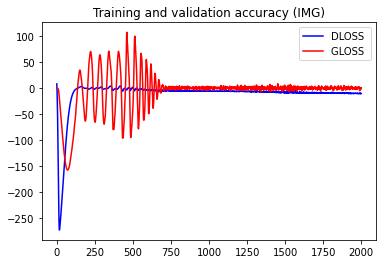

In [367]:
DLOSS = gan_history['DLOSS']
GLOSS = gan_history['GLOSS']
EPOCH = gan_history['EPOCH']

plt.plot(EPOCH, DLOSS, 'b', label='DLOSS')
plt.plot(EPOCH, GLOSS, 'r', label='GLOSS ')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/GANLOSS.pdf')) 

#### TEST CONVERT GRAYSCALE TO RGB 

##### import vari 

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageMath

##### prove varie 

In [ ]:
#ESPERIMENTI CONVERSIONE COLORI NON FUNZIONANTE
#https://machinelearningknowledge.ai/ways-to-convert-image-to-grayscale-in-python-using-skimage-pillow-and-opencv/
'''
img_path = os.path.join(path_images+"images/new_652.png")
image = io.imread(img_path)
io.imshow(image)
plt.show()
print(image.shape)

imgGray = io.color.gray2rgb(image)
'''
####################
'''
img_path = os.path.join('/content/drive/MyDrive/CALCIO_CROP_BASE/20200506124834.png') 
image = io.imread(img_path)
io.imshow(image)
plt.show()
'''
####################
'''
from PIL import Image
with Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/images/new_600.png') as im:
  print(im.getchannel)
  im.convert('RGB').save('/content/drive/MyDrive/CALCIO_CROP_BASE/images/den.png')
'''
####################
'''
trans = transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
transform = T.ToPILImage()

x = torch.randn(3, 224, 224)
out = trans(x)
print(out.shape)
img = transform(out)
img.show()
img #per stampare l'immagine, img.show() non fa !!!!
'''
####################
''' 
#COSi FUNZIONA -- fa solo il load e lo stampa 
from PIL import Image
img = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/images/new_600.png')
img
'''
####################
''' cose utili '''
'''
# define a transform to convert a tensor to PIL image
transform = T.ToPILImage()
# convert the tensor to PIL image using above transform
img = transform(tensor)
'''
####################
'''
#usando OPENCV 
#import cv2_imshow
print('USANDO OPEN CV ')
import cv2
img = cv2.imread('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png', 0) # il 0 serve per leggerla in grayscale, se non lo metti fa direttamente RGB
print(img.shape)
cv2_imshow(img)
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
print(backtorgb.shape)
cv2_imshow(backtorgb)
print('--------------------------------------')

#altre prove .... ma nada

# Open and ensure in RGB mode - in case image is palettised
im = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png')
print(im.size)
print('canali {} '.format(im.getchannel(1)))
print('canali R {} '.format(im.getchannel('R')))
print('canali G {} '.format(im.getchannel('G')))
print('canali B {} '.format(im.getchannel('B')))

#matrix = (0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0, 0.2, 0.5, 0.3, 0.0)
#im = im.convert('RGB',matrix)
#print(im.size)


img = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('RGB')
rgbimg = Image.new("RGBA", img.size)
rgbimg.paste(img)
rgbimg.save('foo.png')
'''

##### metodo 1 

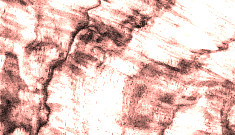

In [365]:
'''
il blocco sotto sembra funzionare ... ma le img non sono come quelle reali, la matrix non ho ben capito come funziona, ma cambiano i numeri si aggiungono i colori 
'''

from PIL import Image
# Open and ensure in RGB mode - in case image is palettised
im = Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('RGB')
# Crude conversion to black and white using 20% red, 50% green and 30% blue
matrix = (1.0, 0.8, 0.5, 0.0,
          0.5, 1.0, 0.0, 0.0,
          0.0, 0.4, 1.0, 0.3) #cambiando i numeri, escono fuori dei colori ... quindi forse si può fare !!!! 
result = im.convert('RGB',matrix)
result.save('result.png')
result

##### metodo 2 

In [366]:
'''
il blocco sotto sembra funzionare ... ma le img non sono come quelle reali, il CMAP le crea in base alla mappa scelta 
'''

#LINK : https://matplotlib.org/stable/tutorials/colors/colormaps.html 
import numpy as np
from PIL import Image
from matplotlib import cm

# Get 256 entries from "viridis" or any other Matplotlib colormap
colmap = cm.get_cmap('inferno', 256) 

# Make a Numpy array of the 256 RGB values
# Each line corresponds to an RGB colour for a greyscale level
np.savetxt('cmap.csv', (colmap.colors[...,0:3]*255).astype(np.uint8), fmt='%d', delimiter=',')

# Load image as greyscale and make into Numpy array
grey = np.array(Image.open('/content/drive/MyDrive/CALCIO_CROP_BASE/patches/class9.0/patch_20200506123315.png').convert('L'))
Image.fromarray(grey).save('before_result.png')

# Load RGB LUT from CSV file
lut = np.loadtxt('/content/drive/MyDrive/CALCIO_CROP_BASE/cmap.csv', dtype=np.uint8, delimiter=',')

# Make output image, same height and width as grey image, but 3-channel RGB
result = np.zeros((*grey.shape,3), dtype=np.uint8)

# Take entries from RGB LUT according to greyscale values in image
np.take(lut, grey, axis=0, out=result)
# Save result
Image.fromarray(result).save('result.png')

#### Train Classico 

In [223]:
from sklearn.preprocessing import LabelBinarizer
import time

#per progress bar
from tqdm import tqdm

#LINK UTILE : https://stackoverflow.com/questions/59584457/pytorch-is-there-a-definitive-training-loop-similar-to-keras-fit
'''
LINK UTILE PER CREARE UN OGGETO DI CLASSE Trainer, CHE OTTIMIZZA IL PROCESSO DI TRAINING INCORPORANDO ANCHE LE CALLBACKS
https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.html#pytorch_lightning.trainer.trainer.Trainer
'''

#per ignorare i vari warnings
import warnings
warnings.filterwarnings("ignore")

model.to(device)

criterion = nn.CrossEntropyLoss() #sarebbere la nostra loss function 
optimizer = opt #opt definito all'interno del blocco Hyper-Parameters 


history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
history['bal_acc'] = []
history['val_bal_acc'] = []

start_time_sec = time.time()
losses = [] 

early_stopping = _EarlyStopping(patience=10, verbose=True, path = path_drive+'ProgettoDL/pytorch_model')

print('train() called: model={}, opt={}, epochs={}, device={}\n'.
      format(type(model).__name__,type(optimizer).__name__, epochs, device))

for epoch in range(0, epochs):
    print('-----------------------------------------------------------------')
    print('Inizio Epoch : {}'.format(epoch+1))
    #alleno il modello 
    model.train()
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    
    for batch_idx, (data, targets, targets2) in tqdm(enumerate(trainloader), desc = 'Epoch : {} train batch'.format(epoch+1)):
      data = data.to(device=device)
      targets = targets.to(device = device) #classes
      targets2 = targets2.to(device = device) #series

      # Clear the gradients
      optimizer.zero_grad()
      # Forward Pass
      scores = model(data)
      # Find the Loss
      loss = criterion(scores,targets)
      # Calculate gradients 
      loss.backward()
      # Update Weights
      optimizer.step()
      # Calculate Loss
      train_loss += loss.item()  * data.size(0)
      num_train_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
      num_train_examples += data.shape[0]   
   

    #print('num_train_correct {}'.format(num_train_correct))
    #print('num_train_examples {}'.format(num_train_examples))

    train_acc   = num_train_correct / num_train_examples
    train_loss  = train_loss / len(trainloader.dataset.dataframe)
    #train_loss  = train_loss / sampler_.number_of_samples

    bal_acc = _bal_acc_(targets,scores)

    model.eval()
    val_loss       = 0.0
    num_val_correct  = 0
    num_val_examples = 0

    for batch_idx, (data, targets, targets2) in tqdm(enumerate(valloader), desc = 'Epoch : {} val batch'.format(epoch+1)):
      data = data.to(device=device)
      targets = targets.to(device = device) #classes
      targets2 = targets2.to(device = device) #series

      scores = model(data)
      loss = criterion(scores,targets)

      val_loss         += loss.data.item()  * data.size(0)
      num_val_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
      num_val_examples += scores.shape[0]
    
    #print('num_val_correct {}'.format(num_val_correct))
    #print('num_val_examples {}'.format(num_val_examples))
    val_acc  = num_val_correct / num_val_examples
    val_loss = val_loss / len(valloader.dataset.dataframe)
    val_bal_acc = _bal_acc_(targets,scores)
    

    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['bal_acc'].append(bal_acc)
    history['val_bal_acc'].append(val_bal_acc)


    print('Epoch : {} di {}, train loss : {} , train acc : {}, val loss : {}, val acc : {}, bal acc : {} , val bal acc : {} ' 
          . format(epoch+1,epochs, train_loss, train_acc, val_loss, val_acc, bal_acc, val_bal_acc))
   
    
    #early_stopping(val_loss, model)
    early_stopping(val_bal_acc, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


end_time_sec = time.time()
total_time_sec = end_time_sec - start_time_sec
time_per_epoch_sec = total_time_sec / epochs
print('Time total:     %5.2f sec' % (total_time_sec))
print('Time per epoch: %5.2f sec' % (time_per_epoch_sec))


train() called: model=VGG, opt=list, epochs=100, device=cpu

-----------------------------------------------------------------
Inizio Epoch : 1


Epoch : 1 train batch: 0it [00:00, ?it/s]


AttributeError: ignored

## PLOT 

In [ ]:
'''PLOT CURVES'''
import datetime
path = path_progettoDL


data_ora = datetime.datetime.now()

acc = history['acc']
val_acc = history['val_acc']
loss = history['loss']
val_loss = history['val_loss']
bal_acc = history['bal_acc']
val_bal_acc = history['val_bal_acc']
lista = [acc,val_acc,loss,val_loss, bal_acc, val_bal_acc]

import csv
os.chdir(path_progettoDL+'weights/')
with open("VGG16.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(lista)
     
len_epochs = range(len(acc))

plt.plot(len_epochs, acc, 'b', label='Training acc')
plt.plot(len_epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotAcc_{}_{}.pdf'.format(type_img,data_ora))) 

plt.figure()
 
plt.plot(len_epochs, loss, 'b', label='Training loss')
plt.plot(len_epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotLoss_{}_{}.pdf'.format(type_img,data_ora)))

plt.figure()

plt.plot(len_epochs, bal_acc, 'b', label='Training Balance Accuracy')
plt.plot(len_epochs, val_bal_acc, 'r', label='Validation Balance Accuracy')
plt.title('Training and validation balance accuracy (IMG)')
plt.legend()
plt.savefig(os.path.join(path_progettoDL+'weights/PlotBalAcc_{}_{}.pdf'.format(type_img,data_ora)))

## SAVE MODEL 

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [ ]:
#salvataggio modello pesi finali
path = path_progettoDL+'pytorch_model'
torch.save(model.state_dict(), os.path.join(path))
print("Saved model to disk")

## LOAD MODEL 

In [ ]:
path = path_progettoDL+'pytorch_model'
model.load_state_dict(torch.load(path))
model.eval()
print('Model IMG Loaded')

## PREDICTION 

In [ ]:
num_test_correct  = 0
num_test_examples = 0
#da rimuovere dopo 
#criterion = nn.CrossEntropyLoss()

scores_, targets_ = list(), list()

for (data, targets, targets2) in (testloader):
  data = data.to(device=device)
  targets = targets.to(device = device) #classes
  targets2 = targets2.to(device = device) #series

  scores = model(data)
  
  num_test_correct  += (torch.max(scores, 1)[1] == targets).sum().item()
  num_test_examples += scores.shape[0]

  #scores_.append(torch.max(scores, 1)[1])
  scores_ = np.append(scores_, torch.max(scores, 1)[1].detach().numpy())
  targets_ = np.append(targets_, targets.detach().numpy())

#print('num_val_correct {}'.format(num_val_correct))
#print('num_val_examples {}'.format(num_val_examples))

test_acc  = num_test_correct / num_test_examples
test_bal_acc = balanced_accuracy_score(targets_, scores_)

print('Accuracy : {:.4f}, balance accuracy : {:.4f}'. format(test_acc, test_bal_acc))

In [ ]:
# qui ho cercato di capire quanti scores_ e targets_ sono uguali tra loro
K=0
K += (scores_ == targets_).sum().item()
print(f'predizione corrette : {K}')

## IDEA ALEX 

**IDEA**:
PER MIGLIORARE L'ALGORITMO POTREMMO METTERE UNA LOGICA AGGIUNTIVA:

***IPOTESI*** SE VETTORE DELLE PROBABILITÀ DELLE PREDICTION IN FASE DI TRAINING HA COME VALORE MAGGIORE (DOVE VALE argmax) UN VALORE INFERIORE A 0.25-0.3 ALLORA PROBABILMENTE LE PROBABILITÀ SONO MOLTE DISTRIBUITE PERCHÈ LA RETE NEURALE LA STA PREDICENDO MALE, QUINDI POSSIAMO FORSE SUPPORRE CHE QUELL'IMMAGINE PUÒ TROVARSI FORSE (COME CLASSE DI QUALITÀ IN ZONA INTERMEDIA), QUANDO INVECE POTREBBE AVER DECISO MALE DI TROVARSI NEGLI ESTREMI (I.E. 1,2-, 3+,4).
**AZIONE** IO PROVEREI QUINDI A STAMPARE TUTTI I VETTORI OGNI QUAL VOLTA IL VALORE DI ARGMAX SIA INFERIRORE A 0.25-0.3 E AIUTARLO IN MODO SUPERVISIONATO, METTENDO MAGARI DELLE CONDIZIONI PER FARGLI CAMBIARE IDEA POSTO DECISIONE DELLA RETE NEURALE, O ADDIRITTURA CERCANDO UN MODO PER AGGIORNARE I PESI.
ALTRIMENTI SEMPRE LATO UTENTE SI PUÒ PROVARE A MODIFICARE L'OUTPUT DELLA PREDIZIONE
**NOTA:** OVVIAMENTE PRIMA DI PROCEDERE SU QUESTA STRADA STAMPARE TUTTI I POSSIBILI VETTORI CON LA RELATIVA LABEL REALE E LABEL PREDETTA, COSÌ DA VEDERE SE QUESTA COSA FOSSE MOLTO RICORRENTE


##SEARCH UNIVOQUE SERIES TO BALANCE SETS (DA CONTROLLARE SERVE PER LE CM) 

In [ ]:
#SEARCHING UNIVOQUE SERIES
test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4, test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9, test_array_s10, test_array_s11, test_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4, pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9, pred_array_s10, pred_array_s11, pred_array_s12 = [], [], [], [], [], [], [], [], [], [], [], [], []
i=0
for index, row in test_balance_df.iterrows():
    
    series_ = int(row['series'])
    if series_ == 0:
      test_array_s0.append(targets_[i])
      pred_array_s0.append(scores_[i])
    if series_ == 1:
      test_array_s1.append(targets_[i])
      pred_array_s1.append(scores_[i])
    if series_ == 2:
      test_array_s2.append(targets_[i])
      pred_array_s2.append(scores_[i])
    if series_ == 3:
      test_array_s3.append(targets_[i])
      pred_array_s3.append(scores_[i])
    if series_ == 4:
      test_array_s4.append(targets_[i])
      pred_array_s4.append(scores_[i])
    if series_ == 5:
      test_array_s5.append(targets_[i])
      pred_array_s5.append(scores_[i])
    if series_ == 6:
      test_array_s6.append(targets_[i])
      pred_array_s6.append(scores_[i])
    if series_ == 7:
      test_array_s7.append(targets_[i])
      pred_array_s7.append(scores_[i])
    if series_ == 8:
      test_array_s8.append(targets_[i])
      pred_array_s8.append(scores_[i])
    if series_ == 9:
      test_array_s9.append(targets_[i])
      pred_array_s9.append(scores_[i])
    if series_ == 10:
      test_array_s10.append(targets_[i])
      pred_array_s10.append(scores_[i])
    if series_ == 11:
      test_array_s11.append(targets_[i])
      pred_array_s11.append(scores_[i])
    if series_ == 12:
      test_array_s12.append(targets_[i])
      pred_array_s12.append(scores_[i])

    i=i+1

print(test_array_s0)
print(pred_array_s0)

from functools import reduce
reduced = reduce(np.union1d, (pred_array_s0, test_array_s0))
print(reduced)

## METRICHE MASK & IMG 

In [ ]:
'''METRICHE'''
print('--------------Metrice IMG----------------')
#print(y_test)
#print(y_pred)
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html                                  
print("test accuracy  : {:.4f}".format(accuracy_score(targets_, scores_) ))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html?highlight=precision_score#sklearn.metrics.precision_score
print("precision  : {:.4f}".format(precision_score(targets_, scores_, average="macro")))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html?highlight=recall_score#sklearn.metrics.recall_score         
print("recall : {:.4f}".format(recall_score(targets_, scores_ , average="macro")))
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score             
print("f1_score : {:.4f}".format(f1_score(targets_, scores_, average="macro")))        
print('classification report')
print(classification_report(targets_, scores_))  


Per quanto riguarda la funzione np_quadratic_weighted_kappa abbiamo avuto alcune difficoltà implementative e quindi abbiamo cercato un codice online che ci calcolasse la stessa metrica 

[Link Utilizzato](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps)

## METRICHE SECONDARIE QWK, MS, MAE 


In [ ]:

# The following 3 functions have been taken from Ben Hamner's github repository
# https://github.com/benhamner/Metrics
def Cmatrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=1 # era None abbiamo messo 0
    max_rating=9 # era None abbiamo messo 9
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = Cmatrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)

In [ ]:
path_drive = '/content/drive/My Drive/'
path = path_drive+'ProgettoDL/'

os.chdir(path)

from metrics import np_quadratic_weighted_kappa, minimum_sensitivity
from sklearn.metrics import mean_absolute_error

#Alternativa al MS di metrics 
from imblearn.metrics import sensitivity_score

def compute_metrics(y_true, y_pred, num_classes):
  # Calculate metric
  qwk = quadratic_weighted_kappa(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  #ms = minimum_sensitivity(y_true, y_pred) #---> DA RIVEDERE PERCHE' NON C'é PIU' y_pred_no_argmax
  
  ms = sensitivity_score(y_true, y_pred, average='macro')


  metrics = {
		'QWK': qwk,
		'MS': ms,
		'MAE': mae
  }
  
  return metrics

def print_metrics(metrics):
	print('QWK: {:.4f}'.format(metrics['QWK']))
	print('MS: {:.4f}'.format(metrics['MS']))
	print('MAE: {:.4f}'.format(metrics['MAE']))    


#-----codice------

num_classi = 10

print('Metrics')
metrics = compute_metrics(targets_, scores_,num_classi)
print_metrics(metrics)


with open("metrics.txt", "w") as text_file:
    print(print_metrics, file=text_file)


***Metrice Ottenute***

**K Cohen**   https://it.vvikipedla.com/wiki/Cohen%27s_kappa
Il Kappa di Cohen è un coefficiente statistico che rappresenta il grado di accuratezza e affidabilità in una classificazione statistica; è un indice di concordanza che tiene conto della probabilità di concordanza casuale; l'indice calcolato in base al rapporto tra l'accordo in eccesso rispetto alla probabilità di concordanza casuale e l'eccesso massimo ottenibile. Attraverso la matrice di confusione è possibile valutare questo parametro. In particolare ... Esistono diversi "gradi di concordanza", in base ai quali possiamo definire se Kappa di Cohen è scarso o ottimo:

- se k assume valori inferiori a 0, allora non c'è concordanza;
- se k assume valori compresi tra 0-0,4, allora la concordanza è scarsa;
- se k assume valori compresi tra 0,4-0,6, allora la concordanza è discreta;
- se k assume valori compresi tra 0,6-0,8, la concordanza è buona;
- se k assume valori compresi tra 0,8-1, la concordanza è ottima.

**QWK**: 0.7849

BLA BLA BLA 

**MS**: 1.0000


In statistics, **mean absolute error (MAE)** is a measure of errors between paired observations expressing the same phenomenon. Examples of Y versus X include comparisons of predicted versus observed, subsequent time versus initial time, and one technique of measurement versus an alternative technique of measurement. 

**MAE**: 0.0000

## CONFUSION MATRIX FUNCTION - DA RIMUOVERE

In [ ]:
#Confusion Matrix - CROP
import sklearn.metrics as metrics

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    axes = plt.gca()
    bottom, top = axes.get_ylim()
    axes.set_ylim(bottom + 0.5, top - 0.5)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
    return fig




## PLOT CONFUSION MATRIX

In [ ]:
import sklearn.metrics as metrics
data_ora = datetime.datetime.now()


fig, axs = plt.subplots(1)
fig0 = ConfusionMatrixDisplay.from_predictions(y_true=targets_, y_pred=scores_, cmap='Blues', ax = axs)
plt.suptitle('Confusion Matrix IMG', y=1.0, fontsize=12)
plt.title('Accuracy {:.4f} , Prediction {:.4f}'.format(accuracy_score(targets_, scores_),precision_score(targets_, scores_, average="macro") ), fontsize=10)
plt.show()
fig.savefig(os.path.join(path+'weights/CM_{}_{}.pdf'.format(type_img,data_ora))) 


##PLOT CONFUSION MATRIX PER CIASCUNA SERIE DEL CALCIO 

In [ ]:
path = path_progettoDL
data_ora = datetime.datetime.now()

test_array_series_complete = [
        test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4,
        test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9,
        test_array_s10, test_array_s11, test_array_s12             
]

pred_array_series_complete = [
        pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4,
        pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9,
        pred_array_s10, pred_array_s11, pred_array_s12             
]

for series in range(13):
  fig, axs = plt.subplots(1)
  fig0 = ConfusionMatrixDisplay.from_predictions(y_true=test_array_series_complete[series], y_pred=pred_array_series_complete[series], cmap='Blues', ax = axs)
  plt.suptitle('Confusion Matrix Series {}'.format(series), y=1.0, fontsize=12)
  plt.title('Accuracy {:.4f} , Prediction {:.4f}'.format(accuracy_score(test_array_series_complete[series], pred_array_series_complete[series]),precision_score(test_array_series_complete[series], pred_array_series_complete[series], average="macro") ), fontsize=10)
  plt.show()
  fig.savefig(os.path.join(path+'weights/CM_serie{}_{}_{}.pdf'.format(series, type_img,data_ora))) 

## CRAMER V CORRELATION

In [ ]:

#PRIMA VERSIONE
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

confusion_matrix = pd.crosstab(scores_, targets_)
print("cramer correlation tra predizioni delle classi, e le classi effettive")
cramer1 = cramers_v(confusion_matrix.values)
print('CRAMER : {:.5f} '.format(cramer1))


'''
#------ prove denis ----------
test_array_series = np.array(test_balance_df['series']) 
y_test_series = test_array_series #custom_to_categorical(np.unique(test_array_series, return_inverse=True)[1], num_classes=13)  
#print(y_test_series)
#------ fine prove denis ----------

confusion_matrix2 = pd.crosstab(y_test_series, scores_)
print("cramer correlation tra predizioni delle classi e le ground thruth di shotgun series")
cramer2 = cramers_v(confusion_matrix2.values)
print(cramer2)
'''
print('-------------')

In [ ]:
print('Seconda versione Cramer')
'''
#SECONDA VERSIONE.        https://www.youtube.com/watch?v=eTnLTJer_Oo
contTable = pd.crosstab(y_test_series, scores_)
print(contTable)

!pip install researchpy

import researchpy

crosstab, res = researchpy.crosstab(pd.Series(y_test_series), pd.Series(scores_), test='chi-square')
print("\n{}".format(res))

df = min(contTable.shape[0], contTable.shape[1]) - 1
print("\ndf = {}".format(df))

V = res.iloc[2,1]
print("V = {}".format(V))

if df == 1:
    if V < 0.10:
        qual = 'negligible'
    elif V < 0.30:
        qual = 'small'
    elif V < 0.50:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 2:
    if V < 0.07:
        qual = 'negligible'
    elif V < 0.21:
        qual = 'small'
    elif V < 0.35:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 3:
    if V < 0.06:
        qual = 'negligible'
    elif V < 0.17:
        qual = 'small'
    elif V < 0.29:
        qual = 'medium'
    else:
        qual = 'large'
elif df == 4:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.15:
        qual = 'small'
    elif V < 0.25:
        qual = 'medium'
    else:
        qual = 'large'
else:
    if V < 0.05:
        qual = 'negligible'
    elif V < 0.13:
        qual = 'small'
    elif V < 0.22:
        qual = 'medium'
    else:
        qual = 'large'

print("\nquality classification of the correlation is:   {}".format(qual))
'''
print('------')

To indicate the strength of the association between two nominal variables, Cramér's V (Cramér, 1946) is often used.

As for the interpretation for Cramér's V various rules of thumb exist but one of them is from Cohen (1988, pp. 222, 224, 225) who let's the interpretation depend on the degrees of freedom, shown in the table below.

|df*|negligible|small|medium|large|
|-------|---|---|---|---|
|1|0 < .10|.10 < .30|.30 < .50|.50 or more|
|2|0 < .07|.07 < .21|.21 < .35|.35 or more|
|3|0 < .06|.06 < .17|.17 < .29|.29 or more|
|4|0 < .05|.05 < .15|.15 < .25|.25 or more|
|5|0 < .05|.05 < .13|.13 < .22|.22 or more|

The degrees of freedom (df*) is for Cramér's V the minimum of the number of rows, or number of columns, then minus one.

Lets see how to obtain Cramér's V with Python, using an example.




**A SECONDA DEI RISULTATI E CONFRONTANDOLI CON LA TABELLA RIUSCIAMO A CAPIRE L'INTENSITA' DEL BIAS TRA DIVERSE VARIABILI**

## **T-SNE  & PCA**


### Spiegazioni, Link Utili e Implementazione 

***(t-SNE)*** t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data. It maps multi-dimensional data to two or more dimensions suitable for human observation. With help of the t-SNE algorithms, you may have to plot fewer exploratory data analysis plots next time you work with high dimensional data.

[Link utile ](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)

***(PCA) Principal Component Analysis***
Lʹanalisi delle componenti principali (detta pure PCA oppure CPA) è una tecnica utilizzata nell’ambito della statistica multivariata per la semplificazione dei dati d’origine.
Lo scopo primario di questa tecnica è la riduzione di un numero più o meno elevato di variabili (rappresentanti altrettante caratteristiche del fenomeno analizzato) in alcune variabili latenti. Ciò avviene tramite una trasformazione lineare delle variabili che proietta quelle originarie in un nuovo sistema cartesiano nel quale le variabili vengono ordinate in ordine decrescente di varianza: pertanto, la variabile con maggiore varianza viene proiettata sul primo asse, la seconda sul secondo asse e così via. La riduzione della complessità avviene limitandosi ad analizzare le principali (per varianza) tra le nuove variabili.
Diversamente da altre trasformazioni (lineari) di variabili praticate nellʹambito della statistica, in questa tecnica sono gli stessi dati che determinano i vettori di trasformazione.
[Step By Step](https://www.youtube.com/watch?v=FgakZw6K1QQ)

[Link Utile](https://www.analyticsvidhya.com/blog/2020/12/an-end-to-end-comprehensive-guide-for-pca/) 

***Parametri del TSNE***
1. **n_components** int, default=2 - Dimension of the embedded space.

2. **perplexityfloat, default=30.0** - The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. Different values can result in significantly different results.

3. **early_exaggeration float, default=12.0**
Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.

4. **learning_ratefloat, default=200.0** The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a ‘ball’ with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.

5. **n_iterint, default=1000**
Maximum number of iterations for the optimization. Should be at least 250.

6. **n_iter_without_progressint, default=300**
Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50.

7. **metricstr or callable, default=’euclidean’**
The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is “precomputed”, X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is “euclidean” which is interpreted as squared euclidean distance.

8. **init{‘random’, ‘pca’} or ndarray of shape(n_samples, n_components), default=’random’**
Initialization of embedding. Possible options are ‘random’, ‘pca’, and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.

9. **verboseint, default=0** Verbosity level.

10. **random_stateint, RandomState instance or None, default=None** Determines the random number generator. Pass an int for reproducible results across multiple function calls. Note that different initializations might result in different local minima of the cost function. See :term: Glossary <random_state>.

11. **methodstr, default=’barnes_hut’**
By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method=’exact’ will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples.

12. **n_jobsint, default=None**
The number of parallel jobs to run for neighbors search. This parameter has no impact when metric="precomputed" or (metric="euclidean" and method="exact"). None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.


[scikit-learn.org](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[misread-tsne](https://distill.pub/2016/misread-tsne/)

[altro modo spiegato anche meglio](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)


#### Dataset 

In [ ]:
'''
import numpy as np
from keras.models import Sequential
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd

os.chdir('/content/drive/MyDrive/ProgettoDL')
path = os.getcwd()

col_list_sx = ["ID", "COD_COMPONENTE", "IMG_LATOSX", "CLASSE_CALCIOSX"]
dataframe_sx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_sx, sep=";")


col_list_dx = ["ID", "COD_COMPONENTE", "IMG_LATODX", "CLASSE_CALCIODX"]
dataframe_dx_complessivo = pd.read_csv(os.path.join(path + '/20201102_ExportDB.txt'), usecols=col_list_dx, sep=";")


dataframe_sx_complessivo.columns = ['ID','series', 'filename', 'class']
dataframe_dx_complessivo.columns = ['ID','series', 'filename', 'class']

#print(dataframe_sx.columns)                 #stampo i due elementi con stesso ID (lato dx e sx di stesso CALCIO)
frames = [dataframe_sx_complessivo, dataframe_dx_complessivo]
result_complessivo = pd.concat(frames)
#print(result_complessivo)
#print(result_complessivo.loc[[1]])
#print(type(result_complessivo.loc[[1]]))

result_complessivo["class"] = result_complessivo["class"].map({'1': int(0), '2-': int(1), '2': int(2), '2+': int(3), '3-': int(4), '3': int(5), '3+': int(6), '4-': int(7), '4': int(8), '4+': int(9)})
result_complessivo["series"] = result_complessivo["series"].map({2: int(0), 4: int(1), 8: int(2), 10: int(3), 6: int(4), 9: int(5), 3: int(6), 11: int(7), 12: int(8), 13: int(9), 14: int(10), 15: int(11), 7: int(12)})

#IDENTIFICAZIONE VALORI NULL 
print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))
print(result_complessivo.loc[result_complessivo['class'] == '0'])
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo['class'] = pd.to_numeric(result_complessivo['class'], errors='coerce')
print(result_complessivo[result_complessivo['class'].isnull()])
result_complessivo = result_complessivo.dropna(subset=['class'])    #rimuovo le righe con elementi nulli
print(result_complessivo[result_complessivo['class'].isnull()])

print("Null VALUE di class : "+format(result_complessivo['class'].isnull().sum()))

#IMMG EXIST ?  (cerco se qualche path non esiste e lo elimino dal dataframe) e se esiste ne faccio la MASCHERA
import os.path
from os import path
os.chdir('/content/drive/MyDrive/CALCIO_NOPRE')
for index, row in result_complessivo.iterrows():
    filename = row['filename']
    if(os.path.exists(filename) == False):
      result_complessivo = result_complessivo.drop(result_complessivo[(result_complessivo['filename'] == filename)].index)
      print('File : {} eliminato'.format(filename))

print('------------------- DATASET BASE ---------------')
print(type(result_complessivo))  
print(len(result_complessivo))
print(result_complessivo)

result_complessivo_totale = pd.DataFrame()

for index, row in result_complessivo.iterrows():
  filename_mask = 'mask_{}'.format(row['filename'])
  #filename_gray = 'gray_{}'.format(row['filename'])
  class_ = row['class']
  series_ = row['series']
  #print('{}_{}_{}_{}'.format(filename_gray,filename_mask, class_, series_)) "ID": row['ID']
  row_df_1 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_mask, "class" : class_},index=[0])
  #row_df_2 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename_gray, "class" : class_},index=[0])
  #row_df_3 = pd.DataFrame({"ID": row['ID'], "series" : series_, "filename" : filename, "class" : class_},index=[0])
  #print(row_df_1)
  #print(row_df_2)
  result_complessivo_totale = result_complessivo_totale.append(row_df_1)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_2)
  #result_complessivo_totale = result_complessivo_totale.append(row_df_3)


print('------------------- DATASET COMPLESSIVO ---------------') 
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
#print(result_complessivo_totale)

from sklearn.utils import shuffle
result_complessivo_totale = shuffle(result_complessivo_totale)
print(type(result_complessivo_totale))  
print(len(result_complessivo_totale))
print(result_complessivo_totale)
'''

#### import utili per il TSNE e PCA

In [ ]:
'''
%matplotlib inline
from __future__ import print_function
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd    
from sklearn.preprocessing import StandardScaler
'''

#### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - QUALITY CLASS

In [ ]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm
immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []

data_X = result_complessivo_totale['filename'][:1000] #---versione originale 
result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim ---versione originale 
y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... ---versione originale 

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    
    #print('Originale : {} x {} x {}'.format(image.size[0], image.size[1], len(image.size)-1))
    #plt.imshow(image)
    scale_percent = 90 # percent of original size
    width, height = image.size
    #print('channel : {}'.format(len(image.size)))
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X = np.asarray(imgs_array_tot)
print(X.shape)
'''

##### IMG to ARRAY per il calcolo del PCA e TSNE & Reduction delle immagini - SHOTGUN SERIES

In [ ]:
'''
# https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b
from tqdm import tqdm

immg_rows = 270 
immg_cols = 470
X = [] 
imgs_array_tot = []
data_X = result_complessivo_totale['filename'][:1000]

result_complessivo_totale_min = result_complessivo_totale[:1000] #--deve essere uguale a y_dim

y = result_complessivo_totale['class'][:1000] #--- deve essere uguale ... 

y_series = result_complessivo_totale['series'][:1000] #--- deve essere uguale ...

for index, row in tqdm(result_complessivo_totale_min.iterrows()):
    filename = row['filename']
    if(filename[0] == 'm'):
      image = load_img('/content/drive/My Drive/MASK_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    elif(filename[0] == 'g'): 
      image = load_img('/content/drive/My Drive/GRAY_CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")
    else:
      image = load_img('/content/drive/My Drive/CALCIO_CROP/{}'.format(filename), target_size = (immg_rows, immg_cols, 1), color_mode="grayscale")

    scale_percent = 90 # percent of original size
    width, height = image.size
    width = int(width * scale_percent / 100)
    height = int(height * scale_percent / 100)
    dim = (width, height)
    # resize image
    x = img_to_array(image)
    resized = cv2.resize(x, dim, interpolation = cv2.INTER_AREA)
    #print('Ridimensionata : {}'.format((resized.shape)))
    #print('Resized Dimensions : ',resized.shape)
    imgs_array_tot.append(resized)
    X2 = np.asarray(imgs_array_tot)
print(X2.shape) 
'''

#### Check & Create Dataframe for PCA (Principal Analysis Component) & T-SNE (t-distributed stochastic neighbor embedding)

##### classi di qualità 

In [ ]:
'''
print('X SHAPE : {}'.format(X.shape))

nsamples = X.shape[0]
rows = X.shape[1]
cols = X.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X))
X_1 = np.reshape(X, (X.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_1.shape)) #--- controllo se ho fatto tutto correttamente 

feat_cols = [ 'pixel'+str(i) for i in range(X_1.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df = pd.DataFrame(X_1,columns=feat_cols)
#df = pd.DataFrame(X_1)
df['y'] = pd.DataFrame({ 'y': np.array(y) })
df['label'] = df['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])
'''

##### shotgun series 

In [ ]:
'''
print('X2 SHAPE : {}'.format(X2.shape))

nsamples = X2.shape[0]
rows = X2.shape[1]
cols = X2.shape[2]
channel = 1

print('n_samples : {} , rows : {} , cols : {} , channel : {} '.format(nsamples, rows, cols, channel))
print(type(X2))
X_11 = np.reshape(X2, (X2.shape[0],rows*cols*channel)) #-- serve per modificare la dimensione, per il fit_transform          FORSE QUI BISOGNA SOLO USARE I PRIMI 2 VALORI E IL 3 DEI CANALI NO!

print('X MODIFICATO : {}'.format(X_11.shape)) #--- controllo se ho fatto tutto correttamente 
#print(X_1)

feat_cols = [ 'pixel'+str(i) for i in range(X_11.shape[1]) ]
print('Feat Cols : {} '.format(len(feat_cols)))
#print(feat_cols)
df_2 = pd.DataFrame(X_11,columns=feat_cols)
#df = pd.DataFrame(X_1)
df_2['y'] = pd.DataFrame({ 'y': np.array(y_series) })
df_2['label'] = df_2['y'].apply(lambda i: str(i))
#X, y = None, None
print('Size of the dataframe: {}'.format(df_2.shape))



# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_2.shape[0])
'''

#### Calcolo TSNE & PLOT TSNE

##### TSNE QUALITY CLASS

In [ ]:
'''
time_start = time.time()
N = 1000 
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
#data_subset = df_subset
#tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... originale 
tsne = TSNE(n_components=2, verbose=1, perplexity=200, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

##### TSNE SHOTGUN SERIES 

In [ ]:
'''
time_start = time.time()
N = 1000
df_subset_series = df_2.loc[rndperm[:N],:].copy()
#data_subset_series = df_subset_series
data_subset_series = df_subset_series[feat_cols].values
#tsne_series = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=3000, init='random', n_jobs = 10) #-- non so se serve init ... 
tsne_series = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=6000, init='random', n_jobs = 10) #-- nuova versione 
tsne_results_series = tsne_series.fit_transform(data_subset_series)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
'''

##### PLOT TSNE QUALITY CLASSES

In [ ]:
'''
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset,
    legend="full",
    alpha=0.3
)
'''

##### TSNE PLOT SHOTGUN SERIES 

In [ ]:
'''
df_subset_series['tsne-2d-one'] = tsne_results_series[:,0]
df_subset_series['tsne-2d-two'] = tsne_results_series[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette('Paired', as_cmap = True),
    data=df_subset_series,
    legend="full",
    alpha=0.3
)
'''

## **Metriche Nuove** + **B.A. across series**

#### Alcune Definizioni 


*  **True Positives** (TP): Items where the true label is positive and whose class is correctly predicted to be positive.
*  **False Positives** (FP): Items where the true label is negative and whose class is incorrectly predicted to be positive
*  **True Negatives** (N): Items where the true label is negative and whose class is correctly predicted to be negative.
*  **False Negatives** (FN): Items where the true label is positive and whose class is incorrectly predicted to be negative.

* **False Positive Rate**, or *Type I Error*: Number of items wrongly identified as positive out of the total actual negatives — FP/(FP+TN) - This error means that an image not containing a particular parasite egg is incorrectly labeled as having it
* **False Negative Rate**, or *Type II Error*: Number of items wrongly identified as negative out of the total actual positives — FN/(FN+TP). This metric is especially important to us, as it tells us the frequency with which a particular parasite egg is not classified correctly

-------------

* **Statistical Parity Difference**
This measure is based on the following formula :
𝑃𝑟(𝑌=1|𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑)−𝑃𝑟(𝑌=1|𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑) Here the bias or statistical imparity is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1. So it has to be close to 0 so it will be fair.

*  **Equal Opportunity Difference** This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula - 𝑇𝑃𝑅𝐷=𝑢𝑛𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑−𝑇𝑃𝑅𝐷=𝑝𝑟𝑖𝑣𝑖𝑙𝑒𝑔𝑒𝑑 Same as the previous metric we need it to be close to 0.

* **demographic parity** A fairness metric that is satisfied if the results of a model's classification are not dependent on a given sensitive attribute.

* **equality of opportunity** A fairness metric that checks whether, for a preferred label (one that confers an advantage or benefit to a person) and a given attribute, a classifier predicts that preferred label equally well for all values of that attribute. In other words, equality of opportunity measures whether the people who should qualify for an opportunity are equally likely to do so regardless of their group membership.

#### Implementazione Metriche Nuove e B.A. across series

In [ ]:
!pip install fairlearn 
from fairlearn.metrics import selection_rate
from fairlearn.metrics import true_positive_rate, false_positive_rate, true_negative_rate, false_negative_rate
from fairlearn.metrics import equalized_odds_difference

import sklearn as sk


#---- metriche lisa ----#
#_true = test_balance_df['class'].to_numpy()
#VERIFICA SE SERVE RIFARE STA RIGA SOPRA, MA BASTA PRENDERE:
y_true = targets_
y_pred = scores_


SR = selection_rate(y_true, y_pred, pos_label=1, sample_weight=None)
print('selection_rate : {}' . format(SR))


#Per quanto riguarda AO come metrica, potremo utilizzare i risultati della confusion matrix ?
#LINK : https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
#LINK : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix
#print('Unique Element Y_test : {}'.format(np.unique(y_test)))
#print('Unique Element Y_pred : {}'.format(np.unique(y_pred)))
#print('True_Positive_Rate : {}'.format(true_positive_rate(y_true, y_pred)))

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix (y_true, y_pred)
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('TPR : {}'.format(TPR))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('TNR : {}'.format(TNR))
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV : {}'.format(PPV))
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV : {}'.format(NPV))
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('FPR : {}'.format(FPR))
# False negative rate
FNR = FN/(TP+FN)
print('FNR : {}'.format(FNR))
# False discovery rate
FDR = FP/(TP+FP)
print('FDR : {}'.format(FDR))

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('Accuracy : {}'.format(ACC))


AO = 0.5*(
    (TPR[0] + FPR[0]) - 
    (TPR[1] + FPR[1]) + 
    (TPR[2] + FPR[2]) - 
    (TPR[3] + FPR[3]) +
    (TPR[4] + FPR[4]) -
    (TPR[5] + FPR[5]) +
    (TPR[6] + FPR[6]) -
    (TPR[7] + FPR[7]) +
    (TPR[8] + FPR[8]) -
    (TPR[9] + FPR[9]))

print('AO : {}'.format(AO))
#y_true= y_true.reshape(1,-1)
#y_pred= y_pred.reshape(-1,1)
#print(y_true.shape)
#print(y_pred.shape)


'''FORSE QUA RIUSCIAMO A TROVARE UN ESEMPIO DI APPLICAZIONE DEL METODO'''
'''https://deepnote.com/@Machine-Learning-2/Miniproject-z523fGqWSSu7QV34n_u7OA'''
'''https://fairlearn.org/main/user_guide/assessment.html'''


EO =(TPR[0] - TPR[1] + TPR[2] - TPR[3] + TPR[4] - TPR[5] + TPR[6] - TPR[7] + TPR[8] - FPR[9]) 
print('EO : {}' . format(EO))


#Demographic parity
'''
Demographic parity is one of the most popular fairness indicators in the literature. 
Demographic parity is achieved if the absolute number of positive predictions 
in the subgroups are close to each other. This measure does not take true class into
consideration and only depends on the model predictions. In some literature, 
demographic parity is also referred to as statsictal parity or independence.
'''
DP = (TP + FP)
print('Demographic parity : {}' . format(DP))

#Equalized odds
'''
Equalized odds, also known as separation, are achieved if the sensitivities in the 
subgroups are close to each other. The group-specific sensitivities 
indicate the number of the true positives divided by the total 
number of positives in that group.
'''
Equalized_Odds = TP / (TP + FN)
print('Equalized Odds : {}' . format(Equalized_Odds))


##---- Link Riccardo ----##
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html

print('----------------')
Balanced_Accuracy = sk.metrics.balanced_accuracy_score(y_true, y_pred, sample_weight=None, adjusted=False)
print('Balanced Accuracy Generale : {:.5f}' . format(Balanced_Accuracy))


#####----------- PER CIASCUNA SERIE BALANCED ACCURACY -----------####
test_array_series_complete = [
        test_array_s0, test_array_s1, test_array_s2, test_array_s3, test_array_s4,
        test_array_s5, test_array_s6, test_array_s7, test_array_s8, test_array_s9,
        test_array_s10, test_array_s11, test_array_s12             
]

pred_array_series_complete = [
        pred_array_s0, pred_array_s1, pred_array_s2, pred_array_s3, pred_array_s4,
        pred_array_s5, pred_array_s6, pred_array_s7, pred_array_s8, pred_array_s9,
        pred_array_s10, pred_array_s11, pred_array_s12             
]
sum_BA = 0
print('----------------')
for series in range(13):
  BA = sk.metrics.balanced_accuracy_score(test_array_series_complete[series],pred_array_series_complete[series], sample_weight=None, adjusted=False)
  print('Balanced Accuracy Series {} : {:.5f}' . format(series,BA ))
  print('----------------')
  sum_BA = sum_BA + BA


#----------- MEDIA DELLE BALANCED ACCURACY ---------------
Average = sum_BA/13
print('Average Balanced Accuracy : {:.5f}' . format(Average))
 

##---- Wodsworth et Al ----# 
#HIGH_RISK_GAP = SP #modulo o cardinalità 

#FN_GAP = false_negative (s1) - false negative (s2) 
#FN_GAP = (false_negative_rate(y_true, y_pred) - false_negative_rate(y_true, y_pred))  #modulo o cardinalità
  
#FN_GAP = false_negative (s1) - false negative (s2) 
#FP_GAP = (false_positive_rate(y_true, y_pred) - false_positive_rate(y_true, y_pred))  #modulo o cardinalità



### LINK UTILE ####
#https://www.kaggle.com/nathanlauga/ethics-and-ai-how-to-prevent-bias-on-ml

##PROVA MDSS (ATTUALMENTE NON FUNZIONA)

In [ ]:
'''imports'''
'''Importing packages & libraries for Bias metrics from AIF360 (end page analysis)'''

"""
import sys
import itertools
import datetime

### altri package necessari 
!pip install tempeh -q --force-reinstall
!pip install fairlearn -q --force-reinstall
!pip install GitPython -q --force-reinstall

#download aif360 
#!pip install -r requirement.txt 
#!python setup.py
###test  errore nella foto 

#!pip uninstall scikit-learn -q -y 
# errore cercato in rete : https://github.com/pycaret/pycaret/issues/704
# INSTALL CONDA ON GOOGLE COLAB
#! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
#! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
#sys.path.append('/usr/local/lib/python3.7/site-packages/')
# INSTALL PACKAGE CON CONDA 
#!conda install -c conda-forge scikit-learn -y 

## package necessario utile per il gitclone
from git import Repo

date_ = datetime.datetime.now()
#Repo.clone_from("link ... .git", "path di salvataggio")
#Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360_repo_{}".format(date_))
Repo.clone_from("https://github.com/Trusted-AI/AIF360.git", "/content/aif360") #controllare sempre, se è già salvato ... se salvato basta commentarlo

#---serve per aggiungere un nuovo package alla lista dei package installati
sys.path.append('/content/aif360/')


from aif360.metrics.mdss.ScoringFunctions import Bernoulli, ScoringFunction 
from aif360.metrics.mdss import MDSS

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder

from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score,classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from IPython.display import Markdown, display
import numpy as np
import pandas as pd

from collections import defaultdict
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import ClassificationMetric
"""

In [ ]:
"""from aif360.datasets import StandardDataset
dataset = StandardDataset(df, label_name='two_year_recid', favorable_classes=[0],
                 protected_attribute_names=['sex', 'race'],
                 privileged_classes=[[1], [1]],
                 instance_weights_name=None)"""

In [ ]:
"""
# !python3 -m pip install <pkg> -q il -q è per il quiet (per non avere quel macello in output) --force-reinstall

#https://github.com/Trusted-AI/AIF360
'''REPOSITORY PRINCIPALE DOVE SI TROVANO TUTTE LE RESTANTI CARTELLE E IMPLEMENTAZIONI'''
#https://github.com/Trusted-AI/AIF360/blob/master/examples/demo_mdss_classifier_metric.ipynb
'''file dove il tipo fa un esempio di uso di questa metrica!'''
#https://aif360.readthedocs.io/en/latest/index.html
'''link di aif360 dove ci sono i metodi CHE IMPORTA SOTTO'''


class MDSSClassificationMetric(ClassificationMetric):
    '''
        Bias subset scanning is proposed as a technique to identify bias in predictive models using subset scanning [1].
        This class is a wrapper for the bias scan scoring and scanning methods that uses the ClassificationMetric abstraction.
    References:
        .. [1] Zhang, Z., & Neill, D. B. (2016). Identifying significant predictive bias in classifiers. arXiv preprint arXiv:1611.08292.
    '''
    def __init__(self, dataset: BinaryLabelDataset, classified_dataset: BinaryLabelDataset, 
                scoring_function: ScoringFunction = Bernoulli(direction='positive'), unprivileged_groups: dict = None, privileged_groups:dict = None):
    
        super(MDSSClassificationMetric, self).__init__(dataset, classified_dataset,
                                                       unprivileged_groups=unprivileged_groups,
                                                       privileged_groups=privileged_groups)
        
        self.scanner = MDSS(scoring_function)
    
    def score_groups(self, privileged=True, penalty = 1e-17):
        '''
        compute the bias score for a prespecified group of records.
        
        :param privileged: flag for group to score - privileged group (True) or unprivileged group (False).
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the score for the group
        '''
        groups = self.privileged_groups if privileged else self.unprivileged_groups
        subset = dict()
        
        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'

        for g in groups:
            for k, v in g.items():
                if k in subset.keys():
                    subset[k].append(v)
                else:
                    subset[k] = [v]
        
        coordinates = pd.DataFrame(self.dataset.features, columns=self.dataset.feature_names)
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        self.scanner.scoring_function.kwargs['direction'] = direction
        return self.scanner.score_current_subset(coordinates, expected, outcomes, dict(subset), penalty)
    
    def bias_scan(self, privileged=True, num_iters = 10, penalty = 1e-17):
        '''
        scan to find the highest scoring subset of records
        
        :param privileged: flag for group to scan for - privileged group (True) or unprivileged group (False). 
        This abstract the need to explicitly specify the direction of bias to scan for which depends on what the favourable label is.
        :param num_iters: number of iterations (random restarts)
        :param penalty: penalty term. Should be positive. The penalty term as with any regularization parameter may need to be 
        tuned for ones use case. The higher the penalty, the less complex (number of features and feature values) the highest scoring
        subset that gets returned is.
        
        :returns: the highest scoring subset and the score
        '''

        xor_op = privileged ^ bool(self.classified_dataset.favorable_label)
        direction = 'positive' if xor_op else 'negative'
        self.scanner.scoring_function.kwargs['direction'] = direction

        coordinates = pd.DataFrame(self.classified_dataset.features, columns=self.classified_dataset.feature_names)
        
        expected = pd.Series(self.classified_dataset.scores.flatten())
        outcomes = pd.Series(self.dataset.labels.flatten())
        
        return self.scanner.scan(coordinates, expected, outcomes, penalty, num_iters)

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_compas

#import requests
#url = 'https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv'
#r = requests.get(url, allow_redirects=True)
#open('dataset.csv', 'wb').write(r.content)
#dataset_orig = pd.read_csv('/content/dataset.csv', sep=",")  


series_group = [{'series': 0, 'series': 1, 'series': 2, 'series': 3, 'series': 4, 'series': 5, 'series': 6, 'series': 7, 'series': 8, 'series': 9, 'series': 10, 'series': 11, 'series': 12}]
classes_group = [{'class': 0, 'class': 1, 'class': 2, 'class': 3, 'class': 4, 'class': 5, 'class': 6, 'class': 7, 'class': 8, 'class': 9}]

"""



In [ ]:
"""

mdss_classified = MDSSClassificationMetric(dataset_orig_test, dataset_bias_test,
                         unprivileged_groups=male_group,
                         privileged_groups=female_group)


mdss_classified = MDSSClassificationMetric(test_balance_df, dataset_bias_test,
                         unprivileged_groups=classes_group,
                         privileged_groups=series_group)

series_privileged_score = mdss_classified.score_groups(privileged=True)
print(series_privileged_score)
"""